# Google Speech Commands Dataset Recognition

- The objectives of this project are:
  - To understand how to preprocess audio files for machine learning
  - To develop a CNN using the extracted features
  - Create a prediction service using the trained model
  - Display the model training and diagram in Tensorboard
- We will take the Mel-frequency cepstral coefficients (MFCCs) and their deltas as our feature set
  - Used commonly for speech recognition and music classification

The Google Speech Command Dataset comes from this blog post: https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html

Librosa is an audio and music signal analysis package based on this paper: http://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf

More about librosa here: http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/index.html

Inspired by this Kaggle challenge: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import datetime
import json

In [90]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## Configurations

In [145]:
# Set paths

# Google Dataset
data_path = "dataset"
# Data Extracted
json_path = "data.json"

# Path to label mappings
mapping_path = "mappings.json"

# H5 is the filetype specifed by Keras: https://www.tensorflow.org/guide/keras/save_and_serialize#keras_h5_format
saved_path = "model.h5"

# Model Constants
learning_rate = 0.0001
epochs = 50
batch_size = 32 # This is the number of samples the CNN will see before updating with back-propagation
num_keywords = 31 # Number of classes in our set.

# Librosa constants

# 13 is a customary value used for number of MFCCs of audio classification
# The first 12-13 contain the most information (e.g. formants, spectral envelope)
num_coefficients = 13 
hop_length = 512 # How big our MFCC segments should be in number of frames.
n_fft = 2048 # How large the window of our Fast Fourier Transform will be.

# 1 second worth of sound based on the default settings from librosa
# 22050 samples in a second when loaded with librosa
# Audio files in Google voice command dataset have a duration of 1 second
sample_length = 22050 # This is equivalent to the Nyquist Frequeny of a CD

# Data Preprocessing

- Go through all data, extract features
- Store MFCCs in JSON file
- Extract 13 MFCC features, this is the standard from all the articles I read. Other values used are ca 45 and ca 90.
  - Then get the first and second-order MFCC deltas as additional features

### A look at the data

In [137]:
# Load an audio file
signal, sample_rate = librosa.load("test_audio/off.wav")
# Extract MFCCs
test_mfccs = librosa.feature.mfcc(y=signal, sr = sample_rate, n_mfcc=13)
test_mfccs.shape

(13, 44)

### Plotting the MFCCs
- Below is a plot of the MFCCs of one the test audio files.
  - You will notice that the Y-Axis has 13 rows and the X-Axis are the values of those coefficients over time

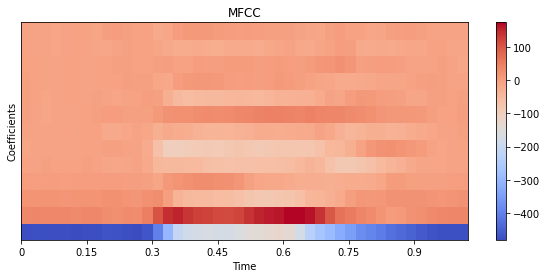

In [147]:
plt.figure(figsize=(10,4))
librosa.display.specshow(test_mfccs, x_axis="time", sr=sample_rate)
plt.title('MFCC')
plt.ylabel("Coefficients")
plt.colorbar()
plt.show()

### Adding the MFCC first and second-order deltas

In [140]:
test_mfccs_delta = librosa.feature.delta(test_mfccs)
test_mfccs_delta_2 = librosa.feature.delta(test_mfccs, order=2)
test_mfccs_features = np.concatenate((test_mfccs, test_mfccs_delta, test_mfccs_delta_2))
test_mfccs_features.shape

(39, 44)

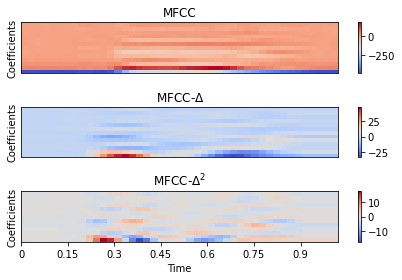

In [144]:
plt.subplot(3, 1, 1)
librosa.display.specshow(test_mfccs)
plt.title('MFCC')
plt.ylabel("Coefficients")
plt.colorbar()
plt.subplot(3, 1, 2)
librosa.display.specshow(test_mfccs_delta)
plt.title(r'MFCC-$\Delta$')
plt.ylabel("Coefficients")
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(test_mfccs_delta_2, x_axis='time')
plt.title(r'MFCC-$\Delta^2$')
plt.ylabel("Coefficients")
plt.colorbar()
plt.tight_layout()

## Extract data features from audio, store in JSON

In [114]:

def prep_data(data_path, json_path, num_coefficients=num_coefficients, hop_length=hop_length, n_fft=n_fft):
    
    # Dict containing, mappings of our words, their numerical labels, MFCCs, and paths to files.
    data = {
        "mappings": [],
        "labels": [],
        "mfccs": [],
        "files": []
    }
    
    # Loop through sub-directories
    # Find each directory, the subdirectories contained within, until we obtain filenames
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):
        # Check if at root level
        if dirpath is not data_path:
            # Update mapping
            cls = dirpath.split("/")[-1] #Grabs the last directory in path to use as a class name
            data["mappings"].append(cls)
            print("Processing: '{}'".format(cls))
            
            # For each file extract the MFCCs
            for filename in filenames:
                # Check filetype
                if not filename.lower().endswith(".wav"):
                    continue
                
                # Get path
                path = os.path.join(dirpath, filename)
                # Load audio file, librosa returns the signal and the sample rate
                # Sample rate is the number of samples we have per second of audio
                signal, sample_rate = librosa.load(path)
                # Check file is at least 1 second otherwise skip
                # We want to ensure that all samples have the same shape for neural network
                if len(signal) >= sample_length:
                    # Only consider the first second of data if longer
                    signal = signal[:sample_length]
                    
                    # Extract MFCCs, including the delta and second-order delta
                    mfccs = librosa.feature.mfcc(signal, n_mfcc=num_coefficients, hop_length=hop_length, n_fft=n_fft)
                    mfccs_delta = librosa.feature.delta(mfccs)
                    mfccs_delta_2 = librosa.feature.delta(mfccs, order=2)
                    mfccs_features = np.concatenate((mfccs, mfccs_delta, mfccs_delta_2))
                    # Store data in dict: labels, mfccs, filename
                    data["labels"].append(i-1) # Need to track i from the outer loop. -1 as we skipped root
                    data["mfccs"].append(mfccs_features.T.tolist()) # Librosa returns an ndarray, [T]ransform to a list
                    data["files"].append(path)
                    print(f"{path}: {i-1}")
    
    keywords = data["mappings"]
    # Write data from dict to JSON file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
    
    try:
        with open(mapping_path, "w") as mp:
            json.dump(data["mappings"], mp, indent=4)
    except:
        pass
        
    print("\nData Preparation Finished")


# Run data extraction process

In [115]:
if __name__ == "__main__":
    prep_data(data_path, json_path)

Processing: 'right'
dataset/right/988e2f9a_nohash_0.wav: 0
dataset/right/1eddce1d_nohash_3.wav: 0
dataset/right/93ec8b84_nohash_0.wav: 0
dataset/right/6272b231_nohash_1.wav: 0
dataset/right/439c84f4_nohash_1.wav: 0
dataset/right/2f813234_nohash_1.wav: 0
dataset/right/b87bdb22_nohash_1.wav: 0
dataset/right/97f4c236_nohash_2.wav: 0
dataset/right/563aa4e6_nohash_2.wav: 0
dataset/right/51055bda_nohash_4.wav: 0
dataset/right/fac74f6a_nohash_1.wav: 0
dataset/right/a8cb6dda_nohash_0.wav: 0
dataset/right/e4a2cf79_nohash_0.wav: 0
dataset/right/dabf67d9_nohash_0.wav: 0
dataset/right/742d6431_nohash_3.wav: 0
dataset/right/62581901_nohash_0.wav: 0
dataset/right/f852895b_nohash_2.wav: 0
dataset/right/d9b50b8b_nohash_1.wav: 0
dataset/right/229978fd_nohash_3.wav: 0
dataset/right/a5609cce_nohash_0.wav: 0
dataset/right/686d030b_nohash_1.wav: 0
dataset/right/409c962a_nohash_1.wav: 0
dataset/right/8012c69d_nohash_3.wav: 0
dataset/right/dc75148d_nohash_0.wav: 0
dataset/right/31583d30_nohash_0.wav: 0
datas

dataset/right/bdee441c_nohash_4.wav: 0
dataset/right/8c7f81df_nohash_1.wav: 0
dataset/right/c4500713_nohash_0.wav: 0
dataset/right/f0ae7203_nohash_0.wav: 0
dataset/right/3f2b358d_nohash_1.wav: 0
dataset/right/5e033479_nohash_0.wav: 0
dataset/right/df1d5024_nohash_1.wav: 0
dataset/right/c1e0e8e3_nohash_1.wav: 0
dataset/right/6b81fead_nohash_0.wav: 0
dataset/right/b36c27c2_nohash_0.wav: 0
dataset/right/17f0e206_nohash_0.wav: 0
dataset/right/e9287461_nohash_0.wav: 0
dataset/right/e9a76b2f_nohash_0.wav: 0
dataset/right/881583a6_nohash_0.wav: 0
dataset/right/24694eb6_nohash_0.wav: 0
dataset/right/bc065a17_nohash_0.wav: 0
dataset/right/620ff0fa_nohash_2.wav: 0
dataset/right/24694eb6_nohash_1.wav: 0
dataset/right/f8f60f59_nohash_4.wav: 0
dataset/right/5e033479_nohash_1.wav: 0
dataset/right/c1e0e8e3_nohash_0.wav: 0
dataset/right/df1d5024_nohash_0.wav: 0
dataset/right/3f2b358d_nohash_0.wav: 0
dataset/right/f5e5e8b0_nohash_0.wav: 0
dataset/right/f0ae7203_nohash_1.wav: 0
dataset/right/d91a159e_no

dataset/right/f9bdf10e_nohash_0.wav: 0
dataset/right/229978fd_nohash_4.wav: 0
dataset/right/d0ce2418_nohash_1.wav: 0
dataset/right/5fadb538_nohash_1.wav: 0
dataset/right/8012c69d_nohash_4.wav: 0
dataset/right/05b2db80_nohash_0.wav: 0
dataset/right/c6a23ff5_nohash_1.wav: 0
dataset/right/f88f97a7_nohash_0.wav: 0
dataset/right/530306f5_nohash_0.wav: 0
dataset/right/e8e960fd_nohash_0.wav: 0
dataset/right/acfd3bc3_nohash_0.wav: 0
dataset/right/3c8dc702_nohash_0.wav: 0
dataset/right/c37a72d3_nohash_1.wav: 0
dataset/right/51055bda_nohash_3.wav: 0
dataset/right/bf90a57a_nohash_0.wav: 0
dataset/right/5d9bb361_nohash_0.wav: 0
dataset/right/cb5d2c6e_nohash_2.wav: 0
dataset/right/742d6431_nohash_4.wav: 0
dataset/right/51055bda_nohash_1.wav: 0
dataset/right/e04d7130_nohash_0.wav: 0
dataset/right/b87bdb22_nohash_4.wav: 0
dataset/right/cb5d2c6e_nohash_0.wav: 0
dataset/right/05b2db80_nohash_2.wav: 0
dataset/right/439c84f4_nohash_4.wav: 0
dataset/right/efbc3952_nohash_0.wav: 0
dataset/right/686d030b_no

dataset/right/743edf9d_nohash_0.wav: 0
dataset/right/234ab0fb_nohash_1.wav: 0
dataset/right/763188c4_nohash_1.wav: 0
dataset/right/b9cccd01_nohash_0.wav: 0
dataset/right/8b39e36f_nohash_1.wav: 0
dataset/right/01bb6a2a_nohash_0.wav: 0
dataset/right/9ff2d2f4_nohash_1.wav: 0
dataset/right/f5d09ebd_nohash_0.wav: 0
dataset/right/cb8f8307_nohash_6.wav: 0
dataset/right/de08912f_nohash_0.wav: 0
dataset/right/ff21fb59_nohash_0.wav: 0
dataset/right/dd2a9deb_nohash_1.wav: 0
dataset/right/b59fe16d_nohash_1.wav: 0
dataset/right/feb1d305_nohash_1.wav: 0
dataset/right/24befdb3_nohash_4.wav: 0
dataset/right/0f250098_nohash_1.wav: 0
dataset/right/03c96658_nohash_0.wav: 0
dataset/right/f17be97f_nohash_2.wav: 0
dataset/right/56eb74ae_nohash_1.wav: 0
dataset/right/7f74626f_nohash_2.wav: 0
dataset/right/b5552931_nohash_2.wav: 0
dataset/right/c948d727_nohash_2.wav: 0
dataset/right/9587481f_nohash_1.wav: 0
dataset/right/f875f965_nohash_0.wav: 0
dataset/right/1ecfb537_nohash_4.wav: 0
dataset/right/02fcd241_no

dataset/right/bbd0bbd0_nohash_4.wav: 0
dataset/right/ab76ac76_nohash_0.wav: 0
dataset/right/069ab0d5_nohash_2.wav: 0
dataset/right/97ae8b25_nohash_0.wav: 0
dataset/right/66cbe2b3_nohash_0.wav: 0
dataset/right/f06190c1_nohash_1.wav: 0
dataset/right/b575b5fb_nohash_0.wav: 0
dataset/right/de650823_nohash_0.wav: 0
dataset/right/b3bdded5_nohash_0.wav: 0
dataset/right/6c429c7b_nohash_3.wav: 0
dataset/right/24ed94ab_nohash_2.wav: 0
dataset/right/7cf14c54_nohash_0.wav: 0
dataset/right/b8897f1c_nohash_0.wav: 0
dataset/right/f839238a_nohash_0.wav: 0
dataset/right/7e2d5caf_nohash_1.wav: 0
dataset/right/3a70ab7f_nohash_0.wav: 0
dataset/right/571c044e_nohash_0.wav: 0
dataset/right/95299b6c_nohash_0.wav: 0
dataset/right/f1b35ace_nohash_0.wav: 0
dataset/right/6e916de8_nohash_2.wav: 0
dataset/right/1ecfb537_nohash_3.wav: 0
dataset/right/d5c41d6a_nohash_2.wav: 0
dataset/right/6c968bd9_nohash_3.wav: 0
dataset/right/41777abb_nohash_0.wav: 0
dataset/right/ec21c46b_nohash_2.wav: 0
dataset/right/24befdb3_no

dataset/right/569455ff_nohash_1.wav: 0
dataset/right/3b852f6f_nohash_0.wav: 0
dataset/right/324210dd_nohash_4.wav: 0
dataset/right/8281a2a8_nohash_4.wav: 0
dataset/right/db8a3397_nohash_1.wav: 0
dataset/right/bcdaa7a9_nohash_2.wav: 0
dataset/right/34e8c726_nohash_0.wav: 0
dataset/right/aff582a1_nohash_2.wav: 0
dataset/right/b959cd0c_nohash_1.wav: 0
dataset/right/3e31dffe_nohash_1.wav: 0
dataset/right/1851e33b_nohash_0.wav: 0
dataset/right/b80d6c5e_nohash_0.wav: 0
dataset/right/5c39594f_nohash_4.wav: 0
dataset/right/7192fddc_nohash_2.wav: 0
dataset/right/b19f7f5f_nohash_0.wav: 0
dataset/right/37a3cd33_nohash_0.wav: 0
dataset/right/b6091c84_nohash_0.wav: 0
dataset/right/964e8cfd_nohash_3.wav: 0
dataset/right/dea820ce_nohash_3.wav: 0
dataset/right/408de0a4_nohash_0.wav: 0
dataset/right/6ac35824_nohash_1.wav: 0
dataset/right/fd395b74_nohash_4.wav: 0
dataset/right/f92e49f3_nohash_0.wav: 0
dataset/right/6e74c582_nohash_1.wav: 0
dataset/right/8523766b_nohash_2.wav: 0
dataset/right/122c5aa7_no

dataset/right/c6ee87a7_nohash_1.wav: 0
dataset/right/9a69672b_nohash_0.wav: 0
dataset/right/d9e9f554_nohash_1.wav: 0
dataset/right/aa62fdad_nohash_0.wav: 0
dataset/right/2d92f18b_nohash_0.wav: 0
dataset/right/3bc21161_nohash_1.wav: 0
dataset/right/f2a90886_nohash_0.wav: 0
dataset/right/bf5d409d_nohash_0.wav: 0
dataset/right/e8d562ca_nohash_2.wav: 0
dataset/right/214ccb20_nohash_1.wav: 0
dataset/right/5e3dde6b_nohash_1.wav: 0
dataset/right/6727b579_nohash_4.wav: 0
dataset/right/c90c0105_nohash_0.wav: 0
dataset/right/9d050657_nohash_0.wav: 0
dataset/right/6b889021_nohash_0.wav: 0
dataset/right/0132a06d_nohash_0.wav: 0
dataset/right/122c5aa7_nohash_1.wav: 0
dataset/right/8523766b_nohash_0.wav: 0
dataset/right/f92e49f3_nohash_2.wav: 0
dataset/right/8ff44869_nohash_0.wav: 0
dataset/right/a518d1cf_nohash_1.wav: 0
dataset/right/56eab10e_nohash_0.wav: 0
dataset/right/c7aaad67_nohash_1.wav: 0
dataset/right/37a3cd33_nohash_2.wav: 0
dataset/right/dea820ce_nohash_1.wav: 0
dataset/right/80c17118_no

dataset/right/3fb8c268_nohash_0.wav: 0
dataset/right/627c0bec_nohash_0.wav: 0
dataset/right/ab5ae445_nohash_0.wav: 0
dataset/right/65d81c54_nohash_0.wav: 0
dataset/right/3d53244b_nohash_2.wav: 0
dataset/right/73af0c50_nohash_0.wav: 0
dataset/right/798f702a_nohash_0.wav: 0
dataset/right/c120e80e_nohash_6.wav: 0
dataset/right/4abefdf5_nohash_0.wav: 0
dataset/right/c0c701f1_nohash_0.wav: 0
dataset/right/c44d2a58_nohash_0.wav: 0
dataset/right/305776dd_nohash_0.wav: 0
dataset/right/ce7a8e92_nohash_1.wav: 0
dataset/right/da4ef063_nohash_0.wav: 0
dataset/right/da8fa823_nohash_1.wav: 0
dataset/right/5188de0d_nohash_0.wav: 0
dataset/right/eee9b9e2_nohash_0.wav: 0
dataset/right/2e73212b_nohash_1.wav: 0
dataset/right/78622c2b_nohash_0.wav: 0
dataset/right/a4ca3afe_nohash_1.wav: 0
dataset/right/650daf8e_nohash_0.wav: 0
dataset/right/b49caed3_nohash_2.wav: 0
dataset/right/34881b10_nohash_0.wav: 0
dataset/right/0ff728b5_nohash_2.wav: 0
dataset/right/f5733968_nohash_2.wav: 0
dataset/right/b5935410_no

dataset/right/dc269564_nohash_2.wav: 0
dataset/right/e0315cf6_nohash_3.wav: 0
dataset/right/093f65a1_nohash_1.wav: 0
dataset/right/380abbad_nohash_0.wav: 0
dataset/right/d0faf7e4_nohash_5.wav: 0
dataset/right/dca2797e_nohash_0.wav: 0
dataset/right/4620dc14_nohash_0.wav: 0
dataset/right/cb2929ce_nohash_4.wav: 0
dataset/right/106a6183_nohash_3.wav: 0
dataset/right/f816db77_nohash_0.wav: 0
dataset/right/e7ea8b76_nohash_5.wav: 0
dataset/right/f6581345_nohash_2.wav: 0
dataset/right/b7a0754f_nohash_4.wav: 0
dataset/right/264f471d_nohash_0.wav: 0
dataset/right/9a7c1f83_nohash_0.wav: 0
dataset/right/f638a812_nohash_0.wav: 0
dataset/right/57b68383_nohash_0.wav: 0
dataset/right/2da58b32_nohash_1.wav: 0
dataset/right/1b4c9b89_nohash_0.wav: 0
dataset/right/91bed2e0_nohash_0.wav: 0
dataset/right/ea1f888c_nohash_0.wav: 0
dataset/right/190821dc_nohash_3.wav: 0
dataset/right/333784b7_nohash_4.wav: 0
dataset/right/ef2578c0_nohash_1.wav: 0
dataset/right/7211390b_nohash_0.wav: 0
dataset/right/3cfc6b3a_no

dataset/right/e32ff49d_nohash_0.wav: 0
dataset/right/106a6183_nohash_4.wav: 0
dataset/right/cb2929ce_nohash_3.wav: 0
dataset/right/95ba4996_nohash_0.wav: 0
dataset/right/5db0e146_nohash_0.wav: 0
dataset/right/ec201020_nohash_2.wav: 0
dataset/right/b97c9f77_nohash_1.wav: 0
dataset/right/e7ea8b76_nohash_2.wav: 0
dataset/right/11321027_nohash_0.wav: 0
dataset/right/56f8a100_nohash_0.wav: 0
dataset/right/b4aa9fef_nohash_0.wav: 0
dataset/right/e0315cf6_nohash_4.wav: 0
dataset/right/e95c70e2_nohash_1.wav: 0
dataset/right/d0faf7e4_nohash_2.wav: 0
dataset/right/617de221_nohash_0.wav: 0
dataset/right/d8ed3745_nohash_0.wav: 0
dataset/right/29b81b73_nohash_0.wav: 0
dataset/right/28ce0c58_nohash_1.wav: 0
dataset/right/953fe1ad_nohash_4.wav: 0
dataset/right/7a5530c9_nohash_2.wav: 0
dataset/right/11099149_nohash_1.wav: 0
dataset/right/2bdbe5f7_nohash_2.wav: 0
dataset/right/69086eb0_nohash_0.wav: 0
dataset/right/80f056c0_nohash_1.wav: 0
dataset/right/47d01978_nohash_0.wav: 0
dataset/right/b9f46737_no

dataset/right/83f9c4ab_nohash_0.wav: 0
dataset/right/b9515bf3_nohash_2.wav: 0
dataset/right/2da58b32_nohash_4.wav: 0
dataset/right/551e42e8_nohash_0.wav: 0
dataset/right/9a7c1f83_nohash_5.wav: 0
dataset/right/25132942_nohash_0.wav: 0
dataset/right/c9b653a0_nohash_3.wav: 0
dataset/right/ad63d93c_nohash_0.wav: 0
dataset/right/cc592808_nohash_0.wav: 0
dataset/right/c2aeb59d_nohash_0.wav: 0
dataset/right/778a4a01_nohash_1.wav: 0
dataset/right/f292725f_nohash_1.wav: 0
dataset/right/716757ce_nohash_1.wav: 0
dataset/right/10c6d873_nohash_0.wav: 0
dataset/right/333784b7_nohash_1.wav: 0
dataset/right/5ba724a7_nohash_0.wav: 0
dataset/right/7cbf645a_nohash_0.wav: 0
dataset/right/93f30cc4_nohash_1.wav: 0
dataset/right/c0c0d87d_nohash_0.wav: 0
dataset/right/f216055e_nohash_0.wav: 0
dataset/right/238c112c_nohash_0.wav: 0
dataset/right/173ae793_nohash_1.wav: 0
dataset/right/c6389ab0_nohash_0.wav: 0
Processing: 'eight'
dataset/eight/988e2f9a_nohash_0.wav: 1
dataset/eight/439c84f4_nohash_1.wav: 1
datas

dataset/eight/692a88e6_nohash_4.wav: 1
dataset/eight/6794a793_nohash_0.wav: 1
dataset/eight/e41a903b_nohash_4.wav: 1
dataset/eight/9d8ac38b_nohash_2.wav: 1
dataset/eight/eb3f7d82_nohash_2.wav: 1
dataset/eight/0d2bcf9d_nohash_1.wav: 1
dataset/eight/bdee441c_nohash_4.wav: 1
dataset/eight/8c7f81df_nohash_1.wav: 1
dataset/eight/c4500713_nohash_0.wav: 1
dataset/eight/3f2b358d_nohash_1.wav: 1
dataset/eight/9ba34294_nohash_0.wav: 1
dataset/eight/d37e4bf1_nohash_1.wav: 1
dataset/eight/5e033479_nohash_0.wav: 1
dataset/eight/df1d5024_nohash_1.wav: 1
dataset/eight/c1e0e8e3_nohash_1.wav: 1
dataset/eight/6b81fead_nohash_0.wav: 1
dataset/eight/b36c27c2_nohash_0.wav: 1
dataset/eight/e9a76b2f_nohash_0.wav: 1
dataset/eight/bc065a17_nohash_0.wav: 1
dataset/eight/090efdc4_nohash_0.wav: 1
dataset/eight/f8f60f59_nohash_4.wav: 1
dataset/eight/e9a76b2f_nohash_1.wav: 1
dataset/eight/6b81fead_nohash_1.wav: 1
dataset/eight/c1e0e8e3_nohash_0.wav: 1
dataset/eight/df1d5024_nohash_0.wav: 1
dataset/eight/3f2b358d_no

dataset/eight/acfd3bc3_nohash_0.wav: 1
dataset/eight/3c8dc702_nohash_0.wav: 1
dataset/eight/51055bda_nohash_3.wav: 1
dataset/eight/afbec28d_nohash_1.wav: 1
dataset/eight/c256377f_nohash_1.wav: 1
dataset/eight/5d9bb361_nohash_0.wav: 1
dataset/eight/742d6431_nohash_4.wav: 1
dataset/eight/51055bda_nohash_1.wav: 1
dataset/eight/e04d7130_nohash_0.wav: 1
dataset/eight/2796ac50_nohash_1.wav: 1
dataset/eight/2643992f_nohash_1.wav: 1
dataset/eight/b87bdb22_nohash_4.wav: 1
dataset/eight/f9f9751d_nohash_1.wav: 1
dataset/eight/2197f41c_nohash_0.wav: 1
dataset/eight/439c84f4_nohash_4.wav: 1
dataset/eight/efbc3952_nohash_0.wav: 1
dataset/eight/686d030b_nohash_4.wav: 1
dataset/eight/76e53db9_nohash_0.wav: 1
dataset/eight/41285056_nohash_1.wav: 1
dataset/eight/4c4d2526_nohash_0.wav: 1
dataset/eight/5fadb538_nohash_3.wav: 1
dataset/eight/3903b558_nohash_0.wav: 1
dataset/eight/76b58705_nohash_0.wav: 1
dataset/eight/a6d586b7_nohash_4.wav: 1
dataset/eight/5f1b1051_nohash_0.wav: 1
dataset/eight/96a48d28_no

dataset/eight/b5aacf2c_nohash_0.wav: 1
dataset/eight/1e412fac_nohash_0.wav: 1
dataset/eight/b1426003_nohash_0.wav: 1
dataset/eight/de08912f_nohash_0.wav: 1
dataset/eight/483e2a6f_nohash_1.wav: 1
dataset/eight/51f4d5b0_nohash_0.wav: 1
dataset/eight/f6af2457_nohash_1.wav: 1
dataset/eight/24befdb3_nohash_4.wav: 1
dataset/eight/c79159aa_nohash_4.wav: 1
dataset/eight/03c96658_nohash_0.wav: 1
dataset/eight/f17be97f_nohash_2.wav: 1
dataset/eight/56eb74ae_nohash_1.wav: 1
dataset/eight/a709ddd3_nohash_0.wav: 1
dataset/eight/7f74626f_nohash_2.wav: 1
dataset/eight/b5552931_nohash_2.wav: 1
dataset/eight/c948d727_nohash_2.wav: 1
dataset/eight/257251e0_nohash_1.wav: 1
dataset/eight/1ecfb537_nohash_4.wav: 1
dataset/eight/518588b6_nohash_0.wav: 1
dataset/eight/b17f5ba0_nohash_2.wav: 1
dataset/eight/f7b43563_nohash_2.wav: 1
dataset/eight/6c968bd9_nohash_4.wav: 1
dataset/eight/15f04ff8_nohash_0.wav: 1
dataset/eight/ac4b3fc3_nohash_1.wav: 1
dataset/eight/38d78313_nohash_2.wav: 1
dataset/eight/53d5b86f_no

dataset/eight/3a70ab7f_nohash_0.wav: 1
dataset/eight/571c044e_nohash_0.wav: 1
dataset/eight/61a0d340_nohash_2.wav: 1
dataset/eight/4a4e28f1_nohash_3.wav: 1
dataset/eight/95299b6c_nohash_0.wav: 1
dataset/eight/f1b35ace_nohash_0.wav: 1
dataset/eight/146d97db_nohash_2.wav: 1
dataset/eight/7e1054e7_nohash_2.wav: 1
dataset/eight/1625acd8_nohash_0.wav: 1
dataset/eight/135c6841_nohash_0.wav: 1
dataset/eight/d312f481_nohash_0.wav: 1
dataset/eight/1ecfb537_nohash_3.wav: 1
dataset/eight/6c968bd9_nohash_3.wav: 1
dataset/eight/41777abb_nohash_0.wav: 1
dataset/eight/a591c2ea_nohash_1.wav: 1
dataset/eight/24befdb3_nohash_3.wav: 1
dataset/eight/73cccfaf_nohash_0.wav: 1
dataset/eight/c79159aa_nohash_3.wav: 1
dataset/eight/3847619e_nohash_2.wav: 1
dataset/eight/fda46b78_nohash_0.wav: 1
dataset/eight/cb8f8307_nohash_1.wav: 1
dataset/eight/a1c63f25_nohash_0.wav: 1
dataset/eight/a1533da4_nohash_0.wav: 1
dataset/eight/1528225c_nohash_1.wav: 1
dataset/eight/7cfb1618_nohash_2.wav: 1
dataset/eight/02e85b60_no

dataset/eight/3e31dffe_nohash_1.wav: 1
dataset/eight/1851e33b_nohash_0.wav: 1
dataset/eight/5c39594f_nohash_4.wav: 1
dataset/eight/b19f7f5f_nohash_0.wav: 1
dataset/eight/964e8cfd_nohash_3.wav: 1
dataset/eight/dea820ce_nohash_3.wav: 1
dataset/eight/063d48cf_nohash_1.wav: 1
dataset/eight/ee4a907f_nohash_0.wav: 1
dataset/eight/c7aaad67_nohash_3.wav: 1
dataset/eight/43f57297_nohash_0.wav: 1
dataset/eight/d7d733d2_nohash_0.wav: 1
dataset/eight/fd395b74_nohash_4.wav: 1
dataset/eight/f92e49f3_nohash_0.wav: 1
dataset/eight/c099668c_nohash_1.wav: 1
dataset/eight/122c5aa7_nohash_3.wav: 1
dataset/eight/01bcfc0c_nohash_0.wav: 1
dataset/eight/0132a06d_nohash_2.wav: 1
dataset/eight/2275edbb_nohash_2.wav: 1
dataset/eight/826268f8_nohash_0.wav: 1
dataset/eight/b11a05d2_nohash_1.wav: 1
dataset/eight/c842b5e4_nohash_0.wav: 1
dataset/eight/96105282_nohash_0.wav: 1
dataset/eight/6b889021_nohash_2.wav: 1
dataset/eight/bbbf4fbd_nohash_0.wav: 1
dataset/eight/e63b69c5_nohash_0.wav: 1
dataset/eight/f19c1390_no

dataset/eight/214ccb20_nohash_1.wav: 1
dataset/eight/9dcfba4b_nohash_0.wav: 1
dataset/eight/5e3dde6b_nohash_1.wav: 1
dataset/eight/6727b579_nohash_4.wav: 1
dataset/eight/c90c0105_nohash_0.wav: 1
dataset/eight/f632210f_nohash_0.wav: 1
dataset/eight/87c62767_nohash_0.wav: 1
dataset/eight/15574821_nohash_1.wav: 1
dataset/eight/826268f8_nohash_2.wav: 1
dataset/eight/f42e234b_nohash_1.wav: 1
dataset/eight/695c2127_nohash_1.wav: 1
dataset/eight/6b889021_nohash_0.wav: 1
dataset/eight/0132a06d_nohash_0.wav: 1
dataset/eight/01bcfc0c_nohash_2.wav: 1
dataset/eight/122c5aa7_nohash_1.wav: 1
dataset/eight/8523766b_nohash_0.wav: 1
dataset/eight/53578f4e_nohash_0.wav: 1
dataset/eight/2275edbb_nohash_0.wav: 1
dataset/eight/f92e49f3_nohash_2.wav: 1
dataset/eight/8ff44869_nohash_0.wav: 1
dataset/eight/56eab10e_nohash_0.wav: 1
dataset/eight/2510c044_nohash_0.wav: 1
dataset/eight/063d48cf_nohash_3.wav: 1
dataset/eight/b843de62_nohash_0.wav: 1
dataset/eight/c7aaad67_nohash_1.wav: 1
dataset/eight/825f450d_no

dataset/eight/78622c2b_nohash_0.wav: 1
dataset/eight/a4ca3afe_nohash_1.wav: 1
dataset/eight/b49caed3_nohash_2.wav: 1
dataset/eight/34881b10_nohash_0.wav: 1
dataset/eight/0ff728b5_nohash_2.wav: 1
dataset/eight/f5733968_nohash_2.wav: 1
dataset/eight/74b73f88_nohash_0.wav: 1
dataset/eight/eee5e541_nohash_1.wav: 1
dataset/eight/d0426d63_nohash_0.wav: 1
dataset/eight/e53139ad_nohash_0.wav: 1
dataset/eight/cd8b1781_nohash_0.wav: 1
dataset/eight/7081436f_nohash_0.wav: 1
dataset/eight/c8771f88_nohash_0.wav: 1
dataset/eight/be7a5b2d_nohash_0.wav: 1
dataset/eight/d8c52371_nohash_1.wav: 1
dataset/eight/21832144_nohash_4.wav: 1
dataset/eight/66276b0e_nohash_0.wav: 1
dataset/eight/a13e0a74_nohash_0.wav: 1
dataset/eight/a13e0a74_nohash_1.wav: 1
dataset/eight/d8c52371_nohash_0.wav: 1
dataset/eight/be7a5b2d_nohash_1.wav: 1
dataset/eight/c8771f88_nohash_1.wav: 1
dataset/eight/924c1a04_nohash_1.wav: 1
dataset/eight/e53139ad_nohash_1.wav: 1
dataset/eight/0b77ee66_nohash_0.wav: 1
dataset/eight/88a487ce_no

dataset/eight/15b0c947_nohash_0.wav: 1
dataset/eight/b5d1e505_nohash_1.wav: 1
dataset/eight/333784b7_nohash_4.wav: 1
dataset/eight/7211390b_nohash_0.wav: 1
dataset/eight/3cfc6b3a_nohash_0.wav: 1
dataset/eight/6a2fb9a5_nohash_1.wav: 1
dataset/eight/179a61b7_nohash_0.wav: 1
dataset/eight/4a1e736b_nohash_3.wav: 1
dataset/eight/8eb4a1bf_nohash_0.wav: 1
dataset/eight/902258bb_nohash_0.wav: 1
dataset/eight/28460a60_nohash_1.wav: 1
dataset/eight/c22d3f18_nohash_0.wav: 1
dataset/eight/18a8f03f_nohash_1.wav: 1
dataset/eight/3ed3e49a_nohash_0.wav: 1
dataset/eight/35c8fa78_nohash_0.wav: 1
dataset/eight/0137b3f4_nohash_0.wav: 1
dataset/eight/e7ebf59c_nohash_1.wav: 1
dataset/eight/35c8fa78_nohash_2.wav: 1
dataset/eight/c22d3f18_nohash_2.wav: 1
dataset/eight/d926bb17_nohash_1.wav: 1
dataset/eight/0137b3f4_nohash_2.wav: 1
dataset/eight/5a0bc987_nohash_0.wav: 1
dataset/eight/21cbe292_nohash_0.wav: 1
dataset/eight/b12bef84_nohash_0.wav: 1
dataset/eight/b2fbe484_nohash_1.wav: 1
dataset/eight/179a61b7_no

dataset/eight/3bfd30e6_nohash_2.wav: 1
dataset/eight/7c1d8533_nohash_4.wav: 1
dataset/eight/68effe85_nohash_0.wav: 1
dataset/eight/8e05039f_nohash_0.wav: 1
dataset/eight/88053e92_nohash_0.wav: 1
dataset/eight/ced835d3_nohash_4.wav: 1
dataset/eight/bbaa7946_nohash_1.wav: 1
dataset/eight/270bfa52_nohash_2.wav: 1
dataset/eight/772db621_nohash_0.wav: 1
dataset/eight/bbaa7946_nohash_0.wav: 1
dataset/eight/e5e54cee_nohash_0.wav: 1
dataset/eight/3bfd30e6_nohash_3.wav: 1
dataset/eight/28ed6bc9_nohash_2.wav: 1
dataset/eight/14df1e28_nohash_0.wav: 1
dataset/eight/8e05039f_nohash_1.wav: 1
dataset/eight/68effe85_nohash_1.wav: 1
dataset/eight/611d2b50_nohash_4.wav: 1
dataset/eight/19785c4e_nohash_2.wav: 1
dataset/eight/b83c1acf_nohash_1.wav: 1
dataset/eight/6c9223bd_nohash_0.wav: 1
dataset/eight/d197e3ae_nohash_0.wav: 1
dataset/eight/0135f3f2_nohash_0.wav: 1
dataset/eight/3c165869_nohash_0.wav: 1
dataset/eight/b9f46737_nohash_5.wav: 1
dataset/eight/80f056c0_nohash_0.wav: 1
dataset/eight/42c6fff1_no

dataset/cat/93ec8b84_nohash_0.wav: 2
dataset/cat/a9abc695_nohash_1.wav: 2
dataset/cat/a8cb6dda_nohash_0.wav: 2
dataset/cat/62581901_nohash_0.wav: 2
dataset/cat/bf8d5617_nohash_0.wav: 2
dataset/cat/aef8dcf5_nohash_0.wav: 2
dataset/cat/26e573a9_nohash_0.wav: 2
dataset/cat/8134f43f_nohash_0.wav: 2
dataset/cat/eefd26f3_nohash_1.wav: 2
dataset/cat/dd086776_nohash_1.wav: 2
dataset/cat/f618568f_nohash_1.wav: 2
dataset/cat/e3e49931_nohash_0.wav: 2
dataset/cat/24ad3ebe_nohash_1.wav: 2
dataset/cat/3143fdff_nohash_0.wav: 2
dataset/cat/11b1df78_nohash_1.wav: 2
dataset/cat/e57abea3_nohash_0.wav: 2
dataset/cat/69f609ec_nohash_0.wav: 2
dataset/cat/9080f6d3_nohash_0.wav: 2
dataset/cat/9a8d8d34_nohash_0.wav: 2
dataset/cat/1b755c65_nohash_0.wav: 2
dataset/cat/6ef76186_nohash_0.wav: 2
dataset/cat/5c8af87a_nohash_0.wav: 2
dataset/cat/f9af823e_nohash_2.wav: 2
dataset/cat/b8c48ffb_nohash_0.wav: 2
dataset/cat/ba770f9b_nohash_0.wav: 2
dataset/cat/aa48c94a_nohash_0.wav: 2
dataset/cat/3aa6f4e2_nohash_0.wav: 2
d

dataset/cat/c7b4049e_nohash_0.wav: 2
dataset/cat/89865a6f_nohash_1.wav: 2
dataset/cat/5af0ca83_nohash_0.wav: 2
dataset/cat/becd5a53_nohash_0.wav: 2
dataset/cat/e41a903b_nohash_0.wav: 2
dataset/cat/638548d5_nohash_0.wav: 2
dataset/cat/41474817_nohash_0.wav: 2
dataset/cat/fb9d6d23_nohash_0.wav: 2
dataset/cat/bdee441c_nohash_0.wav: 2
dataset/cat/8335f893_nohash_0.wav: 2
dataset/cat/d4082f3e_nohash_0.wav: 2
dataset/cat/c7aa72e6_nohash_0.wav: 2
dataset/cat/3efef882_nohash_0.wav: 2
dataset/cat/692a88e6_nohash_0.wav: 2
dataset/cat/5e3b7a84_nohash_0.wav: 2
dataset/cat/e71b4ce6_nohash_1.wav: 2
dataset/cat/ba59cab3_nohash_0.wav: 2
dataset/cat/27b9a84f_nohash_0.wav: 2
dataset/cat/37b03ab1_nohash_0.wav: 2
dataset/cat/a108341b_nohash_0.wav: 2
dataset/cat/9d7036f9_nohash_0.wav: 2
dataset/cat/ba676390_nohash_1.wav: 2
dataset/cat/fbf3dd31_nohash_3.wav: 2
dataset/cat/8a1c449e_nohash_0.wav: 2
dataset/cat/99081f4d_nohash_1.wav: 2
dataset/cat/4abb2400_nohash_0.wav: 2
dataset/cat/2d82a556_nohash_0.wav: 2
d

dataset/cat/9db2bfe9_nohash_0.wav: 2
dataset/cat/cd7f8c1b_nohash_0.wav: 2
dataset/cat/d98f6043_nohash_0.wav: 2
dataset/cat/32561e9e_nohash_0.wav: 2
dataset/cat/f9af0887_nohash_0.wav: 2
dataset/cat/9886d8bf_nohash_0.wav: 2
dataset/cat/e10e2cbb_nohash_0.wav: 2
dataset/cat/13d7b8c9_nohash_0.wav: 2
dataset/cat/364c0853_nohash_0.wav: 2
dataset/cat/652b3da7_nohash_0.wav: 2
dataset/cat/8a56f36e_nohash_1.wav: 2
dataset/cat/78102205_nohash_1.wav: 2
dataset/cat/b7669804_nohash_0.wav: 2
dataset/cat/a8688b67_nohash_1.wav: 2
dataset/cat/ef2a3cfb_nohash_0.wav: 2
dataset/cat/652b3da7_nohash_2.wav: 2
dataset/cat/3367cff6_nohash_0.wav: 2
dataset/cat/d1214f15_nohash_0.wav: 2
dataset/cat/a527cb3c_nohash_0.wav: 2
dataset/cat/e5d2e09d_nohash_1.wav: 2
dataset/cat/1d919a90_nohash_0.wav: 2
dataset/cat/1e4064b8_nohash_1.wav: 2
dataset/cat/50a7d406_nohash_0.wav: 2
dataset/cat/6c0f6493_nohash_0.wav: 2
dataset/cat/9229bff9_nohash_1.wav: 2
dataset/cat/38d78313_nohash_0.wav: 2
dataset/cat/97e0c576_nohash_1.wav: 2
d

dataset/cat/a1dd919f_nohash_0.wav: 2
dataset/cat/3cbd76a3_nohash_0.wav: 2
dataset/cat/2a89ad5c_nohash_0.wav: 2
dataset/cat/2a89ad5c_nohash_1.wav: 2
dataset/cat/bab36420_nohash_0.wav: 2
dataset/cat/4a803e67_nohash_0.wav: 2
dataset/cat/d3f22f0e_nohash_0.wav: 2
dataset/cat/7cfb1618_nohash_0.wav: 2
dataset/cat/71f6fed7_nohash_0.wav: 2
dataset/cat/7e556a2c_nohash_2.wav: 2
dataset/cat/f9318c93_nohash_1.wav: 2
dataset/cat/30aabd44_nohash_0.wav: 2
dataset/cat/7117fb6d_nohash_1.wav: 2
dataset/cat/b93528e3_nohash_0.wav: 2
dataset/cat/1c3f4fac_nohash_0.wav: 2
dataset/cat/80fe1dc7_nohash_0.wav: 2
dataset/cat/b21f0fa4_nohash_0.wav: 2
dataset/cat/d5c41d6a_nohash_0.wav: 2
dataset/cat/c137814b_nohash_0.wav: 2
dataset/cat/31270cb2_nohash_1.wav: 2
dataset/cat/42ccb57a_nohash_1.wav: 2
dataset/cat/3eb8764c_nohash_0.wav: 2
dataset/cat/c2bc4489_nohash_0.wav: 2
dataset/cat/4a4e28f1_nohash_1.wav: 2
dataset/cat/7e1054e7_nohash_0.wav: 2
dataset/cat/caf9fceb_nohash_0.wav: 2
dataset/cat/f34e6f44_nohash_0.wav: 2
d

dataset/cat/9dcfba4b_nohash_0.wav: 2
dataset/cat/c90c0105_nohash_0.wav: 2
dataset/cat/bca56796_nohash_0.wav: 2
dataset/cat/bf70feda_nohash_0.wav: 2
dataset/cat/413997c1_nohash_0.wav: 2
dataset/cat/826268f8_nohash_2.wav: 2
dataset/cat/6b889021_nohash_0.wav: 2
dataset/cat/1afd49bf_nohash_0.wav: 2
dataset/cat/0132a06d_nohash_0.wav: 2
dataset/cat/8523766b_nohash_0.wav: 2
dataset/cat/53578f4e_nohash_0.wav: 2
dataset/cat/39a45230_nohash_2.wav: 2
dataset/cat/130d9a87_nohash_1.wav: 2
dataset/cat/a8cf01bc_nohash_1.wav: 2
dataset/cat/1cec8d71_nohash_0.wav: 2
dataset/cat/a518d1cf_nohash_1.wav: 2
dataset/cat/ee4a907f_nohash_2.wav: 2
dataset/cat/56eab10e_nohash_0.wav: 2
dataset/cat/340c8b10_nohash_1.wav: 2
dataset/cat/2510c044_nohash_0.wav: 2
dataset/cat/6f2f57c1_nohash_0.wav: 2
dataset/cat/7192fddc_nohash_0.wav: 2
dataset/cat/80c17118_nohash_1.wav: 2
dataset/cat/cf8d91cf_nohash_0.wav: 2
dataset/cat/aff582a1_nohash_0.wav: 2
dataset/cat/59c3a7f2_nohash_1.wav: 2
dataset/cat/1338a799_nohash_1.wav: 2
d

dataset/cat/529eda42_nohash_0.wav: 2
dataset/cat/b00dff7e_nohash_0.wav: 2
dataset/cat/b00c4c53_nohash_0.wav: 2
dataset/cat/7f17667c_nohash_2.wav: 2
dataset/cat/fd395b74_nohash_0.wav: 2
dataset/cat/0e5193e6_nohash_0.wav: 2
dataset/cat/7e6bd776_nohash_0.wav: 2
dataset/cat/53fd1780_nohash_1.wav: 2
dataset/cat/f44f440f_nohash_0.wav: 2
dataset/cat/5c39594f_nohash_0.wav: 2
dataset/cat/5d0ab165_nohash_1.wav: 2
dataset/cat/b3849d6e_nohash_0.wav: 2
dataset/cat/de4f7798_nohash_1.wav: 2
dataset/cat/6e41a77e_nohash_0.wav: 2
dataset/cat/1365dd89_nohash_0.wav: 2
dataset/cat/35c8fa78_nohash_1.wav: 2
dataset/cat/b2fbe484_nohash_2.wav: 2
dataset/cat/9c59dd28_nohash_0.wav: 2
dataset/cat/28460a60_nohash_0.wav: 2
dataset/cat/52e228e9_nohash_0.wav: 2
dataset/cat/6a2fb9a5_nohash_0.wav: 2
dataset/cat/126a31d2_nohash_0.wav: 2
dataset/cat/782c1305_nohash_0.wav: 2
dataset/cat/ea1f888c_nohash_1.wav: 2
dataset/cat/13199b79_nohash_0.wav: 2
dataset/cat/2da58b32_nohash_0.wav: 2
dataset/cat/f63a6479_nohash_0.wav: 2
d

dataset/cat/b4aa9fef_nohash_0.wav: 2
dataset/cat/ead2934a_nohash_2.wav: 2
dataset/cat/2250f5f2_nohash_1.wav: 2
dataset/cat/617de221_nohash_0.wav: 2
dataset/cat/a2473d62_nohash_1.wav: 2
dataset/cat/d8ed3745_nohash_0.wav: 2
dataset/cat/01648c51_nohash_0.wav: 2
dataset/cat/29b81b73_nohash_0.wav: 2
dataset/cat/28ce0c58_nohash_1.wav: 2
dataset/cat/fb7c9b3b_nohash_1.wav: 2
dataset/cat/7bf801d1_nohash_3.wav: 2
dataset/cat/e5afa9b0_nohash_1.wav: 2
dataset/cat/14587ff0_nohash_0.wav: 2
dataset/cat/a759efbc_nohash_0.wav: 2
dataset/cat/b83c1acf_nohash_0.wav: 2
dataset/cat/8f0d3c27_nohash_2.wav: 2
dataset/cat/6c9223bd_nohash_1.wav: 2
dataset/cat/1f3bece8_nohash_0.wav: 2
dataset/cat/68effe85_nohash_0.wav: 2
dataset/cat/82b99576_nohash_0.wav: 2
dataset/cat/8e05039f_nohash_0.wav: 2
dataset/cat/0bd689d7_nohash_0.wav: 2
dataset/cat/e0a7c5a0_nohash_0.wav: 2
dataset/cat/e5e54cee_nohash_1.wav: 2
dataset/cat/0685264e_nohash_0.wav: 2
dataset/cat/efa16ffd_nohash_2.wav: 2
dataset/cat/f7879738_nohash_1.wav: 2
d

dataset/tree/23059a35_nohash_2.wav: 3
dataset/tree/4cb874bb_nohash_0.wav: 3
dataset/tree/9f22307d_nohash_0.wav: 3
dataset/tree/ae04cdbe_nohash_1.wav: 3
dataset/tree/2cf28b70_nohash_0.wav: 3
dataset/tree/eb3f7d82_nohash_0.wav: 3
dataset/tree/9d8ac38b_nohash_0.wav: 3
dataset/tree/421ed23f_nohash_1.wav: 3
dataset/tree/f104f742_nohash_0.wav: 3
dataset/tree/84bf12ff_nohash_1.wav: 3
dataset/tree/f810e799_nohash_0.wav: 3
dataset/tree/ccfd721c_nohash_2.wav: 3
dataset/tree/591d32f3_nohash_1.wav: 3
dataset/tree/b1114e4f_nohash_2.wav: 3
dataset/tree/76424fa5_nohash_1.wav: 3
dataset/tree/b8c48ffb_nohash_1.wav: 3
dataset/tree/079d1020_nohash_0.wav: 3
dataset/tree/56f78b7e_nohash_0.wav: 3
dataset/tree/6ef76186_nohash_1.wav: 3
dataset/tree/ea9f8e11_nohash_1.wav: 3
dataset/tree/9aa21fa9_nohash_0.wav: 3
dataset/tree/da1d320c_nohash_0.wav: 3
dataset/tree/9080f6d3_nohash_1.wav: 3
dataset/tree/b0f24c9b_nohash_0.wav: 3
dataset/tree/24ad3ebe_nohash_0.wav: 3
dataset/tree/e3e49931_nohash_1.wav: 3
dataset/tree

dataset/tree/2d82a556_nohash_0.wav: 3
dataset/tree/9ab86dd0_nohash_0.wav: 3
dataset/tree/4a294341_nohash_1.wav: 3
dataset/tree/2dcb6848_nohash_0.wav: 3
dataset/tree/72320401_nohash_0.wav: 3
dataset/tree/afb9e62e_nohash_0.wav: 3
dataset/tree/78884794_nohash_0.wav: 3
dataset/tree/f9bdf10e_nohash_0.wav: 3
dataset/tree/d0ce2418_nohash_1.wav: 3
dataset/tree/6cf5459b_nohash_1.wav: 3
dataset/tree/1fd85ee4_nohash_0.wav: 3
dataset/tree/6a700f9d_nohash_1.wav: 3
dataset/tree/8c3c4715_nohash_0.wav: 3
dataset/tree/48463cbc_nohash_1.wav: 3
dataset/tree/f88f97a7_nohash_0.wav: 3
dataset/tree/acfd3bc3_nohash_0.wav: 3
dataset/tree/3c8dc702_nohash_0.wav: 3
dataset/tree/5d9bb361_nohash_0.wav: 3
dataset/tree/e04d7130_nohash_0.wav: 3
dataset/tree/cb5d2c6e_nohash_0.wav: 3
dataset/tree/5d9bb361_nohash_2.wav: 3
dataset/tree/76e53db9_nohash_0.wav: 3
dataset/tree/41285056_nohash_1.wav: 3
dataset/tree/402e2977_nohash_1.wav: 3
dataset/tree/4c4d2526_nohash_0.wav: 3
dataset/tree/3903b558_nohash_0.wav: 3
dataset/tree

dataset/tree/ccb1266b_nohash_0.wav: 3
dataset/tree/7de97453_nohash_1.wav: 3
dataset/tree/36de13e1_nohash_1.wav: 3
dataset/tree/b7669804_nohash_0.wav: 3
dataset/tree/73dda36a_nohash_0.wav: 3
dataset/tree/b2e2773a_nohash_1.wav: 3
dataset/tree/ef2a3cfb_nohash_0.wav: 3
dataset/tree/13d7b8c9_nohash_2.wav: 3
dataset/tree/3367cff6_nohash_0.wav: 3
dataset/tree/f174517e_nohash_1.wav: 3
dataset/tree/a527cb3c_nohash_0.wav: 3
dataset/tree/0397ecda_nohash_0.wav: 3
dataset/tree/a74f3917_nohash_1.wav: 3
dataset/tree/db9d52d2_nohash_1.wav: 3
dataset/tree/1d919a90_nohash_0.wav: 3
dataset/tree/42beb5eb_nohash_1.wav: 3
dataset/tree/50a7d406_nohash_0.wav: 3
dataset/tree/6c0f6493_nohash_0.wav: 3
dataset/tree/824e8ce5_nohash_1.wav: 3
dataset/tree/b41a92a3_nohash_1.wav: 3
dataset/tree/3f339c33_nohash_1.wav: 3
dataset/tree/fa7895de_nohash_0.wav: 3
dataset/tree/38d78313_nohash_0.wav: 3
dataset/tree/26e9ae6b_nohash_2.wav: 3
dataset/tree/35d1b6ee_nohash_0.wav: 3
dataset/tree/37fc5d97_nohash_0.wav: 3
dataset/tree

dataset/tree/f864cd4a_nohash_0.wav: 3
dataset/tree/90b94017_nohash_0.wav: 3
dataset/tree/6c968bd9_nohash_0.wav: 3
dataset/tree/6301e683_nohash_0.wav: 3
dataset/tree/e91d173e_nohash_2.wav: 3
dataset/tree/1ecfb537_nohash_0.wav: 3
dataset/tree/f5c3de1b_nohash_0.wav: 3
dataset/tree/24befdb3_nohash_0.wav: 3
dataset/tree/aa753bb9_nohash_0.wav: 3
dataset/tree/a591c2ea_nohash_2.wav: 3
dataset/tree/ec21c46b_nohash_1.wav: 3
dataset/tree/e1aa22e4_nohash_0.wav: 3
dataset/tree/422f8cf1_nohash_0.wav: 3
dataset/tree/85834399_nohash_0.wav: 3
dataset/tree/ad89eb1e_nohash_0.wav: 3
dataset/tree/377e916b_nohash_0.wav: 3
dataset/tree/f9318c93_nohash_0.wav: 3
dataset/tree/e54a0f16_nohash_0.wav: 3
dataset/tree/a1dd919f_nohash_0.wav: 3
dataset/tree/d7467392_nohash_0.wav: 3
dataset/tree/8d9cc260_nohash_2.wav: 3
dataset/tree/ec74a8a5_nohash_1.wav: 3
dataset/tree/ec74a8a5_nohash_0.wav: 3
dataset/tree/16d41d07_nohash_0.wav: 3
dataset/tree/4a803e67_nohash_0.wav: 3
dataset/tree/8d9cc260_nohash_3.wav: 3
dataset/tree

dataset/tree/3824c00e_nohash_1.wav: 3
dataset/tree/6366f61a_nohash_1.wav: 3
dataset/tree/c120e80e_nohash_1.wav: 3
dataset/tree/07363607_nohash_0.wav: 3
dataset/tree/61e50f62_nohash_0.wav: 3
dataset/tree/db79a764_nohash_0.wav: 3
dataset/tree/9a69672b_nohash_0.wav: 3
dataset/tree/aa62fdad_nohash_0.wav: 3
dataset/tree/d1453a87_nohash_0.wav: 3
dataset/tree/f2a90886_nohash_0.wav: 3
dataset/tree/214ccb20_nohash_1.wav: 3
dataset/tree/022cd682_nohash_1.wav: 3
dataset/tree/3565ca83_nohash_2.wav: 3
dataset/tree/0f3f64d5_nohash_1.wav: 3
dataset/tree/87c62767_nohash_0.wav: 3
dataset/tree/f5e44d34_nohash_1.wav: 3
dataset/tree/9d050657_nohash_0.wav: 3
dataset/tree/f42e234b_nohash_1.wav: 3
dataset/tree/695c2127_nohash_1.wav: 3
dataset/tree/6b889021_nohash_0.wav: 3
dataset/tree/0132a06d_nohash_0.wav: 3
dataset/tree/f59d0771_nohash_1.wav: 3
dataset/tree/c6ca5d01_nohash_0.wav: 3
dataset/tree/2275edbb_nohash_0.wav: 3
dataset/tree/39a45230_nohash_2.wav: 3
dataset/tree/8ff44869_nohash_0.wav: 3
dataset/tree

dataset/tree/44b5720d_nohash_3.wav: 3
dataset/tree/9c59dd28_nohash_0.wav: 3
dataset/tree/37bd115d_nohash_0.wav: 3
dataset/tree/902258bb_nohash_1.wav: 3
dataset/tree/a2b16113_nohash_1.wav: 3
dataset/tree/28460a60_nohash_0.wav: 3
dataset/tree/f5496439_nohash_0.wav: 3
dataset/tree/ef2578c0_nohash_0.wav: 3
dataset/tree/6a2fb9a5_nohash_0.wav: 3
dataset/tree/b5d1e505_nohash_0.wav: 3
dataset/tree/fc28c8d8_nohash_2.wav: 3
dataset/tree/782c1305_nohash_0.wav: 3
dataset/tree/91bed2e0_nohash_1.wav: 3
dataset/tree/ea1f888c_nohash_1.wav: 3
dataset/tree/f638a812_nohash_1.wav: 3
dataset/tree/9a7c1f83_nohash_1.wav: 3
dataset/tree/bfdb9801_nohash_0.wav: 3
dataset/tree/2da58b32_nohash_0.wav: 3
dataset/tree/f63a6479_nohash_0.wav: 3
dataset/tree/89e59d18_nohash_0.wav: 3
dataset/tree/f816db77_nohash_1.wav: 3
dataset/tree/d53e25ba_nohash_0.wav: 3
dataset/tree/3fdafe25_nohash_2.wav: 3
dataset/tree/2ce7534c_nohash_3.wav: 3
dataset/tree/6823565f_nohash_1.wav: 3
dataset/tree/c3538de1_nohash_0.wav: 3
dataset/tree

dataset/tree/69086eb0_nohash_0.wav: 3
dataset/tree/47d01978_nohash_0.wav: 3
dataset/tree/3cdecb0b_nohash_1.wav: 3
dataset/tree/3c165869_nohash_1.wav: 3
dataset/tree/3bdf05d3_nohash_0.wav: 3
dataset/tree/a759efbc_nohash_0.wav: 3
dataset/tree/b83c1acf_nohash_0.wav: 3
dataset/tree/6c9223bd_nohash_1.wav: 3
dataset/tree/1f3bece8_nohash_0.wav: 3
dataset/tree/f804cbb3_nohash_4.wav: 3
dataset/tree/68effe85_nohash_0.wav: 3
dataset/tree/82b99576_nohash_0.wav: 3
dataset/tree/8e05039f_nohash_0.wav: 3
dataset/tree/0bd689d7_nohash_0.wav: 3
dataset/tree/e0a7c5a0_nohash_0.wav: 3
dataset/tree/b55a09be_nohash_0.wav: 3
dataset/tree/772db621_nohash_0.wav: 3
dataset/tree/b55a09be_nohash_1.wav: 3
dataset/tree/55d3725a_nohash_1.wav: 3
dataset/tree/bbaa7946_nohash_0.wav: 3
dataset/tree/e5e54cee_nohash_0.wav: 3
dataset/tree/e0a7c5a0_nohash_1.wav: 3
dataset/tree/0bd689d7_nohash_1.wav: 3
dataset/tree/f7879738_nohash_0.wav: 3
dataset/tree/82b99576_nohash_1.wav: 3
dataset/tree/1706c35f_nohash_0.wav: 3
dataset/tree

dataset/bed/9aa21fa9_nohash_0.wav: 4
dataset/bed/b0f24c9b_nohash_0.wav: 4
dataset/bed/92b2bf59_nohash_2.wav: 4
dataset/bed/e3e49931_nohash_1.wav: 4
dataset/bed/e1469561_nohash_0.wav: 4
dataset/bed/11b1df78_nohash_0.wav: 4
dataset/bed/1b63157b_nohash_0.wav: 4
dataset/bed/57376a4c_nohash_0.wav: 4
dataset/bed/7257420c_nohash_0.wav: 4
dataset/bed/d750966e_nohash_0.wav: 4
dataset/bed/e77d88fc_nohash_0.wav: 4
dataset/bed/5b1db3ee_nohash_2.wav: 4
dataset/bed/a6d586b7_nohash_0.wav: 4
dataset/bed/dd086776_nohash_0.wav: 4
dataset/bed/31583d30_nohash_1.wav: 4
dataset/bed/98582fee_nohash_0.wav: 4
dataset/bed/cab100c9_nohash_0.wav: 4
dataset/bed/409c962a_nohash_0.wav: 4
dataset/bed/686d030b_nohash_0.wav: 4
dataset/bed/708a9569_nohash_0.wav: 4
dataset/bed/a8ee11c7_nohash_0.wav: 4
dataset/bed/e4a2cf79_nohash_1.wav: 4
dataset/bed/68dd409e_nohash_0.wav: 4
dataset/bed/62581901_nohash_1.wav: 4
dataset/bed/a9abc695_nohash_0.wav: 4
dataset/bed/b87bdb22_nohash_0.wav: 4
dataset/bed/a8cb6dda_nohash_1.wav: 4
d

dataset/bed/cb5d2c6e_nohash_0.wav: 4
dataset/bed/76e53db9_nohash_0.wav: 4
dataset/bed/1d1fe0a0_nohash_0.wav: 4
dataset/bed/f35eedd7_nohash_1.wav: 4
dataset/bed/402e2977_nohash_1.wav: 4
dataset/bed/4c4d2526_nohash_0.wav: 4
dataset/bed/3903b558_nohash_0.wav: 4
dataset/bed/78884794_nohash_2.wav: 4
dataset/bed/89f3ab7d_nohash_1.wav: 4
dataset/bed/7303215d_nohash_1.wav: 4
dataset/bed/e4b02540_nohash_1.wav: 4
dataset/bed/96a48d28_nohash_0.wav: 4
dataset/bed/d5ca80c6_nohash_0.wav: 4
dataset/bed/ec545975_nohash_0.wav: 4
dataset/bed/01b4757a_nohash_0.wav: 4
dataset/bed/b1df80c0_nohash_1.wav: 4
dataset/bed/1a073312_nohash_0.wav: 4
dataset/bed/63996b7c_nohash_1.wav: 4
dataset/bed/471a0925_nohash_0.wav: 4
dataset/bed/e9b61425_nohash_1.wav: 4
dataset/bed/39a12648_nohash_0.wav: 4
dataset/bed/fbf3dd31_nohash_1.wav: 4
dataset/bed/39a6b995_nohash_0.wav: 4
dataset/bed/9e2ce5e3_nohash_0.wav: 4
dataset/bed/89f680f3_nohash_1.wav: 4
dataset/bed/997867e7_nohash_0.wav: 4
dataset/bed/46a153d8_nohash_0.wav: 4
d

dataset/bed/a5d485dc_nohash_0.wav: 4
dataset/bed/2b3f509b_nohash_0.wav: 4
dataset/bed/cd68e997_nohash_0.wav: 4
dataset/bed/c885a039_nohash_0.wav: 4
dataset/bed/1995cf9e_nohash_0.wav: 4
dataset/bed/8f3f252c_nohash_1.wav: 4
dataset/bed/6414258b_nohash_1.wav: 4
dataset/bed/c885a039_nohash_1.wav: 4
dataset/bed/86f12ac0_nohash_0.wav: 4
dataset/bed/83c9e7e6_nohash_2.wav: 4
dataset/bed/e14a99a5_nohash_0.wav: 4
dataset/bed/fad7a69a_nohash_0.wav: 4
dataset/bed/a8e25ebb_nohash_0.wav: 4
dataset/bed/bfa63751_nohash_0.wav: 4
dataset/bed/9c06a3f3_nohash_0.wav: 4
dataset/bed/a16b3102_nohash_1.wav: 4
dataset/bed/f4f59743_nohash_1.wav: 4
dataset/bed/d9ae8983_nohash_0.wav: 4
dataset/bed/750e3e75_nohash_0.wav: 4
dataset/bed/0474c92a_nohash_1.wav: 4
dataset/bed/8ec6dab6_nohash_0.wav: 4
dataset/bed/6d2d3b0d_nohash_0.wav: 4
dataset/bed/9ff1b8b6_nohash_0.wav: 4
dataset/bed/0a7c2a8d_nohash_0.wav: 4
dataset/bed/ec7d1151_nohash_0.wav: 4
dataset/bed/f7b43563_nohash_1.wav: 4
dataset/bed/ed3c2d05_nohash_0.wav: 4
d

dataset/bed/01bcfc0c_nohash_0.wav: 4
dataset/bed/826268f8_nohash_0.wav: 4
dataset/bed/c842b5e4_nohash_0.wav: 4
dataset/bed/6b889021_nohash_2.wav: 4
dataset/bed/19f9c115_nohash_3.wav: 4
dataset/bed/7eee5973_nohash_1.wav: 4
dataset/bed/c90c0105_nohash_2.wav: 4
dataset/bed/3e3fa7fd_nohash_0.wav: 4
dataset/bed/3565ca83_nohash_0.wav: 4
dataset/bed/39c13eed_nohash_0.wav: 4
dataset/bed/db7c95b0_nohash_0.wav: 4
dataset/bed/e8d562ca_nohash_0.wav: 4
dataset/bed/34263ab3_nohash_0.wav: 4
dataset/bed/8dd24423_nohash_1.wav: 4
dataset/bed/94e6864f_nohash_0.wav: 4
dataset/bed/4f2ab70c_nohash_0.wav: 4
dataset/bed/8442ea62_nohash_0.wav: 4
dataset/bed/7846fd85_nohash_0.wav: 4
dataset/bed/462e1919_nohash_0.wav: 4
dataset/bed/1c45ceb2_nohash_0.wav: 4
dataset/bed/b16f2d0d_nohash_0.wav: 4
dataset/bed/57b38f48_nohash_0.wav: 4
dataset/bed/66a412a7_nohash_0.wav: 4
dataset/bed/8a0457c9_nohash_0.wav: 4
dataset/bed/7b301939_nohash_0.wav: 4
dataset/bed/0ea0e2f4_nohash_0.wav: 4
dataset/bed/fd32732a_nohash_0.wav: 4
d

dataset/bed/f3cee168_nohash_1.wav: 4
dataset/bed/653a48f5_nohash_0.wav: 4
dataset/bed/fe291fa9_nohash_0.wav: 4
dataset/bed/fa446c16_nohash_2.wav: 4
dataset/bed/587f3271_nohash_2.wav: 4
dataset/bed/b1f8326d_nohash_0.wav: 4
dataset/bed/e6be0830_nohash_1.wav: 4
dataset/bed/d7a58714_nohash_0.wav: 4
dataset/bed/e3411931_nohash_1.wav: 4
dataset/bed/b49caed3_nohash_0.wav: 4
dataset/bed/650daf8e_nohash_2.wav: 4
dataset/bed/85b877b5_nohash_0.wav: 4
dataset/bed/f5733968_nohash_0.wav: 4
dataset/bed/0ff728b5_nohash_0.wav: 4
dataset/bed/8bbd98d0_nohash_0.wav: 4
dataset/bed/0b56bcfe_nohash_0.wav: 4
dataset/bed/305776dd_nohash_2.wav: 4
dataset/bed/3d53244b_nohash_0.wav: 4
dataset/bed/102192fd_nohash_0.wav: 4
dataset/bed/46114b4e_nohash_1.wav: 4
dataset/bed/c245d3d7_nohash_1.wav: 4
dataset/bed/caa7feaf_nohash_1.wav: 4
dataset/bed/834f03fe_nohash_0.wav: 4
dataset/bed/a3255f5c_nohash_1.wav: 4
dataset/bed/5aac2efa_nohash_0.wav: 4
dataset/bed/cd85758f_nohash_0.wav: 4
dataset/bed/7ff4fc72_nohash_0.wav: 4
d

dataset/bed/b12bef84_nohash_0.wav: 4
dataset/bed/66041c69_nohash_1.wav: 4
dataset/bed/723efc4c_nohash_0.wav: 4
dataset/bed/a331d9cb_nohash_4.wav: 4
dataset/bed/99fad6a0_nohash_1.wav: 4
dataset/bed/4c432947_nohash_0.wav: 4
dataset/bed/1aed7c6d_nohash_1.wav: 4
dataset/bed/8d5d076d_nohash_0.wav: 4
dataset/bed/da5dadb9_nohash_0.wav: 4
dataset/bed/f6617a86_nohash_0.wav: 4
dataset/bed/c53b335a_nohash_0.wav: 4
dataset/bed/fac7deca_nohash_0.wav: 4
dataset/bed/3df9a3d4_nohash_1.wav: 4
dataset/bed/4f086393_nohash_1.wav: 4
dataset/bed/64574a99_nohash_0.wav: 4
dataset/bed/012c8314_nohash_0.wav: 4
dataset/bed/ad6a46f1_nohash_0.wav: 4
dataset/bed/eb67fcbc_nohash_1.wav: 4
dataset/bed/2ce7534c_nohash_0.wav: 4
dataset/bed/b0c0197e_nohash_1.wav: 4
dataset/bed/75915c90_nohash_0.wav: 4
dataset/bed/989a2213_nohash_1.wav: 4
dataset/bed/b26343e9_nohash_1.wav: 4
dataset/bed/6021f08b_nohash_1.wav: 4
dataset/bed/99e6cab8_nohash_0.wav: 4
dataset/bed/3d6bee47_nohash_0.wav: 4
dataset/bed/f953e1af_nohash_0.wav: 4
d

dataset/bed/c4f875a9_nohash_2.wav: 4
dataset/bed/cce17a61_nohash_2.wav: 4
dataset/bed/b3bb4dd6_nohash_1.wav: 4
dataset/bed/42c6fff1_nohash_0.wav: 4
dataset/bed/7a5530c9_nohash_1.wav: 4
dataset/bed/50f55535_nohash_0.wav: 4
dataset/bed/6f342826_nohash_0.wav: 4
dataset/bed/1ffd513b_nohash_0.wav: 4
dataset/bed/a2fefcb4_nohash_0.wav: 4
dataset/bed/1706c35f_nohash_2.wav: 4
dataset/bed/28ed6bc9_nohash_0.wav: 4
dataset/bed/6846af18_nohash_0.wav: 4
dataset/bed/5705a0f9_nohash_1.wav: 4
dataset/bed/1dce06e8_nohash_0.wav: 4
dataset/bed/efa16ffd_nohash_1.wav: 4
dataset/bed/efa16ffd_nohash_0.wav: 4
dataset/bed/270bfa52_nohash_0.wav: 4
dataset/bed/b55a09be_nohash_2.wav: 4
dataset/bed/5705a0f9_nohash_0.wav: 4
dataset/bed/1706c35f_nohash_3.wav: 4
dataset/bed/3bfd30e6_nohash_0.wav: 4
dataset/bed/e805a617_nohash_0.wav: 4
dataset/bed/bd2db1a5_nohash_0.wav: 4
dataset/bed/6f342826_nohash_1.wav: 4
dataset/bed/24b82192_nohash_0.wav: 4
dataset/bed/418e7158_nohash_0.wav: 4
dataset/bed/2bdbe5f7_nohash_0.wav: 4
d

dataset/happy/5e033479_nohash_1.wav: 5
dataset/happy/b36c27c2_nohash_1.wav: 5
dataset/happy/c1e0e8e3_nohash_0.wav: 5
dataset/happy/df1d5024_nohash_0.wav: 5
dataset/happy/c4500713_nohash_1.wav: 5
dataset/happy/f5e5e8b0_nohash_0.wav: 5
dataset/happy/d91a159e_nohash_0.wav: 5
dataset/happy/8c7f81df_nohash_0.wav: 5
dataset/happy/dfb6450b_nohash_0.wav: 5
dataset/happy/d6360b32_nohash_1.wav: 5
dataset/happy/6794a793_nohash_1.wav: 5
dataset/happy/fb7cfe0e_nohash_0.wav: 5
dataset/happy/50928b05_nohash_0.wav: 5
dataset/happy/9beccfc8_nohash_0.wav: 5
dataset/happy/0f7205ef_nohash_2.wav: 5
dataset/happy/6f689791_nohash_0.wav: 5
dataset/happy/b1114e4f_nohash_1.wav: 5
dataset/happy/591d32f3_nohash_2.wav: 5
dataset/happy/299c14b1_nohash_2.wav: 5
dataset/happy/f4386675_nohash_0.wav: 5
dataset/happy/f9af823e_nohash_0.wav: 5
dataset/happy/c1eebc0b_nohash_0.wav: 5
dataset/happy/7fd25f7c_nohash_0.wav: 5
dataset/happy/76424fa5_nohash_2.wav: 5
dataset/happy/1b459024_nohash_0.wav: 5
dataset/happy/9d32f10a_no

dataset/happy/962f27eb_nohash_0.wav: 5
dataset/happy/e2286c18_nohash_0.wav: 5
dataset/happy/36050ef3_nohash_0.wav: 5
dataset/happy/e9b61425_nohash_0.wav: 5
dataset/happy/a50a98d2_nohash_0.wav: 5
dataset/happy/f2b8fc18_nohash_0.wav: 5
dataset/happy/3e3b65eb_nohash_2.wav: 5
dataset/happy/9d32f10a_nohash_2.wav: 5
dataset/happy/a84dee7b_nohash_0.wav: 5
dataset/happy/6f7724f5_nohash_0.wav: 5
dataset/happy/5be23def_nohash_2.wav: 5
dataset/happy/ffd2ba2f_nohash_0.wav: 5
dataset/happy/01b4757a_nohash_1.wav: 5
dataset/happy/c0445658_nohash_0.wav: 5
dataset/happy/d8c314c0_nohash_0.wav: 5
dataset/happy/89f3ab7d_nohash_0.wav: 5
dataset/happy/76b58705_nohash_1.wav: 5
dataset/happy/43b85b64_nohash_0.wav: 5
dataset/happy/afb9e62e_nohash_3.wav: 5
dataset/happy/402e2977_nohash_0.wav: 5
dataset/happy/41285056_nohash_0.wav: 5
dataset/happy/4c4d2526_nohash_1.wav: 5
dataset/happy/1fd85ee4_nohash_3.wav: 5
dataset/happy/53458368_nohash_0.wav: 5
dataset/happy/afbec28d_nohash_2.wav: 5
dataset/happy/9ce7a419_no

dataset/happy/66cff190_nohash_0.wav: 5
dataset/happy/8549f25d_nohash_0.wav: 5
dataset/happy/4845bb10_nohash_0.wav: 5
dataset/happy/079dfce3_nohash_0.wav: 5
dataset/happy/37fc5d97_nohash_1.wav: 5
dataset/happy/e8c3c5ca_nohash_0.wav: 5
dataset/happy/dce5041a_nohash_0.wav: 5
dataset/happy/b41a92a3_nohash_0.wav: 5
dataset/happy/824e8ce5_nohash_0.wav: 5
dataset/happy/95218ce8_nohash_0.wav: 5
dataset/happy/67fcdb05_nohash_0.wav: 5
dataset/happy/4c13fe25_nohash_0.wav: 5
dataset/happy/42beb5eb_nohash_0.wav: 5
dataset/happy/1e4064b8_nohash_0.wav: 5
dataset/happy/bbd0bbd0_nohash_0.wav: 5
dataset/happy/a74f3917_nohash_0.wav: 5
dataset/happy/e5d2e09d_nohash_0.wav: 5
dataset/happy/d1214f15_nohash_1.wav: 5
dataset/happy/f174517e_nohash_0.wav: 5
dataset/happy/c4e1f6e0_nohash_0.wav: 5
dataset/happy/3367cff6_nohash_1.wav: 5
dataset/happy/a527cb3c_nohash_1.wav: 5
dataset/happy/d486fb84_nohash_0.wav: 5
dataset/happy/11379f4d_nohash_0.wav: 5
dataset/happy/73dda36a_nohash_1.wav: 5
dataset/happy/8830e17f_no

dataset/happy/6e74c582_nohash_1.wav: 5
dataset/happy/659b7fae_nohash_0.wav: 5
dataset/happy/71aa5b54_nohash_1.wav: 5
dataset/happy/826268f8_nohash_0.wav: 5
dataset/happy/c842b5e4_nohash_0.wav: 5
dataset/happy/1942abd7_nohash_1.wav: 5
dataset/happy/6b889021_nohash_2.wav: 5
dataset/happy/aac5b7c1_nohash_1.wav: 5
dataset/happy/f632210f_nohash_2.wav: 5
dataset/happy/e63b69c5_nohash_0.wav: 5
dataset/happy/3e3fa7fd_nohash_0.wav: 5
dataset/happy/bca56796_nohash_2.wav: 5
dataset/happy/19b05529_nohash_0.wav: 5
dataset/happy/34263ab3_nohash_0.wav: 5
dataset/happy/d1453a87_nohash_2.wav: 5
dataset/happy/8442ea62_nohash_0.wav: 5
dataset/happy/7846fd85_nohash_0.wav: 5
dataset/happy/7be5a0f3_nohash_1.wav: 5
dataset/happy/462e1919_nohash_0.wav: 5
dataset/happy/1c45ceb2_nohash_0.wav: 5
dataset/happy/b16f2d0d_nohash_0.wav: 5
dataset/happy/57b38f48_nohash_0.wav: 5
dataset/happy/8a0457c9_nohash_0.wav: 5
dataset/happy/708b8d51_nohash_1.wav: 5
dataset/happy/4f256313_nohash_1.wav: 5
dataset/happy/0ea0e2f4_no

dataset/happy/e3411931_nohash_0.wav: 5
dataset/happy/8c7c9168_nohash_0.wav: 5
dataset/happy/b1f8326d_nohash_1.wav: 5
dataset/happy/e6be0830_nohash_0.wav: 5
dataset/happy/9bea2ac7_nohash_0.wav: 5
dataset/happy/89ed36ab_nohash_1.wav: 5
dataset/happy/d8c52371_nohash_2.wav: 5
dataset/happy/fe291fa9_nohash_1.wav: 5
dataset/happy/78030270_nohash_0.wav: 5
dataset/happy/af8b2f2c_nohash_1.wav: 5
dataset/happy/653a48f5_nohash_0.wav: 5
dataset/happy/b46e8153_nohash_0.wav: 5
dataset/happy/d8c52371_nohash_3.wav: 5
dataset/happy/fe291fa9_nohash_0.wav: 5
dataset/happy/b1f8326d_nohash_0.wav: 5
dataset/happy/b5935410_nohash_2.wav: 5
dataset/happy/b49caed3_nohash_0.wav: 5
dataset/happy/85b877b5_nohash_0.wav: 5
dataset/happy/f5733968_nohash_0.wav: 5
dataset/happy/0ff728b5_nohash_0.wav: 5
dataset/happy/97101ef3_nohash_0.wav: 5
dataset/happy/eee9b9e2_nohash_2.wav: 5
dataset/happy/48e8b82a_nohash_1.wav: 5
dataset/happy/75b631ff_nohash_1.wav: 5
dataset/happy/0b56bcfe_nohash_0.wav: 5
dataset/happy/3ae5c04f_no

dataset/happy/da15e796_nohash_1.wav: 5
dataset/happy/8e884ec4_nohash_1.wav: 5
dataset/happy/dca2797e_nohash_0.wav: 5
dataset/happy/abbfc3b4_nohash_2.wav: 5
dataset/happy/f816db77_nohash_0.wav: 5
dataset/happy/a902ce9b_nohash_0.wav: 5
dataset/happy/7096522d_nohash_0.wav: 5
dataset/happy/89e59d18_nohash_1.wav: 5
dataset/happy/d0858dce_nohash_0.wav: 5
dataset/happy/f63a6479_nohash_1.wav: 5
dataset/happy/4254621e_nohash_0.wav: 5
dataset/happy/ca4eeab0_nohash_0.wav: 5
dataset/happy/264f471d_nohash_0.wav: 5
dataset/happy/9a7c1f83_nohash_0.wav: 5
dataset/happy/f638a812_nohash_0.wav: 5
dataset/happy/13199b79_nohash_1.wav: 5
dataset/happy/6940f7f3_nohash_0.wav: 5
dataset/happy/57b68383_nohash_0.wav: 5
dataset/happy/14872d06_nohash_0.wav: 5
dataset/happy/1b4c9b89_nohash_0.wav: 5
dataset/happy/91bed2e0_nohash_0.wav: 5
dataset/happy/ea1f888c_nohash_0.wav: 5
dataset/happy/ceaadb24_nohash_0.wav: 5
dataset/happy/15b0c947_nohash_0.wav: 5
dataset/happy/7211390b_nohash_0.wav: 5
dataset/happy/3cfc6b3a_no

dataset/happy/61a9f72a_nohash_1.wav: 5
dataset/happy/28ce0c58_nohash_0.wav: 5
dataset/happy/c4f875a9_nohash_0.wav: 5
dataset/happy/01648c51_nohash_1.wav: 5
dataset/happy/baeac2ba_nohash_0.wav: 5
dataset/happy/2250f5f2_nohash_0.wav: 5
dataset/happy/6f9088d7_nohash_2.wav: 5
dataset/happy/56f8a100_nohash_1.wav: 5
dataset/happy/3411cf4b_nohash_0.wav: 5
dataset/happy/1890e5c3_nohash_0.wav: 5
dataset/happy/f19d1738_nohash_0.wav: 5
dataset/happy/b97c9f77_nohash_0.wav: 5
dataset/happy/099d52ad_nohash_0.wav: 5
dataset/happy/8a5acefd_nohash_1.wav: 5
dataset/happy/c9b653a0_nohash_0.wav: 5
dataset/happy/338dacf5_nohash_1.wav: 5
dataset/happy/4c7c95de_nohash_0.wav: 5
dataset/happy/2dce72b3_nohash_1.wav: 5
dataset/happy/c5570933_nohash_0.wav: 5
dataset/happy/6205088b_nohash_0.wav: 5
dataset/happy/19e246ad_nohash_0.wav: 5
dataset/happy/1bb6ed89_nohash_0.wav: 5
dataset/happy/f297e878_nohash_0.wav: 5
dataset/happy/f216055e_nohash_1.wav: 5
dataset/happy/93f30cc4_nohash_0.wav: 5
dataset/happy/333784b7_no

dataset/go/39a12648_nohash_4.wav: 6
dataset/go/b0f24c9b_nohash_0.wav: 6
dataset/go/92b2bf59_nohash_2.wav: 6
dataset/go/69f609ec_nohash_1.wav: 6
dataset/go/24ad3ebe_nohash_0.wav: 6
dataset/go/e1469561_nohash_0.wav: 6
dataset/go/471a0925_nohash_4.wav: 6
dataset/go/c1d39ce8_nohash_7.wav: 6
dataset/go/1b63157b_nohash_0.wav: 6
dataset/go/57376a4c_nohash_0.wav: 6
dataset/go/7257420c_nohash_0.wav: 6
dataset/go/d750966e_nohash_0.wav: 6
dataset/go/a9b574b3_nohash_0.wav: 6
dataset/go/96a48d28_nohash_4.wav: 6
dataset/go/1ba20be2_nohash_0.wav: 6
dataset/go/712e4d58_nohash_3.wav: 6
dataset/go/721f767c_nohash_3.wav: 6
dataset/go/a6d586b7_nohash_0.wav: 6
dataset/go/8134f43f_nohash_1.wav: 6
dataset/go/31583d30_nohash_1.wav: 6
dataset/go/98582fee_nohash_0.wav: 6
dataset/go/8012c69d_nohash_2.wav: 6
dataset/go/cab100c9_nohash_0.wav: 6
dataset/go/409c962a_nohash_0.wav: 6
dataset/go/686d030b_nohash_0.wav: 6
dataset/go/39999a0f_nohash_0.wav: 6
dataset/go/229978fd_nohash_2.wav: 6
dataset/go/5184ed3e_nohash_0

dataset/go/d90b4138_nohash_2.wav: 6
dataset/go/c7aa72e6_nohash_1.wav: 6
dataset/go/5b09db89_nohash_3.wav: 6
dataset/go/01d22d03_nohash_1.wav: 6
dataset/go/5ff3f9a1_nohash_1.wav: 6
dataset/go/329eab8a_nohash_0.wav: 6
dataset/go/bdee441c_nohash_1.wav: 6
dataset/go/fb9d6d23_nohash_1.wav: 6
dataset/go/888a0c49_nohash_2.wav: 6
dataset/go/e41a903b_nohash_1.wav: 6
dataset/go/eb6dab4a_nohash_0.wav: 6
dataset/go/d6b155a5_nohash_1.wav: 6
dataset/go/92037d73_nohash_0.wav: 6
dataset/go/7ea032f3_nohash_0.wav: 6
dataset/go/b7016c27_nohash_0.wav: 6
dataset/go/65040d9b_nohash_0.wav: 6
dataset/go/f8f60f59_nohash_0.wav: 6
dataset/go/74551073_nohash_0.wav: 6
dataset/go/cc6ee39b_nohash_2.wav: 6
dataset/go/40b60ae9_nohash_1.wav: 6
dataset/go/df1d5024_nohash_4.wav: 6
dataset/go/c1e0e8e3_nohash_4.wav: 6
dataset/go/3c6d55b3_nohash_0.wav: 6
dataset/go/48bdc11c_nohash_1.wav: 6
dataset/go/48bdc11c_nohash_0.wav: 6
dataset/go/3c6d55b3_nohash_1.wav: 6
dataset/go/91223b83_nohash_2.wav: 6
dataset/go/40b60ae9_nohash_0

dataset/go/bbd0bbd0_nohash_2.wav: 6
dataset/go/cd7f8c1b_nohash_1.wav: 6
dataset/go/531a5b8a_nohash_0.wav: 6
dataset/go/6c0f6493_nohash_3.wav: 6
dataset/go/9db2bfe9_nohash_1.wav: 6
dataset/go/39543cfd_nohash_1.wav: 6
dataset/go/d933bf5e_nohash_0.wav: 6
dataset/go/35d1b6ee_nohash_3.wav: 6
dataset/go/53d5b86f_nohash_0.wav: 6
dataset/go/38d78313_nohash_3.wav: 6
dataset/go/413bcfe1_nohash_0.wav: 6
dataset/go/ac4b3fc3_nohash_0.wav: 6
dataset/go/5677ec77_nohash_0.wav: 6
dataset/go/919d3c0e_nohash_1.wav: 6
dataset/go/c24d96eb_nohash_0.wav: 6
dataset/go/4290ca61_nohash_1.wav: 6
dataset/go/d5c41d6a_nohash_4.wav: 6
dataset/go/adec6a94_nohash_0.wav: 6
dataset/go/257251e0_nohash_0.wav: 6
dataset/go/e14d3db8_nohash_0.wav: 6
dataset/go/ae927455_nohash_3.wav: 6
dataset/go/9587481f_nohash_0.wav: 6
dataset/go/c948d727_nohash_3.wav: 6
dataset/go/520b2c17_nohash_0.wav: 6
dataset/go/b5552931_nohash_3.wav: 6
dataset/go/7f74626f_nohash_3.wav: 6
dataset/go/a709ddd3_nohash_1.wav: 6
dataset/go/56eb74ae_nohash_0

dataset/go/c4e1f6e0_nohash_0.wav: 6
dataset/go/0397ecda_nohash_1.wav: 6
dataset/go/d486fb84_nohash_0.wav: 6
dataset/go/8281a2a8_nohash_2.wav: 6
dataset/go/e7d0eb3f_nohash_0.wav: 6
dataset/go/324210dd_nohash_2.wav: 6
dataset/go/8830e17f_nohash_0.wav: 6
dataset/go/21e8c417_nohash_1.wav: 6
dataset/go/7dc50b88_nohash_1.wav: 6
dataset/go/29fb33da_nohash_1.wav: 6
dataset/go/8830e17f_nohash_4.wav: 6
dataset/go/2589f361_nohash_0.wav: 6
dataset/go/32a19ecf_nohash_1.wav: 6
dataset/go/60472d26_nohash_0.wav: 6
dataset/go/15c563d7_nohash_0.wav: 6
dataset/go/3c8836dc_nohash_0.wav: 6
dataset/go/7d149b38_nohash_0.wav: 6
dataset/go/2f0a410b_nohash_1.wav: 6
dataset/go/bbd0bbd0_nohash_4.wav: 6
dataset/go/ccf418a5_nohash_2.wav: 6
dataset/go/ab76ac76_nohash_0.wav: 6
dataset/go/fe5c4a7a_nohash_1.wav: 6
dataset/go/da76aa58_nohash_0.wav: 6
dataset/go/97ae8b25_nohash_0.wav: 6
dataset/go/b575b5fb_nohash_0.wav: 6
dataset/go/b3bdded5_nohash_0.wav: 6
dataset/go/6c429c7b_nohash_3.wav: 6
dataset/go/7cf14c54_nohash_0

dataset/go/15c563d7_nohash_2.wav: 6
dataset/go/29fb33da_nohash_3.wav: 6
dataset/go/569455ff_nohash_1.wav: 6
dataset/go/3b852f6f_nohash_0.wav: 6
dataset/go/324210dd_nohash_4.wav: 6
dataset/go/3ca784ec_nohash_0.wav: 6
dataset/go/8281a2a8_nohash_4.wav: 6
dataset/go/db8a3397_nohash_1.wav: 6
dataset/go/34e8c726_nohash_0.wav: 6
dataset/go/274c008f_nohash_0.wav: 6
dataset/go/aff582a1_nohash_2.wav: 6
dataset/go/b959cd0c_nohash_1.wav: 6
dataset/go/3e31dffe_nohash_1.wav: 6
dataset/go/1851e33b_nohash_0.wav: 6
dataset/go/31e686d2_nohash_1.wav: 6
dataset/go/5c39594f_nohash_4.wav: 6
dataset/go/ad1429cf_nohash_1.wav: 6
dataset/go/b19f7f5f_nohash_0.wav: 6
dataset/go/b6091c84_nohash_0.wav: 6
dataset/go/964e8cfd_nohash_3.wav: 6
dataset/go/dea820ce_nohash_3.wav: 6
dataset/go/56eab10e_nohash_2.wav: 6
dataset/go/fd395b74_nohash_4.wav: 6
dataset/go/39a45230_nohash_0.wav: 6
dataset/go/f192e6b4_nohash_1.wav: 6
dataset/go/f92e49f3_nohash_0.wav: 6
dataset/go/1626bc5a_nohash_0.wav: 6
dataset/go/dabd70c2_nohash_0

dataset/go/8ff44869_nohash_0.wav: 6
dataset/go/1cec8d71_nohash_0.wav: 6
dataset/go/a518d1cf_nohash_1.wav: 6
dataset/go/56eab10e_nohash_0.wav: 6
dataset/go/2510c044_nohash_0.wav: 6
dataset/go/30137d34_nohash_1.wav: 6
dataset/go/b843de62_nohash_0.wav: 6
dataset/go/c7aaad67_nohash_1.wav: 6
dataset/go/6f2f57c1_nohash_0.wav: 6
dataset/go/825f450d_nohash_0.wav: 6
dataset/go/dea820ce_nohash_1.wav: 6
dataset/go/cf8d91cf_nohash_0.wav: 6
dataset/go/964e8cfd_nohash_1.wav: 6
dataset/go/735845ab_nohash_4.wav: 6
dataset/go/aff582a1_nohash_0.wav: 6
dataset/go/96ab6565_nohash_4.wav: 6
dataset/go/918a2473_nohash_4.wav: 6
dataset/go/dbb40d24_nohash_4.wav: 6
dataset/go/b959cd0c_nohash_3.wav: 6
dataset/go/3e31dffe_nohash_3.wav: 6
dataset/go/dbb40d24_nohash_0.wav: 6
dataset/go/5c39594f_nohash_2.wav: 6
dataset/go/918a2473_nohash_0.wav: 6
dataset/go/96ab6565_nohash_0.wav: 6
dataset/go/aff582a1_nohash_4.wav: 6
dataset/go/735845ab_nohash_0.wav: 6
dataset/go/748cb308_nohash_0.wav: 6
dataset/go/fd395b74_nohash_2

dataset/go/84999496_nohash_0.wav: 6
dataset/go/2d3c8dcb_nohash_0.wav: 6
dataset/go/fe1916ba_nohash_0.wav: 6
dataset/go/7846fd85_nohash_4.wav: 6
dataset/go/da8fa823_nohash_0.wav: 6
dataset/go/eee9b9e2_nohash_1.wav: 6
dataset/go/c120e80e_nohash_7.wav: 6
dataset/go/798f702a_nohash_1.wav: 6
dataset/go/cdbd6969_nohash_2.wav: 6
dataset/go/c0c701f1_nohash_1.wav: 6
dataset/go/ca48dc76_nohash_0.wav: 6
dataset/go/f4504600_nohash_0.wav: 6
dataset/go/3d53244b_nohash_3.wav: 6
dataset/go/96c67073_nohash_0.wav: 6
dataset/go/c245d3d7_nohash_2.wav: 6
dataset/go/6e2ef3d5_nohash_0.wav: 6
dataset/go/370844f7_nohash_2.wav: 6
dataset/go/3fb8c268_nohash_1.wav: 6
dataset/go/834f03fe_nohash_3.wav: 6
dataset/go/e96a5020_nohash_0.wav: 6
dataset/go/25c14394_nohash_0.wav: 6
dataset/go/6727b579_nohash_2.wav: 6
dataset/go/eb0676ec_nohash_1.wav: 6
dataset/go/f19c1390_nohash_0.wav: 6
dataset/go/37dca74f_nohash_1.wav: 6
dataset/go/cd85758f_nohash_3.wav: 6
dataset/go/c5e3817f_nohash_0.wav: 6
dataset/go/5a3712c9_nohash_0

dataset/go/3d6bee47_nohash_0.wav: 6
dataset/go/f953e1af_nohash_0.wav: 6
dataset/go/28ce0c58_nohash_4.wav: 6
dataset/go/86478fab_nohash_0.wav: 6
dataset/go/d9462202_nohash_2.wav: 6
dataset/go/d1d3e64d_nohash_0.wav: 6
dataset/go/d197e3ae_nohash_4.wav: 6
dataset/go/92a9c5e6_nohash_2.wav: 6
dataset/go/173e6bbf_nohash_1.wav: 6
dataset/go/611d2b50_nohash_0.wav: 6
dataset/go/b9f46737_nohash_1.wav: 6
dataset/go/d1a17cbe_nohash_1.wav: 6
dataset/go/da584bc0_nohash_3.wav: 6
dataset/go/c08585c1_nohash_0.wav: 6
dataset/go/ced835d3_nohash_1.wav: 6
dataset/go/c50225fa_nohash_0.wav: 6
dataset/go/0fa1e7a9_nohash_0.wav: 6
dataset/go/0362539c_nohash_0.wav: 6
dataset/go/0447d7c1_nohash_0.wav: 6
dataset/go/94de6a6a_nohash_3.wav: 6
dataset/go/f804cbb3_nohash_1.wav: 6
dataset/go/c93d5e22_nohash_3.wav: 6
dataset/go/7c1d8533_nohash_1.wav: 6
dataset/go/8e05039f_nohash_4.wav: 6
dataset/go/94de6a6a_nohash_2.wav: 6
dataset/go/7c1d8533_nohash_0.wav: 6
dataset/go/c93d5e22_nohash_2.wav: 6
dataset/go/f804cbb3_nohash_0

dataset/go/1bb6ed89_nohash_0.wav: 6
dataset/go/333784b7_nohash_2.wav: 6
dataset/go/af7a8296_nohash_0.wav: 6
dataset/go/f297e878_nohash_0.wav: 6
dataset/go/b433332a_nohash_1.wav: 6
dataset/go/69953f48_nohash_0.wav: 6
dataset/go/bdb90d38_nohash_1.wav: 6
dataset/go/173ae793_nohash_0.wav: 6
dataset/go/0137b3f4_nohash_4.wav: 6
dataset/go/30802c5d_nohash_1.wav: 6
dataset/go/c0c0d87d_nohash_1.wav: 6
dataset/go/0c40e715_nohash_1.wav: 6
dataset/go/c22d3f18_nohash_4.wav: 6
dataset/go/93f30cc4_nohash_0.wav: 6
dataset/go/7211390b_nohash_4.wav: 6
dataset/go/7cbf645a_nohash_1.wav: 6
dataset/go/5ba724a7_nohash_1.wav: 6
dataset/go/333784b7_nohash_0.wav: 6
dataset/go/b43de700_nohash_2.wav: 6
dataset/go/6205088b_nohash_2.wav: 6
dataset/go/f292725f_nohash_0.wav: 6
dataset/go/8eb4a1bf_nohash_4.wav: 6
dataset/go/179a61b7_nohash_4.wav: 6
dataset/go/ad63d93c_nohash_1.wav: 6
dataset/go/551e42e8_nohash_1.wav: 6
dataset/go/9b027ecf_nohash_2.wav: 6
dataset/go/c9b653a0_nohash_2.wav: 6
dataset/go/e62056e2_nohash_1

dataset/dog/9aa21fa9_nohash_0.wav: 7
dataset/dog/da1d320c_nohash_0.wav: 7
dataset/dog/b0f24c9b_nohash_0.wav: 7
dataset/dog/69f609ec_nohash_1.wav: 7
dataset/dog/24ad3ebe_nohash_0.wav: 7
dataset/dog/e1469561_nohash_0.wav: 7
dataset/dog/11b1df78_nohash_0.wav: 7
dataset/dog/1b63157b_nohash_0.wav: 7
dataset/dog/57376a4c_nohash_0.wav: 7
dataset/dog/a9b574b3_nohash_0.wav: 7
dataset/dog/f618568f_nohash_0.wav: 7
dataset/dog/1ba20be2_nohash_0.wav: 7
dataset/dog/5ab63b0a_nohash_1.wav: 7
dataset/dog/a6d586b7_nohash_0.wav: 7
dataset/dog/bdb26021_nohash_0.wav: 7
dataset/dog/65d844fc_nohash_1.wav: 7
dataset/dog/dd086776_nohash_0.wav: 7
dataset/dog/eefd26f3_nohash_0.wav: 7
dataset/dog/cab100c9_nohash_0.wav: 7
dataset/dog/65f2531f_nohash_0.wav: 7
dataset/dog/686d030b_nohash_0.wav: 7
dataset/dog/708a9569_nohash_0.wav: 7
dataset/dog/bf8d5617_nohash_1.wav: 7
dataset/dog/a8ee11c7_nohash_0.wav: 7
dataset/dog/dabf67d9_nohash_1.wav: 7
dataset/dog/68dd409e_nohash_0.wav: 7
dataset/dog/2a0b413e_nohash_2.wav: 7
d

dataset/dog/e8e960fd_nohash_0.wav: 7
dataset/dog/acfd3bc3_nohash_0.wav: 7
dataset/dog/3c8dc702_nohash_0.wav: 7
dataset/dog/095847e4_nohash_1.wav: 7
dataset/dog/ffb86d3c_nohash_1.wav: 7
dataset/dog/f428ca69_nohash_4.wav: 7
dataset/dog/e04d7130_nohash_0.wav: 7
dataset/dog/9ce7a419_nohash_1.wav: 7
dataset/dog/facd97c0_nohash_1.wav: 7
dataset/dog/211ccd2e_nohash_0.wav: 7
dataset/dog/2197f41c_nohash_0.wav: 7
dataset/dog/efbc3952_nohash_0.wav: 7
dataset/dog/1d1fe0a0_nohash_0.wav: 7
dataset/dog/86fa2dcd_nohash_2.wav: 7
dataset/dog/43b85b64_nohash_1.wav: 7
dataset/dog/76b58705_nohash_0.wav: 7
dataset/dog/96a48d28_nohash_0.wav: 7
dataset/dog/b8b8cb52_nohash_0.wav: 7
dataset/dog/d8c314c0_nohash_1.wav: 7
dataset/dog/57376a4c_nohash_4.wav: 7
dataset/dog/5fc3ed24_nohash_0.wav: 7
dataset/dog/b1df80c0_nohash_1.wav: 7
dataset/dog/6f7724f5_nohash_1.wav: 7
dataset/dog/1a073312_nohash_0.wav: 7
dataset/dog/06a79a03_nohash_1.wav: 7
dataset/dog/471a0925_nohash_0.wav: 7
dataset/dog/e2286c18_nohash_1.wav: 7
d

dataset/dog/35d1b6ee_nohash_0.wav: 7
dataset/dog/37fc5d97_nohash_0.wav: 7
dataset/dog/079dfce3_nohash_1.wav: 7
dataset/dog/43fc47a7_nohash_0.wav: 7
dataset/dog/c661be6e_nohash_0.wav: 7
dataset/dog/d7ca14ef_nohash_0.wav: 7
dataset/dog/edc53350_nohash_1.wav: 7
dataset/dog/19e98e89_nohash_0.wav: 7
dataset/dog/ec7d1151_nohash_1.wav: 7
dataset/dog/b17f5ba0_nohash_0.wav: 7
dataset/dog/ae927455_nohash_0.wav: 7
dataset/dog/1bb574f9_nohash_0.wav: 7
dataset/dog/363c6bad_nohash_0.wav: 7
dataset/dog/2bfe70ef_nohash_0.wav: 7
dataset/dog/4fe01997_nohash_0.wav: 7
dataset/dog/b5552931_nohash_0.wav: 7
dataset/dog/7f74626f_nohash_0.wav: 7
dataset/dog/437455be_nohash_0.wav: 7
dataset/dog/e102119e_nohash_0.wav: 7
dataset/dog/0474c92a_nohash_0.wav: 7
dataset/dog/c948d727_nohash_0.wav: 7
dataset/dog/f4f59743_nohash_0.wav: 7
dataset/dog/a16b3102_nohash_0.wav: 7
dataset/dog/364f979f_nohash_0.wav: 7
dataset/dog/f17be97f_nohash_0.wav: 7
dataset/dog/03c96658_nohash_2.wav: 7
dataset/dog/f4c77b26_nohash_0.wav: 7
d

dataset/dog/2c6446f7_nohash_2.wav: 7
dataset/dog/d7467392_nohash_1.wav: 7
dataset/dog/71f6fed7_nohash_0.wav: 7
dataset/dog/6982fc2a_nohash_2.wav: 7
dataset/dog/97addd88_nohash_0.wav: 7
dataset/dog/765ffccb_nohash_0.wav: 7
dataset/dog/30aabd44_nohash_0.wav: 7
dataset/dog/15d83b54_nohash_1.wav: 7
dataset/dog/85834399_nohash_1.wav: 7
dataset/dog/3847619e_nohash_0.wav: 7
dataset/dog/b93528e3_nohash_0.wav: 7
dataset/dog/1c3f4fac_nohash_0.wav: 7
dataset/dog/e1aa22e4_nohash_1.wav: 7
dataset/dog/a591c2ea_nohash_3.wav: 7
dataset/dog/f5c3de1b_nohash_1.wav: 7
dataset/dog/b21f0fa4_nohash_0.wav: 7
dataset/dog/d5c41d6a_nohash_0.wav: 7
dataset/dog/823353e5_nohash_0.wav: 7
dataset/dog/7195ffa6_nohash_0.wav: 7
dataset/dog/c2bc4489_nohash_0.wav: 7
dataset/dog/7be9f58a_nohash_0.wav: 7
dataset/dog/146d97db_nohash_0.wav: 7
dataset/dog/caf9fceb_nohash_0.wav: 7
dataset/dog/f9273a21_nohash_0.wav: 7
dataset/dog/61a0d340_nohash_0.wav: 7
dataset/dog/66cbe2b3_nohash_2.wav: 7
dataset/dog/beb49c22_nohash_0.wav: 7
d

dataset/dog/ece1a95a_nohash_0.wav: 7
dataset/dog/54d9ccb5_nohash_0.wav: 7
dataset/dog/dbb40d24_nohash_0.wav: 7
dataset/dog/88120683_nohash_1.wav: 7
dataset/dog/918a2473_nohash_0.wav: 7
dataset/dog/96ab6565_nohash_0.wav: 7
dataset/dog/3ec05c3d_nohash_1.wav: 7
dataset/dog/735845ab_nohash_0.wav: 7
dataset/dog/10627519_nohash_0.wav: 7
dataset/dog/7f17667c_nohash_0.wav: 7
dataset/dog/edd8bfe3_nohash_0.wav: 7
dataset/dog/7c9b43f0_nohash_0.wav: 7
dataset/dog/1887fe04_nohash_0.wav: 7
dataset/dog/08ab8082_nohash_0.wav: 7
dataset/dog/7061c7d1_nohash_0.wav: 7
dataset/dog/a1a59b72_nohash_0.wav: 7
dataset/dog/6f1ffef6_nohash_1.wav: 7
dataset/dog/1b88bf70_nohash_1.wav: 7
dataset/dog/adb45ef2_nohash_0.wav: 7
dataset/dog/bd11c654_nohash_0.wav: 7
dataset/dog/f3d06008_nohash_1.wav: 7
dataset/dog/d0f7bef5_nohash_0.wav: 7
dataset/dog/784e281a_nohash_0.wav: 7
dataset/dog/042ea76c_nohash_1.wav: 7
dataset/dog/10f2bb12_nohash_1.wav: 7
dataset/dog/c68cf200_nohash_0.wav: 7
dataset/dog/f0ac2522_nohash_0.wav: 7
d

dataset/dog/83957201_nohash_0.wav: 7
dataset/dog/c3538de1_nohash_0.wav: 7
dataset/dog/5fb88f4c_nohash_0.wav: 7
dataset/dog/8dc26a15_nohash_1.wav: 7
dataset/dog/d9462202_nohash_1.wav: 7
dataset/dog/b15fc37d_nohash_0.wav: 7
dataset/dog/cc2f1a85_nohash_0.wav: 7
dataset/dog/48a9f771_nohash_1.wav: 7
dataset/dog/129c7d8d_nohash_1.wav: 7
dataset/dog/da584bc0_nohash_0.wav: 7
dataset/dog/caedb73a_nohash_0.wav: 7
dataset/dog/bc196f81_nohash_0.wav: 7
dataset/dog/c93d5e22_nohash_0.wav: 7
dataset/dog/94de6a6a_nohash_0.wav: 7
dataset/dog/ffbb695d_nohash_0.wav: 7
dataset/dog/8a325749_nohash_0.wav: 7
dataset/dog/72d75d96_nohash_0.wav: 7
dataset/dog/72d75d96_nohash_1.wav: 7
dataset/dog/caedb73a_nohash_1.wav: 7
dataset/dog/884ae8e1_nohash_0.wav: 7
dataset/dog/fc2411fe_nohash_0.wav: 7
dataset/dog/726382d6_nohash_0.wav: 7
dataset/dog/656e8bb3_nohash_0.wav: 7
dataset/dog/129c7d8d_nohash_0.wav: 7
dataset/dog/b15fc37d_nohash_1.wav: 7
dataset/dog/48a9f771_nohash_0.wav: 7
dataset/dog/cc2f1a85_nohash_1.wav: 7
d

dataset/dog/81dc4a94_nohash_0.wav: 7
dataset/dog/15c371c7_nohash_0.wav: 7
dataset/dog/3411cf4b_nohash_0.wav: 7
dataset/dog/11321027_nohash_1.wav: 7
dataset/dog/b97c9f77_nohash_0.wav: 7
dataset/dog/24c9f572_nohash_1.wav: 7
dataset/dog/5f47fdf9_nohash_0.wav: 7
dataset/dog/6aafb34f_nohash_1.wav: 7
dataset/dog/51995cea_nohash_1.wav: 7
dataset/dog/e4200516_nohash_0.wav: 7
dataset/dog/099d52ad_nohash_0.wav: 7
dataset/dog/541120c7_nohash_0.wav: 7
dataset/dog/a331d9cb_nohash_0.wav: 7
dataset/dog/c9b653a0_nohash_0.wav: 7
dataset/dog/4c7c95de_nohash_0.wav: 7
dataset/dog/460f2bad_nohash_1.wav: 7
dataset/dog/3ffa3457_nohash_1.wav: 7
dataset/dog/30a09789_nohash_0.wav: 7
dataset/dog/c5570933_nohash_0.wav: 7
dataset/dog/6205088b_nohash_0.wav: 7
dataset/dog/1daa5ada_nohash_0.wav: 7
dataset/dog/f297e878_nohash_0.wav: 7
dataset/dog/b433332a_nohash_1.wav: 7
dataset/dog/c6389ab0_nohash_1.wav: 7
dataset/dog/a60a09cf_nohash_0.wav: 7
dataset/dog/c0c0d87d_nohash_1.wav: 7
dataset/dog/93f30cc4_nohash_0.wav: 7
d

dataset/no/dd086776_nohash_0.wav: 8
dataset/no/8134f43f_nohash_1.wav: 8
dataset/no/84d1e469_nohash_2.wav: 8
dataset/no/8012c69d_nohash_2.wav: 8
dataset/no/409c962a_nohash_0.wav: 8
dataset/no/686d030b_nohash_0.wav: 8
dataset/no/229978fd_nohash_2.wav: 8
dataset/no/a8ee11c7_nohash_0.wav: 8
dataset/no/68dd409e_nohash_0.wav: 8
dataset/no/742d6431_nohash_2.wav: 8
dataset/no/af405b69_nohash_2.wav: 8
dataset/no/563aa4e6_nohash_3.wav: 8
dataset/no/97f4c236_nohash_3.wav: 8
dataset/no/b87bdb22_nohash_0.wav: 8
dataset/no/5fe4a278_nohash_1.wav: 8
dataset/no/fac74f6a_nohash_0.wav: 8
dataset/no/f428ca69_nohash_0.wav: 8
dataset/no/93ec8b84_nohash_1.wav: 8
dataset/no/2f813234_nohash_0.wav: 8
dataset/no/439c84f4_nohash_0.wav: 8
dataset/no/8d4cdc60_nohash_0.wav: 8
dataset/no/6d818f6c_nohash_3.wav: 8
dataset/no/988e2f9a_nohash_1.wav: 8
dataset/no/37e8db82_nohash_0.wav: 8
dataset/no/439c84f4_nohash_2.wav: 8
dataset/no/af130f12_nohash_0.wav: 8
dataset/no/c518d1b1_nohash_0.wav: 8
dataset/no/1eddce1d_nohash_0

dataset/no/c1e0e8e3_nohash_4.wav: 8
dataset/no/48bdc11c_nohash_1.wav: 8
dataset/no/48bdc11c_nohash_0.wav: 8
dataset/no/e57d35bc_nohash_2.wav: 8
dataset/no/f8ad3941_nohash_0.wav: 8
dataset/no/40b60ae9_nohash_0.wav: 8
dataset/no/50d1c8e3_nohash_2.wav: 8
dataset/no/cc6ee39b_nohash_3.wav: 8
dataset/no/f3210686_nohash_1.wav: 8
dataset/no/541e4079_nohash_0.wav: 8
dataset/no/c7b4049e_nohash_0.wav: 8
dataset/no/f8f60f59_nohash_1.wav: 8
dataset/no/5af0ca83_nohash_0.wav: 8
dataset/no/7ea032f3_nohash_1.wav: 8
dataset/no/2039b9c1_nohash_0.wav: 8
dataset/no/e41a903b_nohash_0.wav: 8
dataset/no/888a0c49_nohash_3.wav: 8
dataset/no/41474817_nohash_0.wav: 8
dataset/no/fb9d6d23_nohash_0.wav: 8
dataset/no/e900b652_nohash_1.wav: 8
dataset/no/bdee441c_nohash_0.wav: 8
dataset/no/5ff3f9a1_nohash_0.wav: 8
dataset/no/01d22d03_nohash_0.wav: 8
dataset/no/5b09db89_nohash_2.wav: 8
dataset/no/d90b4138_nohash_3.wav: 8
dataset/no/c7aa72e6_nohash_0.wav: 8
dataset/no/3efef882_nohash_0.wav: 8
dataset/no/692a88e6_nohash_0

dataset/no/24632875_nohash_1.wav: 8
dataset/no/53d5b86f_nohash_0.wav: 8
dataset/no/38d78313_nohash_3.wav: 8
dataset/no/4d4e17f5_nohash_0.wav: 8
dataset/no/413bcfe1_nohash_0.wav: 8
dataset/no/ac4b3fc3_nohash_0.wav: 8
dataset/no/5677ec77_nohash_0.wav: 8
dataset/no/919d3c0e_nohash_1.wav: 8
dataset/no/c24d96eb_nohash_0.wav: 8
dataset/no/019fa366_nohash_0.wav: 8
dataset/no/cc71bada_nohash_2.wav: 8
dataset/no/adec6a94_nohash_0.wav: 8
dataset/no/cf87b736_nohash_0.wav: 8
dataset/no/257251e0_nohash_0.wav: 8
dataset/no/e14d3db8_nohash_0.wav: 8
dataset/no/8ec6dab6_nohash_2.wav: 8
dataset/no/9587481f_nohash_0.wav: 8
dataset/no/c948d727_nohash_3.wav: 8
dataset/no/d9ae8983_nohash_2.wav: 8
dataset/no/520b2c17_nohash_0.wav: 8
dataset/no/b5552931_nohash_3.wav: 8
dataset/no/7f74626f_nohash_3.wav: 8
dataset/no/17cc40ee_nohash_0.wav: 8
dataset/no/6d2d3b0d_nohash_2.wav: 8
dataset/no/56eb74ae_nohash_0.wav: 8
dataset/no/feb1d305_nohash_0.wav: 8
dataset/no/f17be97f_nohash_3.wav: 8
dataset/no/9637f43f_nohash_0

dataset/no/9886d8bf_nohash_3.wav: 8
dataset/no/a74f3917_nohash_0.wav: 8
dataset/no/f174517e_nohash_0.wav: 8
dataset/no/c4e1f6e0_nohash_0.wav: 8
dataset/no/9799379a_nohash_1.wav: 8
dataset/no/d486fb84_nohash_0.wav: 8
dataset/no/8281a2a8_nohash_2.wav: 8
dataset/no/e7d0eb3f_nohash_0.wav: 8
dataset/no/11379f4d_nohash_0.wav: 8
dataset/no/324210dd_nohash_2.wav: 8
dataset/no/c4a7a867_nohash_0.wav: 8
dataset/no/b2e2773a_nohash_0.wav: 8
dataset/no/73dda36a_nohash_1.wav: 8
dataset/no/8830e17f_nohash_0.wav: 8
dataset/no/a8688b67_nohash_0.wav: 8
dataset/no/b6ebe225_nohash_0.wav: 8
dataset/no/bcdaa7a9_nohash_0.wav: 8
dataset/no/5efb758c_nohash_1.wav: 8
dataset/no/29fb33da_nohash_1.wav: 8
dataset/no/8830e17f_nohash_4.wav: 8
dataset/no/2589f361_nohash_0.wav: 8
dataset/no/1cb788bc_nohash_0.wav: 8
dataset/no/365531e2_nohash_0.wav: 8
dataset/no/21307344_nohash_1.wav: 8
dataset/no/258f4559_nohash_1.wav: 8
dataset/no/60472d26_nohash_0.wav: 8
dataset/no/15c563d7_nohash_0.wav: 8
dataset/no/bbd0bbd0_nohash_4

dataset/no/beb49c22_nohash_0.wav: 8
dataset/no/ae82c78c_nohash_1.wav: 8
dataset/no/3efa7ec4_nohash_1.wav: 8
dataset/no/cee22275_nohash_1.wav: 8
dataset/no/4f5c0b28_nohash_0.wav: 8
dataset/no/7d5f87c8_nohash_1.wav: 8
dataset/no/172dc2b0_nohash_0.wav: 8
dataset/no/ccf418a5_nohash_0.wav: 8
dataset/no/e0611c84_nohash_1.wav: 8
dataset/no/8ed25ef8_nohash_0.wav: 8
dataset/no/15c563d7_nohash_2.wav: 8
dataset/no/29fb33da_nohash_3.wav: 8
dataset/no/324210dd_nohash_4.wav: 8
dataset/no/a4b21cbc_nohash_1.wav: 8
dataset/no/20d3f11f_nohash_1.wav: 8
dataset/no/3ca784ec_nohash_0.wav: 8
dataset/no/8281a2a8_nohash_4.wav: 8
dataset/no/baf01c1f_nohash_1.wav: 8
dataset/no/aff582a1_nohash_2.wav: 8
dataset/no/b959cd0c_nohash_1.wav: 8
dataset/no/3e31dffe_nohash_1.wav: 8
dataset/no/1851e33b_nohash_0.wav: 8
dataset/no/b80d6c5e_nohash_0.wav: 8
dataset/no/5c39594f_nohash_4.wav: 8
dataset/no/b19f7f5f_nohash_0.wav: 8
dataset/no/37a3cd33_nohash_0.wav: 8
dataset/no/b6091c84_nohash_0.wav: 8
dataset/no/964e8cfd_nohash_3

dataset/no/413997c1_nohash_0.wav: 8
dataset/no/9d050657_nohash_0.wav: 8
dataset/no/695c2127_nohash_1.wav: 8
dataset/no/0132a06d_nohash_0.wav: 8
dataset/no/122c5aa7_nohash_1.wav: 8
dataset/no/8523766b_nohash_0.wav: 8
dataset/no/53578f4e_nohash_0.wav: 8
dataset/no/f92e49f3_nohash_2.wav: 8
dataset/no/8ff44869_nohash_0.wav: 8
dataset/no/e7117d00_nohash_0.wav: 8
dataset/no/1cec8d71_nohash_0.wav: 8
dataset/no/56eab10e_nohash_0.wav: 8
dataset/no/2510c044_nohash_0.wav: 8
dataset/no/b843de62_nohash_0.wav: 8
dataset/no/c7aaad67_nohash_1.wav: 8
dataset/no/6f2f57c1_nohash_0.wav: 8
dataset/no/825f450d_nohash_0.wav: 8
dataset/no/dea820ce_nohash_1.wav: 8
dataset/no/1c3f50ad_nohash_1.wav: 8
dataset/no/cf8d91cf_nohash_0.wav: 8
dataset/no/964e8cfd_nohash_1.wav: 8
dataset/no/735845ab_nohash_4.wav: 8
dataset/no/aff582a1_nohash_0.wav: 8
dataset/no/96ab6565_nohash_4.wav: 8
dataset/no/918a2473_nohash_4.wav: 8
dataset/no/e269bac0_nohash_1.wav: 8
dataset/no/39ec87ac_nohash_0.wav: 8
dataset/no/dbb40d24_nohash_4

dataset/no/d874a786_nohash_0.wav: 8
dataset/no/924c1a04_nohash_0.wav: 8
dataset/no/cd8b1781_nohash_0.wav: 8
dataset/no/7081436f_nohash_0.wav: 8
dataset/no/c8771f88_nohash_0.wav: 8
dataset/no/be7a5b2d_nohash_0.wav: 8
dataset/no/c25a032b_nohash_0.wav: 8
dataset/no/21832144_nohash_4.wav: 8
dataset/no/a13e0a74_nohash_0.wav: 8
dataset/no/c25a032b_nohash_1.wav: 8
dataset/no/a1cff772_nohash_4.wav: 8
dataset/no/d8c52371_nohash_0.wav: 8
dataset/no/be7a5b2d_nohash_1.wav: 8
dataset/no/e53139ad_nohash_1.wav: 8
dataset/no/d952a17e_nohash_0.wav: 8
dataset/no/0b77ee66_nohash_0.wav: 8
dataset/no/88a487ce_nohash_0.wav: 8
dataset/no/4b39347d_nohash_0.wav: 8
dataset/no/33f60c62_nohash_0.wav: 8
dataset/no/5628d7b7_nohash_0.wav: 8
dataset/no/f5733968_nohash_3.wav: 8
dataset/no/0ff728b5_nohash_3.wav: 8
dataset/no/b49caed3_nohash_3.wav: 8
dataset/no/a4ca3afe_nohash_0.wav: 8
dataset/no/fe1916ba_nohash_0.wav: 8
dataset/no/7846fd85_nohash_4.wav: 8
dataset/no/adc216c5_nohash_0.wav: 8
dataset/no/0cd323ec_nohash_1

dataset/no/953fe1ad_nohash_1.wav: 8
dataset/no/3d6bee47_nohash_0.wav: 8
dataset/no/f953e1af_nohash_0.wav: 8
dataset/no/28ce0c58_nohash_4.wav: 8
dataset/no/86478fab_nohash_0.wav: 8
dataset/no/d197e3ae_nohash_4.wav: 8
dataset/no/92a9c5e6_nohash_2.wav: 8
dataset/no/6736bc64_nohash_0.wav: 8
dataset/no/611d2b50_nohash_0.wav: 8
dataset/no/b9f46737_nohash_1.wav: 8
dataset/no/da584bc0_nohash_3.wav: 8
dataset/no/c08585c1_nohash_0.wav: 8
dataset/no/64da5281_nohash_1.wav: 8
dataset/no/ced835d3_nohash_1.wav: 8
dataset/no/151bfb79_nohash_0.wav: 8
dataset/no/ac652c60_nohash_1.wav: 8
dataset/no/0bde966a_nohash_1.wav: 8
dataset/no/94de6a6a_nohash_3.wav: 8
dataset/no/f804cbb3_nohash_1.wav: 8
dataset/no/187af8be_nohash_1.wav: 8
dataset/no/c93d5e22_nohash_3.wav: 8
dataset/no/7c1d8533_nohash_1.wav: 8
dataset/no/8e05039f_nohash_4.wav: 8
dataset/no/94de6a6a_nohash_2.wav: 8
dataset/no/7c1d8533_nohash_0.wav: 8
dataset/no/62605293_nohash_0.wav: 8
dataset/no/c93d5e22_nohash_2.wav: 8
dataset/no/187af8be_nohash_0

dataset/no/747e69fd_nohash_1.wav: 8
dataset/no/a97017df_nohash_1.wav: 8
dataset/no/ad63d93c_nohash_3.wav: 8
dataset/no/19e246ad_nohash_0.wav: 8
dataset/no/1c6e5447_nohash_1.wav: 8
dataset/no/1daa5ada_nohash_0.wav: 8
dataset/no/b43de700_nohash_0.wav: 8
dataset/no/1bb6ed89_nohash_0.wav: 8
dataset/no/333784b7_nohash_2.wav: 8
dataset/no/af7a8296_nohash_0.wav: 8
dataset/no/c6389ab0_nohash_1.wav: 8
dataset/no/173ae793_nohash_0.wav: 8
dataset/no/0137b3f4_nohash_4.wav: 8
dataset/no/238c112c_nohash_1.wav: 8
dataset/no/a60a09cf_nohash_0.wav: 8
dataset/no/c0c0d87d_nohash_1.wav: 8
dataset/no/c22d3f18_nohash_4.wav: 8
dataset/no/93f30cc4_nohash_0.wav: 8
dataset/no/7211390b_nohash_4.wav: 8
dataset/no/5ba724a7_nohash_1.wav: 8
dataset/no/333784b7_nohash_0.wav: 8
dataset/no/1bb6ed89_nohash_2.wav: 8
dataset/no/716757ce_nohash_0.wav: 8
dataset/no/f292725f_nohash_0.wav: 8
dataset/no/8eb4a1bf_nohash_4.wav: 8
dataset/no/179a61b7_nohash_4.wav: 8
dataset/no/ad63d93c_nohash_1.wav: 8
dataset/no/a4e8a997_nohash_0

dataset/wow/65f2531f_nohash_0.wav: 9
dataset/wow/686d030b_nohash_0.wav: 9
dataset/wow/5184ed3e_nohash_0.wav: 9
dataset/wow/dabf67d9_nohash_1.wav: 9
dataset/wow/a9abc695_nohash_0.wav: 9
dataset/wow/86402da1_nohash_2.wav: 9
dataset/wow/b87bdb22_nohash_0.wav: 9
dataset/wow/6a27a9bf_nohash_1.wav: 9
dataset/wow/a8cb6dda_nohash_1.wav: 9
dataset/wow/fac74f6a_nohash_0.wav: 9
dataset/wow/439c84f4_nohash_0.wav: 9
dataset/wow/6272b231_nohash_0.wav: 9
dataset/wow/af130f12_nohash_0.wav: 9
dataset/wow/c518d1b1_nohash_0.wav: 9
dataset/wow/742d6431_nohash_0.wav: 9
dataset/wow/2a0b413e_nohash_0.wav: 9
dataset/wow/86402da1_nohash_0.wav: 9
dataset/wow/af405b69_nohash_0.wav: 9
dataset/wow/229978fd_nohash_0.wav: 9
dataset/wow/3a7d8872_nohash_1.wav: 9
dataset/wow/b487da60_nohash_0.wav: 9
dataset/wow/adebe223_nohash_0.wav: 9
dataset/wow/65c73b55_nohash_0.wav: 9
dataset/wow/8012c69d_nohash_0.wav: 9
dataset/wow/65d844fc_nohash_3.wav: 9
dataset/wow/dbaf8fc6_nohash_1.wav: 9
dataset/wow/0d393936_nohash_1.wav: 9
d

dataset/wow/71bf8f48_nohash_0.wav: 9
dataset/wow/afabfa0e_nohash_1.wav: 9
dataset/wow/5e1b34a6_nohash_2.wav: 9
dataset/wow/9e42ae25_nohash_0.wav: 9
dataset/wow/a3fc7884_nohash_0.wav: 9
dataset/wow/20174140_nohash_1.wav: 9
dataset/wow/5b09db89_nohash_0.wav: 9
dataset/wow/5236848b_nohash_0.wav: 9
dataset/wow/035de8fe_nohash_0.wav: 9
dataset/wow/eb6dab4a_nohash_3.wav: 9
dataset/wow/fa44fcf5_nohash_0.wav: 9
dataset/wow/105e72bb_nohash_1.wav: 9
dataset/wow/7e783e3f_nohash_0.wav: 9
dataset/wow/92b0a735_nohash_1.wav: 9
dataset/wow/9a43b64b_nohash_0.wav: 9
dataset/wow/5165cf0a_nohash_0.wav: 9
dataset/wow/937b433e_nohash_0.wav: 9
dataset/wow/91223b83_nohash_0.wav: 9
dataset/wow/d57febf0_nohash_0.wav: 9
dataset/wow/91223b83_nohash_1.wav: 9
dataset/wow/937b433e_nohash_1.wav: 9
dataset/wow/5165cf0a_nohash_1.wav: 9
dataset/wow/92b0a735_nohash_0.wav: 9
dataset/wow/105e72bb_nohash_0.wav: 9
dataset/wow/cc6ee39b_nohash_0.wav: 9
dataset/wow/eb6dab4a_nohash_2.wav: 9
dataset/wow/888a0c49_nohash_0.wav: 9
d

dataset/wow/9229bff9_nohash_0.wav: 9
dataset/wow/b41a92a3_nohash_0.wav: 9
dataset/wow/982babaf_nohash_0.wav: 9
dataset/wow/824e8ce5_nohash_0.wav: 9
dataset/wow/67fcdb05_nohash_0.wav: 9
dataset/wow/4c13fe25_nohash_0.wav: 9
dataset/wow/1e4064b8_nohash_0.wav: 9
dataset/wow/bbd0bbd0_nohash_0.wav: 9
dataset/wow/a74f3917_nohash_0.wav: 9
dataset/wow/e5d2e09d_nohash_0.wav: 9
dataset/wow/d1214f15_nohash_1.wav: 9
dataset/wow/f174517e_nohash_0.wav: 9
dataset/wow/e7d0eb3f_nohash_0.wav: 9
dataset/wow/11379f4d_nohash_0.wav: 9
dataset/wow/7de97453_nohash_2.wav: 9
dataset/wow/78102205_nohash_2.wav: 9
dataset/wow/b2e2773a_nohash_0.wav: 9
dataset/wow/73dda36a_nohash_1.wav: 9
dataset/wow/8830e17f_nohash_0.wav: 9
dataset/wow/ef2a3cfb_nohash_1.wav: 9
dataset/wow/a8688b67_nohash_0.wav: 9
dataset/wow/6a861f21_nohash_1.wav: 9
dataset/wow/21e8c417_nohash_1.wav: 9
dataset/wow/bcdaa7a9_nohash_0.wav: 9
dataset/wow/2589f361_nohash_0.wav: 9
dataset/wow/210f3aa9_nohash_1.wav: 9
dataset/wow/365531e2_nohash_0.wav: 9
d

dataset/wow/96105282_nohash_0.wav: 9
dataset/wow/7eee5973_nohash_1.wav: 9
dataset/wow/19b05529_nohash_0.wav: 9
dataset/wow/d94eb94f_nohash_1.wav: 9
dataset/wow/39c13eed_nohash_0.wav: 9
dataset/wow/e8d562ca_nohash_0.wav: 9
dataset/wow/34263ab3_nohash_0.wav: 9
dataset/wow/aa62fdad_nohash_2.wav: 9
dataset/wow/a879a2c3_nohash_1.wav: 9
dataset/wow/94e6864f_nohash_0.wav: 9
dataset/wow/7846fd85_nohash_0.wav: 9
dataset/wow/aa109cfb_nohash_0.wav: 9
dataset/wow/462e1919_nohash_0.wav: 9
dataset/wow/57b38f48_nohash_0.wav: 9
dataset/wow/fafe8101_nohash_1.wav: 9
dataset/wow/aeb99b1c_nohash_1.wav: 9
dataset/wow/8a0457c9_nohash_0.wav: 9
dataset/wow/5c237956_nohash_2.wav: 9
dataset/wow/0ea0e2f4_nohash_0.wav: 9
dataset/wow/5628d7b7_nohash_4.wav: 9
dataset/wow/fd32732a_nohash_0.wav: 9
dataset/wow/c4cfbe43_nohash_0.wav: 9
dataset/wow/a1cff772_nohash_0.wav: 9
dataset/wow/d8ee4734_nohash_0.wav: 9
dataset/wow/890e4ee2_nohash_0.wav: 9
dataset/wow/18c54a68_nohash_0.wav: 9
dataset/wow/18c54a68_nohash_1.wav: 9
d

dataset/wow/fe291fa9_nohash_1.wav: 9
dataset/wow/25040e85_nohash_0.wav: 9
dataset/wow/78030270_nohash_0.wav: 9
dataset/wow/f3cee168_nohash_0.wav: 9
dataset/wow/af8b2f2c_nohash_0.wav: 9
dataset/wow/af8b2f2c_nohash_1.wav: 9
dataset/wow/653a48f5_nohash_0.wav: 9
dataset/wow/25040e85_nohash_1.wav: 9
dataset/wow/fe291fa9_nohash_0.wav: 9
dataset/wow/8c888bbb_nohash_0.wav: 9
dataset/wow/e3b64217_nohash_0.wav: 9
dataset/wow/815f0f03_nohash_1.wav: 9
dataset/wow/b49caed3_nohash_0.wav: 9
dataset/wow/85b877b5_nohash_0.wav: 9
dataset/wow/f5733968_nohash_0.wav: 9
dataset/wow/0ff728b5_nohash_0.wav: 9
dataset/wow/5628d7b7_nohash_3.wav: 9
dataset/wow/0cd323ec_nohash_2.wav: 9
dataset/wow/ab353673_nohash_1.wav: 9
dataset/wow/3ae5c04f_nohash_0.wav: 9
dataset/wow/3ab9ba07_nohash_1.wav: 9
dataset/wow/ab5b211a_nohash_1.wav: 9
dataset/wow/d1a4fb3f_nohash_1.wav: 9
dataset/wow/3d53244b_nohash_0.wav: 9
dataset/wow/34805883_nohash_3.wav: 9
dataset/wow/4f2be90f_nohash_0.wav: 9
dataset/wow/102192fd_nohash_0.wav: 9
d

dataset/wow/1b4c9b89_nohash_0.wav: 9
dataset/wow/91bed2e0_nohash_0.wav: 9
dataset/wow/7211390b_nohash_0.wav: 9
dataset/wow/0e4d22f1_nohash_0.wav: 9
dataset/wow/179a61b7_nohash_0.wav: 9
dataset/wow/8eb4a1bf_nohash_0.wav: 9
dataset/wow/21cbe292_nohash_2.wav: 9
dataset/wow/902258bb_nohash_0.wav: 9
dataset/wow/c22d3f18_nohash_0.wav: 9
dataset/wow/18a8f03f_nohash_1.wav: 9
dataset/wow/35c8fa78_nohash_0.wav: 9
dataset/wow/7c2a3fa4_nohash_0.wav: 9
dataset/wow/0137b3f4_nohash_0.wav: 9
dataset/wow/1365dd89_nohash_1.wav: 9
dataset/wow/45864319_nohash_0.wav: 9
dataset/wow/44b5720d_nohash_0.wav: 9
dataset/wow/5de8f2f0_nohash_1.wav: 9
dataset/wow/21cbe292_nohash_0.wav: 9
dataset/wow/b84f83d2_nohash_1.wav: 9
dataset/wow/99b05bcf_nohash_1.wav: 9
dataset/wow/1c1060b1_nohash_0.wav: 9
dataset/wow/61bcb275_nohash_1.wav: 9
dataset/wow/11a022ba_nohash_1.wav: 9
dataset/wow/723efc4c_nohash_0.wav: 9
dataset/wow/4c432947_nohash_0.wav: 9
dataset/wow/73f0c1f7_nohash_1.wav: 9
dataset/wow/8d5d076d_nohash_0.wav: 9
d

dataset/wow/f292725f_nohash_0.wav: 9
dataset/wow/cc592808_nohash_1.wav: 9
dataset/wow/a4e8a997_nohash_0.wav: 9
dataset/wow/b7a0754f_nohash_0.wav: 9
dataset/wow/66aa0f29_nohash_0.wav: 9
dataset/wow/a331d9cb_nohash_2.wav: 9
dataset/wow/32efce64_nohash_0.wav: 9
dataset/wow/4f8ef132_nohash_0.wav: 9
dataset/wow/67c7fecb_nohash_1.wav: 9
dataset/wow/7d8babdb_nohash_1.wav: 9
dataset/wow/cb2929ce_nohash_0.wav: 9
dataset/wow/f1d36c53_nohash_0.wav: 9
dataset/wow/cd911ace_nohash_0.wav: 9
dataset/wow/3dfd6c23_nohash_0.wav: 9
dataset/wow/b52bd596_nohash_0.wav: 9
dataset/wow/e99d36c8_nohash_0.wav: 9
dataset/wow/6f9088d7_nohash_0.wav: 9
dataset/wow/9b3ea809_nohash_0.wav: 9
dataset/wow/d85270c1_nohash_1.wav: 9
dataset/wow/b71ebf79_nohash_0.wav: 9
dataset/wow/f264e0df_nohash_0.wav: 9
dataset/wow/33246bc2_nohash_1.wav: 9
dataset/wow/7bf801d1_nohash_0.wav: 9
dataset/wow/e48a80ed_nohash_1.wav: 9
dataset/wow/1aeef15e_nohash_0.wav: 9
dataset/wow/a0f93943_nohash_0.wav: 9
dataset/wow/b3bb4dd6_nohash_1.wav: 9
d

dataset/nine/8a28231e_nohash_2.wav: 10
dataset/nine/cab100c9_nohash_0.wav: 10
dataset/nine/65f2531f_nohash_0.wav: 10
dataset/nine/409c962a_nohash_0.wav: 10
dataset/nine/686d030b_nohash_0.wav: 10
dataset/nine/229978fd_nohash_2.wav: 10
dataset/nine/5184ed3e_nohash_0.wav: 10
dataset/nine/a8ee11c7_nohash_0.wav: 10
dataset/nine/742d6431_nohash_2.wav: 10
dataset/nine/563aa4e6_nohash_3.wav: 10
dataset/nine/a9abc695_nohash_0.wav: 10
dataset/nine/97f4c236_nohash_3.wav: 10
dataset/nine/b87bdb22_nohash_0.wav: 10
dataset/nine/2f813234_nohash_0.wav: 10
dataset/nine/439c84f4_nohash_0.wav: 10
dataset/nine/6272b231_nohash_0.wav: 10
dataset/nine/a7545b9f_nohash_0.wav: 10
dataset/nine/439c84f4_nohash_2.wav: 10
dataset/nine/af130f12_nohash_0.wav: 10
dataset/nine/c518d1b1_nohash_0.wav: 10
dataset/nine/1eddce1d_nohash_0.wav: 10
dataset/nine/48bfde8e_nohash_0.wav: 10
dataset/nine/6d818f6c_nohash_1.wav: 10
dataset/nine/742d6431_nohash_0.wav: 10
dataset/nine/2a0b413e_nohash_0.wav: 10
dataset/nine/651d108f_noh

dataset/nine/d2f4f431_nohash_2.wav: 10
dataset/nine/541e4079_nohash_1.wav: 10
dataset/nine/f3210686_nohash_0.wav: 10
dataset/nine/f8f60f59_nohash_0.wav: 10
dataset/nine/cc6ee39b_nohash_2.wav: 10
dataset/nine/40b60ae9_nohash_1.wav: 10
dataset/nine/df1d5024_nohash_4.wav: 10
dataset/nine/c1e0e8e3_nohash_4.wav: 10
dataset/nine/3c6d55b3_nohash_0.wav: 10
dataset/nine/840c366d_nohash_0.wav: 10
dataset/nine/40b60ae9_nohash_0.wav: 10
dataset/nine/cc6ee39b_nohash_3.wav: 10
dataset/nine/f3210686_nohash_1.wav: 10
dataset/nine/541e4079_nohash_0.wav: 10
dataset/nine/c7b4049e_nohash_0.wav: 10
dataset/nine/f8f60f59_nohash_1.wav: 10
dataset/nine/becd5a53_nohash_0.wav: 10
dataset/nine/7ea032f3_nohash_1.wav: 10
dataset/nine/2039b9c1_nohash_0.wav: 10
dataset/nine/d6b155a5_nohash_0.wav: 10
dataset/nine/eb6dab4a_nohash_1.wav: 10
dataset/nine/e41a903b_nohash_0.wav: 10
dataset/nine/888a0c49_nohash_3.wav: 10
dataset/nine/638548d5_nohash_0.wav: 10
dataset/nine/fb9d6d23_nohash_0.wav: 10
dataset/nine/bdee441c_noh

dataset/nine/5fadb538_nohash_2.wav: 10
dataset/nine/3da7f617_nohash_2.wav: 10
dataset/nine/53458368_nohash_0.wav: 10
dataset/nine/facd97c0_nohash_0.wav: 10
dataset/nine/211ccd2e_nohash_1.wav: 10
dataset/nine/9ce7a419_nohash_0.wav: 10
dataset/nine/51055bda_nohash_0.wav: 10
dataset/nine/f9f9751d_nohash_0.wav: 10
dataset/nine/2643992f_nohash_0.wav: 10
dataset/nine/8a56f36e_nohash_0.wav: 10
dataset/nine/36de13e1_nohash_0.wav: 10
dataset/nine/324210dd_nohash_0.wav: 10
dataset/nine/8830e17f_nohash_2.wav: 10
dataset/nine/215699ff_nohash_0.wav: 10
dataset/nine/13d7b8c9_nohash_1.wav: 10
dataset/nine/18a1aab9_nohash_2.wav: 10
dataset/nine/8281a2a8_nohash_0.wav: 10
dataset/nine/51eefcc6_nohash_0.wav: 10
dataset/nine/80b8eab4_nohash_0.wav: 10
dataset/nine/9886d8bf_nohash_1.wav: 10
dataset/nine/34ba417a_nohash_0.wav: 10
dataset/nine/bbd0bbd0_nohash_2.wav: 10
dataset/nine/cd7f8c1b_nohash_1.wav: 10
dataset/nine/6c0f6493_nohash_3.wav: 10
dataset/nine/02746d24_nohash_1.wav: 10
dataset/nine/f0edc767_noh

dataset/nine/7f74626f_nohash_1.wav: 10
dataset/nine/b5552931_nohash_1.wav: 10
dataset/nine/9ff1b8b6_nohash_0.wav: 10
dataset/nine/0a7c2a8d_nohash_0.wav: 10
dataset/nine/c120e80e_nohash_8.wav: 10
dataset/nine/1fe4c891_nohash_0.wav: 10
dataset/nine/2d056836_nohash_0.wav: 10
dataset/nine/ed3c2d05_nohash_0.wav: 10
dataset/nine/161fcca8_nohash_0.wav: 10
dataset/nine/cc71bada_nohash_0.wav: 10
dataset/nine/19e98e89_nohash_1.wav: 10
dataset/nine/1bc45db9_nohash_0.wav: 10
dataset/nine/66cff190_nohash_0.wav: 10
dataset/nine/079dfce3_nohash_0.wav: 10
dataset/nine/35d1b6ee_nohash_1.wav: 10
dataset/nine/97e0c576_nohash_0.wav: 10
dataset/nine/38d78313_nohash_1.wav: 10
dataset/nine/9db2bfe9_nohash_3.wav: 10
dataset/nine/dce5041a_nohash_0.wav: 10
dataset/nine/982babaf_nohash_0.wav: 10
dataset/nine/824e8ce5_nohash_0.wav: 10
dataset/nine/95218ce8_nohash_0.wav: 10
dataset/nine/15c563d7_nohash_4.wav: 10
dataset/nine/02746d24_nohash_3.wav: 10
dataset/nine/6c0f6493_nohash_1.wav: 10
dataset/nine/4c13fe25_noh

dataset/nine/2a89ad5c_nohash_0.wav: 10
dataset/nine/763188c4_nohash_4.wav: 10
dataset/nine/2a89ad5c_nohash_1.wav: 10
dataset/nine/bab36420_nohash_0.wav: 10
dataset/nine/ec74a8a5_nohash_0.wav: 10
dataset/nine/4a803e67_nohash_0.wav: 10
dataset/nine/3c257192_nohash_3.wav: 10
dataset/nine/02e85b60_nohash_2.wav: 10
dataset/nine/d3f22f0e_nohash_0.wav: 10
dataset/nine/7cfb1618_nohash_0.wav: 10
dataset/nine/2c6446f7_nohash_2.wav: 10
dataset/nine/71f6fed7_nohash_0.wav: 10
dataset/nine/e54a0f16_nohash_1.wav: 10
dataset/nine/cb8f8307_nohash_3.wav: 10
dataset/nine/97addd88_nohash_0.wav: 10
dataset/nine/765ffccb_nohash_0.wav: 10
dataset/nine/a1533da4_nohash_2.wav: 10
dataset/nine/da7689f1_nohash_0.wav: 10
dataset/nine/9ff2d2f4_nohash_4.wav: 10
dataset/nine/56eb74ae_nohash_4.wav: 10
dataset/nine/b93528e3_nohash_0.wav: 10
dataset/nine/1c3f4fac_nohash_0.wav: 10
dataset/nine/e1aa22e4_nohash_1.wav: 10
dataset/nine/a591c2ea_nohash_3.wav: 10
dataset/nine/aa753bb9_nohash_1.wav: 10
dataset/nine/80fe1dc7_noh

dataset/nine/f92e49f3_nohash_3.wav: 10
dataset/nine/f192e6b4_nohash_2.wav: 10
dataset/nine/8523766b_nohash_1.wav: 10
dataset/nine/f59d0771_nohash_0.wav: 10
dataset/nine/122c5aa7_nohash_0.wav: 10
dataset/nine/0132a06d_nohash_1.wav: 10
dataset/nine/c6ca5d01_nohash_1.wav: 10
dataset/nine/f42e234b_nohash_0.wav: 10
dataset/nine/87c62767_nohash_1.wav: 10
dataset/nine/834f03fe_nohash_4.wav: 10
dataset/nine/f5e44d34_nohash_0.wav: 10
dataset/nine/0f3f64d5_nohash_0.wav: 10
dataset/nine/cd85758f_nohash_4.wav: 10
dataset/nine/19f9c115_nohash_0.wav: 10
dataset/nine/bf5d409d_nohash_1.wav: 10
dataset/nine/5e3dde6b_nohash_0.wav: 10
dataset/nine/214ccb20_nohash_0.wav: 10
dataset/nine/3bc21161_nohash_0.wav: 10
dataset/nine/b3327675_nohash_0.wav: 10
dataset/nine/3d53244b_nohash_4.wav: 10
dataset/nine/951cac20_nohash_0.wav: 10
dataset/nine/d1453a87_nohash_1.wav: 10
dataset/nine/bed06fac_nohash_0.wav: 10
dataset/nine/c6ee87a7_nohash_0.wav: 10
dataset/nine/7846fd85_nohash_3.wav: 10
dataset/nine/9a69672b_noh

dataset/nine/c6ee87a7_nohash_4.wav: 10
dataset/nine/c120e80e_nohash_4.wav: 10
dataset/nine/3ae5c04f_nohash_0.wav: 10
dataset/nine/ab5b211a_nohash_1.wav: 10
dataset/nine/3d53244b_nohash_0.wav: 10
dataset/nine/3bc21161_nohash_4.wav: 10
dataset/nine/5e3dde6b_nohash_4.wav: 10
dataset/nine/a243fcc2_nohash_1.wav: 10
dataset/nine/3d3ddaf8_nohash_1.wav: 10
dataset/nine/102192fd_nohash_0.wav: 10
dataset/nine/46114b4e_nohash_1.wav: 10
dataset/nine/834f03fe_nohash_0.wav: 10
dataset/nine/837f7378_nohash_1.wav: 10
dataset/nine/bd061bef_nohash_2.wav: 10
dataset/nine/6a497f80_nohash_0.wav: 10
dataset/nine/eb0676ec_nohash_2.wav: 10
dataset/nine/6727b579_nohash_1.wav: 10
dataset/nine/cd85758f_nohash_0.wav: 10
dataset/nine/f19c1390_nohash_3.wav: 10
dataset/nine/37dca74f_nohash_2.wav: 10
dataset/nine/a0a8d759_nohash_0.wav: 10
dataset/nine/87014d40_nohash_0.wav: 10
dataset/nine/042ea76c_nohash_0.wav: 10
dataset/nine/857366dd_nohash_1.wav: 10
dataset/nine/cc3d1613_nohash_0.wav: 10
dataset/nine/122c5aa7_noh

dataset/nine/ad63d93c_nohash_4.wav: 10
dataset/nine/f5496439_nohash_0.wav: 10
dataset/nine/ef2578c0_nohash_0.wav: 10
dataset/nine/6a2fb9a5_nohash_0.wav: 10
dataset/nine/7211390b_nohash_1.wav: 10
dataset/nine/126a31d2_nohash_0.wav: 10
dataset/nine/2151b09a_nohash_4.wav: 10
dataset/nine/023808be_nohash_0.wav: 10
dataset/nine/1b4c9b89_nohash_1.wav: 10
dataset/nine/190821dc_nohash_2.wav: 10
dataset/nine/13199b79_nohash_0.wav: 10
dataset/nine/25132942_nohash_4.wav: 10
dataset/nine/9a7c1f83_nohash_1.wav: 10
dataset/nine/264f471d_nohash_1.wav: 10
dataset/nine/2da58b32_nohash_0.wav: 10
dataset/nine/e7ea8b76_nohash_4.wav: 10
dataset/nine/7096522d_nohash_1.wav: 10
dataset/nine/106a6183_nohash_2.wav: 10
dataset/nine/cb2929ce_nohash_5.wav: 10
dataset/nine/ec201020_nohash_4.wav: 10
dataset/nine/4620dc14_nohash_1.wav: 10
dataset/nine/d0faf7e4_nohash_4.wav: 10
dataset/nine/dca2797e_nohash_1.wav: 10
dataset/nine/8e884ec4_nohash_0.wav: 10
dataset/nine/da15e796_nohash_0.wav: 10
dataset/nine/093f65a1_noh

dataset/nine/8ea22de7_nohash_2.wav: 10
dataset/nine/df038de4_nohash_0.wav: 10
dataset/nine/ae71797c_nohash_2.wav: 10
dataset/nine/7318280c_nohash_0.wav: 10
dataset/nine/c0f8f4df_nohash_0.wav: 10
dataset/nine/953fe1ad_nohash_0.wav: 10
dataset/nine/75915c90_nohash_1.wav: 10
dataset/nine/e0315cf6_nohash_0.wav: 10
dataset/nine/b4aa9fef_nohash_4.wav: 10
dataset/nine/6f2c6f7e_nohash_0.wav: 10
dataset/nine/dca2797e_nohash_3.wav: 10
dataset/nine/617de221_nohash_4.wav: 10
dataset/nine/2ce7534c_nohash_1.wav: 10
dataset/nine/5b26c81b_nohash_0.wav: 10
dataset/nine/152491bc_nohash_1.wav: 10
dataset/nine/106a6183_nohash_0.wav: 10
dataset/nine/012c8314_nohash_1.wav: 10
dataset/nine/3983ba0d_nohash_1.wav: 10
dataset/nine/fcb25a78_nohash_0.wav: 10
dataset/nine/4f086393_nohash_0.wav: 10
dataset/nine/3df9a3d4_nohash_0.wav: 10
dataset/nine/2da58b32_nohash_2.wav: 10
dataset/nine/264f471d_nohash_3.wav: 10
dataset/nine/9a7c1f83_nohash_3.wav: 10
dataset/nine/8931f494_nohash_0.wav: 10
dataset/nine/c53b335a_noh

dataset/nine/a4e8a997_nohash_0.wav: 10
dataset/nine/778a4a01_nohash_0.wav: 10
dataset/nine/c9b653a0_nohash_2.wav: 10
dataset/nine/e62056e2_nohash_1.wav: 10
dataset/nine/264f471d_nohash_4.wav: 10
dataset/nine/25132942_nohash_1.wav: 10
dataset/nine/9a7c1f83_nohash_4.wav: 10
dataset/nine/b7a0754f_nohash_0.wav: 10
dataset/nine/66aa0f29_nohash_0.wav: 10
dataset/nine/b9515bf3_nohash_3.wav: 10
dataset/nine/83f9c4ab_nohash_1.wav: 10
dataset/nine/099d52ad_nohash_2.wav: 10
dataset/nine/2151b09a_nohash_1.wav: 10
dataset/nine/32efce64_nohash_0.wav: 10
dataset/nine/1b4c9b89_nohash_4.wav: 10
dataset/nine/4f8ef132_nohash_0.wav: 10
dataset/nine/ec201020_nohash_1.wav: 10
dataset/nine/b97c9f77_nohash_2.wav: 10
dataset/nine/cb2929ce_nohash_0.wav: 10
dataset/nine/6ceeb9aa_nohash_0.wav: 10
dataset/nine/f1d36c53_nohash_0.wav: 10
dataset/nine/81dc4a94_nohash_2.wav: 10
dataset/nine/cd911ace_nohash_0.wav: 10
dataset/nine/3dfd6c23_nohash_0.wav: 10
dataset/nine/e99d36c8_nohash_0.wav: 10
dataset/nine/e7ea8b76_noh

dataset/left/e57abea3_nohash_1.wav: 11
dataset/left/39a12648_nohash_4.wav: 11
dataset/left/b0f24c9b_nohash_0.wav: 11
dataset/left/e1469561_nohash_0.wav: 11
dataset/left/471a0925_nohash_4.wav: 11
dataset/left/11b1df78_nohash_0.wav: 11
dataset/left/c1d39ce8_nohash_7.wav: 11
dataset/left/1b63157b_nohash_0.wav: 11
dataset/left/57376a4c_nohash_0.wav: 11
dataset/left/7257420c_nohash_0.wav: 11
dataset/left/a9b574b3_nohash_0.wav: 11
dataset/left/96a48d28_nohash_4.wav: 11
dataset/left/e77d88fc_nohash_0.wav: 11
dataset/left/712e4d58_nohash_3.wav: 11
dataset/left/a6d586b7_nohash_0.wav: 11
dataset/left/8134f43f_nohash_1.wav: 11
dataset/left/eefd26f3_nohash_0.wav: 11
dataset/left/8012c69d_nohash_2.wav: 11
dataset/left/65c73b55_nohash_2.wav: 11
dataset/left/dc75148d_nohash_1.wav: 11
dataset/left/409c962a_nohash_0.wav: 11
dataset/left/686d030b_nohash_0.wav: 11
dataset/left/39999a0f_nohash_0.wav: 11
dataset/left/229978fd_nohash_2.wav: 11
dataset/left/a8ee11c7_nohash_0.wav: 11
dataset/left/68dd409e_noh

dataset/left/e900b652_nohash_0.wav: 11
dataset/left/888a0c49_nohash_2.wav: 11
dataset/left/41474817_nohash_1.wav: 11
dataset/left/e41a903b_nohash_1.wav: 11
dataset/left/77f185d3_nohash_2.wav: 11
dataset/left/7ea032f3_nohash_0.wav: 11
dataset/left/becd5a53_nohash_1.wav: 11
dataset/left/65040d9b_nohash_0.wav: 11
dataset/left/c5c60d8d_nohash_0.wav: 11
dataset/left/f3210686_nohash_0.wav: 11
dataset/left/f8f60f59_nohash_0.wav: 11
dataset/left/1cbcc7a7_nohash_0.wav: 11
dataset/left/74551073_nohash_0.wav: 11
dataset/left/e6e29c47_nohash_0.wav: 11
dataset/left/cc6ee39b_nohash_2.wav: 11
dataset/left/40b60ae9_nohash_1.wav: 11
dataset/left/df1d5024_nohash_4.wav: 11
dataset/left/840c366d_nohash_1.wav: 11
dataset/left/c1e0e8e3_nohash_4.wav: 11
dataset/left/840c366d_nohash_0.wav: 11
dataset/left/d7c60815_nohash_0.wav: 11
dataset/left/48bdc11c_nohash_0.wav: 11
dataset/left/e57d35bc_nohash_2.wav: 11
dataset/left/f8ad3941_nohash_0.wav: 11
dataset/left/40b60ae9_nohash_0.wav: 11
dataset/left/cc6ee39b_noh

dataset/left/46a153d8_nohash_1.wav: 11
dataset/left/997867e7_nohash_1.wav: 11
dataset/left/5c8af87a_nohash_4.wav: 11
dataset/left/89f680f3_nohash_0.wav: 11
dataset/left/10ace7eb_nohash_2.wav: 11
dataset/left/5588c7e6_nohash_0.wav: 11
dataset/left/c634a189_nohash_0.wav: 11
dataset/left/12529547_nohash_0.wav: 11
dataset/left/39a12648_nohash_1.wav: 11
dataset/left/de040337_nohash_0.wav: 11
dataset/left/e2286c18_nohash_0.wav: 11
dataset/left/471a0925_nohash_1.wav: 11
dataset/left/c1d39ce8_nohash_2.wav: 11
dataset/left/36050ef3_nohash_0.wav: 11
dataset/left/f2b8fc18_nohash_0.wav: 11
dataset/left/96cd0255_nohash_0.wav: 11
dataset/left/06a79a03_nohash_0.wav: 11
dataset/left/6f7724f5_nohash_0.wav: 11
dataset/left/b1df80c0_nohash_0.wav: 11
dataset/left/ffd2ba2f_nohash_0.wav: 11
dataset/left/8134f43f_nohash_4.wav: 11
dataset/left/ec545975_nohash_1.wav: 11
dataset/left/c0445658_nohash_0.wav: 11
dataset/left/49af4432_nohash_2.wav: 11
dataset/left/df6bd83f_nohash_0.wav: 11
dataset/left/d8c314c0_noh

dataset/left/f7b43563_nohash_0.wav: 11
dataset/left/ae927455_nohash_0.wav: 11
dataset/left/1bb574f9_nohash_0.wav: 11
dataset/left/363c6bad_nohash_0.wav: 11
dataset/left/2bfe70ef_nohash_0.wav: 11
dataset/left/b5552931_nohash_0.wav: 11
dataset/left/7f74626f_nohash_0.wav: 11
dataset/left/437455be_nohash_0.wav: 11
dataset/left/56eb74ae_nohash_3.wav: 11
dataset/left/e5dadd24_nohash_1.wav: 11
dataset/left/e102119e_nohash_0.wav: 11
dataset/left/0a7c2a8d_nohash_1.wav: 11
dataset/left/0474c92a_nohash_0.wav: 11
dataset/left/c948d727_nohash_0.wav: 11
dataset/left/f4f59743_nohash_0.wav: 11
dataset/left/f17be97f_nohash_0.wav: 11
dataset/left/cb8f8307_nohash_4.wav: 11
dataset/left/f4c77b26_nohash_0.wav: 11
dataset/left/a5d485dc_nohash_0.wav: 11
dataset/left/833a0279_nohash_0.wav: 11
dataset/left/3b8406c0_nohash_0.wav: 11
dataset/left/2b3f509b_nohash_0.wav: 11
dataset/left/c86d4fd4_nohash_0.wav: 11
dataset/left/e07dd7d4_nohash_0.wav: 11
dataset/left/9ff2d2f4_nohash_3.wav: 11
dataset/left/763188c4_noh

dataset/left/29fb33da_nohash_2.wav: 11
dataset/left/7106d229_nohash_1.wav: 11
dataset/left/15c563d7_nohash_3.wav: 11
dataset/left/0c2ca723_nohash_0.wav: 11
dataset/left/cd7f8c1b_nohash_4.wav: 11
dataset/left/7910d292_nohash_0.wav: 11
dataset/left/e0611c84_nohash_0.wav: 11
dataset/left/00f0204f_nohash_0.wav: 11
dataset/left/9886d8bf_nohash_4.wav: 11
dataset/left/cee22275_nohash_0.wav: 11
dataset/left/069ab0d5_nohash_1.wav: 11
dataset/left/9f869f70_nohash_0.wav: 11
dataset/left/07ad9b59_nohash_0.wav: 11
dataset/left/3efa7ec4_nohash_0.wav: 11
dataset/left/8781f4c1_nohash_0.wav: 11
dataset/left/9db2bfe9_nohash_4.wav: 11
dataset/left/6c429c7b_nohash_0.wav: 11
dataset/left/7cf14c54_nohash_3.wav: 11
dataset/left/74fc51e5_nohash_0.wav: 11
dataset/left/173ce2be_nohash_0.wav: 11
dataset/left/5f814c23_nohash_0.wav: 11
dataset/left/05739450_nohash_0.wav: 11
dataset/left/ab00c4b2_nohash_1.wav: 11
dataset/left/c2bc4489_nohash_1.wav: 11
dataset/left/e0322f2c_nohash_1.wav: 11
dataset/left/28612180_noh

dataset/left/7eee5973_nohash_0.wav: 11
dataset/left/fbdc07bb_nohash_0.wav: 11
dataset/left/eb0676ec_nohash_4.wav: 11
dataset/left/3e3fa7fd_nohash_1.wav: 11
dataset/left/f21893dc_nohash_0.wav: 11
dataset/left/37dca74f_nohash_4.wav: 11
dataset/left/96105282_nohash_1.wav: 11
dataset/left/aac5b7c1_nohash_0.wav: 11
dataset/left/b11a05d2_nohash_0.wav: 11
dataset/left/1942abd7_nohash_0.wav: 11
dataset/left/28e47b1a_nohash_4.wav: 11
dataset/left/71aa5b54_nohash_0.wav: 11
dataset/left/659b7fae_nohash_1.wav: 11
dataset/left/0132a06d_nohash_3.wav: 11
dataset/left/122c5aa7_nohash_2.wav: 11
dataset/left/c099668c_nohash_0.wav: 11
dataset/left/6e74c582_nohash_0.wav: 11
dataset/left/f92e49f3_nohash_1.wav: 11
dataset/left/a4baac4e_nohash_0.wav: 11
dataset/left/a8cf01bc_nohash_2.wav: 11
dataset/left/6ac35824_nohash_0.wav: 11
dataset/left/408de0a4_nohash_1.wav: 11
dataset/left/063d48cf_nohash_0.wav: 11
dataset/left/ee4a907f_nohash_1.wav: 11
dataset/left/7ab5b8f7_nohash_0.wav: 11
dataset/left/1b835b87_noh

dataset/left/f5733968_nohash_1.wav: 11
dataset/left/b49caed3_nohash_1.wav: 11
dataset/left/28ef2a01_nohash_0.wav: 11
dataset/left/8c7c9168_nohash_0.wav: 11
dataset/left/b1f8326d_nohash_1.wav: 11
dataset/left/096456f9_nohash_1.wav: 11
dataset/left/ced4e2a1_nohash_0.wav: 11
dataset/left/e53139ad_nohash_3.wav: 11
dataset/left/9bea2ac7_nohash_0.wav: 11
dataset/left/78030270_nohash_0.wav: 11
dataset/left/be7a5b2d_nohash_3.wav: 11
dataset/left/be7a5b2d_nohash_2.wav: 11
dataset/left/b46e8153_nohash_0.wav: 11
dataset/left/8f4c551f_nohash_4.wav: 11
dataset/left/e53139ad_nohash_2.wav: 11
dataset/left/b1f8326d_nohash_0.wav: 11
dataset/left/e3b64217_nohash_0.wav: 11
dataset/left/ced4e2a1_nohash_1.wav: 11
dataset/left/096456f9_nohash_0.wav: 11
dataset/left/28ef2a01_nohash_1.wav: 11
dataset/left/d7a58714_nohash_0.wav: 11
dataset/left/8c7c9168_nohash_1.wav: 11
dataset/left/d0426d63_nohash_2.wav: 11
dataset/left/70a00e98_nohash_4.wav: 11
dataset/left/b49caed3_nohash_0.wav: 11
dataset/left/f5733968_noh

dataset/left/dbb40d24_nohash_2.wav: 11
dataset/left/735845ab_nohash_2.wav: 11
dataset/left/96ab6565_nohash_2.wav: 11
dataset/left/b3849d6e_nohash_0.wav: 11
dataset/left/6e41a77e_nohash_0.wav: 11
dataset/left/e7ebf59c_nohash_0.wav: 11
dataset/left/1365dd89_nohash_0.wav: 11
dataset/left/0137b3f4_nohash_1.wav: 11
dataset/left/44b5720d_nohash_3.wav: 11
dataset/left/3ed3e49a_nohash_1.wav: 11
dataset/left/18a8f03f_nohash_0.wav: 11
dataset/left/c22d3f18_nohash_1.wav: 11
dataset/left/9c59dd28_nohash_0.wav: 11
dataset/left/37bd115d_nohash_0.wav: 11
dataset/left/61bcb275_nohash_2.wav: 11
dataset/left/8eb4a1bf_nohash_1.wav: 11
dataset/left/4a1e736b_nohash_2.wav: 11
dataset/left/179a61b7_nohash_1.wav: 11
dataset/left/ad63d93c_nohash_4.wav: 11
dataset/left/f5496439_nohash_0.wav: 11
dataset/left/ef2578c0_nohash_0.wav: 11
dataset/left/6a2fb9a5_nohash_0.wav: 11
dataset/left/7211390b_nohash_1.wav: 11
dataset/left/126a31d2_nohash_0.wav: 11
dataset/left/782c1305_nohash_0.wav: 11
dataset/left/91bed2e0_noh

dataset/left/7e843da8_nohash_0.wav: 11
dataset/left/8e05039f_nohash_4.wav: 11
dataset/left/94de6a6a_nohash_2.wav: 11
dataset/left/7c1d8533_nohash_0.wav: 11
dataset/left/62605293_nohash_0.wav: 11
dataset/left/c93d5e22_nohash_2.wav: 11
dataset/left/187af8be_nohash_0.wav: 11
dataset/left/27b03931_nohash_0.wav: 11
dataset/left/8aa35b0c_nohash_1.wav: 11
dataset/left/ced835d3_nohash_0.wav: 11
dataset/left/2aa787cf_nohash_0.wav: 11
dataset/left/64da5281_nohash_0.wav: 11
dataset/left/d1a17cbe_nohash_0.wav: 11
dataset/left/b9f46737_nohash_0.wav: 11
dataset/left/da584bc0_nohash_2.wav: 11
dataset/left/96c66ab7_nohash_1.wav: 11
dataset/left/173e6bbf_nohash_0.wav: 11
dataset/left/92a9c5e6_nohash_3.wav: 11
dataset/left/611d2b50_nohash_1.wav: 11
dataset/left/b83c1acf_nohash_4.wav: 11
dataset/left/ad5aeec2_nohash_0.wav: 11
dataset/left/dc2222d7_nohash_0.wav: 11
dataset/left/f953e1af_nohash_1.wav: 11
dataset/left/3a789a0d_nohash_0.wav: 11
dataset/left/28ce0c58_nohash_5.wav: 11
dataset/left/6166ae21_noh

dataset/left/b7a0754f_nohash_2.wav: 11
dataset/left/ad63d93c_nohash_3.wav: 11
dataset/left/19e246ad_nohash_0.wav: 11
dataset/left/b43de700_nohash_0.wav: 11
dataset/left/1bb6ed89_nohash_0.wav: 11
dataset/left/333784b7_nohash_2.wav: 11
dataset/left/af7a8296_nohash_0.wav: 11
dataset/left/bdb90d38_nohash_1.wav: 11
dataset/left/c6389ab0_nohash_1.wav: 11
dataset/left/173ae793_nohash_0.wav: 11
dataset/left/0137b3f4_nohash_4.wav: 11
dataset/left/a60a09cf_nohash_0.wav: 11
dataset/left/c0c0d87d_nohash_1.wav: 11
dataset/left/c22d3f18_nohash_4.wav: 11
dataset/left/7211390b_nohash_4.wav: 11
dataset/left/7cbf645a_nohash_1.wav: 11
dataset/left/333784b7_nohash_0.wav: 11
dataset/left/716757ce_nohash_0.wav: 11
dataset/left/f292725f_nohash_0.wav: 11
dataset/left/8eb4a1bf_nohash_4.wav: 11
dataset/left/179a61b7_nohash_4.wav: 11
dataset/left/ad63d93c_nohash_1.wav: 11
dataset/left/460f2bad_nohash_3.wav: 11
dataset/left/c9b653a0_nohash_2.wav: 11
dataset/left/264f471d_nohash_4.wav: 11
dataset/left/25132942_noh

dataset/stop/eb3f7d82_nohash_1.wav: 12
dataset/stop/ce9410da_nohash_0.wav: 12
dataset/stop/421ed23f_nohash_0.wav: 12
dataset/stop/888a0c49_nohash_4.wav: 12
dataset/stop/6d1dcca6_nohash_0.wav: 12
dataset/stop/9e6bb505_nohash_0.wav: 12
dataset/stop/df1d5024_nohash_2.wav: 12
dataset/stop/c1e0e8e3_nohash_2.wav: 12
dataset/stop/9d4bab4f_nohash_1.wav: 12
dataset/stop/cc6ee39b_nohash_4.wav: 12
dataset/stop/620ff0fa_nohash_0.wav: 12
dataset/stop/c7124b73_nohash_0.wav: 12
dataset/stop/5ac04a92_nohash_1.wav: 12
dataset/stop/e9287461_nohash_2.wav: 12
dataset/stop/5ac04a92_nohash_0.wav: 12
dataset/stop/9d4bab4f_nohash_0.wav: 12
dataset/stop/c1e0e8e3_nohash_3.wav: 12
dataset/stop/df1d5024_nohash_3.wav: 12
dataset/stop/9f22307d_nohash_0.wav: 12
dataset/stop/2cf28b70_nohash_0.wav: 12
dataset/stop/ce9410da_nohash_1.wav: 12
dataset/stop/eb3f7d82_nohash_0.wav: 12
dataset/stop/6f5eea74_nohash_0.wav: 12
dataset/stop/caa4779f_nohash_2.wav: 12
dataset/stop/f104f742_nohash_0.wav: 12
dataset/stop/5b09db89_noh

dataset/stop/acfd3bc3_nohash_1.wav: 12
dataset/stop/c6a23ff5_nohash_0.wav: 12
dataset/stop/48463cbc_nohash_0.wav: 12
dataset/stop/3777c08e_nohash_0.wav: 12
dataset/stop/6cf5459b_nohash_0.wav: 12
dataset/stop/7e4fa1d8_nohash_0.wav: 12
dataset/stop/5fadb538_nohash_0.wav: 12
dataset/stop/3da7f617_nohash_0.wav: 12
dataset/stop/f9bdf10e_nohash_1.wav: 12
dataset/stop/1f653d27_nohash_0.wav: 12
dataset/stop/49af4432_nohash_0.wav: 12
dataset/stop/de6eb27c_nohash_0.wav: 12
dataset/stop/c0445658_nohash_2.wav: 12
dataset/stop/afe0b87d_nohash_0.wav: 12
dataset/stop/712e4d58_nohash_4.wav: 12
dataset/stop/96a48d28_nohash_3.wav: 12
dataset/stop/2b42e7a2_nohash_0.wav: 12
dataset/stop/2dcb6848_nohash_1.wav: 12
dataset/stop/eb609143_nohash_0.wav: 12
dataset/stop/77655bdf_nohash_1.wav: 12
dataset/stop/8dd788d8_nohash_0.wav: 12
dataset/stop/cdfbbe75_nohash_0.wav: 12
dataset/stop/ffd2ba2f_nohash_2.wav: 12
dataset/stop/e6515415_nohash_0.wav: 12
dataset/stop/ba676390_nohash_0.wav: 12
dataset/stop/39a12648_noh

dataset/stop/fa44fcf5_nohash_1.wav: 12
dataset/stop/de41f895_nohash_1.wav: 12
dataset/stop/e41a903b_nohash_3.wav: 12
dataset/stop/888a0c49_nohash_0.wav: 12
dataset/stop/d2f4f431_nohash_0.wav: 12
dataset/stop/7ea032f3_nohash_2.wav: 12
dataset/stop/3a182c98_nohash_1.wav: 12
dataset/stop/77f185d3_nohash_0.wav: 12
dataset/stop/eb3f7d82_nohash_5.wav: 12
dataset/stop/bdee441c_nohash_3.wav: 12
dataset/stop/4bb1244f_nohash_0.wav: 12
dataset/stop/5b09db89_nohash_1.wav: 12
dataset/stop/20174140_nohash_0.wav: 12
dataset/stop/8c4854bc_nohash_0.wav: 12
dataset/stop/67961766_nohash_0.wav: 12
dataset/stop/fce96bac_nohash_0.wav: 12
dataset/stop/80c45ed6_nohash_0.wav: 12
dataset/stop/88f3719f_nohash_0.wav: 12
dataset/stop/3402e488_nohash_0.wav: 12
dataset/stop/692a88e6_nohash_3.wav: 12
dataset/stop/3209ec42_nohash_0.wav: 12
dataset/stop/d90b4138_nohash_0.wav: 12
dataset/stop/afabfa0e_nohash_0.wav: 12
dataset/stop/0b40aa8e_nohash_0.wav: 12
dataset/stop/46a153d8_nohash_1.wav: 12
dataset/stop/5c8af87a_noh

dataset/stop/6c0f6493_nohash_0.wav: 12
dataset/stop/982babaf_nohash_1.wav: 12
dataset/stop/f9af0887_nohash_2.wav: 12
dataset/stop/9db2bfe9_nohash_2.wav: 12
dataset/stop/fa7895de_nohash_0.wav: 12
dataset/stop/38d78313_nohash_0.wav: 12
dataset/stop/c0fb6812_nohash_0.wav: 12
dataset/stop/35d1b6ee_nohash_0.wav: 12
dataset/stop/37fc5d97_nohash_0.wav: 12
dataset/stop/71e6ab20_nohash_1.wav: 12
dataset/stop/43fc47a7_nohash_0.wav: 12
dataset/stop/c661be6e_nohash_0.wav: 12
dataset/stop/66cff190_nohash_1.wav: 12
dataset/stop/19e98e89_nohash_0.wav: 12
dataset/stop/db43cd03_nohash_0.wav: 12
dataset/stop/cc71bada_nohash_1.wav: 12
dataset/stop/ed3c2d05_nohash_1.wav: 12
dataset/stop/b17f5ba0_nohash_0.wav: 12
dataset/stop/363c6bad_nohash_0.wav: 12
dataset/stop/1fe4c891_nohash_1.wav: 12
dataset/stop/2bfe70ef_nohash_0.wav: 12
dataset/stop/4fe01997_nohash_0.wav: 12
dataset/stop/b5552931_nohash_0.wav: 12
dataset/stop/7f74626f_nohash_0.wav: 12
dataset/stop/437455be_nohash_0.wav: 12
dataset/stop/6d2d3b0d_noh

dataset/stop/7e2d5caf_nohash_0.wav: 12
dataset/stop/7cf14c54_nohash_1.wav: 12
dataset/stop/6c429c7b_nohash_2.wav: 12
dataset/stop/014f9f65_nohash_1.wav: 12
dataset/stop/f06190c1_nohash_0.wav: 12
dataset/stop/b3bdded5_nohash_1.wav: 12
dataset/stop/35d1b6ee_nohash_4.wav: 12
dataset/stop/48a8a69d_nohash_0.wav: 12
dataset/stop/38d78313_nohash_4.wav: 12
dataset/stop/07ad9b59_nohash_2.wav: 12
dataset/stop/9a356ab9_nohash_0.wav: 12
dataset/stop/fe5c4a7a_nohash_0.wav: 12
dataset/stop/2f0a410b_nohash_0.wav: 12
dataset/stop/15c563d7_nohash_1.wav: 12
dataset/stop/6c0f6493_nohash_4.wav: 12
dataset/stop/21307344_nohash_0.wav: 12
dataset/stop/32a19ecf_nohash_0.wav: 12
dataset/stop/365531e2_nohash_1.wav: 12
dataset/stop/29fb33da_nohash_0.wav: 12
dataset/stop/5efb758c_nohash_0.wav: 12
dataset/stop/7dc50b88_nohash_0.wav: 12
dataset/stop/3ca784ec_nohash_3.wav: 12
dataset/stop/21e8c417_nohash_0.wav: 12
dataset/stop/baf01c1f_nohash_0.wav: 12
dataset/stop/3ca784ec_nohash_1.wav: 12
dataset/stop/a19452d5_noh

dataset/stop/c120e80e_nohash_2.wav: 12
dataset/stop/1c45ceb2_nohash_1.wav: 12
dataset/stop/dff327c5_nohash_1.wav: 12
dataset/stop/4f2ab70c_nohash_1.wav: 12
dataset/stop/9a69672b_nohash_3.wav: 12
dataset/stop/7846fd85_nohash_1.wav: 12
dataset/stop/8442ea62_nohash_1.wav: 12
dataset/stop/c6ee87a7_nohash_2.wav: 12
dataset/stop/8dd24423_nohash_0.wav: 12
dataset/stop/45adf84a_nohash_0.wav: 12
dataset/stop/5e3dde6b_nohash_2.wav: 12
dataset/stop/b3327675_nohash_2.wav: 12
dataset/stop/3bc21161_nohash_2.wav: 12
dataset/stop/caf1803e_nohash_0.wav: 12
dataset/stop/38c388bc_nohash_0.wav: 12
dataset/stop/7eee5973_nohash_0.wav: 12
dataset/stop/e63b69c5_nohash_1.wav: 12
dataset/stop/eb0676ec_nohash_4.wav: 12
dataset/stop/37dca74f_nohash_4.wav: 12
dataset/stop/0f7dc557_nohash_0.wav: 12
dataset/stop/aac5b7c1_nohash_0.wav: 12
dataset/stop/28e47b1a_nohash_4.wav: 12
dataset/stop/327289eb_nohash_2.wav: 12
dataset/stop/0132a06d_nohash_3.wav: 12
dataset/stop/01bcfc0c_nohash_1.wav: 12
dataset/stop/122c5aa7_noh

dataset/stop/6727b579_nohash_0.wav: 12
dataset/stop/caa7feaf_nohash_0.wav: 12
dataset/stop/a3255f5c_nohash_0.wav: 12
dataset/stop/840eab5a_nohash_0.wav: 12
dataset/stop/834f03fe_nohash_1.wav: 12
dataset/stop/370844f7_nohash_0.wav: 12
dataset/stop/46114b4e_nohash_0.wav: 12
dataset/stop/c245d3d7_nohash_0.wav: 12
dataset/stop/3d3ddaf8_nohash_0.wav: 12
dataset/stop/3d53244b_nohash_1.wav: 12
dataset/stop/ce7a8e92_nohash_2.wav: 12
dataset/stop/d1a4fb3f_nohash_0.wav: 12
dataset/stop/cc554de3_nohash_0.wav: 12
dataset/stop/c120e80e_nohash_5.wav: 12
dataset/stop/7fa5fa1f_nohash_0.wav: 12
dataset/stop/9a69672b_nohash_4.wav: 12
dataset/stop/0b56bcfe_nohash_1.wav: 12
dataset/stop/48e8b82a_nohash_0.wav: 12
dataset/stop/c392e01d_nohash_0.wav: 12
dataset/stop/0ff728b5_nohash_1.wav: 12
dataset/stop/f5733968_nohash_1.wav: 12
dataset/stop/b49caed3_nohash_1.wav: 12
dataset/stop/815f0f03_nohash_0.wav: 12
dataset/stop/28ef2a01_nohash_0.wav: 12
dataset/stop/ced4e2a1_nohash_0.wav: 12
dataset/stop/fa446c16_noh

dataset/stop/834f03fe_nohash_3.wav: 12
dataset/stop/bb31b82b_nohash_0.wav: 12
dataset/stop/e96a5020_nohash_0.wav: 12
dataset/stop/72aa7259_nohash_2.wav: 12
dataset/stop/25c14394_nohash_0.wav: 12
dataset/stop/6727b579_nohash_2.wav: 12
dataset/stop/eb0676ec_nohash_1.wav: 12
dataset/stop/f19c1390_nohash_0.wav: 12
dataset/stop/37dca74f_nohash_1.wav: 12
dataset/stop/cd85758f_nohash_3.wav: 12
dataset/stop/c5e3817f_nohash_0.wav: 12
dataset/stop/784e281a_nohash_2.wav: 12
dataset/stop/f92e49f3_nohash_4.wav: 12
dataset/stop/528f9242_nohash_0.wav: 12
dataset/stop/529eda42_nohash_0.wav: 12
dataset/stop/28e47b1a_nohash_1.wav: 12
dataset/stop/b00dff7e_nohash_0.wav: 12
dataset/stop/d84829e0_nohash_0.wav: 12
dataset/stop/a24cf51c_nohash_0.wav: 12
dataset/stop/eb3d8eb1_nohash_0.wav: 12
dataset/stop/fd395b74_nohash_0.wav: 12
dataset/stop/bd8412df_nohash_1.wav: 12
dataset/stop/2579e514_nohash_0.wav: 12
dataset/stop/0e5193e6_nohash_0.wav: 12
dataset/stop/7e6bd776_nohash_0.wav: 12
dataset/stop/f4cae173_noh

dataset/stop/106a6183_nohash_1.wav: 12
dataset/stop/eb67fcbc_nohash_1.wav: 12
dataset/stop/3d9200b9_nohash_0.wav: 12
dataset/stop/5b26c81b_nohash_1.wav: 12
dataset/stop/dca2797e_nohash_2.wav: 12
dataset/stop/2ce7534c_nohash_0.wav: 12
dataset/stop/6f2c6f7e_nohash_1.wav: 12
dataset/stop/e0315cf6_nohash_1.wav: 12
dataset/stop/dc269564_nohash_0.wav: 12
dataset/stop/953fe1ad_nohash_1.wav: 12
dataset/stop/b26343e9_nohash_1.wav: 12
dataset/stop/99e6cab8_nohash_0.wav: 12
dataset/stop/f953e1af_nohash_0.wav: 12
dataset/stop/28ce0c58_nohash_4.wav: 12
dataset/stop/86478fab_nohash_0.wav: 12
dataset/stop/92e17cc4_nohash_1.wav: 12
dataset/stop/d1d3e64d_nohash_0.wav: 12
dataset/stop/d197e3ae_nohash_4.wav: 12
dataset/stop/92a9c5e6_nohash_2.wav: 12
dataset/stop/96c66ab7_nohash_0.wav: 12
dataset/stop/311fde72_nohash_0.wav: 12
dataset/stop/48a9f771_nohash_2.wav: 12
dataset/stop/611d2b50_nohash_0.wav: 12
dataset/stop/b9f46737_nohash_1.wav: 12
dataset/stop/da584bc0_nohash_3.wav: 12
dataset/stop/fc2411fe_noh

dataset/stop/61a9f72a_nohash_1.wav: 12
dataset/stop/fb7c9b3b_nohash_0.wav: 12
dataset/stop/28ce0c58_nohash_0.wav: 12
dataset/stop/f953e1af_nohash_4.wav: 12
dataset/stop/2b715941_nohash_0.wav: 12
dataset/stop/1a673010_nohash_0.wav: 12
dataset/stop/baeac2ba_nohash_0.wav: 12
dataset/stop/d0faf7e4_nohash_3.wav: 12
dataset/stop/2250f5f2_nohash_0.wav: 12
dataset/stop/617de221_nohash_1.wav: 12
dataset/stop/3389305e_nohash_0.wav: 12
dataset/stop/b4aa9fef_nohash_1.wav: 12
dataset/stop/81dc4a94_nohash_0.wav: 12
dataset/stop/15c371c7_nohash_0.wav: 12
dataset/stop/e7ea8b76_nohash_3.wav: 12
dataset/stop/1890e5c3_nohash_0.wav: 12
dataset/stop/11321027_nohash_1.wav: 12
dataset/stop/cb2929ce_nohash_2.wav: 12
dataset/stop/b97c9f77_nohash_0.wav: 12
dataset/stop/24c9f572_nohash_1.wav: 12
dataset/stop/ec201020_nohash_3.wav: 12
dataset/stop/6aafb34f_nohash_1.wav: 12
dataset/stop/479e64cc_nohash_0.wav: 12
dataset/stop/c1d39ce8_nohash_8.wav: 12
dataset/stop/e32ff49d_nohash_1.wav: 12
dataset/stop/099d52ad_noh

dataset/three/e77d88fc_nohash_1.wav: 13
dataset/three/a6d586b7_nohash_1.wav: 13
dataset/three/f618568f_nohash_1.wav: 13
dataset/three/c0445658_nohash_4.wav: 13
dataset/three/e1469561_nohash_1.wav: 13
dataset/three/36050ef3_nohash_4.wav: 13
dataset/three/3143fdff_nohash_0.wav: 13
dataset/three/c1d39ce8_nohash_6.wav: 13
dataset/three/11b1df78_nohash_1.wav: 13
dataset/three/9080f6d3_nohash_0.wav: 13
dataset/three/d9d6559e_nohash_0.wav: 13
dataset/three/9aa21fa9_nohash_1.wav: 13
dataset/three/ea9f8e11_nohash_0.wav: 13
dataset/three/1b755c65_nohash_0.wav: 13
dataset/three/6ef76186_nohash_0.wav: 13
dataset/three/5c8af87a_nohash_0.wav: 13
dataset/three/56f78b7e_nohash_1.wav: 13
dataset/three/ba770f9b_nohash_0.wav: 13
dataset/three/7fd25f7c_nohash_2.wav: 13
dataset/three/c634a189_nohash_4.wav: 13
dataset/three/aa48c94a_nohash_0.wav: 13
dataset/three/84bf12ff_nohash_0.wav: 13
dataset/three/299c14b1_nohash_0.wav: 13
dataset/three/0f7205ef_nohash_0.wav: 13
dataset/three/31d68957_nohash_0.wav: 13


dataset/three/c08e5058_nohash_0.wav: 13
dataset/three/171b56dc_nohash_1.wav: 13
dataset/three/f4386675_nohash_0.wav: 13
dataset/three/10ace7eb_nohash_4.wav: 13
dataset/three/f9af823e_nohash_0.wav: 13
dataset/three/c1eebc0b_nohash_0.wav: 13
dataset/three/5c8af87a_nohash_2.wav: 13
dataset/three/7fd25f7c_nohash_0.wav: 13
dataset/three/65ec06e5_nohash_1.wav: 13
dataset/three/9aa21fa9_nohash_3.wav: 13
dataset/three/10467b06_nohash_0.wav: 13
dataset/three/4634529e_nohash_1.wav: 13
dataset/three/c0e8f5a1_nohash_0.wav: 13
dataset/three/c1d39ce8_nohash_4.wav: 13
dataset/three/e1469561_nohash_3.wav: 13
dataset/three/44260689_nohash_1.wav: 13
dataset/three/3a33d3a4_nohash_0.wav: 13
dataset/three/8fe52b97_nohash_0.wav: 13
dataset/three/a6d586b7_nohash_3.wav: 13
dataset/three/712e4d58_nohash_0.wav: 13
dataset/three/721f767c_nohash_0.wav: 13
dataset/three/49af4432_nohash_4.wav: 13
dataset/three/0d393936_nohash_0.wav: 13
dataset/three/9b402bc2_nohash_1.wav: 13
dataset/three/8134f43f_nohash_2.wav: 13


dataset/three/b87bdb22_nohash_4.wav: 13
dataset/three/211ccd2e_nohash_0.wav: 13
dataset/three/8c3c4715_nohash_2.wav: 13
dataset/three/439c84f4_nohash_4.wav: 13
dataset/three/acfd3bc3_nohash_2.wav: 13
dataset/three/efbc3952_nohash_0.wav: 13
dataset/three/686d030b_nohash_4.wav: 13
dataset/three/76e53db9_nohash_0.wav: 13
dataset/three/402e2977_nohash_1.wav: 13
dataset/three/4c4d2526_nohash_0.wav: 13
dataset/three/5fadb538_nohash_3.wav: 13
dataset/three/3903b558_nohash_0.wav: 13
dataset/three/a6d586b7_nohash_4.wav: 13
dataset/three/96a48d28_nohash_0.wav: 13
dataset/three/e41e41f7_nohash_1.wav: 13
dataset/three/df6bd83f_nohash_1.wav: 13
dataset/three/49af4432_nohash_3.wav: 13
dataset/three/c0445658_nohash_1.wav: 13
dataset/three/b8b8cb52_nohash_0.wav: 13
dataset/three/d5ca80c6_nohash_0.wav: 13
dataset/three/ffd2ba2f_nohash_1.wav: 13
dataset/three/ec545975_nohash_0.wav: 13
dataset/three/5fc3ed24_nohash_0.wav: 13
dataset/three/520e8c0e_nohash_0.wav: 13
dataset/three/625fd898_nohash_1.wav: 13


dataset/three/01bb6a2a_nohash_0.wav: 13
dataset/three/3ea77ede_nohash_0.wav: 13
dataset/three/9ff2d2f4_nohash_1.wav: 13
dataset/three/3ff840aa_nohash_0.wav: 13
dataset/three/1e412fac_nohash_0.wav: 13
dataset/three/b1426003_nohash_0.wav: 13
dataset/three/b72e58c9_nohash_2.wav: 13
dataset/three/483e2a6f_nohash_1.wav: 13
dataset/three/51f4d5b0_nohash_0.wav: 13
dataset/three/ff21fb59_nohash_0.wav: 13
dataset/three/b59fe16d_nohash_1.wav: 13
dataset/three/24befdb3_nohash_4.wav: 13
dataset/three/c79159aa_nohash_4.wav: 13
dataset/three/f17be97f_nohash_2.wav: 13
dataset/three/56eb74ae_nohash_1.wav: 13
dataset/three/437455be_nohash_2.wav: 13
dataset/three/7f74626f_nohash_2.wav: 13
dataset/three/b5552931_nohash_2.wav: 13
dataset/three/c948d727_nohash_2.wav: 13
dataset/three/f875f965_nohash_0.wav: 13
dataset/three/df280250_nohash_2.wav: 13
dataset/three/257251e0_nohash_1.wav: 13
dataset/three/cf87b736_nohash_1.wav: 13
dataset/three/1ecfb537_nohash_4.wav: 13
dataset/three/518588b6_nohash_0.wav: 13


dataset/three/b3bdded5_nohash_0.wav: 13
dataset/three/6c429c7b_nohash_3.wav: 13
dataset/three/7cf14c54_nohash_0.wav: 13
dataset/three/b8897f1c_nohash_0.wav: 13
dataset/three/8549f25d_nohash_4.wav: 13
dataset/three/f9273a21_nohash_2.wav: 13
dataset/three/f839238a_nohash_0.wav: 13
dataset/three/876c84d6_nohash_0.wav: 13
dataset/three/571c044e_nohash_0.wav: 13
dataset/three/95299b6c_nohash_0.wav: 13
dataset/three/f1b35ace_nohash_0.wav: 13
dataset/three/8fce59ff_nohash_0.wav: 13
dataset/three/d312f481_nohash_0.wav: 13
dataset/three/1ecfb537_nohash_3.wav: 13
dataset/three/6c968bd9_nohash_3.wav: 13
dataset/three/24befdb3_nohash_3.wav: 13
dataset/three/9b6c08ba_nohash_1.wav: 13
dataset/three/c79159aa_nohash_3.wav: 13
dataset/three/1df99a8a_nohash_2.wav: 13
dataset/three/026290a7_nohash_1.wav: 13
dataset/three/fda46b78_nohash_0.wav: 13
dataset/three/0d53e045_nohash_0.wav: 13
dataset/three/cae62f38_nohash_0.wav: 13
dataset/three/fb01a182_nohash_1.wav: 13
dataset/three/cb8f8307_nohash_1.wav: 13


dataset/three/b19f7f5f_nohash_0.wav: 13
dataset/three/b6091c84_nohash_0.wav: 13
dataset/three/964e8cfd_nohash_3.wav: 13
dataset/three/1c3f50ad_nohash_3.wav: 13
dataset/three/dea820ce_nohash_3.wav: 13
dataset/three/ee4a907f_nohash_0.wav: 13
dataset/three/43f57297_nohash_0.wav: 13
dataset/three/fd395b74_nohash_4.wav: 13
dataset/three/39a45230_nohash_0.wav: 13
dataset/three/f92e49f3_nohash_0.wav: 13
dataset/three/1626bc5a_nohash_0.wav: 13
dataset/three/dabd70c2_nohash_0.wav: 13
dataset/three/122c5aa7_nohash_3.wav: 13
dataset/three/01bcfc0c_nohash_0.wav: 13
dataset/three/0132a06d_nohash_2.wav: 13
dataset/three/826268f8_nohash_0.wav: 13
dataset/three/c842b5e4_nohash_0.wav: 13
dataset/three/1942abd7_nohash_1.wav: 13
dataset/three/96105282_nohash_0.wav: 13
dataset/three/1afd49bf_nohash_2.wav: 13
dataset/three/7eee5973_nohash_1.wav: 13
dataset/three/f19c1390_nohash_4.wav: 13
dataset/three/38c388bc_nohash_1.wav: 13
dataset/three/19b05529_nohash_0.wav: 13
dataset/three/3bc21161_nohash_3.wav: 13


dataset/three/e2362167_nohash_0.wav: 13
dataset/three/7846fd85_nohash_2.wav: 13
dataset/three/c6ee87a7_nohash_1.wav: 13
dataset/three/4f2ab70c_nohash_2.wav: 13
dataset/three/9a69672b_nohash_0.wav: 13
dataset/three/94e6864f_nohash_2.wav: 13
dataset/three/d1453a87_nohash_0.wav: 13
dataset/three/2d92f18b_nohash_0.wav: 13
dataset/three/3bc21161_nohash_1.wav: 13
dataset/three/19b05529_nohash_2.wav: 13
dataset/three/b3327675_nohash_1.wav: 13
dataset/three/5e3dde6b_nohash_1.wav: 13
dataset/three/6727b579_nohash_4.wav: 13
dataset/three/c90c0105_nohash_0.wav: 13
dataset/three/bca56796_nohash_0.wav: 13
dataset/three/413997c1_nohash_0.wav: 13
dataset/three/9d050657_nohash_0.wav: 13
dataset/three/1afd49bf_nohash_0.wav: 13
dataset/three/0132a06d_nohash_0.wav: 13
dataset/three/122c5aa7_nohash_1.wav: 13
dataset/three/8523766b_nohash_0.wav: 13
dataset/three/53578f4e_nohash_0.wav: 13
dataset/three/f92e49f3_nohash_2.wav: 13
dataset/three/ee483d85_nohash_1.wav: 13
dataset/three/1cec8d71_nohash_0.wav: 13


dataset/three/f84762e5_nohash_0.wav: 13
dataset/three/c5e3817f_nohash_1.wav: 13
dataset/three/cd85758f_nohash_2.wav: 13
dataset/three/37dca74f_nohash_0.wav: 13
dataset/three/f19c1390_nohash_1.wav: 13
dataset/three/6727b579_nohash_3.wav: 13
dataset/three/eb0676ec_nohash_0.wav: 13
dataset/three/8a744054_nohash_0.wav: 13
dataset/three/834f03fe_nohash_2.wav: 13
dataset/three/3fb8c268_nohash_0.wav: 13
dataset/three/65d81c54_nohash_0.wav: 13
dataset/three/3d53244b_nohash_2.wav: 13
dataset/three/f4504600_nohash_1.wav: 13
dataset/three/81a345a3_nohash_1.wav: 13
dataset/three/798f702a_nohash_0.wav: 13
dataset/three/305776dd_nohash_0.wav: 13
dataset/three/ce7a8e92_nohash_1.wav: 13
dataset/three/da4ef063_nohash_0.wav: 13
dataset/three/6c6aa323_nohash_1.wav: 13
dataset/three/2e73212b_nohash_1.wav: 13
dataset/three/78622c2b_nohash_0.wav: 13
dataset/three/650daf8e_nohash_0.wav: 13
dataset/three/b49caed3_nohash_2.wav: 13
dataset/three/fe1916ba_nohash_1.wav: 13
dataset/three/2d3c8dcb_nohash_1.wav: 13


dataset/three/8ea22de7_nohash_1.wav: 13
dataset/three/6823565f_nohash_0.wav: 13
dataset/three/e0315cf6_nohash_3.wav: 13
dataset/three/99a9b015_nohash_1.wav: 13
dataset/three/380abbad_nohash_0.wav: 13
dataset/three/8e884ec4_nohash_1.wav: 13
dataset/three/dca2797e_nohash_0.wav: 13
dataset/three/4620dc14_nohash_0.wav: 13
dataset/three/cb2929ce_nohash_4.wav: 13
dataset/three/106a6183_nohash_3.wav: 13
dataset/three/f15a354c_nohash_2.wav: 13
dataset/three/f816db77_nohash_0.wav: 13
dataset/three/a902ce9b_nohash_0.wav: 13
dataset/three/d0858dce_nohash_0.wav: 13
dataset/three/ca4eeab0_nohash_0.wav: 13
dataset/three/b7a0754f_nohash_4.wav: 13
dataset/three/264f471d_nohash_0.wav: 13
dataset/three/9a7c1f83_nohash_0.wav: 13
dataset/three/57b68383_nohash_0.wav: 13
dataset/three/14872d06_nohash_0.wav: 13
dataset/three/2da58b32_nohash_1.wav: 13
dataset/three/1b4c9b89_nohash_0.wav: 13
dataset/three/91bed2e0_nohash_0.wav: 13
dataset/three/ea1f888c_nohash_0.wav: 13
dataset/three/190821dc_nohash_3.wav: 13


dataset/three/ec201020_nohash_2.wav: 13
dataset/three/24c9f572_nohash_0.wav: 13
dataset/three/b97c9f77_nohash_1.wav: 13
dataset/three/e7ea8b76_nohash_2.wav: 13
dataset/three/a3502f15_nohash_0.wav: 13
dataset/three/b4aa9fef_nohash_0.wav: 13
dataset/three/3389305e_nohash_1.wav: 13
dataset/three/e0315cf6_nohash_4.wav: 13
dataset/three/e95c70e2_nohash_1.wav: 13
dataset/three/d0faf7e4_nohash_2.wav: 13
dataset/three/617de221_nohash_0.wav: 13
dataset/three/d8ed3745_nohash_0.wav: 13
dataset/three/1a673010_nohash_1.wav: 13
dataset/three/2b715941_nohash_1.wav: 13
dataset/three/28ce0c58_nohash_1.wav: 13
dataset/three/953fe1ad_nohash_4.wav: 13
dataset/three/61a9f72a_nohash_0.wav: 13
dataset/three/2bdbe5f7_nohash_2.wav: 13
dataset/three/69086eb0_nohash_0.wav: 13
dataset/three/7d86b703_nohash_1.wav: 13
dataset/three/1aeef15e_nohash_3.wav: 13
dataset/three/47d01978_nohash_0.wav: 13
dataset/three/89d6d11e_nohash_1.wav: 13
dataset/three/14587ff0_nohash_0.wav: 13
dataset/three/b9f46737_nohash_4.wav: 13


dataset/three/28ce0c58_nohash_3.wav: 13
dataset/three/b63fea9e_nohash_0.wav: 13
dataset/three/538e1856_nohash_0.wav: 13
dataset/three/617de221_nohash_2.wav: 13
dataset/three/d0faf7e4_nohash_0.wav: 13
dataset/three/b4aa9fef_nohash_2.wav: 13
dataset/three/8494fba8_nohash_0.wav: 13
dataset/three/e649aa92_nohash_0.wav: 13
dataset/three/d85270c1_nohash_0.wav: 13
dataset/three/e7ea8b76_nohash_0.wav: 13
dataset/three/a3502f15_nohash_2.wav: 13
dataset/three/459345ea_nohash_0.wav: 13
dataset/three/cd911ace_nohash_1.wav: 13
dataset/three/6ceeb9aa_nohash_1.wav: 13
dataset/three/b97c9f77_nohash_3.wav: 13
dataset/three/ec201020_nohash_0.wav: 13
dataset/three/7d8babdb_nohash_0.wav: 13
dataset/three/67c7fecb_nohash_0.wav: 13
dataset/three/4f8ef132_nohash_1.wav: 13
dataset/three/95ba4996_nohash_2.wav: 13
dataset/three/cb2929ce_nohash_1.wav: 13
dataset/three/ee07dcb9_nohash_0.wav: 13
dataset/three/32efce64_nohash_1.wav: 13
dataset/three/2151b09a_nohash_0.wav: 13
dataset/three/099d52ad_nohash_3.wav: 13


dataset/sheila/881583a6_nohash_1.wav: 15
dataset/sheila/c1e0e8e3_nohash_0.wav: 15
dataset/sheila/df1d5024_nohash_0.wav: 15
dataset/sheila/3f2b358d_nohash_0.wav: 15
dataset/sheila/d37e4bf1_nohash_0.wav: 15
dataset/sheila/dce05676_nohash_2.wav: 15
dataset/sheila/f0ae7203_nohash_1.wav: 15
dataset/sheila/d91a159e_nohash_0.wav: 15
dataset/sheila/8c7f81df_nohash_0.wav: 15
dataset/sheila/ab81c9c8_nohash_0.wav: 15
dataset/sheila/dfb6450b_nohash_0.wav: 15
dataset/sheila/c205e625_nohash_0.wav: 15
dataset/sheila/fb24c826_nohash_1.wav: 15
dataset/sheila/fb7cfe0e_nohash_0.wav: 15
dataset/sheila/745a8e32_nohash_0.wav: 15
dataset/sheila/50928b05_nohash_0.wav: 15
dataset/sheila/9beccfc8_nohash_0.wav: 15
dataset/sheila/6f689791_nohash_0.wav: 15
dataset/sheila/c08e5058_nohash_0.wav: 15
dataset/sheila/789e4ee7_nohash_1.wav: 15
dataset/sheila/aa48c94a_nohash_2.wav: 15
dataset/sheila/7ca023e2_nohash_1.wav: 15
dataset/sheila/9f63152b_nohash_1.wav: 15
dataset/sheila/c1eebc0b_nohash_0.wav: 15
dataset/sheila/7

dataset/sheila/981e2a16_nohash_1.wav: 15
dataset/sheila/035de8fe_nohash_0.wav: 15
dataset/sheila/3a182c98_nohash_0.wav: 15
dataset/sheila/de41f895_nohash_0.wav: 15
dataset/sheila/d6b155a5_nohash_2.wav: 15
dataset/sheila/7e783e3f_nohash_0.wav: 15
dataset/sheila/e57d35bc_nohash_0.wav: 15
dataset/sheila/9a43b64b_nohash_0.wav: 15
dataset/sheila/5165cf0a_nohash_0.wav: 15
dataset/sheila/937b433e_nohash_0.wav: 15
dataset/sheila/f9ebdba0_nohash_0.wav: 15
dataset/sheila/2903efb3_nohash_1.wav: 15
dataset/sheila/2903efb3_nohash_0.wav: 15
dataset/sheila/d57febf0_nohash_0.wav: 15
dataset/sheila/937b433e_nohash_1.wav: 15
dataset/sheila/92b0a735_nohash_0.wav: 15
dataset/sheila/1cbcc7a7_nohash_2.wav: 15
dataset/sheila/7e783e3f_nohash_1.wav: 15
dataset/sheila/cc6ee39b_nohash_0.wav: 15
dataset/sheila/de41f895_nohash_1.wav: 15
dataset/sheila/d6b155a5_nohash_3.wav: 15
dataset/sheila/888a0c49_nohash_0.wav: 15
dataset/sheila/d2f4f431_nohash_0.wav: 15
dataset/sheila/981e2a16_nohash_0.wav: 15
dataset/sheila/d

dataset/sheila/e2008f39_nohash_0.wav: 15
dataset/sheila/3852fca2_nohash_0.wav: 15
dataset/sheila/c885a039_nohash_0.wav: 15
dataset/sheila/1995cf9e_nohash_0.wav: 15
dataset/sheila/11860c84_nohash_0.wav: 15
dataset/sheila/6f5b4d3d_nohash_1.wav: 15
dataset/sheila/9f7079fe_nohash_0.wav: 15
dataset/sheila/11860c84_nohash_1.wav: 15
dataset/sheila/6414258b_nohash_1.wav: 15
dataset/sheila/1995cf9e_nohash_1.wav: 15
dataset/sheila/e2008f39_nohash_1.wav: 15
dataset/sheila/833a0279_nohash_1.wav: 15
dataset/sheila/86f12ac0_nohash_0.wav: 15
dataset/sheila/88f8a99c_nohash_1.wav: 15
dataset/sheila/e14a99a5_nohash_0.wav: 15
dataset/sheila/b72e58c9_nohash_1.wav: 15
dataset/sheila/9c06a3f3_nohash_0.wav: 15
dataset/sheila/1093c8e7_nohash_0.wav: 15
dataset/sheila/d9ae8983_nohash_0.wav: 15
dataset/sheila/750e3e75_nohash_0.wav: 15
dataset/sheila/4fe01997_nohash_1.wav: 15
dataset/sheila/1fe4c891_nohash_0.wav: 15
dataset/sheila/ae927455_nohash_1.wav: 15
dataset/sheila/ec7d1151_nohash_0.wav: 15
dataset/sheila/b

dataset/sheila/4a803e67_nohash_0.wav: 15
dataset/sheila/a1dd919f_nohash_1.wav: 15
dataset/sheila/97addd88_nohash_0.wav: 15
dataset/sheila/40115b19_nohash_0.wav: 15
dataset/sheila/a1533da4_nohash_2.wav: 15
dataset/sheila/30aabd44_nohash_0.wav: 15
dataset/sheila/85834399_nohash_1.wav: 15
dataset/sheila/7117fb6d_nohash_1.wav: 15
dataset/sheila/b93528e3_nohash_0.wav: 15
dataset/sheila/422f8cf1_nohash_1.wav: 15
dataset/sheila/e1aa22e4_nohash_1.wav: 15
dataset/sheila/80fe1dc7_nohash_0.wav: 15
dataset/sheila/d5c41d6a_nohash_0.wav: 15
dataset/sheila/c137814b_nohash_0.wav: 15
dataset/sheila/823353e5_nohash_0.wav: 15
dataset/sheila/f864cd4a_nohash_1.wav: 15
dataset/sheila/fc94edb0_nohash_1.wav: 15
dataset/sheila/7e1054e7_nohash_0.wav: 15
dataset/sheila/146d97db_nohash_0.wav: 15
dataset/sheila/ab00c4b2_nohash_0.wav: 15
dataset/sheila/caf9fceb_nohash_0.wav: 15
dataset/sheila/f34e6f44_nohash_0.wav: 15
dataset/sheila/f9273a21_nohash_0.wav: 15
dataset/sheila/05739450_nohash_1.wav: 15
dataset/sheila/b

dataset/sheila/1afd49bf_nohash_0.wav: 15
dataset/sheila/0132a06d_nohash_0.wav: 15
dataset/sheila/53578f4e_nohash_0.wav: 15
dataset/sheila/8ff44869_nohash_0.wav: 15
dataset/sheila/6f3458b3_nohash_1.wav: 15
dataset/sheila/e7117d00_nohash_0.wav: 15
dataset/sheila/2510c044_nohash_0.wav: 15
dataset/sheila/b843de62_nohash_0.wav: 15
dataset/sheila/6f2f57c1_nohash_0.wav: 15
dataset/sheila/7192fddc_nohash_0.wav: 15
dataset/sheila/825f450d_nohash_0.wav: 15
dataset/sheila/80c17118_nohash_1.wav: 15
dataset/sheila/aff582a1_nohash_0.wav: 15
dataset/sheila/59c3a7f2_nohash_1.wav: 15
dataset/sheila/e269bac0_nohash_1.wav: 15
dataset/sheila/39ec87ac_nohash_0.wav: 15
dataset/sheila/d7529c0c_nohash_1.wav: 15
dataset/sheila/dec73123_nohash_0.wav: 15
dataset/sheila/ece1a95a_nohash_0.wav: 15
dataset/sheila/dbb40d24_nohash_0.wav: 15
dataset/sheila/918a2473_nohash_0.wav: 15
dataset/sheila/96ab6565_nohash_0.wav: 15
dataset/sheila/58df33b5_nohash_1.wav: 15
dataset/sheila/735845ab_nohash_0.wav: 15
dataset/sheila/1

dataset/sheila/25c14394_nohash_0.wav: 15
dataset/sheila/f19c1390_nohash_0.wav: 15
dataset/sheila/c5e3817f_nohash_0.wav: 15
dataset/sheila/f84762e5_nohash_1.wav: 15
dataset/sheila/86cb59b2_nohash_2.wav: 15
dataset/sheila/5a3712c9_nohash_0.wav: 15
dataset/sheila/857366dd_nohash_2.wav: 15
dataset/sheila/9b5815cd_nohash_0.wav: 15
dataset/sheila/528f9242_nohash_0.wav: 15
dataset/sheila/17c94b23_nohash_0.wav: 15
dataset/sheila/1a6eca98_nohash_0.wav: 15
dataset/sheila/4d9e07cf_nohash_1.wav: 15
dataset/sheila/b00dff7e_nohash_0.wav: 15
dataset/sheila/d55aa56c_nohash_0.wav: 15
dataset/sheila/b00c4c53_nohash_0.wav: 15
dataset/sheila/eb3d8eb1_nohash_0.wav: 15
dataset/sheila/fd395b74_nohash_0.wav: 15
dataset/sheila/7dc95912_nohash_1.wav: 15
dataset/sheila/2579e514_nohash_0.wav: 15
dataset/sheila/7e6bd776_nohash_0.wav: 15
dataset/sheila/53fd1780_nohash_1.wav: 15
dataset/sheila/f44f440f_nohash_0.wav: 15
dataset/sheila/5c39594f_nohash_0.wav: 15
dataset/sheila/5d0ab165_nohash_1.wav: 15
dataset/sheila/e

dataset/sheila/4a1e736b_nohash_0.wav: 15
dataset/sheila/99b05bcf_nohash_0.wav: 15
dataset/sheila/61bcb275_nohash_0.wav: 15
dataset/sheila/b84f83d2_nohash_0.wav: 15
dataset/sheila/66041c69_nohash_0.wav: 15
dataset/sheila/5de8f2f0_nohash_0.wav: 15
dataset/sheila/d4d898d7_nohash_0.wav: 15
dataset/sheila/21cbe292_nohash_1.wav: 15
dataset/sheila/07c5129e_nohash_0.wav: 15
dataset/sheila/d926bb17_nohash_0.wav: 15
dataset/sheila/45864319_nohash_1.wav: 15
dataset/sheila/9190045a_nohash_0.wav: 15
dataset/sheila/da2c5f1b_nohash_0.wav: 15
dataset/sheila/69953f48_nohash_1.wav: 15
dataset/sheila/b433332a_nohash_0.wav: 15
dataset/sheila/f297e878_nohash_1.wav: 15
dataset/sheila/af7a8296_nohash_1.wav: 15
dataset/sheila/f216055e_nohash_2.wav: 15
dataset/sheila/10c6d873_nohash_2.wav: 15
dataset/sheila/1daa5ada_nohash_1.wav: 15
dataset/sheila/f3957e23_nohash_0.wav: 15
dataset/sheila/a97017df_nohash_0.wav: 15
dataset/sheila/747e69fd_nohash_0.wav: 15
dataset/sheila/2dce72b3_nohash_0.wav: 15
dataset/sheila/b

dataset/sheila/10c6d873_nohash_0.wav: 15
dataset/sheila/5ba724a7_nohash_0.wav: 15
dataset/sheila/69953f48_nohash_3.wav: 15
dataset/sheila/30802c5d_nohash_0.wav: 15
dataset/sheila/0c40e715_nohash_0.wav: 15
dataset/sheila/f216055e_nohash_0.wav: 15
dataset/sheila/2c7c33e8_nohash_0.wav: 15
Processing: 'one'
dataset/one/988e2f9a_nohash_0.wav: 16
dataset/one/8d4cdc60_nohash_1.wav: 16
dataset/one/93ec8b84_nohash_0.wav: 16
dataset/one/439c84f4_nohash_1.wav: 16
dataset/one/6a27a9bf_nohash_0.wav: 16
dataset/one/b87bdb22_nohash_1.wav: 16
dataset/one/97f4c236_nohash_2.wav: 16
dataset/one/563aa4e6_nohash_2.wav: 16
dataset/one/51055bda_nohash_4.wav: 16
dataset/one/a8cb6dda_nohash_0.wav: 16
dataset/one/5fe4a278_nohash_0.wav: 16
dataset/one/dabf67d9_nohash_0.wav: 16
dataset/one/742d6431_nohash_3.wav: 16
dataset/one/62581901_nohash_0.wav: 16
dataset/one/708a9569_nohash_1.wav: 16
dataset/one/229978fd_nohash_3.wav: 16
dataset/one/65f2531f_nohash_1.wav: 16
dataset/one/686d030b_nohash_1.wav: 16
dataset/one

dataset/one/8c7f81df_nohash_0.wav: 16
dataset/one/dfb6450b_nohash_0.wav: 16
dataset/one/7ea032f3_nohash_4.wav: 16
dataset/one/eb3f7d82_nohash_3.wav: 16
dataset/one/6794a793_nohash_1.wav: 16
dataset/one/fb24c826_nohash_1.wav: 16
dataset/one/fb7cfe0e_nohash_0.wav: 16
dataset/one/692a88e6_nohash_5.wav: 16
dataset/one/50928b05_nohash_0.wav: 16
dataset/one/6f689791_nohash_0.wav: 16
dataset/one/c08e5058_nohash_0.wav: 16
dataset/one/b1114e4f_nohash_1.wav: 16
dataset/one/10ace7eb_nohash_4.wav: 16
dataset/one/9f63152b_nohash_1.wav: 16
dataset/one/f9af823e_nohash_0.wav: 16
dataset/one/c1eebc0b_nohash_0.wav: 16
dataset/one/5c8af87a_nohash_2.wav: 16
dataset/one/7fd25f7c_nohash_0.wav: 16
dataset/one/ff63ab0b_nohash_1.wav: 16
dataset/one/1b459024_nohash_0.wav: 16
dataset/one/9aa21fa9_nohash_3.wav: 16
dataset/one/c0e8f5a1_nohash_0.wav: 16
dataset/one/c1d39ce8_nohash_4.wav: 16
dataset/one/e1469561_nohash_3.wav: 16
dataset/one/3a33d3a4_nohash_0.wav: 16
dataset/one/9acd0254_nohash_0.wav: 16
dataset/one/

dataset/one/a6d586b7_nohash_4.wav: 16
dataset/one/96a48d28_nohash_0.wav: 16
dataset/one/49af4432_nohash_3.wav: 16
dataset/one/c0445658_nohash_1.wav: 16
dataset/one/b8b8cb52_nohash_0.wav: 16
dataset/one/d5ca80c6_nohash_0.wav: 16
dataset/one/ffd2ba2f_nohash_1.wav: 16
dataset/one/ec545975_nohash_0.wav: 16
dataset/one/5fc3ed24_nohash_0.wav: 16
dataset/one/520e8c0e_nohash_0.wav: 16
dataset/one/9aa21fa9_nohash_4.wav: 16
dataset/one/96cd0255_nohash_1.wav: 16
dataset/one/3e3b65eb_nohash_3.wav: 16
dataset/one/36050ef3_nohash_1.wav: 16
dataset/one/c1d39ce8_nohash_3.wav: 16
dataset/one/471a0925_nohash_0.wav: 16
dataset/one/e1469561_nohash_4.wav: 16
dataset/one/39a12648_nohash_0.wav: 16
dataset/one/39a6b995_nohash_0.wav: 16
dataset/one/c634a189_nohash_1.wav: 16
dataset/one/ab3f0c1b_nohash_1.wav: 16
dataset/one/a108341b_nohash_2.wav: 16
dataset/one/10ace7eb_nohash_3.wav: 16
dataset/one/89f680f3_nohash_1.wav: 16
dataset/one/997867e7_nohash_0.wav: 16
dataset/one/ba59cab3_nohash_2.wav: 16
dataset/one/

dataset/one/15f04ff8_nohash_0.wav: 16
dataset/one/919d3c0e_nohash_0.wav: 16
dataset/one/38d78313_nohash_2.wav: 16
dataset/one/24632875_nohash_0.wav: 16
dataset/one/35d1b6ee_nohash_2.wav: 16
dataset/one/4c841771_nohash_0.wav: 16
dataset/one/d933bf5e_nohash_1.wav: 16
dataset/one/26e9ae6b_nohash_0.wav: 16
dataset/one/016e2c6d_nohash_0.wav: 16
dataset/one/6c429c7b_nohash_4.wav: 16
dataset/one/9db2bfe9_nohash_0.wav: 16
dataset/one/f0edc767_nohash_0.wav: 16
dataset/one/02746d24_nohash_0.wav: 16
dataset/one/6c0f6493_nohash_2.wav: 16
dataset/one/cd7f8c1b_nohash_0.wav: 16
dataset/one/d98f6043_nohash_0.wav: 16
dataset/one/bbd0bbd0_nohash_3.wav: 16
dataset/one/9886d8bf_nohash_0.wav: 16
dataset/one/51eefcc6_nohash_1.wav: 16
dataset/one/d31d8dd7_nohash_0.wav: 16
dataset/one/c38720cb_nohash_0.wav: 16
dataset/one/8281a2a8_nohash_1.wav: 16
dataset/one/e10e2cbb_nohash_0.wav: 16
dataset/one/13d7b8c9_nohash_0.wav: 16
dataset/one/8830e17f_nohash_3.wav: 16
dataset/one/364c0853_nohash_0.wav: 16
dataset/one/

dataset/one/e54a0f16_nohash_2.wav: 16
dataset/one/cb8f8307_nohash_0.wav: 16
dataset/one/15d83b54_nohash_2.wav: 16
dataset/one/fda46b78_nohash_1.wav: 16
dataset/one/39dce8cc_nohash_1.wav: 16
dataset/one/026290a7_nohash_0.wav: 16
dataset/one/b5552931_nohash_4.wav: 16
dataset/one/7f74626f_nohash_4.wav: 16
dataset/one/24befdb3_nohash_2.wav: 16
dataset/one/1993db46_nohash_1.wav: 16
dataset/one/c79159aa_nohash_2.wav: 16
dataset/one/f17be97f_nohash_4.wav: 16
dataset/one/a827e3a1_nohash_0.wav: 16
dataset/one/a591c2ea_nohash_0.wav: 16
dataset/one/6c968bd9_nohash_2.wav: 16
dataset/one/62641b88_nohash_0.wav: 16
dataset/one/1ecfb537_nohash_2.wav: 16
dataset/one/f864cd4a_nohash_2.wav: 16
dataset/one/8fce59ff_nohash_1.wav: 16
dataset/one/f839238a_nohash_1.wav: 16
dataset/one/876c84d6_nohash_1.wav: 16
dataset/one/7e2d5caf_nohash_0.wav: 16
dataset/one/7cf14c54_nohash_1.wav: 16
dataset/one/6c429c7b_nohash_2.wav: 16
dataset/one/b575b5fb_nohash_1.wav: 16
dataset/one/de650823_nohash_1.wav: 16
dataset/one/

dataset/one/f0ebef1b_nohash_0.wav: 16
dataset/one/3f6ba067_nohash_0.wav: 16
dataset/one/70a00e98_nohash_2.wav: 16
dataset/one/57b38f48_nohash_1.wav: 16
dataset/one/b4604db4_nohash_0.wav: 16
dataset/one/aeb99b1c_nohash_0.wav: 16
dataset/one/c120e80e_nohash_2.wav: 16
dataset/one/9a69672b_nohash_3.wav: 16
dataset/one/7be5a0f3_nohash_0.wav: 16
dataset/one/7846fd85_nohash_1.wav: 16
dataset/one/c6ee87a7_nohash_2.wav: 16
dataset/one/5188de0d_nohash_4.wav: 16
dataset/one/5e3dde6b_nohash_2.wav: 16
dataset/one/3bc21161_nohash_2.wav: 16
dataset/one/38c388bc_nohash_0.wav: 16
dataset/one/3565ca83_nohash_1.wav: 16
dataset/one/fbdc07bb_nohash_0.wav: 16
dataset/one/eb0676ec_nohash_4.wav: 16
dataset/one/37dca74f_nohash_4.wav: 16
dataset/one/96105282_nohash_1.wav: 16
dataset/one/0f7dc557_nohash_0.wav: 16
dataset/one/bbbf4fbd_nohash_1.wav: 16
dataset/one/aac5b7c1_nohash_0.wav: 16
dataset/one/c842b5e4_nohash_1.wav: 16
dataset/one/b11a05d2_nohash_0.wav: 16
dataset/one/28e47b1a_nohash_4.wav: 16
dataset/one/

dataset/one/e96a5020_nohash_2.wav: 16
dataset/one/caa7feaf_nohash_0.wav: 16
dataset/one/837f7378_nohash_0.wav: 16
dataset/one/a3255f5c_nohash_0.wav: 16
dataset/one/834f03fe_nohash_1.wav: 16
dataset/one/46114b4e_nohash_0.wav: 16
dataset/one/3d3ddaf8_nohash_0.wav: 16
dataset/one/a243fcc2_nohash_0.wav: 16
dataset/one/3d53244b_nohash_1.wav: 16
dataset/one/e5c48e53_nohash_0.wav: 16
dataset/one/ce7a8e92_nohash_2.wav: 16
dataset/one/d1a4fb3f_nohash_0.wav: 16
dataset/one/cc554de3_nohash_0.wav: 16
dataset/one/c120e80e_nohash_5.wav: 16
dataset/one/7fa5fa1f_nohash_0.wav: 16
dataset/one/9a69672b_nohash_4.wav: 16
dataset/one/0b56bcfe_nohash_1.wav: 16
dataset/one/75b631ff_nohash_0.wav: 16
dataset/one/da8fa823_nohash_2.wav: 16
dataset/one/5188de0d_nohash_3.wav: 16
dataset/one/c392e01d_nohash_0.wav: 16
dataset/one/0ff728b5_nohash_1.wav: 16
dataset/one/f5733968_nohash_1.wav: 16
dataset/one/85b877b5_nohash_1.wav: 16
dataset/one/b49caed3_nohash_1.wav: 16
dataset/one/815f0f03_nohash_0.wav: 16
dataset/one/

dataset/one/d0f7bef5_nohash_2.wav: 16
dataset/one/b00dff7e_nohash_0.wav: 16
dataset/one/d55aa56c_nohash_0.wav: 16
dataset/one/d84829e0_nohash_0.wav: 16
dataset/one/eb3d8eb1_nohash_0.wav: 16
dataset/one/ad9de4dd_nohash_0.wav: 16
dataset/one/fd395b74_nohash_0.wav: 16
dataset/one/0e5193e6_nohash_0.wav: 16
dataset/one/918a2473_nohash_2.wav: 16
dataset/one/5c39594f_nohash_0.wav: 16
dataset/one/7add4c5f_nohash_0.wav: 16
dataset/one/dbb40d24_nohash_2.wav: 16
dataset/one/257e17e0_nohash_1.wav: 16
dataset/one/735845ab_nohash_2.wav: 16
dataset/one/6add0595_nohash_1.wav: 16
dataset/one/96ab6565_nohash_2.wav: 16
dataset/one/de4f7798_nohash_1.wav: 16
dataset/one/e7ebf59c_nohash_0.wav: 16
dataset/one/0137b3f4_nohash_1.wav: 16
dataset/one/3ed3e49a_nohash_1.wav: 16
dataset/one/c22d3f18_nohash_1.wav: 16
dataset/one/7c2a3fa4_nohash_1.wav: 16
dataset/one/30802c5d_nohash_4.wav: 16
dataset/one/9c59dd28_nohash_0.wav: 16
dataset/one/37bd115d_nohash_0.wav: 16
dataset/one/d4d898d7_nohash_2.wav: 16
dataset/one/

dataset/one/311fde72_nohash_0.wav: 16
dataset/one/611d2b50_nohash_0.wav: 16
dataset/one/b9f46737_nohash_1.wav: 16
dataset/one/da584bc0_nohash_3.wav: 16
dataset/one/fc2411fe_nohash_2.wav: 16
dataset/one/c08585c1_nohash_0.wav: 16
dataset/one/2cec1d47_nohash_1.wav: 16
dataset/one/353b4d33_nohash_1.wav: 16
dataset/one/ced835d3_nohash_1.wav: 16
dataset/one/c50225fa_nohash_0.wav: 16
dataset/one/0fa1e7a9_nohash_0.wav: 16
dataset/one/27b03931_nohash_1.wav: 16
dataset/one/8910e5ef_nohash_2.wav: 16
dataset/one/8aa35b0c_nohash_0.wav: 16
dataset/one/94de6a6a_nohash_3.wav: 16
dataset/one/c93d5e22_nohash_3.wav: 16
dataset/one/7c1d8533_nohash_1.wav: 16
dataset/one/8e05039f_nohash_4.wav: 16
dataset/one/94de6a6a_nohash_2.wav: 16
dataset/one/7c1d8533_nohash_0.wav: 16
dataset/one/62605293_nohash_0.wav: 16
dataset/one/c93d5e22_nohash_2.wav: 16
dataset/one/f804cbb3_nohash_0.wav: 16
dataset/one/ac652c60_nohash_0.wav: 16
dataset/one/8910e5ef_nohash_3.wav: 16
dataset/one/27b03931_nohash_0.wav: 16
dataset/one/

dataset/one/b9515bf3_nohash_1.wav: 16
dataset/one/30a09789_nohash_0.wav: 16
dataset/one/c5570933_nohash_0.wav: 16
dataset/one/b7a0754f_nohash_2.wav: 16
dataset/one/6205088b_nohash_0.wav: 16
dataset/one/ad63d93c_nohash_3.wav: 16
dataset/one/f3957e23_nohash_1.wav: 16
dataset/one/b43de700_nohash_0.wav: 16
dataset/one/1bb6ed89_nohash_0.wav: 16
dataset/one/333784b7_nohash_2.wav: 16
dataset/one/f297e878_nohash_0.wav: 16
dataset/one/30802c5d_nohash_3.wav: 16
dataset/one/9190045a_nohash_1.wav: 16
dataset/one/0137b3f4_nohash_4.wav: 16
dataset/one/30802c5d_nohash_1.wav: 16
dataset/one/c22d3f18_nohash_4.wav: 16
dataset/one/7211390b_nohash_4.wav: 16
dataset/one/5ba724a7_nohash_1.wav: 16
dataset/one/333784b7_nohash_0.wav: 16
dataset/one/10c6d873_nohash_1.wav: 16
dataset/one/b43de700_nohash_2.wav: 16
dataset/one/65079685_nohash_0.wav: 16
dataset/one/716757ce_nohash_0.wav: 16
dataset/one/f292725f_nohash_0.wav: 16
dataset/one/8eb4a1bf_nohash_4.wav: 16
dataset/one/179a61b7_nohash_4.wav: 16
dataset/one/

dataset/bird/b0f24c9b_nohash_0.wav: 17
dataset/bird/24ad3ebe_nohash_0.wav: 17
dataset/bird/e1469561_nohash_0.wav: 17
dataset/bird/11b1df78_nohash_0.wav: 17
dataset/bird/1b63157b_nohash_0.wav: 17
dataset/bird/b43c8f2f_nohash_0.wav: 17
dataset/bird/57376a4c_nohash_0.wav: 17
dataset/bird/f33660af_nohash_2.wav: 17
dataset/bird/f618568f_nohash_0.wav: 17
dataset/bird/1ba20be2_nohash_0.wav: 17
dataset/bird/e77d88fc_nohash_0.wav: 17
dataset/bird/a6d586b7_nohash_0.wav: 17
dataset/bird/65d844fc_nohash_1.wav: 17
dataset/bird/dd086776_nohash_0.wav: 17
dataset/bird/eefd26f3_nohash_0.wav: 17
dataset/bird/31583d30_nohash_1.wav: 17
dataset/bird/98582fee_nohash_0.wav: 17
dataset/bird/cab100c9_nohash_0.wav: 17
dataset/bird/65f2531f_nohash_0.wav: 17
dataset/bird/409c962a_nohash_0.wav: 17
dataset/bird/686d030b_nohash_0.wav: 17
dataset/bird/d9b50b8b_nohash_0.wav: 17
dataset/bird/39999a0f_nohash_0.wav: 17
dataset/bird/708a9569_nohash_0.wav: 17
dataset/bird/a8ee11c7_nohash_0.wav: 17
dataset/bird/b87bdb22_noh

dataset/bird/5f8e50a0_nohash_1.wav: 17
dataset/bird/095847e4_nohash_1.wav: 17
dataset/bird/ffb86d3c_nohash_1.wav: 17
dataset/bird/c103a2d5_nohash_1.wav: 17
dataset/bird/e04d7130_nohash_0.wav: 17
dataset/bird/f9f9751d_nohash_1.wav: 17
dataset/bird/cb5d2c6e_nohash_0.wav: 17
dataset/bird/2197f41c_nohash_0.wav: 17
dataset/bird/acfd3bc3_nohash_2.wav: 17
dataset/bird/1d1fe0a0_nohash_0.wav: 17
dataset/bird/402e2977_nohash_1.wav: 17
dataset/bird/3903b558_nohash_0.wav: 17
dataset/bird/5f1b1051_nohash_0.wav: 17
dataset/bird/96a48d28_nohash_0.wav: 17
dataset/bird/d8c314c0_nohash_1.wav: 17
dataset/bird/ec545975_nohash_0.wav: 17
dataset/bird/5fc3ed24_nohash_0.wav: 17
dataset/bird/520e8c0e_nohash_0.wav: 17
dataset/bird/b1df80c0_nohash_1.wav: 17
dataset/bird/1a073312_nohash_0.wav: 17
dataset/bird/e6515415_nohash_3.wav: 17
dataset/bird/72be9202_nohash_0.wav: 17
dataset/bird/96cd0255_nohash_1.wav: 17
dataset/bird/471a0925_nohash_0.wav: 17
dataset/bird/f2b8fc18_nohash_1.wav: 17
dataset/bird/a50a98d2_noh

dataset/bird/11379f4d_nohash_1.wav: 17
dataset/bird/652b3da7_nohash_2.wav: 17
dataset/bird/9799379a_nohash_0.wav: 17
dataset/bird/d1214f15_nohash_0.wav: 17
dataset/bird/a527cb3c_nohash_0.wav: 17
dataset/bird/0397ecda_nohash_0.wav: 17
dataset/bird/e5d2e09d_nohash_1.wav: 17
dataset/bird/1d919a90_nohash_0.wav: 17
dataset/bird/67fcdb05_nohash_1.wav: 17
dataset/bird/50a7d406_nohash_0.wav: 17
dataset/bird/4c13fe25_nohash_1.wav: 17
dataset/bird/6c0f6493_nohash_0.wav: 17
dataset/bird/9229bff9_nohash_1.wav: 17
dataset/bird/fa7895de_nohash_0.wav: 17
dataset/bird/38d78313_nohash_0.wav: 17
dataset/bird/35d1b6ee_nohash_0.wav: 17
dataset/bird/37fc5d97_nohash_0.wav: 17
dataset/bird/c661be6e_nohash_0.wav: 17
dataset/bird/d7ca14ef_nohash_0.wav: 17
dataset/bird/6a1908f8_nohash_0.wav: 17
dataset/bird/8549f25d_nohash_1.wav: 17
dataset/bird/19e98e89_nohash_0.wav: 17
dataset/bird/1bc45db9_nohash_1.wav: 17
dataset/bird/4290ca61_nohash_2.wav: 17
dataset/bird/b17f5ba0_nohash_0.wav: 17
dataset/bird/ae927455_noh

dataset/bird/6301e683_nohash_0.wav: 17
dataset/bird/14775481_nohash_0.wav: 17
dataset/bird/1ecfb537_nohash_0.wav: 17
dataset/bird/f5c3de1b_nohash_0.wav: 17
dataset/bird/c79159aa_nohash_0.wav: 17
dataset/bird/24befdb3_nohash_0.wav: 17
dataset/bird/aa753bb9_nohash_0.wav: 17
dataset/bird/80fe1dc7_nohash_1.wav: 17
dataset/bird/b93528e3_nohash_1.wav: 17
dataset/bird/e1aa22e4_nohash_0.wav: 17
dataset/bird/422f8cf1_nohash_0.wav: 17
dataset/bird/1c3f4fac_nohash_1.wav: 17
dataset/bird/85834399_nohash_0.wav: 17
dataset/bird/15d83b54_nohash_0.wav: 17
dataset/bird/765ffccb_nohash_1.wav: 17
dataset/bird/f9318c93_nohash_0.wav: 17
dataset/bird/e54a0f16_nohash_0.wav: 17
dataset/bird/97addd88_nohash_1.wav: 17
dataset/bird/7cfb1618_nohash_1.wav: 17
dataset/bird/62ef962d_nohash_2.wav: 17
dataset/bird/16d41d07_nohash_1.wav: 17
dataset/bird/d069e6ff_nohash_0.wav: 17
dataset/bird/2a89ad5c_nohash_0.wav: 17
dataset/bird/30065f33_nohash_0.wav: 17
dataset/bird/bab36420_nohash_0.wav: 17
dataset/bird/d069e6ff_noh

dataset/bird/2c6d3924_nohash_0.wav: 17
dataset/bird/d8521ea0_nohash_1.wav: 17
dataset/bird/b9db6e42_nohash_1.wav: 17
dataset/bird/b16f2d0d_nohash_2.wav: 17
dataset/bird/1c45ceb2_nohash_2.wav: 17
dataset/bird/6071a214_nohash_0.wav: 17
dataset/bird/61e50f62_nohash_0.wav: 17
dataset/bird/db79a764_nohash_0.wav: 17
dataset/bird/e2362167_nohash_0.wav: 17
dataset/bird/9a69672b_nohash_0.wav: 17
dataset/bird/d9e9f554_nohash_1.wav: 17
dataset/bird/aa62fdad_nohash_0.wav: 17
dataset/bird/d1453a87_nohash_0.wav: 17
dataset/bird/ad340ed7_nohash_0.wav: 17
dataset/bird/bf5d409d_nohash_0.wav: 17
dataset/bird/214ccb20_nohash_1.wav: 17
dataset/bird/c90c0105_nohash_0.wav: 17
dataset/bird/19f9c115_nohash_1.wav: 17
dataset/bird/bf70feda_nohash_0.wav: 17
dataset/bird/413997c1_nohash_0.wav: 17
dataset/bird/6b889021_nohash_0.wav: 17
dataset/bird/0132a06d_nohash_0.wav: 17
dataset/bird/8523766b_nohash_0.wav: 17
dataset/bird/659b7fae_nohash_2.wav: 17
dataset/bird/c6ca5d01_nohash_0.wav: 17
dataset/bird/53578f4e_noh

dataset/bird/ca48dc76_nohash_0.wav: 17
dataset/bird/f4504600_nohash_0.wav: 17
dataset/bird/65d81c54_nohash_1.wav: 17
dataset/bird/34805883_nohash_0.wav: 17
dataset/bird/96c67073_nohash_0.wav: 17
dataset/bird/ab5ae445_nohash_1.wav: 17
dataset/bird/c727b558_nohash_0.wav: 17
dataset/bird/3fb8c268_nohash_1.wav: 17
dataset/bird/bb31b82b_nohash_0.wav: 17
dataset/bird/7e7f0ed6_nohash_2.wav: 17
dataset/bird/e96a5020_nohash_0.wav: 17
dataset/bird/f19c1390_nohash_0.wav: 17
dataset/bird/c5e3817f_nohash_0.wav: 17
dataset/bird/528f9242_nohash_0.wav: 17
dataset/bird/1a6eca98_nohash_0.wav: 17
dataset/bird/529eda42_nohash_0.wav: 17
dataset/bird/b00dff7e_nohash_0.wav: 17
dataset/bird/a24cf51c_nohash_0.wav: 17
dataset/bird/eb3d8eb1_nohash_0.wav: 17
dataset/bird/ad9de4dd_nohash_0.wav: 17
dataset/bird/fd395b74_nohash_0.wav: 17
dataset/bird/2579e514_nohash_0.wav: 17
dataset/bird/5c39594f_nohash_0.wav: 17
dataset/bird/5d0ab165_nohash_1.wav: 17
dataset/bird/b3849d6e_nohash_0.wav: 17
dataset/bird/dbb7723a_noh

dataset/bird/2b715941_nohash_1.wav: 17
dataset/bird/c4f875a9_nohash_1.wav: 17
dataset/bird/29b81b73_nohash_0.wav: 17
dataset/bird/dc7ec25b_nohash_0.wav: 17
dataset/bird/61a9f72a_nohash_0.wav: 17
dataset/bird/dca6b373_nohash_0.wav: 17
dataset/bird/69086eb0_nohash_0.wav: 17
dataset/bird/cce17a61_nohash_1.wav: 17
dataset/bird/14587ff0_nohash_0.wav: 17
dataset/bird/e805a617_nohash_2.wav: 17
dataset/bird/a759efbc_nohash_0.wav: 17
dataset/bird/b83c1acf_nohash_0.wav: 17
dataset/bird/1f3bece8_nohash_0.wav: 17
dataset/bird/5705a0f9_nohash_2.wav: 17
dataset/bird/68effe85_nohash_0.wav: 17
dataset/bird/8e05039f_nohash_0.wav: 17
dataset/bird/88053e92_nohash_0.wav: 17
dataset/bird/0bd689d7_nohash_0.wav: 17
dataset/bird/e0a7c5a0_nohash_0.wav: 17
dataset/bird/0685264e_nohash_0.wav: 17
dataset/bird/bbaa7946_nohash_0.wav: 17
dataset/bird/e5e54cee_nohash_0.wav: 17
dataset/bird/e0a7c5a0_nohash_1.wav: 17
dataset/bird/1706c35f_nohash_0.wav: 17
dataset/bird/c578beb0_nohash_0.wav: 17
dataset/bird/a759efbc_noh

dataset/zero/31d68957_nohash_0.wav: 18
dataset/zero/f104f742_nohash_1.wav: 18
dataset/zero/d90b4138_nohash_4.wav: 18
dataset/zero/9d8ac38b_nohash_1.wav: 18
dataset/zero/eb3f7d82_nohash_1.wav: 18
dataset/zero/ce9410da_nohash_0.wav: 18
dataset/zero/421ed23f_nohash_0.wav: 18
dataset/zero/888a0c49_nohash_4.wav: 18
dataset/zero/9f22307d_nohash_1.wav: 18
dataset/zero/0819edb0_nohash_0.wav: 18
dataset/zero/f5e5e8b0_nohash_2.wav: 18
dataset/zero/dce05676_nohash_0.wav: 18
dataset/zero/9e6bb505_nohash_0.wav: 18
dataset/zero/90b0b91a_nohash_1.wav: 18
dataset/zero/df1d5024_nohash_2.wav: 18
dataset/zero/c1e0e8e3_nohash_2.wav: 18
dataset/zero/3f2b358d_nohash_2.wav: 18
dataset/zero/8c7b691a_nohash_1.wav: 18
dataset/zero/cc6ee39b_nohash_4.wav: 18
dataset/zero/c7124b73_nohash_0.wav: 18
dataset/zero/1df483c0_nohash_0.wav: 18
dataset/zero/c7124b73_nohash_1.wav: 18
dataset/zero/5ac04a92_nohash_0.wav: 18
dataset/zero/620ff0fa_nohash_1.wav: 18
dataset/zero/b36c27c2_nohash_2.wav: 18
dataset/zero/c1e0e8e3_noh

dataset/zero/686d030b_nohash_3.wav: 18
dataset/zero/325a0c39_nohash_0.wav: 18
dataset/zero/590750e8_nohash_0.wav: 18
dataset/zero/5fadb538_nohash_4.wav: 18
dataset/zero/8012c69d_nohash_1.wav: 18
dataset/zero/229978fd_nohash_1.wav: 18
dataset/zero/e9901cf0_nohash_0.wav: 18
dataset/zero/b487da60_nohash_1.wav: 18
dataset/zero/f852895b_nohash_0.wav: 18
dataset/zero/651d108f_nohash_0.wav: 18
dataset/zero/042186b8_nohash_0.wav: 18
dataset/zero/6b7d5101_nohash_1.wav: 18
dataset/zero/af405b69_nohash_1.wav: 18
dataset/zero/563aa4e6_nohash_0.wav: 18
dataset/zero/97f4c236_nohash_0.wav: 18
dataset/zero/b87bdb22_nohash_3.wav: 18
dataset/zero/6a27a9bf_nohash_2.wav: 18
dataset/zero/62581901_nohash_2.wav: 18
dataset/zero/742d6431_nohash_1.wav: 18
dataset/zero/48bfde8e_nohash_1.wav: 18
dataset/zero/6d818f6c_nohash_0.wav: 18
dataset/zero/fde2dee7_nohash_0.wav: 18
dataset/zero/988e2f9a_nohash_2.wav: 18
dataset/zero/439c84f4_nohash_3.wav: 18
dataset/zero/5f8e50a0_nohash_0.wav: 18
dataset/zero/c256377f_noh

dataset/zero/5e1b34a6_nohash_2.wav: 18
dataset/zero/23ad12d8_nohash_1.wav: 18
dataset/zero/692a88e6_nohash_2.wav: 18
dataset/zero/9e42ae25_nohash_0.wav: 18
dataset/zero/8c4854bc_nohash_1.wav: 18
dataset/zero/fce96bac_nohash_1.wav: 18
dataset/zero/5b09db89_nohash_0.wav: 18
dataset/zero/e0344f60_nohash_1.wav: 18
dataset/zero/bdee441c_nohash_2.wav: 18
dataset/zero/981e2a16_nohash_1.wav: 18
dataset/zero/035de8fe_nohash_0.wav: 18
dataset/zero/7ea032f3_nohash_3.wav: 18
dataset/zero/eb3f7d82_nohash_4.wav: 18
dataset/zero/3a182c98_nohash_0.wav: 18
dataset/zero/888a0c49_nohash_1.wav: 18
dataset/zero/e41a903b_nohash_2.wav: 18
dataset/zero/de41f895_nohash_0.wav: 18
dataset/zero/cc6ee39b_nohash_1.wav: 18
dataset/zero/fa44fcf5_nohash_0.wav: 18
dataset/zero/f8f60f59_nohash_3.wav: 18
dataset/zero/7e783e3f_nohash_0.wav: 18
dataset/zero/e57d35bc_nohash_0.wav: 18
dataset/zero/9a43b64b_nohash_0.wav: 18
dataset/zero/5165cf0a_nohash_0.wav: 18
dataset/zero/937b433e_nohash_0.wav: 18
dataset/zero/f9ebdba0_noh

dataset/zero/39543cfd_nohash_0.wav: 18
dataset/zero/98447c43_nohash_1.wav: 18
dataset/zero/6c429c7b_nohash_4.wav: 18
dataset/zero/9db2bfe9_nohash_0.wav: 18
dataset/zero/02746d24_nohash_0.wav: 18
dataset/zero/6c0f6493_nohash_2.wav: 18
dataset/zero/cd7f8c1b_nohash_0.wav: 18
dataset/zero/32561e9e_nohash_0.wav: 18
dataset/zero/f9af0887_nohash_0.wav: 18
dataset/zero/bbd0bbd0_nohash_3.wav: 18
dataset/zero/9886d8bf_nohash_0.wav: 18
dataset/zero/80b8eab4_nohash_1.wav: 18
dataset/zero/d31d8dd7_nohash_0.wav: 18
dataset/zero/c38720cb_nohash_0.wav: 18
dataset/zero/8281a2a8_nohash_1.wav: 18
dataset/zero/8830e17f_nohash_3.wav: 18
dataset/zero/d3badc9a_nohash_0.wav: 18
dataset/zero/364c0853_nohash_0.wav: 18
dataset/zero/73dda36a_nohash_2.wav: 18
dataset/zero/b7669804_nohash_2.wav: 18
dataset/zero/324210dd_nohash_1.wav: 18
dataset/zero/78102205_nohash_1.wav: 18
dataset/zero/b7669804_nohash_0.wav: 18
dataset/zero/73dda36a_nohash_0.wav: 18
dataset/zero/d3badc9a_nohash_2.wav: 18
dataset/zero/ef2a3cfb_noh

dataset/zero/d5356b9a_nohash_0.wav: 18
dataset/zero/1528225c_nohash_0.wav: 18
dataset/zero/d71ad617_nohash_0.wav: 18
dataset/zero/118261a9_nohash_0.wav: 18
dataset/zero/3c257192_nohash_0.wav: 18
dataset/zero/fb01a182_nohash_0.wav: 18
dataset/zero/f00180d0_nohash_0.wav: 18
dataset/zero/199da2bf_nohash_0.wav: 18
dataset/zero/e54a0f16_nohash_2.wav: 18
dataset/zero/cb8f8307_nohash_0.wav: 18
dataset/zero/57cb3575_nohash_1.wav: 18
dataset/zero/c948d727_nohash_4.wav: 18
dataset/zero/ad89eb1e_nohash_2.wav: 18
dataset/zero/b5552931_nohash_4.wav: 18
dataset/zero/7f74626f_nohash_4.wav: 18
dataset/zero/6adb8ad9_nohash_1.wav: 18
dataset/zero/24befdb3_nohash_2.wav: 18
dataset/zero/c79159aa_nohash_2.wav: 18
dataset/zero/73cccfaf_nohash_1.wav: 18
dataset/zero/9b6c08ba_nohash_0.wav: 18
dataset/zero/f17be97f_nohash_4.wav: 18
dataset/zero/6c968bd9_nohash_2.wav: 18
dataset/zero/1ecfb537_nohash_2.wav: 18
dataset/zero/28612180_nohash_2.wav: 18
dataset/zero/135c6841_nohash_1.wav: 18
dataset/zero/4ec7d027_noh

dataset/zero/21832144_nohash_1.wav: 18
dataset/zero/a1cff772_nohash_0.wav: 18
dataset/zero/8f4c551f_nohash_3.wav: 18
dataset/zero/d8ee4734_nohash_0.wav: 18
dataset/zero/890e4ee2_nohash_0.wav: 18
dataset/zero/a42a88ff_nohash_2.wav: 18
dataset/zero/41dce6f5_nohash_1.wav: 18
dataset/zero/18c54a68_nohash_0.wav: 18
dataset/zero/82e7204d_nohash_3.wav: 18
dataset/zero/fb2f3242_nohash_0.wav: 18
dataset/zero/813b82a6_nohash_0.wav: 18
dataset/zero/18c54a68_nohash_1.wav: 18
dataset/zero/fb2f3242_nohash_1.wav: 18
dataset/zero/813b82a6_nohash_1.wav: 18
dataset/zero/863880b7_nohash_0.wav: 18
dataset/zero/e53139ad_nohash_4.wav: 18
dataset/zero/890e4ee2_nohash_1.wav: 18
dataset/zero/41dce6f5_nohash_0.wav: 18
dataset/zero/a1cff772_nohash_1.wav: 18
dataset/zero/05d18852_nohash_0.wav: 18
dataset/zero/21832144_nohash_0.wav: 18
dataset/zero/d8ee4734_nohash_1.wav: 18
dataset/zero/8f4c551f_nohash_2.wav: 18
dataset/zero/be7a5b2d_nohash_4.wav: 18
dataset/zero/f0ebef1b_nohash_0.wav: 18
dataset/zero/70a00e98_noh

dataset/zero/735845ab_nohash_0.wav: 18
dataset/zero/748cb308_nohash_0.wav: 18
dataset/zero/fd395b74_nohash_2.wav: 18
dataset/zero/10627519_nohash_0.wav: 18
dataset/zero/edd8bfe3_nohash_0.wav: 18
dataset/zero/7c9b43f0_nohash_0.wav: 18
dataset/zero/08ab8082_nohash_0.wav: 18
dataset/zero/7061c7d1_nohash_0.wav: 18
dataset/zero/a1a59b72_nohash_0.wav: 18
dataset/zero/6f1ffef6_nohash_1.wav: 18
dataset/zero/adb45ef2_nohash_0.wav: 18
dataset/zero/bd11c654_nohash_0.wav: 18
dataset/zero/28e47b1a_nohash_3.wav: 18
dataset/zero/ffa76c4a_nohash_0.wav: 18
dataset/zero/0132a06d_nohash_4.wav: 18
dataset/zero/d0f7bef5_nohash_0.wav: 18
dataset/zero/71f9bba8_nohash_1.wav: 18
dataset/zero/042ea76c_nohash_1.wav: 18
dataset/zero/857366dd_nohash_0.wav: 18
dataset/zero/f0ac2522_nohash_0.wav: 18
dataset/zero/37dca74f_nohash_3.wav: 18
dataset/zero/f19c1390_nohash_2.wav: 18
dataset/zero/cd85758f_nohash_1.wav: 18
dataset/zero/eb0676ec_nohash_3.wav: 18
dataset/zero/6727b579_nohash_0.wav: 18
dataset/zero/e96a5020_noh

dataset/zero/e53139ad_nohash_1.wav: 18
dataset/zero/eee5e541_nohash_0.wav: 18
dataset/zero/4b39347d_nohash_0.wav: 18
dataset/zero/33f60c62_nohash_0.wav: 18
dataset/zero/b5935410_nohash_1.wav: 18
dataset/zero/5628d7b7_nohash_0.wav: 18
dataset/zero/f5733968_nohash_3.wav: 18
dataset/zero/0ff728b5_nohash_3.wav: 18
dataset/zero/b49caed3_nohash_3.wav: 18
dataset/zero/1a9afd33_nohash_0.wav: 18
dataset/zero/84999496_nohash_0.wav: 18
dataset/zero/fe1916ba_nohash_0.wav: 18
dataset/zero/7846fd85_nohash_4.wav: 18
dataset/zero/adc216c5_nohash_0.wav: 18
dataset/zero/da8fa823_nohash_0.wav: 18
dataset/zero/ab353673_nohash_2.wav: 18
dataset/zero/ce7a8e92_nohash_0.wav: 18
dataset/zero/6c6aa323_nohash_0.wav: 18
dataset/zero/c120e80e_nohash_7.wav: 18
dataset/zero/eb76bc68_nohash_0.wav: 18
dataset/zero/c0c701f1_nohash_1.wav: 18
dataset/zero/ca48dc76_nohash_0.wav: 18
dataset/zero/f4504600_nohash_0.wav: 18
dataset/zero/3d53244b_nohash_3.wav: 18
dataset/zero/65d81c54_nohash_1.wav: 18
dataset/zero/34805883_noh

dataset/zero/21cbe292_nohash_0.wav: 18
dataset/zero/b12bef84_nohash_0.wav: 18
dataset/zero/179a61b7_nohash_2.wav: 18
dataset/zero/b84f83d2_nohash_1.wav: 18
dataset/zero/4a1e736b_nohash_1.wav: 18
dataset/zero/8eb4a1bf_nohash_2.wav: 18
dataset/zero/1c1060b1_nohash_0.wav: 18
dataset/zero/fc28c8d8_nohash_1.wav: 18
dataset/zero/aba19127_nohash_1.wav: 18
dataset/zero/7211390b_nohash_2.wav: 18
dataset/zero/190821dc_nohash_1.wav: 18
dataset/zero/9735764a_nohash_0.wav: 18
dataset/zero/1b4c9b89_nohash_2.wav: 18
dataset/zero/1aed7c6d_nohash_1.wav: 18
dataset/zero/8d5d076d_nohash_0.wav: 18
dataset/zero/82305c3a_nohash_0.wav: 18
dataset/zero/099d52ad_nohash_4.wav: 18
dataset/zero/f6617a86_nohash_0.wav: 18
dataset/zero/2da58b32_nohash_3.wav: 18
dataset/zero/7bae88ed_nohash_0.wav: 18
dataset/zero/c9b653a0_nohash_4.wav: 18
dataset/zero/264f471d_nohash_2.wav: 18
dataset/zero/f6581345_nohash_0.wav: 18
dataset/zero/37d38e44_nohash_0.wav: 18
dataset/zero/9f6fbdb4_nohash_0.wav: 18
dataset/zero/1e9b215e_noh

dataset/zero/ced835d3_nohash_4.wav: 18
dataset/zero/772db621_nohash_1.wav: 18
dataset/zero/55d3725a_nohash_0.wav: 18
dataset/zero/55d3725a_nohash_1.wav: 18
dataset/zero/bbaa7946_nohash_0.wav: 18
dataset/zero/e5e54cee_nohash_0.wav: 18
dataset/zero/0bd689d7_nohash_1.wav: 18
dataset/zero/f7879738_nohash_0.wav: 18
dataset/zero/7c1d8533_nohash_5.wav: 18
dataset/zero/3bfd30e6_nohash_3.wav: 18
dataset/zero/28ed6bc9_nohash_2.wav: 18
dataset/zero/8e05039f_nohash_1.wav: 18
dataset/zero/1706c35f_nohash_0.wav: 18
dataset/zero/1f3bece8_nohash_1.wav: 18
dataset/zero/8a194ee6_nohash_0.wav: 18
dataset/zero/611d2b50_nohash_4.wav: 18
dataset/zero/b83c1acf_nohash_1.wav: 18
dataset/zero/a759efbc_nohash_1.wav: 18
dataset/zero/8f0d3c27_nohash_3.wav: 18
dataset/zero/d197e3ae_nohash_0.wav: 18
dataset/zero/2ad772d6_nohash_2.wav: 18
dataset/zero/14587ff0_nohash_1.wav: 18
dataset/zero/80f056c0_nohash_0.wav: 18
dataset/zero/69086eb0_nohash_1.wav: 18
dataset/zero/2bdbe5f7_nohash_3.wav: 18
dataset/zero/fb7c9b3b_noh

dataset/zero/2c7c33e8_nohash_0.wav: 18
dataset/zero/173ae793_nohash_1.wav: 18
dataset/zero/c6389ab0_nohash_0.wav: 18
Processing: 'seven'
dataset/seven/37e8db82_nohash_1.wav: 19
dataset/seven/93ec8b84_nohash_0.wav: 19
dataset/seven/a7545b9f_nohash_1.wav: 19
dataset/seven/439c84f4_nohash_1.wav: 19
dataset/seven/6a27a9bf_nohash_0.wav: 19
dataset/seven/b87bdb22_nohash_1.wav: 19
dataset/seven/97f4c236_nohash_2.wav: 19
dataset/seven/563aa4e6_nohash_2.wav: 19
dataset/seven/51055bda_nohash_4.wav: 19
dataset/seven/a8cb6dda_nohash_0.wav: 19
dataset/seven/5fe4a278_nohash_0.wav: 19
dataset/seven/e4a2cf79_nohash_0.wav: 19
dataset/seven/dabf67d9_nohash_0.wav: 19
dataset/seven/742d6431_nohash_3.wav: 19
dataset/seven/62581901_nohash_0.wav: 19
dataset/seven/f852895b_nohash_2.wav: 19
dataset/seven/229978fd_nohash_3.wav: 19
dataset/seven/a5609cce_nohash_0.wav: 19
dataset/seven/cab100c9_nohash_1.wav: 19
dataset/seven/686d030b_nohash_1.wav: 19
dataset/seven/aef8dcf5_nohash_0.wav: 19
dataset/seven/8012c69d_

dataset/seven/eb3f7d82_nohash_3.wav: 19
dataset/seven/d6360b32_nohash_1.wav: 19
dataset/seven/c205e625_nohash_0.wav: 19
dataset/seven/fb7cfe0e_nohash_0.wav: 19
dataset/seven/afd53389_nohash_2.wav: 19
dataset/seven/745a8e32_nohash_0.wav: 19
dataset/seven/50928b05_nohash_0.wav: 19
dataset/seven/9beccfc8_nohash_0.wav: 19
dataset/seven/31d68957_nohash_2.wav: 19
dataset/seven/c08e5058_nohash_0.wav: 19
dataset/seven/b1114e4f_nohash_1.wav: 19
dataset/seven/10ace7eb_nohash_4.wav: 19
dataset/seven/c1eebc0b_nohash_0.wav: 19
dataset/seven/5c8af87a_nohash_2.wav: 19
dataset/seven/7fd25f7c_nohash_0.wav: 19
dataset/seven/ba770f9b_nohash_2.wav: 19
dataset/seven/1b459024_nohash_0.wav: 19
dataset/seven/9aa21fa9_nohash_3.wav: 19
dataset/seven/10467b06_nohash_0.wav: 19
dataset/seven/c0e8f5a1_nohash_0.wav: 19
dataset/seven/c1d39ce8_nohash_4.wav: 19
dataset/seven/e1469561_nohash_3.wav: 19
dataset/seven/5b1db3ee_nohash_1.wav: 19
dataset/seven/a6d586b7_nohash_3.wav: 19
dataset/seven/712e4d58_nohash_0.wav: 19


dataset/seven/1f653d27_nohash_3.wav: 19
dataset/seven/76b58705_nohash_0.wav: 19
dataset/seven/a6d586b7_nohash_4.wav: 19
dataset/seven/e4b02540_nohash_1.wav: 19
dataset/seven/96a48d28_nohash_0.wav: 19
dataset/seven/49af4432_nohash_3.wav: 19
dataset/seven/c0445658_nohash_1.wav: 19
dataset/seven/ffd2ba2f_nohash_1.wav: 19
dataset/seven/5fc3ed24_nohash_0.wav: 19
dataset/seven/520e8c0e_nohash_0.wav: 19
dataset/seven/1a073312_nohash_0.wav: 19
dataset/seven/9aa21fa9_nohash_4.wav: 19
dataset/seven/06a79a03_nohash_1.wav: 19
dataset/seven/36050ef3_nohash_1.wav: 19
dataset/seven/c1d39ce8_nohash_3.wav: 19
dataset/seven/63996b7c_nohash_1.wav: 19
dataset/seven/471a0925_nohash_0.wav: 19
dataset/seven/e2286c18_nohash_1.wav: 19
dataset/seven/e1469561_nohash_4.wav: 19
dataset/seven/39a12648_nohash_0.wav: 19
dataset/seven/8a1c449e_nohash_2.wav: 19
dataset/seven/39a6b995_nohash_0.wav: 19
dataset/seven/c634a189_nohash_1.wav: 19
dataset/seven/ab3f0c1b_nohash_1.wav: 19
dataset/seven/10ace7eb_nohash_3.wav: 19


dataset/seven/b5552931_nohash_2.wav: 19
dataset/seven/c948d727_nohash_2.wav: 19
dataset/seven/1bb574f9_nohash_2.wav: 19
dataset/seven/1ecfb537_nohash_4.wav: 19
dataset/seven/4290ca61_nohash_0.wav: 19
dataset/seven/019fa366_nohash_1.wav: 19
dataset/seven/6c968bd9_nohash_4.wav: 19
dataset/seven/15f04ff8_nohash_0.wav: 19
dataset/seven/919d3c0e_nohash_0.wav: 19
dataset/seven/5677ec77_nohash_1.wav: 19
dataset/seven/38d78313_nohash_2.wav: 19
dataset/seven/35d1b6ee_nohash_2.wav: 19
dataset/seven/4c841771_nohash_0.wav: 19
dataset/seven/d933bf5e_nohash_1.wav: 19
dataset/seven/26e9ae6b_nohash_0.wav: 19
dataset/seven/9db2bfe9_nohash_0.wav: 19
dataset/seven/02746d24_nohash_0.wav: 19
dataset/seven/6c0f6493_nohash_2.wav: 19
dataset/seven/cd7f8c1b_nohash_0.wav: 19
dataset/seven/d98f6043_nohash_0.wav: 19
dataset/seven/32561e9e_nohash_0.wav: 19
dataset/seven/bbd0bbd0_nohash_3.wav: 19
dataset/seven/34ba417a_nohash_1.wav: 19
dataset/seven/9886d8bf_nohash_0.wav: 19
dataset/seven/c38720cb_nohash_0.wav: 19


dataset/seven/c79159aa_nohash_3.wav: 19
dataset/seven/1993db46_nohash_0.wav: 19
dataset/seven/026290a7_nohash_1.wav: 19
dataset/seven/57cb3575_nohash_0.wav: 19
dataset/seven/cae62f38_nohash_0.wav: 19
dataset/seven/f00180d0_nohash_1.wav: 19
dataset/seven/fb01a182_nohash_1.wav: 19
dataset/seven/7e556a2c_nohash_0.wav: 19
dataset/seven/cb8f8307_nohash_1.wav: 19
dataset/seven/6982fc2a_nohash_0.wav: 19
dataset/seven/e54a0f16_nohash_3.wav: 19
dataset/seven/a1c63f25_nohash_0.wav: 19
dataset/seven/a1533da4_nohash_0.wav: 19
dataset/seven/02e85b60_nohash_0.wav: 19
dataset/seven/3c257192_nohash_1.wav: 19
dataset/seven/118261a9_nohash_1.wav: 19
dataset/seven/d5356b9a_nohash_1.wav: 19
dataset/seven/30f31e42_nohash_0.wav: 19
dataset/seven/fffcabd1_nohash_0.wav: 19
dataset/seven/bab36420_nohash_2.wav: 19
dataset/seven/05cf43ef_nohash_0.wav: 19
dataset/seven/bab36420_nohash_3.wav: 19
dataset/seven/c2d15ea5_nohash_0.wav: 19
dataset/seven/fffcabd1_nohash_1.wav: 19
dataset/seven/d5356b9a_nohash_0.wav: 19


dataset/seven/43f57297_nohash_0.wav: 19
dataset/seven/fd395b74_nohash_4.wav: 19
dataset/seven/e7117d00_nohash_2.wav: 19
dataset/seven/39a45230_nohash_0.wav: 19
dataset/seven/f92e49f3_nohash_0.wav: 19
dataset/seven/dabd70c2_nohash_0.wav: 19
dataset/seven/659b7fae_nohash_0.wav: 19
dataset/seven/122c5aa7_nohash_3.wav: 19
dataset/seven/01bcfc0c_nohash_0.wav: 19
dataset/seven/0132a06d_nohash_2.wav: 19
dataset/seven/2275edbb_nohash_2.wav: 19
dataset/seven/71aa5b54_nohash_1.wav: 19
dataset/seven/b11a05d2_nohash_1.wav: 19
dataset/seven/c842b5e4_nohash_0.wav: 19
dataset/seven/96105282_nohash_0.wav: 19
dataset/seven/aac5b7c1_nohash_1.wav: 19
dataset/seven/bbbf4fbd_nohash_0.wav: 19
dataset/seven/f19c1390_nohash_4.wav: 19
dataset/seven/3e3fa7fd_nohash_0.wav: 19
dataset/seven/3565ca83_nohash_0.wav: 19
dataset/seven/19b05529_nohash_0.wav: 19
dataset/seven/d94eb94f_nohash_1.wav: 19
dataset/seven/3bc21161_nohash_3.wav: 19
dataset/seven/39c13eed_nohash_0.wav: 19
dataset/seven/5e3dde6b_nohash_3.wav: 19


dataset/seven/f0ebef1b_nohash_3.wav: 19
dataset/seven/5c237956_nohash_0.wav: 19
dataset/seven/c120e80e_nohash_1.wav: 19
dataset/seven/1c45ceb2_nohash_2.wav: 19
dataset/seven/6071a214_nohash_0.wav: 19
dataset/seven/462e1919_nohash_2.wav: 19
dataset/seven/07363607_nohash_0.wav: 19
dataset/seven/61e50f62_nohash_0.wav: 19
dataset/seven/5a9f7324_nohash_3.wav: 19
dataset/seven/9f4098cb_nohash_0.wav: 19
dataset/seven/db79a764_nohash_0.wav: 19
dataset/seven/e2362167_nohash_0.wav: 19
dataset/seven/7846fd85_nohash_2.wav: 19
dataset/seven/023a61ad_nohash_0.wav: 19
dataset/seven/c6ee87a7_nohash_1.wav: 19
dataset/seven/9a69672b_nohash_0.wav: 19
dataset/seven/d9e9f554_nohash_1.wav: 19
dataset/seven/94e6864f_nohash_2.wav: 19
dataset/seven/d1453a87_nohash_0.wav: 19
dataset/seven/39c13eed_nohash_2.wav: 19
dataset/seven/3bc21161_nohash_1.wav: 19
dataset/seven/f2a90886_nohash_0.wav: 19
dataset/seven/b3327675_nohash_1.wav: 19
dataset/seven/214ccb20_nohash_1.wav: 19
dataset/seven/9dcfba4b_nohash_0.wav: 19


dataset/seven/96ab6565_nohash_3.wav: 19
dataset/seven/5c39594f_nohash_1.wav: 19
dataset/seven/918a2473_nohash_3.wav: 19
dataset/seven/b959cd0c_nohash_4.wav: 19
dataset/seven/3e31dffe_nohash_4.wav: 19
dataset/seven/dbb40d24_nohash_3.wav: 19
dataset/seven/c692524d_nohash_0.wav: 19
dataset/seven/53fd1780_nohash_0.wav: 19
dataset/seven/7e6bd776_nohash_1.wav: 19
dataset/seven/fd395b74_nohash_1.wav: 19
dataset/seven/6af4aa07_nohash_2.wav: 19
dataset/seven/b00c4c53_nohash_1.wav: 19
dataset/seven/39025b21_nohash_0.wav: 19
dataset/seven/fce65496_nohash_0.wav: 19
dataset/seven/28e47b1a_nohash_0.wav: 19
dataset/seven/17c94b23_nohash_1.wav: 19
dataset/seven/528f9242_nohash_1.wav: 19
dataset/seven/cd85758f_nohash_2.wav: 19
dataset/seven/37dca74f_nohash_0.wav: 19
dataset/seven/f19c1390_nohash_1.wav: 19
dataset/seven/6727b579_nohash_3.wav: 19
dataset/seven/eb0676ec_nohash_0.wav: 19
dataset/seven/a583c5b0_nohash_2.wav: 19
dataset/seven/834f03fe_nohash_2.wav: 19
dataset/seven/e96a5020_nohash_1.wav: 19


dataset/seven/caedb73a_nohash_1.wav: 19
dataset/seven/ced835d3_nohash_3.wav: 19
dataset/seven/5828dfa2_nohash_0.wav: 19
dataset/seven/da584bc0_nohash_1.wav: 19
dataset/seven/fc2411fe_nohash_0.wav: 19
dataset/seven/b9f46737_nohash_3.wav: 19
dataset/seven/656e8bb3_nohash_0.wav: 19
dataset/seven/129c7d8d_nohash_0.wav: 19
dataset/seven/611d2b50_nohash_2.wav: 19
dataset/seven/b31ad508_nohash_0.wav: 19
dataset/seven/92a9c5e6_nohash_0.wav: 19
dataset/seven/d9462202_nohash_0.wav: 19
dataset/seven/28ce0c58_nohash_6.wav: 19
dataset/seven/f953e1af_nohash_2.wav: 19
dataset/seven/3d6bee47_nohash_2.wav: 19
dataset/seven/66774579_nohash_0.wav: 19
dataset/seven/953fe1ad_nohash_3.wav: 19
dataset/seven/c3538de1_nohash_1.wav: 19
dataset/seven/6823565f_nohash_0.wav: 19
dataset/seven/e0315cf6_nohash_3.wav: 19
dataset/seven/7014b07e_nohash_0.wav: 19
dataset/seven/da15e796_nohash_1.wav: 19
dataset/seven/380abbad_nohash_0.wav: 19
dataset/seven/3c1e12cf_nohash_0.wav: 19
dataset/seven/dca2797e_nohash_0.wav: 19


dataset/seven/aba19127_nohash_0.wav: 19
dataset/seven/8eb4a1bf_nohash_3.wav: 19
dataset/seven/4a1e736b_nohash_0.wav: 19
dataset/seven/99b05bcf_nohash_0.wav: 19
dataset/seven/61bcb275_nohash_0.wav: 19
dataset/seven/b84f83d2_nohash_0.wav: 19
dataset/seven/179a61b7_nohash_3.wav: 19
dataset/seven/66041c69_nohash_0.wav: 19
dataset/seven/6094340e_nohash_0.wav: 19
dataset/seven/b2fbe484_nohash_0.wav: 19
dataset/seven/5de8f2f0_nohash_0.wav: 19
dataset/seven/d4d898d7_nohash_0.wav: 19
dataset/seven/44b5720d_nohash_1.wav: 19
dataset/seven/0137b3f4_nohash_3.wav: 19
dataset/seven/1816b768_nohash_0.wav: 19
dataset/seven/c22d3f18_nohash_3.wav: 19
dataset/seven/bdb90d38_nohash_0.wav: 19
dataset/seven/b433332a_nohash_0.wav: 19
dataset/seven/1c6e5447_nohash_0.wav: 19
dataset/seven/19e246ad_nohash_1.wav: 19
dataset/seven/333784b7_nohash_3.wav: 19
dataset/seven/f3957e23_nohash_0.wav: 19
dataset/seven/a97017df_nohash_0.wav: 19
dataset/seven/c2aeb59d_nohash_2.wav: 19
dataset/seven/ad63d93c_nohash_2.wav: 19


dataset/seven/28ce0c58_nohash_2.wav: 19
dataset/seven/fb7c9b3b_nohash_2.wav: 19
dataset/seven/e7334395_nohash_0.wav: 19
dataset/seven/ab7b5acd_nohash_1.wav: 19
dataset/seven/7d86b703_nohash_2.wav: 19
dataset/seven/ab1299bb_nohash_0.wav: 19
dataset/seven/2bdbe5f7_nohash_1.wav: 19
dataset/seven/42c6fff1_nohash_0.wav: 19
dataset/seven/50f55535_nohash_0.wav: 19
dataset/seven/24b82192_nohash_1.wav: 19
dataset/seven/59fe87e6_nohash_0.wav: 19
dataset/seven/92a9c5e6_nohash_4.wav: 19
dataset/seven/bd2db1a5_nohash_1.wav: 19
dataset/seven/b83c1acf_nohash_3.wav: 19
dataset/seven/e805a617_nohash_1.wav: 19
dataset/seven/d197e3ae_nohash_2.wav: 19
dataset/seven/a2fefcb4_nohash_0.wav: 19
dataset/seven/8e05039f_nohash_3.wav: 19
dataset/seven/28ed6bc9_nohash_0.wav: 19
dataset/seven/3bfd30e6_nohash_1.wav: 19
dataset/seven/2e30f9a5_nohash_1.wav: 19
dataset/seven/c578beb0_nohash_2.wav: 19
dataset/seven/1dce06e8_nohash_0.wav: 19
dataset/seven/1dce06e8_nohash_1.wav: 19
dataset/seven/b55a09be_nohash_2.wav: 19


dataset/up/3f170018_nohash_1.wav: 20
dataset/up/dd086776_nohash_0.wav: 20
dataset/up/8134f43f_nohash_1.wav: 20
dataset/up/eefd26f3_nohash_0.wav: 20
dataset/up/44f68a83_nohash_3.wav: 20
dataset/up/98582fee_nohash_0.wav: 20
dataset/up/8012c69d_nohash_2.wav: 20
dataset/up/cab100c9_nohash_0.wav: 20
dataset/up/65f2531f_nohash_0.wav: 20
dataset/up/a5609cce_nohash_1.wav: 20
dataset/up/409c962a_nohash_0.wav: 20
dataset/up/686d030b_nohash_0.wav: 20
dataset/up/d9b50b8b_nohash_0.wav: 20
dataset/up/39999a0f_nohash_0.wav: 20
dataset/up/229978fd_nohash_2.wav: 20
dataset/up/5184ed3e_nohash_0.wav: 20
dataset/up/68dd409e_nohash_0.wav: 20
dataset/up/742d6431_nohash_2.wav: 20
dataset/up/563aa4e6_nohash_3.wav: 20
dataset/up/a9abc695_nohash_0.wav: 20
dataset/up/97f4c236_nohash_3.wav: 20
dataset/up/b87bdb22_nohash_0.wav: 20
dataset/up/fac74f6a_nohash_0.wav: 20
dataset/up/f428ca69_nohash_0.wav: 20
dataset/up/439c84f4_nohash_0.wav: 20
dataset/up/a7545b9f_nohash_0.wav: 20
dataset/up/988e2f9a_nohash_1.wav: 20
d

dataset/up/df1d5024_nohash_4.wav: 20
dataset/up/840c366d_nohash_1.wav: 20
dataset/up/c1e0e8e3_nohash_4.wav: 20
dataset/up/3c6d55b3_nohash_0.wav: 20
dataset/up/840c366d_nohash_0.wav: 20
dataset/up/3c6d55b3_nohash_1.wav: 20
dataset/up/cc6ee39b_nohash_3.wav: 20
dataset/up/f3210686_nohash_1.wav: 20
dataset/up/c7b4049e_nohash_0.wav: 20
dataset/up/f8f60f59_nohash_1.wav: 20
dataset/up/becd5a53_nohash_0.wav: 20
dataset/up/7ea032f3_nohash_1.wav: 20
dataset/up/e41a903b_nohash_0.wav: 20
dataset/up/888a0c49_nohash_3.wav: 20
dataset/up/638548d5_nohash_0.wav: 20
dataset/up/41474817_nohash_0.wav: 20
dataset/up/fb9d6d23_nohash_0.wav: 20
dataset/up/bdee441c_nohash_0.wav: 20
dataset/up/5ff3f9a1_nohash_0.wav: 20
dataset/up/01d22d03_nohash_0.wav: 20
dataset/up/5b09db89_nohash_2.wav: 20
dataset/up/d90b4138_nohash_3.wav: 20
dataset/up/c7aa72e6_nohash_0.wav: 20
dataset/up/692a88e6_nohash_0.wav: 20
dataset/up/5e1b34a6_nohash_0.wav: 20
dataset/up/5e3b7a84_nohash_0.wav: 20
dataset/up/e71b4ce6_nohash_1.wav: 20
d

dataset/up/6c0f6493_nohash_3.wav: 20
dataset/up/02746d24_nohash_1.wav: 20
dataset/up/9db2bfe9_nohash_1.wav: 20
dataset/up/d933bf5e_nohash_0.wav: 20
dataset/up/f97e1fcd_nohash_0.wav: 20
dataset/up/35d1b6ee_nohash_3.wav: 20
dataset/up/4c841771_nohash_1.wav: 20
dataset/up/24632875_nohash_1.wav: 20
dataset/up/53d5b86f_nohash_0.wav: 20
dataset/up/37fc5d97_nohash_3.wav: 20
dataset/up/38d78313_nohash_3.wav: 20
dataset/up/4d4e17f5_nohash_0.wav: 20
dataset/up/413bcfe1_nohash_0.wav: 20
dataset/up/5677ec77_nohash_0.wav: 20
dataset/up/c24d96eb_nohash_0.wav: 20
dataset/up/019fa366_nohash_0.wav: 20
dataset/up/adec6a94_nohash_0.wav: 20
dataset/up/73124b26_nohash_0.wav: 20
dataset/up/8ec6dab6_nohash_2.wav: 20
dataset/up/9587481f_nohash_0.wav: 20
dataset/up/c948d727_nohash_3.wav: 20
dataset/up/e5dadd24_nohash_2.wav: 20
dataset/up/520b2c17_nohash_0.wav: 20
dataset/up/b5552931_nohash_3.wav: 20
dataset/up/7f74626f_nohash_3.wav: 20
dataset/up/17cc40ee_nohash_0.wav: 20
dataset/up/6d2d3b0d_nohash_2.wav: 20
d

dataset/up/0a7c2a8d_nohash_0.wav: 20
dataset/up/e5dadd24_nohash_0.wav: 20
dataset/up/c120e80e_nohash_8.wav: 20
dataset/up/363c6bad_nohash_1.wav: 20
dataset/up/1fe4c891_nohash_0.wav: 20
dataset/up/ec7d1151_nohash_0.wav: 20
dataset/up/f7b43563_nohash_1.wav: 20
dataset/up/cc71bada_nohash_0.wav: 20
dataset/up/1bc45db9_nohash_0.wav: 20
dataset/up/5677ec77_nohash_2.wav: 20
dataset/up/edc53350_nohash_0.wav: 20
dataset/up/c661be6e_nohash_1.wav: 20
dataset/up/43fc47a7_nohash_1.wav: 20
dataset/up/71e6ab20_nohash_0.wav: 20
dataset/up/079dfce3_nohash_0.wav: 20
dataset/up/37fc5d97_nohash_1.wav: 20
dataset/up/4c841771_nohash_3.wav: 20
dataset/up/35d1b6ee_nohash_1.wav: 20
dataset/up/fa7895de_nohash_1.wav: 20
dataset/up/97e0c576_nohash_0.wav: 20
dataset/up/38d78313_nohash_1.wav: 20
dataset/up/b41a92a3_nohash_0.wav: 20
dataset/up/982babaf_nohash_0.wav: 20
dataset/up/95218ce8_nohash_0.wav: 20
dataset/up/15c563d7_nohash_4.wav: 20
dataset/up/67fcdb05_nohash_0.wav: 20
dataset/up/50a7d406_nohash_1.wav: 20
d

dataset/up/b93528e3_nohash_0.wav: 20
dataset/up/1c3f4fac_nohash_0.wav: 20
dataset/up/422f8cf1_nohash_1.wav: 20
dataset/up/80fe1dc7_nohash_0.wav: 20
dataset/up/ec21c46b_nohash_0.wav: 20
dataset/up/c79159aa_nohash_1.wav: 20
dataset/up/24befdb3_nohash_1.wav: 20
dataset/up/14775481_nohash_1.wav: 20
dataset/up/1ecfb537_nohash_1.wav: 20
dataset/up/6e916de8_nohash_0.wav: 20
dataset/up/6c968bd9_nohash_1.wav: 20
dataset/up/c137814b_nohash_0.wav: 20
dataset/up/823353e5_nohash_0.wav: 20
dataset/up/135c6841_nohash_2.wav: 20
dataset/up/3eb8764c_nohash_0.wav: 20
dataset/up/4a4e28f1_nohash_1.wav: 20
dataset/up/7e1054e7_nohash_0.wav: 20
dataset/up/146d97db_nohash_0.wav: 20
dataset/up/caf9fceb_nohash_0.wav: 20
dataset/up/f34e6f44_nohash_0.wav: 20
dataset/up/05739450_nohash_1.wav: 20
dataset/up/61a0d340_nohash_0.wav: 20
dataset/up/173ce2be_nohash_1.wav: 20
dataset/up/66cbe2b3_nohash_2.wav: 20
dataset/up/6e8b9b7b_nohash_0.wav: 20
dataset/up/24ed94ab_nohash_0.wav: 20
dataset/up/6c429c7b_nohash_1.wav: 20
d

dataset/up/82e7204d_nohash_0.wav: 20
dataset/up/43691f67_nohash_0.wav: 20
dataset/up/44715c1c_nohash_0.wav: 20
dataset/up/300384f0_nohash_0.wav: 20
dataset/up/a42a88ff_nohash_0.wav: 20
dataset/up/44715c1c_nohash_1.wav: 20
dataset/up/e82914c0_nohash_0.wav: 20
dataset/up/8f4c551f_nohash_1.wav: 20
dataset/up/a1cff772_nohash_2.wav: 20
dataset/up/21832144_nohash_3.wav: 20
dataset/up/2c6d3924_nohash_0.wav: 20
dataset/up/70a00e98_nohash_1.wav: 20
dataset/up/e8b6f6fe_nohash_0.wav: 20
dataset/up/060cd039_nohash_0.wav: 20
dataset/up/c120e80e_nohash_1.wav: 20
dataset/up/cc554de3_nohash_4.wav: 20
dataset/up/dff327c5_nohash_2.wav: 20
dataset/up/aa109cfb_nohash_2.wav: 20
dataset/up/61e50f62_nohash_0.wav: 20
dataset/up/50033893_nohash_1.wav: 20
dataset/up/66a412a7_nohash_2.wav: 20
dataset/up/9f4098cb_nohash_0.wav: 20
dataset/up/72198b96_nohash_0.wav: 20
dataset/up/e2362167_nohash_0.wav: 20
dataset/up/7846fd85_nohash_2.wav: 20
dataset/up/023a61ad_nohash_0.wav: 20
dataset/up/c6ee87a7_nohash_1.wav: 20
d

dataset/up/627c0bec_nohash_0.wav: 20
dataset/up/512dc91a_nohash_1.wav: 20
dataset/up/ab5ae445_nohash_0.wav: 20
dataset/up/34805883_nohash_1.wav: 20
dataset/up/3d53244b_nohash_2.wav: 20
dataset/up/eb76bc68_nohash_1.wav: 20
dataset/up/73af0c50_nohash_0.wav: 20
dataset/up/cc554de3_nohash_3.wav: 20
dataset/up/798f702a_nohash_0.wav: 20
dataset/up/c120e80e_nohash_6.wav: 20
dataset/up/4abefdf5_nohash_0.wav: 20
dataset/up/c0c701f1_nohash_0.wav: 20
dataset/up/c44d2a58_nohash_0.wav: 20
dataset/up/5188de0d_nohash_0.wav: 20
dataset/up/0cd323ec_nohash_0.wav: 20
dataset/up/2e73212b_nohash_1.wav: 20
dataset/up/650daf8e_nohash_0.wav: 20
dataset/up/b49caed3_nohash_2.wav: 20
dataset/up/1657c9fa_nohash_2.wav: 20
dataset/up/34881b10_nohash_0.wav: 20
dataset/up/0ff728b5_nohash_2.wav: 20
dataset/up/f5733968_nohash_2.wav: 20
dataset/up/b5935410_nohash_0.wav: 20
dataset/up/74b73f88_nohash_0.wav: 20
dataset/up/eee5e541_nohash_1.wav: 20
dataset/up/587f3271_nohash_0.wav: 20
dataset/up/e53139ad_nohash_0.wav: 20
d

dataset/up/4a1e736b_nohash_1.wav: 20
dataset/up/8eb4a1bf_nohash_2.wav: 20
dataset/up/7211390b_nohash_2.wav: 20
dataset/up/723efc4c_nohash_0.wav: 20
dataset/up/190821dc_nohash_1.wav: 20
dataset/up/99fad6a0_nohash_1.wav: 20
dataset/up/4c432947_nohash_0.wav: 20
dataset/up/44c201dd_nohash_1.wav: 20
dataset/up/1b4c9b89_nohash_2.wav: 20
dataset/up/099d52ad_nohash_4.wav: 20
dataset/up/f6617a86_nohash_0.wav: 20
dataset/up/c53b335a_nohash_0.wav: 20
dataset/up/fac7deca_nohash_0.wav: 20
dataset/up/2da58b32_nohash_3.wav: 20
dataset/up/7bae88ed_nohash_0.wav: 20
dataset/up/c9b653a0_nohash_4.wav: 20
dataset/up/9a7c1f83_nohash_2.wav: 20
dataset/up/264f471d_nohash_2.wav: 20
dataset/up/f6581345_nohash_0.wav: 20
dataset/up/64574a99_nohash_0.wav: 20
dataset/up/8056e897_nohash_0.wav: 20
dataset/up/3983ba0d_nohash_0.wav: 20
dataset/up/abbfc3b4_nohash_0.wav: 20
dataset/up/b97c9f77_nohash_4.wav: 20
dataset/up/106a6183_nohash_1.wav: 20
dataset/up/cb2929ce_nohash_6.wav: 20
dataset/up/ad6a46f1_nohash_0.wav: 20
d

dataset/up/5f47fdf9_nohash_0.wav: 20
dataset/up/5db0e146_nohash_1.wav: 20
dataset/up/479e64cc_nohash_0.wav: 20
dataset/up/c1d39ce8_nohash_8.wav: 20
dataset/up/099d52ad_nohash_0.wav: 20
dataset/up/25132942_nohash_3.wav: 20
dataset/up/c9b653a0_nohash_0.wav: 20
dataset/up/4c7c95de_nohash_0.wav: 20
dataset/up/b9515bf3_nohash_1.wav: 20
dataset/up/2dce72b3_nohash_1.wav: 20
dataset/up/b7a0754f_nohash_2.wav: 20
dataset/up/65079685_nohash_2.wav: 20
dataset/up/747e69fd_nohash_1.wav: 20
dataset/up/ad63d93c_nohash_3.wav: 20
dataset/up/1daa5ada_nohash_0.wav: 20
dataset/up/1bb6ed89_nohash_0.wav: 20
dataset/up/333784b7_nohash_2.wav: 20
dataset/up/af7a8296_nohash_0.wav: 20
dataset/up/f297e878_nohash_0.wav: 20
dataset/up/da2c5f1b_nohash_1.wav: 20
dataset/up/0137b3f4_nohash_4.wav: 20
dataset/up/a60a09cf_nohash_0.wav: 20
dataset/up/da2c5f1b_nohash_3.wav: 20
dataset/up/c22d3f18_nohash_4.wav: 20
dataset/up/93f30cc4_nohash_0.wav: 20
dataset/up/7211390b_nohash_4.wav: 20
dataset/up/5ba724a7_nohash_1.wav: 20
d

dataset/marvin/9a8d8d34_nohash_1.wav: 21
dataset/marvin/9aa21fa9_nohash_0.wav: 21
dataset/marvin/da1d320c_nohash_0.wav: 21
dataset/marvin/e57abea3_nohash_1.wav: 21
dataset/marvin/b0f24c9b_nohash_0.wav: 21
dataset/marvin/24ad3ebe_nohash_0.wav: 21
dataset/marvin/e1469561_nohash_0.wav: 21
dataset/marvin/1b63157b_nohash_0.wav: 21
dataset/marvin/d750966e_nohash_0.wav: 21
dataset/marvin/a9b574b3_nohash_0.wav: 21
dataset/marvin/f618568f_nohash_0.wav: 21
dataset/marvin/1ba20be2_nohash_0.wav: 21
dataset/marvin/e77d88fc_nohash_0.wav: 21
dataset/marvin/a6d586b7_nohash_0.wav: 21
dataset/marvin/bdb26021_nohash_0.wav: 21
dataset/marvin/dd086776_nohash_0.wav: 21
dataset/marvin/cab100c9_nohash_0.wav: 21
dataset/marvin/409c962a_nohash_0.wav: 21
dataset/marvin/686d030b_nohash_0.wav: 21
dataset/marvin/7ff085e1_nohash_1.wav: 21
dataset/marvin/708a9569_nohash_0.wav: 21
dataset/marvin/5184ed3e_nohash_0.wav: 21
dataset/marvin/bf8d5617_nohash_1.wav: 21
dataset/marvin/a8ee11c7_nohash_0.wav: 21
dataset/marvin/d

dataset/marvin/27b9a84f_nohash_0.wav: 21
dataset/marvin/a108341b_nohash_0.wav: 21
dataset/marvin/9d7036f9_nohash_0.wav: 21
dataset/marvin/ecbd8d66_nohash_0.wav: 21
dataset/marvin/c1d39ce8_nohash_1.wav: 21
dataset/marvin/ba676390_nohash_1.wav: 21
dataset/marvin/00176480_nohash_0.wav: 21
dataset/marvin/8a1c449e_nohash_0.wav: 21
dataset/marvin/e6515415_nohash_1.wav: 21
dataset/marvin/4abb2400_nohash_0.wav: 21
dataset/marvin/db72a474_nohash_0.wav: 21
dataset/marvin/2d82a556_nohash_0.wav: 21
dataset/marvin/4a294341_nohash_1.wav: 21
dataset/marvin/2b42e7a2_nohash_1.wav: 21
dataset/marvin/589bce2c_nohash_0.wav: 21
dataset/marvin/de6eb27c_nohash_1.wav: 21
dataset/marvin/78884794_nohash_0.wav: 21
dataset/marvin/d0ce2418_nohash_1.wav: 21
dataset/marvin/1fd85ee4_nohash_0.wav: 21
dataset/marvin/3777c08e_nohash_1.wav: 21
dataset/marvin/be7fa0a3_nohash_1.wav: 21
dataset/marvin/8c3c4715_nohash_0.wav: 21
dataset/marvin/f88f97a7_nohash_0.wav: 21
dataset/marvin/acfd3bc3_nohash_0.wav: 21
dataset/marvin/c

dataset/marvin/4d4e17f5_nohash_1.wav: 21
dataset/marvin/53d5b86f_nohash_1.wav: 21
dataset/marvin/4c841771_nohash_0.wav: 21
dataset/marvin/016e2c6d_nohash_0.wav: 21
dataset/marvin/39543cfd_nohash_0.wav: 21
dataset/marvin/f0edc767_nohash_0.wav: 21
dataset/marvin/02746d24_nohash_0.wav: 21
dataset/marvin/531a5b8a_nohash_1.wav: 21
dataset/marvin/cd7f8c1b_nohash_0.wav: 21
dataset/marvin/d98f6043_nohash_0.wav: 21
dataset/marvin/f9af0887_nohash_0.wav: 21
dataset/marvin/34ba417a_nohash_1.wav: 21
dataset/marvin/9886d8bf_nohash_0.wav: 21
dataset/marvin/51eefcc6_nohash_1.wav: 21
dataset/marvin/215699ff_nohash_1.wav: 21
dataset/marvin/d3badc9a_nohash_0.wav: 21
dataset/marvin/b7669804_nohash_2.wav: 21
dataset/marvin/ccb1266b_nohash_0.wav: 21
dataset/marvin/652b3da7_nohash_0.wav: 21
dataset/marvin/b7669804_nohash_0.wav: 21
dataset/marvin/73dda36a_nohash_0.wav: 21
dataset/marvin/ef2a3cfb_nohash_0.wav: 21
dataset/marvin/d486fb84_nohash_1.wav: 21
dataset/marvin/a527cb3c_nohash_0.wav: 21
dataset/marvin/0

dataset/marvin/3a70ab7f_nohash_1.wav: 21
dataset/marvin/66cbe2b3_nohash_1.wav: 21
dataset/marvin/97ae8b25_nohash_1.wav: 21
dataset/marvin/48a8a69d_nohash_0.wav: 21
dataset/marvin/fe5c4a7a_nohash_0.wav: 21
dataset/marvin/2f0a410b_nohash_0.wav: 21
dataset/marvin/258f4559_nohash_0.wav: 21
dataset/marvin/e0611c84_nohash_2.wav: 21
dataset/marvin/21307344_nohash_0.wav: 21
dataset/marvin/32a19ecf_nohash_0.wav: 21
dataset/marvin/29fb33da_nohash_0.wav: 21
dataset/marvin/6a861f21_nohash_0.wav: 21
dataset/marvin/21e8c417_nohash_0.wav: 21
dataset/marvin/a19452d5_nohash_0.wav: 21
dataset/marvin/20d3f11f_nohash_0.wav: 21
dataset/marvin/0227998e_nohash_0.wav: 21
dataset/marvin/7106d229_nohash_1.wav: 21
dataset/marvin/0c2ca723_nohash_0.wav: 21
dataset/marvin/7910d292_nohash_0.wav: 21
dataset/marvin/e0611c84_nohash_0.wav: 21
dataset/marvin/d33df435_nohash_1.wav: 21
dataset/marvin/7d5f87c8_nohash_0.wav: 21
dataset/marvin/cee22275_nohash_0.wav: 21
dataset/marvin/069ab0d5_nohash_1.wav: 21
dataset/marvin/6

dataset/marvin/a8cf01bc_nohash_0.wav: 21
dataset/marvin/fb495c43_nohash_0.wav: 21
dataset/marvin/122c5aa7_nohash_0.wav: 21
dataset/marvin/c6ca5d01_nohash_1.wav: 21
dataset/marvin/f42e234b_nohash_0.wav: 21
dataset/marvin/9d050657_nohash_1.wav: 21
dataset/marvin/1afd49bf_nohash_1.wav: 21
dataset/marvin/6b889021_nohash_1.wav: 21
dataset/marvin/695c2127_nohash_0.wav: 21
dataset/marvin/87c62767_nohash_1.wav: 21
dataset/marvin/15574821_nohash_0.wav: 21
dataset/marvin/bf70feda_nohash_1.wav: 21
dataset/marvin/022cd682_nohash_0.wav: 21
dataset/marvin/5e3dde6b_nohash_0.wav: 21
dataset/marvin/3bc21161_nohash_0.wav: 21
dataset/marvin/951cac20_nohash_0.wav: 21
dataset/marvin/bed06fac_nohash_0.wav: 21
dataset/marvin/c6ee87a7_nohash_0.wav: 21
dataset/marvin/dedc7fab_nohash_0.wav: 21
dataset/marvin/72198b96_nohash_1.wav: 21
dataset/marvin/6071a214_nohash_1.wav: 21
dataset/marvin/c120e80e_nohash_0.wav: 21
dataset/marvin/573cdb8a_nohash_0.wav: 21
dataset/marvin/d8521ea0_nohash_0.wav: 21
dataset/marvin/b

dataset/marvin/6add0595_nohash_0.wav: 21
dataset/marvin/257e17e0_nohash_0.wav: 21
dataset/marvin/5d0ab165_nohash_0.wav: 21
dataset/marvin/f4cae173_nohash_1.wav: 21
dataset/marvin/c692524d_nohash_0.wav: 21
dataset/marvin/e98cb283_nohash_0.wav: 21
dataset/marvin/bd8412df_nohash_0.wav: 21
dataset/marvin/b1edd209_nohash_0.wav: 21
dataset/marvin/1b88bf70_nohash_2.wav: 21
dataset/marvin/a24cf51c_nohash_1.wav: 21
dataset/marvin/d84829e0_nohash_1.wav: 21
dataset/marvin/c2e08f08_nohash_0.wav: 21
dataset/marvin/529eda42_nohash_1.wav: 21
dataset/marvin/4d9e07cf_nohash_0.wav: 21
dataset/marvin/28e47b1a_nohash_0.wav: 21
dataset/marvin/1a6eca98_nohash_1.wav: 21
dataset/marvin/f84762e5_nohash_0.wav: 21
dataset/marvin/c5e3817f_nohash_1.wav: 21
dataset/marvin/37dca74f_nohash_0.wav: 21
dataset/marvin/eb0676ec_nohash_0.wav: 21
dataset/marvin/f2dd248e_nohash_0.wav: 21
dataset/marvin/8a744054_nohash_0.wav: 21
dataset/marvin/bd061bef_nohash_0.wav: 21
dataset/marvin/3fb8c268_nohash_0.wav: 21
dataset/marvin/a

dataset/marvin/45864319_nohash_0.wav: 21
dataset/marvin/44b5720d_nohash_0.wav: 21
dataset/marvin/d4d898d7_nohash_1.wav: 21
dataset/marvin/21cbe292_nohash_0.wav: 21
dataset/marvin/b2fbe484_nohash_1.wav: 21
dataset/marvin/b84f83d2_nohash_1.wav: 21
dataset/marvin/fc28c8d8_nohash_1.wav: 21
dataset/marvin/723efc4c_nohash_0.wav: 21
dataset/marvin/9735764a_nohash_0.wav: 21
dataset/marvin/8d5d076d_nohash_0.wav: 21
dataset/marvin/82305c3a_nohash_0.wav: 21
dataset/marvin/f6617a86_nohash_0.wav: 21
dataset/marvin/fac7deca_nohash_0.wav: 21
dataset/marvin/7bae88ed_nohash_0.wav: 21
dataset/marvin/9a7c1f83_nohash_2.wav: 21
dataset/marvin/f6581345_nohash_0.wav: 21
dataset/marvin/37d38e44_nohash_0.wav: 21
dataset/marvin/9f6fbdb4_nohash_0.wav: 21
dataset/marvin/1e9b215e_nohash_0.wav: 21
dataset/marvin/4f086393_nohash_1.wav: 21
dataset/marvin/012c8314_nohash_0.wav: 21
dataset/marvin/3fdafe25_nohash_1.wav: 21
dataset/marvin/abbfc3b4_nohash_0.wav: 21
dataset/marvin/380abbad_nohash_2.wav: 21
dataset/marvin/a

dataset/marvin/f297e878_nohash_0.wav: 21
dataset/marvin/93f30cc4_nohash_2.wav: 21
dataset/marvin/c6389ab0_nohash_1.wav: 21
dataset/marvin/f216055e_nohash_1.wav: 21
dataset/marvin/f297e878_nohash_2.wav: 21
dataset/marvin/a60a09cf_nohash_0.wav: 21
dataset/marvin/93f30cc4_nohash_0.wav: 21
dataset/marvin/5ba724a7_nohash_1.wav: 21
dataset/marvin/333784b7_nohash_0.wav: 21
dataset/marvin/f292725f_nohash_0.wav: 21
dataset/marvin/cc592808_nohash_1.wav: 21
dataset/marvin/551e42e8_nohash_1.wav: 21
dataset/marvin/cd3331a6_nohash_1.wav: 21
dataset/marvin/e62056e2_nohash_1.wav: 21
dataset/marvin/b7a0754f_nohash_0.wav: 21
dataset/marvin/66aa0f29_nohash_0.wav: 21
dataset/marvin/32efce64_nohash_0.wav: 21
dataset/marvin/4f8ef132_nohash_0.wav: 21
dataset/marvin/cb2929ce_nohash_0.wav: 21
dataset/marvin/f1d36c53_nohash_0.wav: 21
dataset/marvin/cd911ace_nohash_0.wav: 21
dataset/marvin/3dfd6c23_nohash_0.wav: 21
dataset/marvin/e99d36c8_nohash_0.wav: 21
dataset/marvin/e649aa92_nohash_1.wav: 21
dataset/marvin/b

dataset/two/24ad3ebe_nohash_0.wav: 22
dataset/two/e1469561_nohash_0.wav: 22
dataset/two/471a0925_nohash_4.wav: 22
dataset/two/11b1df78_nohash_0.wav: 22
dataset/two/c1d39ce8_nohash_7.wav: 22
dataset/two/3143fdff_nohash_1.wav: 22
dataset/two/b43c8f2f_nohash_0.wav: 22
dataset/two/d750966e_nohash_0.wav: 22
dataset/two/f618568f_nohash_0.wav: 22
dataset/two/96a48d28_nohash_4.wav: 22
dataset/two/5ab63b0a_nohash_1.wav: 22
dataset/two/712e4d58_nohash_3.wav: 22
dataset/two/a6d586b7_nohash_0.wav: 22
dataset/two/bdb26021_nohash_0.wav: 22
dataset/two/dd086776_nohash_0.wav: 22
dataset/two/8134f43f_nohash_1.wav: 22
dataset/two/98582fee_nohash_0.wav: 22
dataset/two/8012c69d_nohash_2.wav: 22
dataset/two/686d030b_nohash_0.wav: 22
dataset/two/39999a0f_nohash_0.wav: 22
dataset/two/229978fd_nohash_2.wav: 22
dataset/two/708a9569_nohash_0.wav: 22
dataset/two/5184ed3e_nohash_0.wav: 22
dataset/two/68dd409e_nohash_0.wav: 22
dataset/two/742d6431_nohash_2.wav: 22
dataset/two/563aa4e6_nohash_3.wav: 22
dataset/two/

dataset/two/bdee441c_nohash_1.wav: 22
dataset/two/db9cd41d_nohash_2.wav: 22
dataset/two/fb9d6d23_nohash_1.wav: 22
dataset/two/e900b652_nohash_0.wav: 22
dataset/two/888a0c49_nohash_2.wav: 22
dataset/two/e41a903b_nohash_1.wav: 22
dataset/two/d6b155a5_nohash_1.wav: 22
dataset/two/2039b9c1_nohash_1.wav: 22
dataset/two/5af0ca83_nohash_1.wav: 22
dataset/two/77f185d3_nohash_2.wav: 22
dataset/two/92037d73_nohash_0.wav: 22
dataset/two/7ea032f3_nohash_0.wav: 22
dataset/two/65040d9b_nohash_0.wav: 22
dataset/two/c5c60d8d_nohash_0.wav: 22
dataset/two/f3210686_nohash_0.wav: 22
dataset/two/f8f60f59_nohash_0.wav: 22
dataset/two/cc6ee39b_nohash_2.wav: 22
dataset/two/df1d5024_nohash_4.wav: 22
dataset/two/840c366d_nohash_1.wav: 22
dataset/two/c1e0e8e3_nohash_4.wav: 22
dataset/two/840c366d_nohash_0.wav: 22
dataset/two/48bdc11c_nohash_0.wav: 22
dataset/two/cc6ee39b_nohash_3.wav: 22
dataset/two/f3210686_nohash_1.wav: 22
dataset/two/541e4079_nohash_0.wav: 22
dataset/two/c5c60d8d_nohash_1.wav: 22
dataset/two/

dataset/two/5fc3ed24_nohash_1.wav: 22
dataset/two/2313e093_nohash_2.wav: 22
dataset/two/c0445658_nohash_0.wav: 22
dataset/two/49af4432_nohash_2.wav: 22
dataset/two/d8c314c0_nohash_0.wav: 22
dataset/two/e41e41f7_nohash_0.wav: 22
dataset/two/96a48d28_nohash_1.wav: 22
dataset/two/e4b02540_nohash_0.wav: 22
dataset/two/7303215d_nohash_0.wav: 22
dataset/two/89f3ab7d_nohash_0.wav: 22
dataset/two/402e2977_nohash_0.wav: 22
dataset/two/f35eedd7_nohash_0.wav: 22
dataset/two/5fadb538_nohash_2.wav: 22
dataset/two/7e4fa1d8_nohash_2.wav: 22
dataset/two/efbc3952_nohash_1.wav: 22
dataset/two/211ccd2e_nohash_1.wav: 22
dataset/two/9ce7a419_nohash_0.wav: 22
dataset/two/2796ac50_nohash_0.wav: 22
dataset/two/50a8ef27_nohash_0.wav: 22
dataset/two/51055bda_nohash_0.wav: 22
dataset/two/2643992f_nohash_0.wav: 22
dataset/two/8a56f36e_nohash_0.wav: 22
dataset/two/324210dd_nohash_0.wav: 22
dataset/two/7de97453_nohash_0.wav: 22
dataset/two/7b2e879e_nohash_0.wav: 22
dataset/two/8830e17f_nohash_2.wav: 22
dataset/two/

dataset/two/1093c8e7_nohash_0.wav: 22
dataset/two/364f979f_nohash_1.wav: 22
dataset/two/d9ae8983_nohash_0.wav: 22
dataset/two/c948d727_nohash_1.wav: 22
dataset/two/0474c92a_nohash_1.wav: 22
dataset/two/8ec6dab6_nohash_0.wav: 22
dataset/two/56eb74ae_nohash_2.wav: 22
dataset/two/7f74626f_nohash_1.wav: 22
dataset/two/b5552931_nohash_1.wav: 22
dataset/two/0a7c2a8d_nohash_0.wav: 22
dataset/two/e5dadd24_nohash_0.wav: 22
dataset/two/2bfe70ef_nohash_1.wav: 22
dataset/two/2d056836_nohash_0.wav: 22
dataset/two/ec7d1151_nohash_0.wav: 22
dataset/two/ed3c2d05_nohash_0.wav: 22
dataset/two/cc71bada_nohash_0.wav: 22
dataset/two/19e98e89_nohash_1.wav: 22
dataset/two/1bc45db9_nohash_0.wav: 22
dataset/two/6a1908f8_nohash_1.wav: 22
dataset/two/c24d96eb_nohash_2.wav: 22
dataset/two/d7ca14ef_nohash_1.wav: 22
dataset/two/8549f25d_nohash_0.wav: 22
dataset/two/35d1b6ee_nohash_1.wav: 22
dataset/two/c0fb6812_nohash_1.wav: 22
dataset/two/fa7895de_nohash_1.wav: 22
dataset/two/38d78313_nohash_1.wav: 22
dataset/two/

dataset/two/7117fb6d_nohash_0.wav: 22
dataset/two/1c3f4fac_nohash_1.wav: 22
dataset/two/3847619e_nohash_1.wav: 22
dataset/two/ad89eb1e_nohash_0.wav: 22
dataset/two/15d83b54_nohash_0.wav: 22
dataset/two/377e916b_nohash_0.wav: 22
dataset/two/f9318c93_nohash_0.wav: 22
dataset/two/cb8f8307_nohash_2.wav: 22
dataset/two/e54a0f16_nohash_0.wav: 22
dataset/two/97addd88_nohash_1.wav: 22
dataset/two/a1dd919f_nohash_0.wav: 22
dataset/two/f00180d0_nohash_2.wav: 22
dataset/two/fb01a182_nohash_2.wav: 22
dataset/two/3c257192_nohash_2.wav: 22
dataset/two/bab36420_nohash_1.wav: 22
dataset/two/3cbd76a3_nohash_0.wav: 22
dataset/two/2a89ad5c_nohash_0.wav: 22
dataset/two/763188c4_nohash_4.wav: 22
dataset/two/3cbd76a3_nohash_1.wav: 22
dataset/two/4bba14ce_nohash_0.wav: 22
dataset/two/bab36420_nohash_0.wav: 22
dataset/two/16d41d07_nohash_0.wav: 22
dataset/two/3c257192_nohash_3.wav: 22
dataset/two/02e85b60_nohash_2.wav: 22
dataset/two/e54a0f16_nohash_1.wav: 22
dataset/two/cb8f8307_nohash_3.wav: 22
dataset/two/

dataset/two/80c17118_nohash_0.wav: 22
dataset/two/dea820ce_nohash_0.wav: 22
dataset/two/964e8cfd_nohash_0.wav: 22
dataset/two/7192fddc_nohash_1.wav: 22
dataset/two/6f2f57c1_nohash_1.wav: 22
dataset/two/340c8b10_nohash_0.wav: 22
dataset/two/1cec8d71_nohash_1.wav: 22
dataset/two/ee483d85_nohash_0.wav: 22
dataset/two/f92e49f3_nohash_3.wav: 22
dataset/two/53578f4e_nohash_1.wav: 22
dataset/two/8523766b_nohash_1.wav: 22
dataset/two/122c5aa7_nohash_0.wav: 22
dataset/two/0132a06d_nohash_1.wav: 22
dataset/two/1afd49bf_nohash_1.wav: 22
dataset/two/6b889021_nohash_1.wav: 22
dataset/two/834f03fe_nohash_4.wav: 22
dataset/two/15574821_nohash_0.wav: 22
dataset/two/f5e44d34_nohash_0.wav: 22
dataset/two/38c388bc_nohash_2.wav: 22
dataset/two/cd85758f_nohash_4.wav: 22
dataset/two/022cd682_nohash_0.wav: 22
dataset/two/bf5d409d_nohash_1.wav: 22
dataset/two/5e3dde6b_nohash_0.wav: 22
dataset/two/214ccb20_nohash_0.wav: 22
dataset/two/f2a90886_nohash_1.wav: 22
dataset/two/3bc21161_nohash_0.wav: 22
dataset/two/

dataset/two/97101ef3_nohash_0.wav: 22
dataset/two/0b56bcfe_nohash_0.wav: 22
dataset/two/c6ee87a7_nohash_4.wav: 22
dataset/two/c120e80e_nohash_4.wav: 22
dataset/two/73af0c50_nohash_2.wav: 22
dataset/two/3d53244b_nohash_0.wav: 22
dataset/two/4f2be90f_nohash_0.wav: 22
dataset/two/3bc21161_nohash_4.wav: 22
dataset/two/5e3dde6b_nohash_4.wav: 22
dataset/two/102192fd_nohash_0.wav: 22
dataset/two/834f03fe_nohash_0.wav: 22
dataset/two/837f7378_nohash_1.wav: 22
dataset/two/5aac2efa_nohash_0.wav: 22
dataset/two/eb0676ec_nohash_2.wav: 22
dataset/two/6727b579_nohash_1.wav: 22
dataset/two/cd85758f_nohash_0.wav: 22
dataset/two/f19c1390_nohash_3.wav: 22
dataset/two/37dca74f_nohash_2.wav: 22
dataset/two/a583c5b0_nohash_0.wav: 22
dataset/two/7ff4fc72_nohash_0.wav: 22
dataset/two/a0a8d759_nohash_0.wav: 22
dataset/two/a4c938ce_nohash_0.wav: 22
dataset/two/87014d40_nohash_0.wav: 22
dataset/two/71f9bba8_nohash_0.wav: 22
dataset/two/122c5aa7_nohash_4.wav: 22
dataset/two/e20be42a_nohash_0.wav: 22
dataset/two/

dataset/two/8e884ec4_nohash_0.wav: 22
dataset/two/380abbad_nohash_1.wav: 22
dataset/two/093f65a1_nohash_0.wav: 22
dataset/two/99a9b015_nohash_0.wav: 22
dataset/two/e0315cf6_nohash_2.wav: 22
dataset/two/c3538de1_nohash_0.wav: 22
dataset/two/df038de4_nohash_2.wav: 22
dataset/two/8ea22de7_nohash_0.wav: 22
dataset/two/5fb88f4c_nohash_0.wav: 22
dataset/two/953fe1ad_nohash_2.wav: 22
dataset/two/2bdbe5f7_nohash_4.wav: 22
dataset/two/d9462202_nohash_1.wav: 22
dataset/two/f953e1af_nohash_3.wav: 22
dataset/two/3e549219_nohash_0.wav: 22
dataset/two/b15fc37d_nohash_0.wav: 22
dataset/two/611d2b50_nohash_3.wav: 22
dataset/two/92a9c5e6_nohash_1.wav: 22
dataset/two/b31ad508_nohash_1.wav: 22
dataset/two/ec5ab5d5_nohash_1.wav: 22
dataset/two/da584bc0_nohash_0.wav: 22
dataset/two/884ae8e1_nohash_1.wav: 22
dataset/two/656e8bb3_nohash_1.wav: 22
dataset/two/b9f46737_nohash_2.wav: 22
dataset/two/726382d6_nohash_1.wav: 22
dataset/two/ced835d3_nohash_2.wav: 22
dataset/two/bc196f81_nohash_0.wav: 22
dataset/two/

dataset/two/c53b335a_nohash_1.wav: 22
dataset/two/8d5d076d_nohash_1.wav: 22
dataset/two/190821dc_nohash_0.wav: 22
dataset/two/1b4c9b89_nohash_3.wav: 22
dataset/two/44c201dd_nohash_0.wav: 22
dataset/two/9735764a_nohash_1.wav: 22
dataset/two/7211390b_nohash_3.wav: 22
dataset/two/11a022ba_nohash_0.wav: 22
dataset/two/15b0c947_nohash_3.wav: 22
dataset/two/aba19127_nohash_0.wav: 22
dataset/two/8eb4a1bf_nohash_3.wav: 22
dataset/two/4a1e736b_nohash_0.wav: 22
dataset/two/61bcb275_nohash_0.wav: 22
dataset/two/b84f83d2_nohash_0.wav: 22
dataset/two/179a61b7_nohash_3.wav: 22
dataset/two/d9b8fab2_nohash_0.wav: 22
dataset/two/6094340e_nohash_0.wav: 22
dataset/two/5de8f2f0_nohash_0.wav: 22
dataset/two/5a0bc987_nohash_1.wav: 22
dataset/two/d4d898d7_nohash_0.wav: 22
dataset/two/0137b3f4_nohash_3.wav: 22
dataset/two/07c5129e_nohash_0.wav: 22
dataset/two/c22d3f18_nohash_3.wav: 22
dataset/two/9190045a_nohash_0.wav: 22
dataset/two/c0c0d87d_nohash_2.wav: 22
dataset/two/b433332a_nohash_0.wav: 22
dataset/two/

dataset/two/8e05039f_nohash_2.wav: 22
dataset/two/94de6a6a_nohash_4.wav: 22
dataset/two/c93d5e22_nohash_4.wav: 22
dataset/two/3bfd30e6_nohash_0.wav: 22
dataset/two/28ed6bc9_nohash_1.wav: 22
dataset/two/e805a617_nohash_0.wav: 22
dataset/two/a2fefcb4_nohash_1.wav: 22
dataset/two/d197e3ae_nohash_3.wav: 22
dataset/two/8f0d3c27_nohash_0.wav: 22
dataset/two/b83c1acf_nohash_2.wav: 22
dataset/two/a759efbc_nohash_2.wav: 22
dataset/two/da584bc0_nohash_4.wav: 22
dataset/two/bfbd0e6b_nohash_0.wav: 22
dataset/two/418e7158_nohash_0.wav: 22
dataset/two/2bdbe5f7_nohash_0.wav: 22
dataset/two/b3bb4dd6_nohash_0.wav: 22
dataset/two/ab7b5acd_nohash_0.wav: 22
dataset/two/33246bc2_nohash_0.wav: 22
dataset/two/28ce0c58_nohash_3.wav: 22
dataset/two/b63fea9e_nohash_0.wav: 22
dataset/two/538e1856_nohash_0.wav: 22
dataset/two/617de221_nohash_2.wav: 22
dataset/two/d0faf7e4_nohash_0.wav: 22
dataset/two/b4aa9fef_nohash_2.wav: 22
dataset/two/8494fba8_nohash_0.wav: 22
dataset/two/6f9088d7_nohash_1.wav: 22
dataset/two/

dataset/house/9e6bb505_nohash_2.wav: 23
dataset/house/d91a159e_nohash_0.wav: 23
dataset/house/8c7f81df_nohash_0.wav: 23
dataset/house/00b01445_nohash_2.wav: 23
dataset/house/ab81c9c8_nohash_0.wav: 23
dataset/house/0d2bcf9d_nohash_0.wav: 23
dataset/house/9d8ac38b_nohash_3.wav: 23
dataset/house/c205e625_nohash_0.wav: 23
dataset/house/6794a793_nohash_1.wav: 23
dataset/house/b0bad4a9_nohash_2.wav: 23
dataset/house/fb7cfe0e_nohash_0.wav: 23
dataset/house/745a8e32_nohash_0.wav: 23
dataset/house/b25b6065_nohash_3.wav: 23
dataset/house/f4386675_nohash_0.wav: 23
dataset/house/b8872c20_nohash_1.wav: 23
dataset/house/f9af823e_nohash_0.wav: 23
dataset/house/c1eebc0b_nohash_0.wav: 23
dataset/house/7fd25f7c_nohash_0.wav: 23
dataset/house/65ec06e5_nohash_1.wav: 23
dataset/house/1b459024_nohash_0.wav: 23
dataset/house/1e31353f_nohash_1.wav: 23
dataset/house/92b2bf59_nohash_1.wav: 23
dataset/house/5ab63b0a_nohash_2.wav: 23
dataset/house/712e4d58_nohash_0.wav: 23
dataset/house/721f767c_nohash_0.wav: 23


dataset/house/36050ef3_nohash_0.wav: 23
dataset/house/a50a98d2_nohash_0.wav: 23
dataset/house/f2b8fc18_nohash_0.wav: 23
dataset/house/96cd0255_nohash_0.wav: 23
dataset/house/9d32f10a_nohash_2.wav: 23
dataset/house/a84dee7b_nohash_0.wav: 23
dataset/house/625fd898_nohash_0.wav: 23
dataset/house/06a79a03_nohash_0.wav: 23
dataset/house/6f7724f5_nohash_0.wav: 23
dataset/house/ffd2ba2f_nohash_0.wav: 23
dataset/house/ec545975_nohash_1.wav: 23
dataset/house/c0445658_nohash_0.wav: 23
dataset/house/df6bd83f_nohash_0.wav: 23
dataset/house/d8c314c0_nohash_0.wav: 23
dataset/house/b8b8cb52_nohash_1.wav: 23
dataset/house/e41e41f7_nohash_0.wav: 23
dataset/house/e4b02540_nohash_0.wav: 23
dataset/house/7303215d_nohash_0.wav: 23
dataset/house/89f3ab7d_nohash_0.wav: 23
dataset/house/402e2977_nohash_0.wav: 23
dataset/house/76e53db9_nohash_1.wav: 23
dataset/house/3da7f617_nohash_2.wav: 23
dataset/house/efbc3952_nohash_1.wav: 23
dataset/house/be7fa0a3_nohash_2.wav: 23
dataset/house/2197f41c_nohash_1.wav: 23


dataset/house/982babaf_nohash_0.wav: 23
dataset/house/67fcdb05_nohash_0.wav: 23
dataset/house/4c13fe25_nohash_0.wav: 23
dataset/house/1d919a90_nohash_1.wav: 23
dataset/house/1e4064b8_nohash_0.wav: 23
dataset/house/bbd0bbd0_nohash_0.wav: 23
dataset/house/34ba417a_nohash_2.wav: 23
dataset/house/a74f3917_nohash_0.wav: 23
dataset/house/f174517e_nohash_0.wav: 23
dataset/house/c4e1f6e0_nohash_0.wav: 23
dataset/house/a527cb3c_nohash_1.wav: 23
dataset/house/d486fb84_nohash_0.wav: 23
dataset/house/e7d0eb3f_nohash_0.wav: 23
dataset/house/b2e2773a_nohash_0.wav: 23
dataset/house/73dda36a_nohash_1.wav: 23
dataset/house/8830e17f_nohash_0.wav: 23
dataset/house/a8688b67_nohash_0.wav: 23
dataset/house/6a861f21_nohash_1.wav: 23
dataset/house/b6ebe225_nohash_0.wav: 23
dataset/house/a9f38bae_nohash_1.wav: 23
dataset/house/7dc50b88_nohash_1.wav: 23
dataset/house/5efb758c_nohash_1.wav: 23
dataset/house/210f3aa9_nohash_1.wav: 23
dataset/house/1cb788bc_nohash_0.wav: 23
dataset/house/365531e2_nohash_0.wav: 23


dataset/house/0f7dc557_nohash_1.wav: 23
dataset/house/e63b69c5_nohash_0.wav: 23
dataset/house/3e3fa7fd_nohash_0.wav: 23
dataset/house/5744b6a7_nohash_1.wav: 23
dataset/house/3565ca83_nohash_0.wav: 23
dataset/house/38c388bc_nohash_1.wav: 23
dataset/house/39c13eed_nohash_0.wav: 23
dataset/house/e8d562ca_nohash_0.wav: 23
dataset/house/45adf84a_nohash_1.wav: 23
dataset/house/94e6864f_nohash_0.wav: 23
dataset/house/8442ea62_nohash_0.wav: 23
dataset/house/7846fd85_nohash_0.wav: 23
dataset/house/aa109cfb_nohash_0.wav: 23
dataset/house/462e1919_nohash_0.wav: 23
dataset/house/dff327c5_nohash_0.wav: 23
dataset/house/1c45ceb2_nohash_0.wav: 23
dataset/house/57b38f48_nohash_0.wav: 23
dataset/house/8a0457c9_nohash_0.wav: 23
dataset/house/7b301939_nohash_0.wav: 23
dataset/house/0ea0e2f4_nohash_0.wav: 23
dataset/house/fd32732a_nohash_0.wav: 23
dataset/house/ccea893d_nohash_0.wav: 23
dataset/house/05d18852_nohash_1.wav: 23
dataset/house/a1cff772_nohash_0.wav: 23
dataset/house/d8ee4734_nohash_0.wav: 23


dataset/house/0b56bcfe_nohash_1.wav: 23
dataset/house/75b631ff_nohash_0.wav: 23
dataset/house/ab353673_nohash_0.wav: 23
dataset/house/da8fa823_nohash_2.wav: 23
dataset/house/1657c9fa_nohash_1.wav: 23
dataset/house/fe1916ba_nohash_2.wav: 23
dataset/house/815f0f03_nohash_0.wav: 23
dataset/house/28ef2a01_nohash_0.wav: 23
dataset/house/e3411931_nohash_0.wav: 23
dataset/house/8c7c9168_nohash_0.wav: 23
dataset/house/e3b64217_nohash_1.wav: 23
dataset/house/096456f9_nohash_1.wav: 23
dataset/house/0b77ee66_nohash_2.wav: 23
dataset/house/9bea2ac7_nohash_0.wav: 23
dataset/house/25040e85_nohash_0.wav: 23
dataset/house/78030270_nohash_0.wav: 23
dataset/house/f3cee168_nohash_0.wav: 23
dataset/house/f3cee168_nohash_1.wav: 23
dataset/house/653a48f5_nohash_0.wav: 23
dataset/house/b46e8153_nohash_0.wav: 23
dataset/house/25040e85_nohash_1.wav: 23
dataset/house/fe291fa9_nohash_0.wav: 23
dataset/house/8c888bbb_nohash_0.wav: 23
dataset/house/9bea2ac7_nohash_1.wav: 23
dataset/house/e3b64217_nohash_0.wav: 23


dataset/house/99a9b015_nohash_0.wav: 23
dataset/house/9aa5439d_nohash_1.wav: 23
dataset/house/ae71797c_nohash_0.wav: 23
dataset/house/5fb88f4c_nohash_0.wav: 23
dataset/house/d9462202_nohash_1.wav: 23
dataset/house/3e549219_nohash_0.wav: 23
dataset/house/b15fc37d_nohash_0.wav: 23
dataset/house/cc2f1a85_nohash_0.wav: 23
dataset/house/48a9f771_nohash_1.wav: 23
dataset/house/ec5ab5d5_nohash_1.wav: 23
dataset/house/aa233654_nohash_0.wav: 23
dataset/house/e72aa705_nohash_0.wav: 23
dataset/house/da584bc0_nohash_0.wav: 23
dataset/house/726382d6_nohash_1.wav: 23
dataset/house/c93d5e22_nohash_0.wav: 23
dataset/house/77def3ee_nohash_0.wav: 23
dataset/house/94de6a6a_nohash_0.wav: 23
dataset/house/7e843da8_nohash_2.wav: 23
dataset/house/8a325749_nohash_0.wav: 23
dataset/house/72d75d96_nohash_0.wav: 23
dataset/house/8a325749_nohash_1.wav: 23
dataset/house/77def3ee_nohash_1.wav: 23
dataset/house/726382d6_nohash_0.wav: 23
dataset/house/dc6e9c04_nohash_0.wav: 23
dataset/house/ec5ab5d5_nohash_0.wav: 23


dataset/house/01648c51_nohash_0.wav: 23
dataset/house/c4f875a9_nohash_1.wav: 23
dataset/house/29b81b73_nohash_0.wav: 23
dataset/house/61a9f72a_nohash_0.wav: 23
dataset/house/47d01978_nohash_0.wav: 23
dataset/house/3bdf05d3_nohash_0.wav: 23
dataset/house/a759efbc_nohash_0.wav: 23
dataset/house/b83c1acf_nohash_0.wav: 23
dataset/house/8a194ee6_nohash_1.wav: 23
dataset/house/68effe85_nohash_0.wav: 23
dataset/house/82b99576_nohash_0.wav: 23
dataset/house/8e05039f_nohash_0.wav: 23
dataset/house/0685264e_nohash_0.wav: 23
dataset/house/bbaa7946_nohash_1.wav: 23
dataset/house/55d3725a_nohash_0.wav: 23
dataset/house/bbaa7946_nohash_0.wav: 23
dataset/house/e5e54cee_nohash_0.wav: 23
dataset/house/b1de039c_nohash_2.wav: 23
dataset/house/f7879738_nohash_0.wav: 23
dataset/house/0685264e_nohash_1.wav: 23
dataset/house/14df1e28_nohash_0.wav: 23
dataset/house/68effe85_nohash_1.wav: 23
dataset/house/8a194ee6_nohash_0.wav: 23
dataset/house/a759efbc_nohash_1.wav: 23
dataset/house/d197e3ae_nohash_0.wav: 23


dataset/down/6f689791_nohash_2.wav: 24
dataset/down/b0bad4a9_nohash_0.wav: 24
dataset/down/d90b4138_nohash_4.wav: 24
dataset/down/eb3f7d82_nohash_1.wav: 24
dataset/down/ce9410da_nohash_0.wav: 24
dataset/down/421ed23f_nohash_0.wav: 24
dataset/down/888a0c49_nohash_4.wav: 24
dataset/down/06076b6b_nohash_2.wav: 24
dataset/down/4cb874bb_nohash_1.wav: 24
dataset/down/0819edb0_nohash_0.wav: 24
dataset/down/dce05676_nohash_0.wav: 24
dataset/down/9e6bb505_nohash_0.wav: 24
dataset/down/00b01445_nohash_0.wav: 24
dataset/down/df1d5024_nohash_2.wav: 24
dataset/down/c1e0e8e3_nohash_2.wav: 24
dataset/down/d37e4bf1_nohash_2.wav: 24
dataset/down/2aec99ec_nohash_0.wav: 24
dataset/down/cc6ee39b_nohash_4.wav: 24
dataset/down/c7124b73_nohash_0.wav: 24
dataset/down/1df483c0_nohash_0.wav: 24
dataset/down/c7124b73_nohash_1.wav: 24
dataset/down/1df483c0_nohash_1.wav: 24
dataset/down/9d4bab4f_nohash_0.wav: 24
dataset/down/c1e0e8e3_nohash_3.wav: 24
dataset/down/df1d5024_nohash_3.wav: 24
dataset/down/00b01445_noh

dataset/down/bf8d5617_nohash_2.wav: 24
dataset/down/229978fd_nohash_1.wav: 24
dataset/down/e9901cf0_nohash_0.wav: 24
dataset/down/f852895b_nohash_0.wav: 24
dataset/down/651d108f_nohash_0.wav: 24
dataset/down/6b7d5101_nohash_1.wav: 24
dataset/down/af405b69_nohash_1.wav: 24
dataset/down/563aa4e6_nohash_0.wav: 24
dataset/down/86402da1_nohash_1.wav: 24
dataset/down/97f4c236_nohash_0.wav: 24
dataset/down/b87bdb22_nohash_3.wav: 24
dataset/down/742d6431_nohash_1.wav: 24
dataset/down/48bfde8e_nohash_1.wav: 24
dataset/down/1eddce1d_nohash_1.wav: 24
dataset/down/6d818f6c_nohash_0.wav: 24
dataset/down/439c84f4_nohash_3.wav: 24
dataset/down/af130f12_nohash_1.wav: 24
dataset/down/5f8e50a0_nohash_0.wav: 24
dataset/down/c256377f_nohash_0.wav: 24
dataset/down/afbec28d_nohash_0.wav: 24
dataset/down/5d9bb361_nohash_1.wav: 24
dataset/down/97f4c236_nohash_4.wav: 24
dataset/down/563aa4e6_nohash_4.wav: 24
dataset/down/51055bda_nohash_2.wav: 24
dataset/down/6a700f9d_nohash_0.wav: 24
dataset/down/05b2db80_noh

dataset/down/3402e488_nohash_1.wav: 24
dataset/down/553f1a79_nohash_1.wav: 24
dataset/down/23ad12d8_nohash_1.wav: 24
dataset/down/3209ec42_nohash_1.wav: 24
dataset/down/692a88e6_nohash_2.wav: 24
dataset/down/9e42ae25_nohash_0.wav: 24
dataset/down/a3fc7884_nohash_0.wav: 24
dataset/down/20174140_nohash_1.wav: 24
dataset/down/80c45ed6_nohash_1.wav: 24
dataset/down/c0e0f834_nohash_0.wav: 24
dataset/down/5b09db89_nohash_0.wav: 24
dataset/down/bdee441c_nohash_2.wav: 24
dataset/down/035de8fe_nohash_0.wav: 24
dataset/down/7ea032f3_nohash_3.wav: 24
dataset/down/eb3f7d82_nohash_4.wav: 24
dataset/down/3a182c98_nohash_0.wav: 24
dataset/down/888a0c49_nohash_1.wav: 24
dataset/down/e41a903b_nohash_2.wav: 24
dataset/down/cc6ee39b_nohash_1.wav: 24
dataset/down/50d1c8e3_nohash_0.wav: 24
dataset/down/fa44fcf5_nohash_0.wav: 24
dataset/down/f8f60f59_nohash_3.wav: 24
dataset/down/105e72bb_nohash_1.wav: 24
dataset/down/5165cf0a_nohash_0.wav: 24
dataset/down/91223b83_nohash_0.wav: 24
dataset/down/d57febf0_noh

dataset/down/215699ff_nohash_1.wav: 24
dataset/down/8281a2a8_nohash_1.wav: 24
dataset/down/e10e2cbb_nohash_0.wav: 24
dataset/down/13d7b8c9_nohash_0.wav: 24
dataset/down/8830e17f_nohash_3.wav: 24
dataset/down/d3badc9a_nohash_0.wav: 24
dataset/down/364c0853_nohash_0.wav: 24
dataset/down/ccb1266b_nohash_0.wav: 24
dataset/down/324210dd_nohash_1.wav: 24
dataset/down/73dda36a_nohash_0.wav: 24
dataset/down/ef2a3cfb_nohash_0.wav: 24
dataset/down/29fb33da_nohash_4.wav: 24
dataset/down/8830e17f_nohash_1.wav: 24
dataset/down/324210dd_nohash_3.wav: 24
dataset/down/8281a2a8_nohash_3.wav: 24
dataset/down/3367cff6_nohash_0.wav: 24
dataset/down/c4e1f6e0_nohash_1.wav: 24
dataset/down/d1214f15_nohash_0.wav: 24
dataset/down/a527cb3c_nohash_0.wav: 24
dataset/down/33903159_nohash_0.wav: 24
dataset/down/a74f3917_nohash_1.wav: 24
dataset/down/9886d8bf_nohash_2.wav: 24
dataset/down/bbd0bbd0_nohash_1.wav: 24
dataset/down/1d919a90_nohash_0.wav: 24
dataset/down/42beb5eb_nohash_1.wav: 24
dataset/down/50a7d406_noh

dataset/down/7f74626f_nohash_4.wav: 24
dataset/down/24befdb3_nohash_2.wav: 24
dataset/down/c79159aa_nohash_2.wav: 24
dataset/down/73cccfaf_nohash_1.wav: 24
dataset/down/f17be97f_nohash_4.wav: 24
dataset/down/6c968bd9_nohash_2.wav: 24
dataset/down/62641b88_nohash_0.wav: 24
dataset/down/1ecfb537_nohash_2.wav: 24
dataset/down/4ec7d027_nohash_0.wav: 24
dataset/down/1625acd8_nohash_1.wav: 24
dataset/down/f839238a_nohash_1.wav: 24
dataset/down/571c044e_nohash_1.wav: 24
dataset/down/7e2d5caf_nohash_0.wav: 24
dataset/down/7cf14c54_nohash_1.wav: 24
dataset/down/6c429c7b_nohash_2.wav: 24
dataset/down/b575b5fb_nohash_1.wav: 24
dataset/down/a6285644_nohash_0.wav: 24
dataset/down/35d1b6ee_nohash_4.wav: 24
dataset/down/48a8a69d_nohash_0.wav: 24
dataset/down/38d78313_nohash_4.wav: 24
dataset/down/9a356ab9_nohash_0.wav: 24
dataset/down/fe5c4a7a_nohash_0.wav: 24
dataset/down/2f0a410b_nohash_0.wav: 24
dataset/down/15c563d7_nohash_1.wav: 24
dataset/down/6c0f6493_nohash_4.wav: 24
dataset/down/258f4559_noh

dataset/down/5a9f7324_nohash_1.wav: 24
dataset/down/0ea0e2f4_nohash_0.wav: 24
dataset/down/70a00e98_nohash_3.wav: 24
dataset/down/fd32732a_nohash_0.wav: 24
dataset/down/c4cfbe43_nohash_0.wav: 24
dataset/down/ccea893d_nohash_0.wav: 24
dataset/down/21832144_nohash_1.wav: 24
dataset/down/a1cff772_nohash_0.wav: 24
dataset/down/8f4c551f_nohash_3.wav: 24
dataset/down/d8ee4734_nohash_0.wav: 24
dataset/down/23abe1c9_nohash_2.wav: 24
dataset/down/890e4ee2_nohash_0.wav: 24
dataset/down/db4cf12f_nohash_0.wav: 24
dataset/down/6cc28ce5_nohash_0.wav: 24
dataset/down/e53139ad_nohash_4.wav: 24
dataset/down/890e4ee2_nohash_1.wav: 24
dataset/down/a1cff772_nohash_1.wav: 24
dataset/down/21832144_nohash_0.wav: 24
dataset/down/ccea893d_nohash_1.wav: 24
dataset/down/d8ee4734_nohash_1.wav: 24
dataset/down/8f4c551f_nohash_2.wav: 24
dataset/down/be7a5b2d_nohash_4.wav: 24
dataset/down/fd32732a_nohash_1.wav: 24
dataset/down/d8a5ace5_nohash_2.wav: 24
dataset/down/f0ebef1b_nohash_0.wav: 24
dataset/down/70a00e98_noh

dataset/down/10627519_nohash_0.wav: 24
dataset/down/edd8bfe3_nohash_0.wav: 24
dataset/down/96d5276f_nohash_1.wav: 24
dataset/down/08ab8082_nohash_0.wav: 24
dataset/down/adb45ef2_nohash_0.wav: 24
dataset/down/bd11c654_nohash_0.wav: 24
dataset/down/6af4aa07_nohash_1.wav: 24
dataset/down/28e47b1a_nohash_3.wav: 24
dataset/down/ffa76c4a_nohash_0.wav: 24
dataset/down/0132a06d_nohash_4.wav: 24
dataset/down/784e281a_nohash_0.wav: 24
dataset/down/857366dd_nohash_0.wav: 24
dataset/down/528f9242_nohash_2.wav: 24
dataset/down/d7559b2d_nohash_0.wav: 24
dataset/down/f0ac2522_nohash_0.wav: 24
dataset/down/a0a8d759_nohash_1.wav: 24
dataset/down/86cb59b2_nohash_0.wav: 24
dataset/down/37dca74f_nohash_3.wav: 24
dataset/down/f19c1390_nohash_2.wav: 24
dataset/down/412c675c_nohash_1.wav: 24
dataset/down/cd85758f_nohash_1.wav: 24
dataset/down/eb0676ec_nohash_3.wav: 24
dataset/down/6727b579_nohash_0.wav: 24
dataset/down/65d14087_nohash_1.wav: 24
dataset/down/e96a5020_nohash_2.wav: 24
dataset/down/caa7feaf_noh

dataset/down/b5935410_nohash_1.wav: 24
dataset/down/5628d7b7_nohash_0.wav: 24
dataset/down/f5733968_nohash_3.wav: 24
dataset/down/0ff728b5_nohash_3.wav: 24
dataset/down/b49caed3_nohash_3.wav: 24
dataset/down/1a9afd33_nohash_0.wav: 24
dataset/down/a4ca3afe_nohash_0.wav: 24
dataset/down/84999496_nohash_0.wav: 24
dataset/down/2d3c8dcb_nohash_0.wav: 24
dataset/down/2e73212b_nohash_0.wav: 24
dataset/down/7846fd85_nohash_4.wav: 24
dataset/down/78622c2b_nohash_1.wav: 24
dataset/down/5188de0d_nohash_1.wav: 24
dataset/down/da8fa823_nohash_0.wav: 24
dataset/down/ce7a8e92_nohash_0.wav: 24
dataset/down/6c6aa323_nohash_0.wav: 24
dataset/down/c120e80e_nohash_7.wav: 24
dataset/down/81a345a3_nohash_0.wav: 24
dataset/down/eb76bc68_nohash_0.wav: 24
dataset/down/ca48dc76_nohash_0.wav: 24
dataset/down/f4504600_nohash_0.wav: 24
dataset/down/3d53244b_nohash_3.wav: 24
dataset/down/96c67073_nohash_0.wav: 24
dataset/down/ab5ae445_nohash_1.wav: 24
dataset/down/627c0bec_nohash_1.wav: 24
dataset/down/bd061bef_noh

dataset/down/c9b653a0_nohash_4.wav: 24
dataset/down/9a7c1f83_nohash_2.wav: 24
dataset/down/264f471d_nohash_2.wav: 24
dataset/down/37d38e44_nohash_0.wav: 24
dataset/down/9f6fbdb4_nohash_0.wav: 24
dataset/down/a902ce9b_nohash_2.wav: 24
dataset/down/1e9b215e_nohash_0.wav: 24
dataset/down/8056e897_nohash_0.wav: 24
dataset/down/b97c9f77_nohash_4.wav: 24
dataset/down/ab71c9a7_nohash_1.wav: 24
dataset/down/f15a354c_nohash_0.wav: 24
dataset/down/106a6183_nohash_1.wav: 24
dataset/down/ad6a46f1_nohash_0.wav: 24
dataset/down/eb67fcbc_nohash_1.wav: 24
dataset/down/3d9200b9_nohash_0.wav: 24
dataset/down/152491bc_nohash_0.wav: 24
dataset/down/dca2797e_nohash_2.wav: 24
dataset/down/e0315cf6_nohash_1.wav: 24
dataset/down/953fe1ad_nohash_1.wav: 24
dataset/down/d78858d9_nohash_0.wav: 24
dataset/down/df038de4_nohash_1.wav: 24
dataset/down/99e6cab8_nohash_0.wav: 24
dataset/down/3d6bee47_nohash_0.wav: 24
dataset/down/3a789a0d_nohash_1.wav: 24
dataset/down/f953e1af_nohash_0.wav: 24
dataset/down/28ce0c58_noh

dataset/down/95ba4996_nohash_1.wav: 24
dataset/down/cb2929ce_nohash_2.wav: 24
dataset/down/b97c9f77_nohash_0.wav: 24
dataset/down/ec201020_nohash_3.wav: 24
dataset/down/099d52ad_nohash_0.wav: 24
dataset/down/541120c7_nohash_0.wav: 24
dataset/down/25132942_nohash_3.wav: 24
dataset/down/8a5acefd_nohash_1.wav: 24
dataset/down/c9b653a0_nohash_0.wav: 24
dataset/down/b9515bf3_nohash_1.wav: 24
dataset/down/c5570933_nohash_0.wav: 24
dataset/down/493392c6_nohash_0.wav: 24
dataset/down/b7a0754f_nohash_2.wav: 24
dataset/down/6205088b_nohash_0.wav: 24
dataset/down/ad63d93c_nohash_3.wav: 24
dataset/down/f3957e23_nohash_1.wav: 24
dataset/down/19e246ad_nohash_0.wav: 24
dataset/down/b43de700_nohash_0.wav: 24
dataset/down/333784b7_nohash_2.wav: 24
dataset/down/f297e878_nohash_0.wav: 24
dataset/down/bdb90d38_nohash_1.wav: 24
dataset/down/bdb90d38_nohash_3.wav: 24
dataset/down/173ae793_nohash_0.wav: 24
dataset/down/2c7c33e8_nohash_1.wav: 24
dataset/down/0137b3f4_nohash_4.wav: 24
dataset/down/30802c5d_noh

dataset/six/7fd25f7c_nohash_2.wav: 25
dataset/six/c634a189_nohash_4.wav: 25
dataset/six/3aa6f4e2_nohash_0.wav: 25
dataset/six/64f83f0e_nohash_0.wav: 25
dataset/six/b544d4fd_nohash_0.wav: 25
dataset/six/299c14b1_nohash_0.wav: 25
dataset/six/31d68957_nohash_0.wav: 25
dataset/six/ac7840d8_nohash_0.wav: 25
dataset/six/9beccfc8_nohash_2.wav: 25
dataset/six/f104f742_nohash_1.wav: 25
dataset/six/b0bad4a9_nohash_0.wav: 25
dataset/six/3402e488_nohash_4.wav: 25
dataset/six/afd53389_nohash_0.wav: 25
dataset/six/eb3f7d82_nohash_1.wav: 25
dataset/six/421ed23f_nohash_0.wav: 25
dataset/six/888a0c49_nohash_4.wav: 25
dataset/six/6d1dcca6_nohash_0.wav: 25
dataset/six/9f22307d_nohash_1.wav: 25
dataset/six/dce05676_nohash_0.wav: 25
dataset/six/00b01445_nohash_0.wav: 25
dataset/six/df1d5024_nohash_2.wav: 25
dataset/six/c1e0e8e3_nohash_2.wav: 25
dataset/six/3f2b358d_nohash_2.wav: 25
dataset/six/cc6ee39b_nohash_4.wav: 25
dataset/six/c1b7c224_nohash_0.wav: 25
dataset/six/5ac04a92_nohash_0.wav: 25
dataset/six/

dataset/six/f88f97a7_nohash_1.wav: 25
dataset/six/c6a23ff5_nohash_0.wav: 25
dataset/six/1fd85ee4_nohash_1.wav: 25
dataset/six/05b2db80_nohash_1.wav: 25
dataset/six/48463cbc_nohash_0.wav: 25
dataset/six/8c3c4715_nohash_1.wav: 25
dataset/six/1eddce1d_nohash_5.wav: 25
dataset/six/be7fa0a3_nohash_0.wav: 25
dataset/six/7e4fa1d8_nohash_0.wav: 25
dataset/six/5fadb538_nohash_0.wav: 25
dataset/six/3da7f617_nohash_0.wav: 25
dataset/six/afb9e62e_nohash_1.wav: 25
dataset/six/72320401_nohash_1.wav: 25
dataset/six/49af4432_nohash_0.wav: 25
dataset/six/de6eb27c_nohash_0.wav: 25
dataset/six/c0445658_nohash_2.wav: 25
dataset/six/afe0b87d_nohash_0.wav: 25
dataset/six/712e4d58_nohash_4.wav: 25
dataset/six/96a48d28_nohash_3.wav: 25
dataset/six/037c445a_nohash_0.wav: 25
dataset/six/2b42e7a2_nohash_0.wav: 25
dataset/six/eb609143_nohash_0.wav: 25
dataset/six/8dd788d8_nohash_0.wav: 25
dataset/six/ffd2ba2f_nohash_2.wav: 25
dataset/six/4abb2400_nohash_1.wav: 25
dataset/six/3e3b65eb_nohash_0.wav: 25
dataset/six/

dataset/six/7ea032f3_nohash_3.wav: 25
dataset/six/eb3f7d82_nohash_4.wav: 25
dataset/six/3a182c98_nohash_0.wav: 25
dataset/six/888a0c49_nohash_1.wav: 25
dataset/six/e41a903b_nohash_2.wav: 25
dataset/six/de41f895_nohash_0.wav: 25
dataset/six/cc6ee39b_nohash_1.wav: 25
dataset/six/50d1c8e3_nohash_0.wav: 25
dataset/six/f8f60f59_nohash_3.wav: 25
dataset/six/105e72bb_nohash_1.wav: 25
dataset/six/7e783e3f_nohash_0.wav: 25
dataset/six/e57d35bc_nohash_0.wav: 25
dataset/six/937b433e_nohash_0.wav: 25
dataset/six/f9ebdba0_nohash_0.wav: 25
dataset/six/2903efb3_nohash_0.wav: 25
dataset/six/d57febf0_nohash_0.wav: 25
dataset/six/e57d35bc_nohash_1.wav: 25
dataset/six/3c6d55b3_nohash_2.wav: 25
dataset/six/92b0a735_nohash_0.wav: 25
dataset/six/105e72bb_nohash_0.wav: 25
dataset/six/f8f60f59_nohash_2.wav: 25
dataset/six/cc6ee39b_nohash_0.wav: 25
dataset/six/de41f895_nohash_1.wav: 25
dataset/six/e41a903b_nohash_3.wav: 25
dataset/six/888a0c49_nohash_0.wav: 25
dataset/six/d2f4f431_nohash_0.wav: 25
dataset/six/

dataset/six/8281a2a8_nohash_1.wav: 25
dataset/six/8830e17f_nohash_3.wav: 25
dataset/six/d3badc9a_nohash_0.wav: 25
dataset/six/324210dd_nohash_1.wav: 25
dataset/six/7de97453_nohash_1.wav: 25
dataset/six/36de13e1_nohash_1.wav: 25
dataset/six/8a56f36e_nohash_1.wav: 25
dataset/six/82e583e7_nohash_0.wav: 25
dataset/six/a8688b67_nohash_1.wav: 25
dataset/six/ef2a3cfb_nohash_0.wav: 25
dataset/six/29fb33da_nohash_4.wav: 25
dataset/six/8830e17f_nohash_1.wav: 25
dataset/six/8a56f36e_nohash_3.wav: 25
dataset/six/324210dd_nohash_3.wav: 25
dataset/six/8281a2a8_nohash_3.wav: 25
dataset/six/d486fb84_nohash_1.wav: 25
dataset/six/c4e1f6e0_nohash_1.wav: 25
dataset/six/0397ecda_nohash_0.wav: 25
dataset/six/9886d8bf_nohash_2.wav: 25
dataset/six/bbd0bbd0_nohash_1.wav: 25
dataset/six/e5d2e09d_nohash_1.wav: 25
dataset/six/1d919a90_nohash_0.wav: 25
dataset/six/42beb5eb_nohash_1.wav: 25
dataset/six/50a7d406_nohash_0.wav: 25
dataset/six/cd7f8c1b_nohash_2.wav: 25
dataset/six/6c0f6493_nohash_0.wav: 25
dataset/six/

dataset/six/6a014b29_nohash_0.wav: 25
dataset/six/2c6446f7_nohash_0.wav: 25
dataset/six/fffcabd1_nohash_0.wav: 25
dataset/six/bab36420_nohash_2.wav: 25
dataset/six/ea7ca285_nohash_1.wav: 25
dataset/six/05cf43ef_nohash_0.wav: 25
dataset/six/ea7ca285_nohash_0.wav: 25
dataset/six/bab36420_nohash_3.wav: 25
dataset/six/c2d15ea5_nohash_0.wav: 25
dataset/six/62ef962d_nohash_0.wav: 25
dataset/six/1528225c_nohash_0.wav: 25
dataset/six/d71ad617_nohash_0.wav: 25
dataset/six/3c257192_nohash_0.wav: 25
dataset/six/8d9cc260_nohash_0.wav: 25
dataset/six/02e85b60_nohash_1.wav: 25
dataset/six/2f666bb2_nohash_0.wav: 25
dataset/six/88e90bc1_nohash_0.wav: 25
dataset/six/f00180d0_nohash_0.wav: 25
dataset/six/533c6564_nohash_0.wav: 25
dataset/six/a1c63f25_nohash_1.wav: 25
dataset/six/e54a0f16_nohash_2.wav: 25
dataset/six/cb8f8307_nohash_0.wav: 25
dataset/six/bfa63751_nohash_5.wav: 25
dataset/six/0d53e045_nohash_1.wav: 25
dataset/six/fda46b78_nohash_1.wav: 25
dataset/six/c948d727_nohash_4.wav: 25
dataset/six/

dataset/six/3565ca83_nohash_0.wav: 25
dataset/six/3bc21161_nohash_3.wav: 25
dataset/six/39c13eed_nohash_0.wav: 25
dataset/six/5e3dde6b_nohash_3.wav: 25
dataset/six/e8d562ca_nohash_0.wav: 25
dataset/six/d1453a87_nohash_2.wav: 25
dataset/six/8dd24423_nohash_1.wav: 25
dataset/six/9a69672b_nohash_2.wav: 25
dataset/six/c6ee87a7_nohash_3.wav: 25
dataset/six/8442ea62_nohash_0.wav: 25
dataset/six/023a61ad_nohash_2.wav: 25
dataset/six/7846fd85_nohash_0.wav: 25
dataset/six/462e1919_nohash_0.wav: 25
dataset/six/1c45ceb2_nohash_0.wav: 25
dataset/six/c120e80e_nohash_3.wav: 25
dataset/six/57b38f48_nohash_0.wav: 25
dataset/six/b4604db4_nohash_1.wav: 25
dataset/six/70a00e98_nohash_3.wav: 25
dataset/six/060cd039_nohash_2.wav: 25
dataset/six/ccea893d_nohash_0.wav: 25
dataset/six/2c6d3924_nohash_2.wav: 25
dataset/six/21832144_nohash_1.wav: 25
dataset/six/a1cff772_nohash_0.wav: 25
dataset/six/8f4c551f_nohash_3.wav: 25
dataset/six/d8ee4734_nohash_0.wav: 25
dataset/six/890e4ee2_nohash_0.wav: 25
dataset/six/

dataset/six/918a2473_nohash_0.wav: 25
dataset/six/96ab6565_nohash_0.wav: 25
dataset/six/aff582a1_nohash_4.wav: 25
dataset/six/735845ab_nohash_0.wav: 25
dataset/six/fd395b74_nohash_2.wav: 25
dataset/six/10627519_nohash_0.wav: 25
dataset/six/7f17667c_nohash_0.wav: 25
dataset/six/7c9b43f0_nohash_0.wav: 25
dataset/six/fce65496_nohash_3.wav: 25
dataset/six/08ab8082_nohash_0.wav: 25
dataset/six/7061c7d1_nohash_0.wav: 25
dataset/six/6f1ffef6_nohash_1.wav: 25
dataset/six/adb45ef2_nohash_0.wav: 25
dataset/six/f3d06008_nohash_1.wav: 25
dataset/six/28e47b1a_nohash_3.wav: 25
dataset/six/ffa76c4a_nohash_0.wav: 25
dataset/six/0132a06d_nohash_4.wav: 25
dataset/six/784e281a_nohash_0.wav: 25
dataset/six/71f9bba8_nohash_1.wav: 25
dataset/six/857366dd_nohash_0.wav: 25
dataset/six/1a6eca98_nohash_2.wav: 25
dataset/six/86cb59b2_nohash_0.wav: 25
dataset/six/37dca74f_nohash_3.wav: 25
dataset/six/f19c1390_nohash_2.wav: 25
dataset/six/cd85758f_nohash_1.wav: 25
dataset/six/eb0676ec_nohash_3.wav: 25
dataset/six/

dataset/six/b49caed3_nohash_3.wav: 25
dataset/six/a4ca3afe_nohash_0.wav: 25
dataset/six/84999496_nohash_0.wav: 25
dataset/six/fe1916ba_nohash_0.wav: 25
dataset/six/7846fd85_nohash_4.wav: 25
dataset/six/adc216c5_nohash_0.wav: 25
dataset/six/78622c2b_nohash_1.wav: 25
dataset/six/da8fa823_nohash_0.wav: 25
dataset/six/48e8b82a_nohash_2.wav: 25
dataset/six/ce7a8e92_nohash_0.wav: 25
dataset/six/6c6aa323_nohash_0.wav: 25
dataset/six/da4ef063_nohash_1.wav: 25
dataset/six/7fa5fa1f_nohash_2.wav: 25
dataset/six/c120e80e_nohash_7.wav: 25
dataset/six/81a345a3_nohash_0.wav: 25
dataset/six/4abefdf5_nohash_1.wav: 25
dataset/six/ca48dc76_nohash_0.wav: 25
dataset/six/f4504600_nohash_0.wav: 25
dataset/six/3d53244b_nohash_3.wav: 25
dataset/six/96c67073_nohash_0.wav: 25
dataset/six/6e2ef3d5_nohash_0.wav: 25
dataset/six/834f03fe_nohash_3.wav: 25
dataset/six/e96a5020_nohash_0.wav: 25
dataset/six/25c14394_nohash_0.wav: 25
dataset/six/6727b579_nohash_2.wav: 25
dataset/six/eb0676ec_nohash_1.wav: 25
dataset/six/

dataset/six/37d38e44_nohash_0.wav: 25
dataset/six/9f6fbdb4_nohash_0.wav: 25
dataset/six/1e9b215e_nohash_0.wav: 25
dataset/six/2167c2ed_nohash_1.wav: 25
dataset/six/64574a99_nohash_0.wav: 25
dataset/six/3fdafe25_nohash_1.wav: 25
dataset/six/abbfc3b4_nohash_0.wav: 25
dataset/six/2335770e_nohash_2.wav: 25
dataset/six/b97c9f77_nohash_4.wav: 25
dataset/six/ab71c9a7_nohash_1.wav: 25
dataset/six/106a6183_nohash_1.wav: 25
dataset/six/ad6a46f1_nohash_0.wav: 25
dataset/six/3d9200b9_nohash_0.wav: 25
dataset/six/152491bc_nohash_0.wav: 25
dataset/six/dca2797e_nohash_2.wav: 25
dataset/six/2ce7534c_nohash_0.wav: 25
dataset/six/e0315cf6_nohash_1.wav: 25
dataset/six/75915c90_nohash_0.wav: 25
dataset/six/7318280c_nohash_1.wav: 25
dataset/six/953fe1ad_nohash_1.wav: 25
dataset/six/c0f8f4df_nohash_1.wav: 25
dataset/six/df038de4_nohash_1.wav: 25
dataset/six/6166ae21_nohash_1.wav: 25
dataset/six/f953e1af_nohash_0.wav: 25
dataset/six/28ce0c58_nohash_4.wav: 25
dataset/six/86478fab_nohash_0.wav: 25
dataset/six/

dataset/six/e5afa9b0_nohash_0.wav: 25
dataset/six/69086eb0_nohash_1.wav: 25
dataset/six/2bdbe5f7_nohash_3.wav: 25
dataset/six/11099149_nohash_0.wav: 25
dataset/six/29b81b73_nohash_1.wav: 25
dataset/six/fb7c9b3b_nohash_0.wav: 25
dataset/six/28ce0c58_nohash_0.wav: 25
dataset/six/f953e1af_nohash_4.wav: 25
dataset/six/1a673010_nohash_0.wav: 25
dataset/six/d0faf7e4_nohash_3.wav: 25
dataset/six/617de221_nohash_1.wav: 25
dataset/six/e95c70e2_nohash_0.wav: 25
dataset/six/b4aa9fef_nohash_1.wav: 25
dataset/six/81dc4a94_nohash_0.wav: 25
dataset/six/a3502f15_nohash_1.wav: 25
dataset/six/3411cf4b_nohash_0.wav: 25
dataset/six/e7ea8b76_nohash_3.wav: 25
dataset/six/1890e5c3_nohash_0.wav: 25
dataset/six/e99d36c8_nohash_2.wav: 25
dataset/six/4def68db_nohash_1.wav: 25
dataset/six/f19d1738_nohash_0.wav: 25
dataset/six/95ba4996_nohash_1.wav: 25
dataset/six/cb2929ce_nohash_2.wav: 25
dataset/six/b97c9f77_nohash_0.wav: 25
dataset/six/24c9f572_nohash_1.wav: 25
dataset/six/ec201020_nohash_3.wav: 25
dataset/six/

dataset/yes/f618568f_nohash_1.wav: 26
dataset/yes/c0445658_nohash_4.wav: 26
dataset/yes/e1469561_nohash_1.wav: 26
dataset/yes/e3e49931_nohash_0.wav: 26
dataset/yes/36050ef3_nohash_4.wav: 26
dataset/yes/1b63157b_nohash_1.wav: 26
dataset/yes/c1d39ce8_nohash_6.wav: 26
dataset/yes/11b1df78_nohash_1.wav: 26
dataset/yes/e57abea3_nohash_0.wav: 26
dataset/yes/9080f6d3_nohash_0.wav: 26
dataset/yes/d9d6559e_nohash_0.wav: 26
dataset/yes/da1d320c_nohash_1.wav: 26
dataset/yes/9aa21fa9_nohash_1.wav: 26
dataset/yes/ea9f8e11_nohash_0.wav: 26
dataset/yes/1b755c65_nohash_0.wav: 26
dataset/yes/5c8af87a_nohash_0.wav: 26
dataset/yes/ba770f9b_nohash_0.wav: 26
dataset/yes/76424fa5_nohash_0.wav: 26
dataset/yes/7fd25f7c_nohash_2.wav: 26
dataset/yes/c634a189_nohash_4.wav: 26
dataset/yes/aa48c94a_nohash_0.wav: 26
dataset/yes/3aa6f4e2_nohash_0.wav: 26
dataset/yes/0f7205ef_nohash_0.wav: 26
dataset/yes/31d68957_nohash_0.wav: 26
dataset/yes/ac7840d8_nohash_0.wav: 26
dataset/yes/cb164eea_nohash_1.wav: 26
dataset/yes/

dataset/yes/49af4432_nohash_4.wav: 26
dataset/yes/9b402bc2_nohash_1.wav: 26
dataset/yes/84d1e469_nohash_1.wav: 26
dataset/yes/8134f43f_nohash_2.wav: 26
dataset/yes/44f68a83_nohash_0.wav: 26
dataset/yes/686d030b_nohash_3.wav: 26
dataset/yes/325a0c39_nohash_0.wav: 26
dataset/yes/65f2531f_nohash_3.wav: 26
dataset/yes/5fadb538_nohash_4.wav: 26
dataset/yes/8012c69d_nohash_1.wav: 26
dataset/yes/3a7d8872_nohash_0.wav: 26
dataset/yes/229978fd_nohash_1.wav: 26
dataset/yes/651d108f_nohash_0.wav: 26
dataset/yes/042186b8_nohash_0.wav: 26
dataset/yes/563aa4e6_nohash_0.wav: 26
dataset/yes/86402da1_nohash_1.wav: 26
dataset/yes/97f4c236_nohash_0.wav: 26
dataset/yes/b87bdb22_nohash_3.wav: 26
dataset/yes/742d6431_nohash_1.wav: 26
dataset/yes/48bfde8e_nohash_1.wav: 26
dataset/yes/1eddce1d_nohash_1.wav: 26
dataset/yes/6d818f6c_nohash_0.wav: 26
dataset/yes/439c84f4_nohash_3.wav: 26
dataset/yes/c256377f_nohash_0.wav: 26
dataset/yes/afbec28d_nohash_0.wav: 26
dataset/yes/c103a2d5_nohash_0.wav: 26
dataset/yes/

dataset/yes/fce96bac_nohash_1.wav: 26
dataset/yes/c0e0f834_nohash_0.wav: 26
dataset/yes/5b09db89_nohash_0.wav: 26
dataset/yes/01d22d03_nohash_2.wav: 26
dataset/yes/e0344f60_nohash_1.wav: 26
dataset/yes/e900b652_nohash_3.wav: 26
dataset/yes/bdee441c_nohash_2.wav: 26
dataset/yes/035de8fe_nohash_0.wav: 26
dataset/yes/7ea032f3_nohash_3.wav: 26
dataset/yes/d2f4f431_nohash_1.wav: 26
dataset/yes/eb3f7d82_nohash_4.wav: 26
dataset/yes/3a182c98_nohash_0.wav: 26
dataset/yes/888a0c49_nohash_1.wav: 26
dataset/yes/e41a903b_nohash_2.wav: 26
dataset/yes/de41f895_nohash_0.wav: 26
dataset/yes/cc6ee39b_nohash_1.wav: 26
dataset/yes/50d1c8e3_nohash_0.wav: 26
dataset/yes/fa44fcf5_nohash_0.wav: 26
dataset/yes/f8f60f59_nohash_3.wav: 26
dataset/yes/5165cf0a_nohash_0.wav: 26
dataset/yes/f9ebdba0_nohash_0.wav: 26
dataset/yes/91223b83_nohash_0.wav: 26
dataset/yes/d57febf0_nohash_0.wav: 26
dataset/yes/5165cf0a_nohash_1.wav: 26
dataset/yes/f8f60f59_nohash_2.wav: 26
dataset/yes/cc6ee39b_nohash_0.wav: 26
dataset/yes/

dataset/yes/364c0853_nohash_0.wav: 26
dataset/yes/ccb1266b_nohash_0.wav: 26
dataset/yes/324210dd_nohash_1.wav: 26
dataset/yes/652b3da7_nohash_0.wav: 26
dataset/yes/36de13e1_nohash_1.wav: 26
dataset/yes/ccb1266b_nohash_2.wav: 26
dataset/yes/b7669804_nohash_0.wav: 26
dataset/yes/a8688b67_nohash_1.wav: 26
dataset/yes/29fb33da_nohash_4.wav: 26
dataset/yes/8830e17f_nohash_1.wav: 26
dataset/yes/11379f4d_nohash_1.wav: 26
dataset/yes/e7d0eb3f_nohash_1.wav: 26
dataset/yes/324210dd_nohash_3.wav: 26
dataset/yes/8281a2a8_nohash_3.wav: 26
dataset/yes/3367cff6_nohash_0.wav: 26
dataset/yes/d1214f15_nohash_0.wav: 26
dataset/yes/0397ecda_nohash_0.wav: 26
dataset/yes/9886d8bf_nohash_2.wav: 26
dataset/yes/bbd0bbd0_nohash_1.wav: 26
dataset/yes/1d919a90_nohash_0.wav: 26
dataset/yes/42beb5eb_nohash_1.wav: 26
dataset/yes/cd7f8c1b_nohash_2.wav: 26
dataset/yes/6c0f6493_nohash_0.wav: 26
dataset/yes/824e8ce5_nohash_1.wav: 26
dataset/yes/9db2bfe9_nohash_2.wav: 26
dataset/yes/38d78313_nohash_0.wav: 26
dataset/yes/

dataset/yes/a827e3a1_nohash_0.wav: 26
dataset/yes/a591c2ea_nohash_0.wav: 26
dataset/yes/aa753bb9_nohash_2.wav: 26
dataset/yes/6c968bd9_nohash_2.wav: 26
dataset/yes/62641b88_nohash_0.wav: 26
dataset/yes/1ecfb537_nohash_2.wav: 26
dataset/yes/14775481_nohash_2.wav: 26
dataset/yes/d312f481_nohash_1.wav: 26
dataset/yes/363c6bad_nohash_4.wav: 26
dataset/yes/4ec7d027_nohash_0.wav: 26
dataset/yes/8fce59ff_nohash_1.wav: 26
dataset/yes/f839238a_nohash_1.wav: 26
dataset/yes/5f814c23_nohash_2.wav: 26
dataset/yes/f34e6f44_nohash_3.wav: 26
dataset/yes/7e2d5caf_nohash_0.wav: 26
dataset/yes/7cf14c54_nohash_1.wav: 26
dataset/yes/6c429c7b_nohash_2.wav: 26
dataset/yes/8781f4c1_nohash_2.wav: 26
dataset/yes/f06190c1_nohash_0.wav: 26
dataset/yes/97ae8b25_nohash_1.wav: 26
dataset/yes/a6285644_nohash_0.wav: 26
dataset/yes/35d1b6ee_nohash_4.wav: 26
dataset/yes/48a8a69d_nohash_0.wav: 26
dataset/yes/38d78313_nohash_4.wav: 26
dataset/yes/9f869f70_nohash_2.wav: 26
dataset/yes/9a356ab9_nohash_0.wav: 26
dataset/yes/

dataset/yes/34263ab3_nohash_0.wav: 26
dataset/yes/8dd24423_nohash_1.wav: 26
dataset/yes/94e6864f_nohash_0.wav: 26
dataset/yes/9a69672b_nohash_2.wav: 26
dataset/yes/4f2ab70c_nohash_0.wav: 26
dataset/yes/c6ee87a7_nohash_3.wav: 26
dataset/yes/023a61ad_nohash_2.wav: 26
dataset/yes/7846fd85_nohash_0.wav: 26
dataset/yes/aa109cfb_nohash_0.wav: 26
dataset/yes/462e1919_nohash_0.wav: 26
dataset/yes/c120e80e_nohash_3.wav: 26
dataset/yes/57b38f48_nohash_0.wav: 26
dataset/yes/66a412a7_nohash_0.wav: 26
dataset/yes/aeb99b1c_nohash_1.wav: 26
dataset/yes/8a0457c9_nohash_0.wav: 26
dataset/yes/708b8d51_nohash_1.wav: 26
dataset/yes/4f256313_nohash_1.wav: 26
dataset/yes/7b301939_nohash_0.wav: 26
dataset/yes/0ea0e2f4_nohash_0.wav: 26
dataset/yes/70a00e98_nohash_3.wav: 26
dataset/yes/2be08ce4_nohash_1.wav: 26
dataset/yes/c4cfbe43_nohash_0.wav: 26
dataset/yes/21832144_nohash_1.wav: 26
dataset/yes/a1cff772_nohash_0.wav: 26
dataset/yes/8f4c551f_nohash_3.wav: 26
dataset/yes/890e4ee2_nohash_0.wav: 26
dataset/yes/

dataset/yes/ce49cb60_nohash_1.wav: 26
dataset/yes/90804775_nohash_0.wav: 26
dataset/yes/964e8cfd_nohash_1.wav: 26
dataset/yes/735845ab_nohash_4.wav: 26
dataset/yes/aff582a1_nohash_0.wav: 26
dataset/yes/96ab6565_nohash_4.wav: 26
dataset/yes/918a2473_nohash_4.wav: 26
dataset/yes/e269bac0_nohash_1.wav: 26
dataset/yes/39ec87ac_nohash_0.wav: 26
dataset/yes/dbb40d24_nohash_4.wav: 26
dataset/yes/b959cd0c_nohash_3.wav: 26
dataset/yes/3e31dffe_nohash_3.wav: 26
dataset/yes/dec73123_nohash_0.wav: 26
dataset/yes/ece1a95a_nohash_0.wav: 26
dataset/yes/54d9ccb5_nohash_0.wav: 26
dataset/yes/dbb40d24_nohash_0.wav: 26
dataset/yes/5c39594f_nohash_2.wav: 26
dataset/yes/918a2473_nohash_0.wav: 26
dataset/yes/96ab6565_nohash_0.wav: 26
dataset/yes/aff582a1_nohash_4.wav: 26
dataset/yes/58df33b5_nohash_1.wav: 26
dataset/yes/735845ab_nohash_0.wav: 26
dataset/yes/fd395b74_nohash_2.wav: 26
dataset/yes/10627519_nohash_0.wav: 26
dataset/yes/7f17667c_nohash_0.wav: 26
dataset/yes/d84829e0_nohash_2.wav: 26
dataset/yes/

dataset/yes/eb76bc68_nohash_0.wav: 26
dataset/yes/3d53244b_nohash_3.wav: 26
dataset/yes/34805883_nohash_0.wav: 26
dataset/yes/96c67073_nohash_0.wav: 26
dataset/yes/ab5ae445_nohash_1.wav: 26
dataset/yes/512dc91a_nohash_0.wav: 26
dataset/yes/834f03fe_nohash_3.wav: 26
dataset/yes/837f7378_nohash_2.wav: 26
dataset/yes/e96a5020_nohash_0.wav: 26
dataset/yes/6727b579_nohash_2.wav: 26
dataset/yes/eb0676ec_nohash_1.wav: 26
dataset/yes/f19c1390_nohash_0.wav: 26
dataset/yes/37dca74f_nohash_1.wav: 26
dataset/yes/cd85758f_nohash_3.wav: 26
dataset/yes/5a3712c9_nohash_0.wav: 26
dataset/yes/9b5815cd_nohash_0.wav: 26
dataset/yes/f92e49f3_nohash_4.wav: 26
dataset/yes/528f9242_nohash_0.wav: 26
dataset/yes/28e47b1a_nohash_1.wav: 26
dataset/yes/b00dff7e_nohash_0.wav: 26
dataset/yes/d55aa56c_nohash_0.wav: 26
dataset/yes/a24cf51c_nohash_0.wav: 26
dataset/yes/b00c4c53_nohash_0.wav: 26
dataset/yes/10627519_nohash_2.wav: 26
dataset/yes/fd395b74_nohash_0.wav: 26
dataset/yes/f4cae173_nohash_0.wav: 26
dataset/yes/

dataset/yes/d197e3ae_nohash_4.wav: 26
dataset/yes/129c7d8d_nohash_2.wav: 26
dataset/yes/92a9c5e6_nohash_2.wav: 26
dataset/yes/311fde72_nohash_0.wav: 26
dataset/yes/6736bc64_nohash_0.wav: 26
dataset/yes/611d2b50_nohash_0.wav: 26
dataset/yes/b9f46737_nohash_1.wav: 26
dataset/yes/da584bc0_nohash_3.wav: 26
dataset/yes/c08585c1_nohash_0.wav: 26
dataset/yes/64da5281_nohash_1.wav: 26
dataset/yes/2cec1d47_nohash_1.wav: 26
dataset/yes/ced835d3_nohash_1.wav: 26
dataset/yes/c50225fa_nohash_0.wav: 26
dataset/yes/151bfb79_nohash_0.wav: 26
dataset/yes/0fa1e7a9_nohash_0.wav: 26
dataset/yes/94de6a6a_nohash_3.wav: 26
dataset/yes/7e843da8_nohash_1.wav: 26
dataset/yes/f804cbb3_nohash_1.wav: 26
dataset/yes/c93d5e22_nohash_3.wav: 26
dataset/yes/7c1d8533_nohash_1.wav: 26
dataset/yes/7e843da8_nohash_0.wav: 26
dataset/yes/8e05039f_nohash_4.wav: 26
dataset/yes/94de6a6a_nohash_2.wav: 26
dataset/yes/7c1d8533_nohash_0.wav: 26
dataset/yes/62605293_nohash_0.wav: 26
dataset/yes/c93d5e22_nohash_2.wav: 26
dataset/yes/

dataset/yes/541120c7_nohash_0.wav: 26
dataset/yes/a331d9cb_nohash_0.wav: 26
dataset/yes/25132942_nohash_3.wav: 26
dataset/yes/1a892463_nohash_1.wav: 26
dataset/yes/8a5acefd_nohash_1.wav: 26
dataset/yes/c9b653a0_nohash_0.wav: 26
dataset/yes/9b027ecf_nohash_0.wav: 26
dataset/yes/b9515bf3_nohash_1.wav: 26
dataset/yes/2dce72b3_nohash_1.wav: 26
dataset/yes/30a09789_nohash_0.wav: 26
dataset/yes/126403d4_nohash_1.wav: 26
dataset/yes/493392c6_nohash_0.wav: 26
dataset/yes/b7a0754f_nohash_2.wav: 26
dataset/yes/6205088b_nohash_0.wav: 26
dataset/yes/ad63d93c_nohash_3.wav: 26
dataset/yes/b43de700_nohash_0.wav: 26
dataset/yes/333784b7_nohash_2.wav: 26
dataset/yes/af7a8296_nohash_0.wav: 26
dataset/yes/f297e878_nohash_0.wav: 26
dataset/yes/da2c5f1b_nohash_1.wav: 26
dataset/yes/bdb90d38_nohash_1.wav: 26
dataset/yes/0137b3f4_nohash_4.wav: 26
dataset/yes/238c112c_nohash_1.wav: 26
dataset/yes/af7a8296_nohash_2.wav: 26
dataset/yes/a60a09cf_nohash_0.wav: 26
dataset/yes/c22d3f18_nohash_4.wav: 26
dataset/yes/

dataset/on/00b01445_nohash_0.wav: 27
dataset/on/df1d5024_nohash_2.wav: 27
dataset/on/c1e0e8e3_nohash_2.wav: 27
dataset/on/3f2b358d_nohash_2.wav: 27
dataset/on/cc6ee39b_nohash_4.wav: 27
dataset/on/620ff0fa_nohash_0.wav: 27
dataset/on/c1b7c224_nohash_0.wav: 27
dataset/on/c1b7c224_nohash_1.wav: 27
dataset/on/5ac04a92_nohash_0.wav: 27
dataset/on/9d4bab4f_nohash_0.wav: 27
dataset/on/c1e0e8e3_nohash_3.wav: 27
dataset/on/df1d5024_nohash_3.wav: 27
dataset/on/4cb874bb_nohash_0.wav: 27
dataset/on/dce05676_nohash_1.wav: 27
dataset/on/2cf28b70_nohash_0.wav: 27
dataset/on/eb3f7d82_nohash_0.wav: 27
dataset/on/6794a793_nohash_2.wav: 27
dataset/on/b0bad4a9_nohash_1.wav: 27
dataset/on/f104f742_nohash_0.wav: 27
dataset/on/5b09db89_nohash_4.wav: 27
dataset/on/0c5027de_nohash_0.wav: 27
dataset/on/ac7840d8_nohash_1.wav: 27
dataset/on/0f7205ef_nohash_1.wav: 27
dataset/on/f57469fb_nohash_0.wav: 27
dataset/on/b544d4fd_nohash_1.wav: 27
dataset/on/64f83f0e_nohash_1.wav: 27
dataset/on/f810e799_nohash_0.wav: 27
d

dataset/on/9ab86dd0_nohash_1.wav: 27
dataset/on/5be23def_nohash_0.wav: 27
dataset/on/77655bdf_nohash_1.wav: 27
dataset/on/8dd788d8_nohash_0.wav: 27
dataset/on/cdfbbe75_nohash_0.wav: 27
dataset/on/ffd2ba2f_nohash_2.wav: 27
dataset/on/e6515415_nohash_0.wav: 27
dataset/on/fbf3dd31_nohash_2.wav: 27
dataset/on/ba676390_nohash_0.wav: 27
dataset/on/39a12648_nohash_3.wav: 27
dataset/on/09ddc105_nohash_0.wav: 27
dataset/on/36050ef3_nohash_2.wav: 27
dataset/on/c1d39ce8_nohash_0.wav: 27
dataset/on/471a0925_nohash_3.wav: 27
dataset/on/10ace7eb_nohash_0.wav: 27
dataset/on/c634a189_nohash_2.wav: 27
dataset/on/27b9a84f_nohash_1.wav: 27
dataset/on/e6db3894_nohash_0.wav: 27
dataset/on/7fd25f7c_nohash_4.wav: 27
dataset/on/50ed8a7b_nohash_0.wav: 27
dataset/on/46a153d8_nohash_3.wav: 27
dataset/on/e71b4ce6_nohash_0.wav: 27
dataset/on/3209ec42_nohash_2.wav: 27
dataset/on/692a88e6_nohash_1.wav: 27
dataset/on/d90b4138_nohash_2.wav: 27
dataset/on/c7aa72e6_nohash_1.wav: 27
dataset/on/5b09db89_nohash_3.wav: 27
d

dataset/on/96a48d28_nohash_1.wav: 27
dataset/on/e4b02540_nohash_0.wav: 27
dataset/on/7303215d_nohash_0.wav: 27
dataset/on/5fadb538_nohash_2.wav: 27
dataset/on/1d1fe0a0_nohash_1.wav: 27
dataset/on/50a8ef27_nohash_0.wav: 27
dataset/on/51055bda_nohash_0.wav: 27
dataset/on/2643992f_nohash_0.wav: 27
dataset/on/78102205_nohash_0.wav: 27
dataset/on/36de13e1_nohash_0.wav: 27
dataset/on/652b3da7_nohash_1.wav: 27
dataset/on/324210dd_nohash_0.wav: 27
dataset/on/7de97453_nohash_0.wav: 27
dataset/on/7b2e879e_nohash_0.wav: 27
dataset/on/8830e17f_nohash_2.wav: 27
dataset/on/364c0853_nohash_1.wav: 27
dataset/on/d31d8dd7_nohash_1.wav: 27
dataset/on/8281a2a8_nohash_0.wav: 27
dataset/on/51eefcc6_nohash_0.wav: 27
dataset/on/80b8eab4_nohash_0.wav: 27
dataset/on/9886d8bf_nohash_1.wav: 27
dataset/on/bbd0bbd0_nohash_2.wav: 27
dataset/on/cd7f8c1b_nohash_1.wav: 27
dataset/on/531a5b8a_nohash_0.wav: 27
dataset/on/6c0f6493_nohash_3.wav: 27
dataset/on/9db2bfe9_nohash_1.wav: 27
dataset/on/39543cfd_nohash_1.wav: 27
d

dataset/on/e5dadd24_nohash_0.wav: 27
dataset/on/e14d3db8_nohash_2.wav: 27
dataset/on/1fe4c891_nohash_0.wav: 27
dataset/on/2bfe70ef_nohash_1.wav: 27
dataset/on/ed3c2d05_nohash_0.wav: 27
dataset/on/db43cd03_nohash_1.wav: 27
dataset/on/e0ff1e9c_nohash_1.wav: 27
dataset/on/19e98e89_nohash_1.wav: 27
dataset/on/1bc45db9_nohash_0.wav: 27
dataset/on/edc53350_nohash_0.wav: 27
dataset/on/d7ca14ef_nohash_1.wav: 27
dataset/on/66cff190_nohash_0.wav: 27
dataset/on/8549f25d_nohash_0.wav: 27
dataset/on/4845bb10_nohash_0.wav: 27
dataset/on/079dfce3_nohash_0.wav: 27
dataset/on/35d1b6ee_nohash_1.wav: 27
dataset/on/97e0c576_nohash_0.wav: 27
dataset/on/38d78313_nohash_1.wav: 27
dataset/on/9db2bfe9_nohash_3.wav: 27
dataset/on/dce5041a_nohash_0.wav: 27
dataset/on/3f339c33_nohash_0.wav: 27
dataset/on/b41a92a3_nohash_0.wav: 27
dataset/on/982babaf_nohash_0.wav: 27
dataset/on/95218ce8_nohash_0.wav: 27
dataset/on/15c563d7_nohash_4.wav: 27
dataset/on/67fcdb05_nohash_0.wav: 27
dataset/on/6c0f6493_nohash_1.wav: 27
d

dataset/on/3847619e_nohash_0.wav: 27
dataset/on/7117fb6d_nohash_1.wav: 27
dataset/on/aa753bb9_nohash_1.wav: 27
dataset/on/a827e3a1_nohash_3.wav: 27
dataset/on/ec21c46b_nohash_0.wav: 27
dataset/on/c79159aa_nohash_1.wav: 27
dataset/on/73cccfaf_nohash_2.wav: 27
dataset/on/b21f0fa4_nohash_0.wav: 27
dataset/on/24befdb3_nohash_1.wav: 27
dataset/on/6301e683_nohash_1.wav: 27
dataset/on/1ecfb537_nohash_1.wav: 27
dataset/on/6e916de8_nohash_0.wav: 27
dataset/on/6c968bd9_nohash_1.wav: 27
dataset/on/d5c41d6a_nohash_0.wav: 27
dataset/on/c137814b_nohash_0.wav: 27
dataset/on/823353e5_nohash_0.wav: 27
dataset/on/5195f0ec_nohash_1.wav: 27
dataset/on/7be9f58a_nohash_0.wav: 27
dataset/on/ab00c4b2_nohash_0.wav: 27
dataset/on/571c044e_nohash_2.wav: 27
dataset/on/f34e6f44_nohash_0.wav: 27
dataset/on/f9273a21_nohash_0.wav: 27
dataset/on/7cf14c54_nohash_2.wav: 27
dataset/on/24ed94ab_nohash_0.wav: 27
dataset/on/6c429c7b_nohash_1.wav: 27
dataset/on/9f869f70_nohash_1.wav: 27
dataset/on/4b25f620_nohash_0.wav: 27
d

dataset/on/f5733968_nohash_4.wav: 27
dataset/on/0ff728b5_nohash_4.wav: 27
dataset/on/49f30eed_nohash_0.wav: 27
dataset/on/12c206ea_nohash_0.wav: 27
dataset/on/b49caed3_nohash_4.wav: 27
dataset/on/70a00e98_nohash_0.wav: 27
dataset/on/8f4c551f_nohash_0.wav: 27
dataset/on/21832144_nohash_2.wav: 27
dataset/on/a1cff772_nohash_3.wav: 27
dataset/on/ac899eb7_nohash_0.wav: 27
dataset/on/300384f0_nohash_0.wav: 27
dataset/on/a42a88ff_nohash_0.wav: 27
dataset/on/23abe1c9_nohash_0.wav: 27
dataset/on/e82914c0_nohash_0.wav: 27
dataset/on/82e7204d_nohash_1.wav: 27
dataset/on/8f4c551f_nohash_1.wav: 27
dataset/on/a1cff772_nohash_2.wav: 27
dataset/on/21832144_nohash_3.wav: 27
dataset/on/2c6d3924_nohash_0.wav: 27
dataset/on/70a00e98_nohash_1.wav: 27
dataset/on/12c206ea_nohash_1.wav: 27
dataset/on/0616de09_nohash_0.wav: 27
dataset/on/e8b6f6fe_nohash_0.wav: 27
dataset/on/060cd039_nohash_0.wav: 27
dataset/on/b9db6e42_nohash_1.wav: 27
dataset/on/c120e80e_nohash_1.wav: 27
dataset/on/07363607_nohash_0.wav: 27
d

dataset/on/d7529c0c_nohash_0.wav: 27
dataset/on/dea820ce_nohash_4.wav: 27
dataset/on/b3849d6e_nohash_1.wav: 27
dataset/on/6a203e0e_nohash_0.wav: 27
dataset/on/6078eb0d_nohash_0.wav: 27
dataset/on/735845ab_nohash_3.wav: 27
dataset/on/257e17e0_nohash_0.wav: 27
dataset/on/96ab6565_nohash_3.wav: 27
dataset/on/5c39594f_nohash_1.wav: 27
dataset/on/918a2473_nohash_3.wav: 27
dataset/on/b959cd0c_nohash_4.wav: 27
dataset/on/3e31dffe_nohash_4.wav: 27
dataset/on/dbb40d24_nohash_3.wav: 27
dataset/on/5d0ab165_nohash_0.wav: 27
dataset/on/c692524d_nohash_0.wav: 27
dataset/on/53fd1780_nohash_0.wav: 27
dataset/on/fd395b74_nohash_1.wav: 27
dataset/on/bd8412df_nohash_0.wav: 27
dataset/on/f3d06008_nohash_2.wav: 27
dataset/on/fce65496_nohash_0.wav: 27
dataset/on/c2e08f08_nohash_0.wav: 27
dataset/on/4d9e07cf_nohash_0.wav: 27
dataset/on/28e47b1a_nohash_0.wav: 27
dataset/on/cd85758f_nohash_2.wav: 27
dataset/on/37dca74f_nohash_0.wav: 27
dataset/on/f19c1390_nohash_1.wav: 27
dataset/on/6727b579_nohash_3.wav: 27
d

dataset/on/cb2929ce_nohash_4.wav: 27
dataset/on/106a6183_nohash_3.wav: 27
dataset/on/f816db77_nohash_0.wav: 27
dataset/on/7096522d_nohash_0.wav: 27
dataset/on/89e59d18_nohash_1.wav: 27
dataset/on/d0858dce_nohash_0.wav: 27
dataset/on/b7a0754f_nohash_4.wav: 27
dataset/on/264f471d_nohash_0.wav: 27
dataset/on/9a7c1f83_nohash_0.wav: 27
dataset/on/13199b79_nohash_1.wav: 27
dataset/on/e855b8f1_nohash_0.wav: 27
dataset/on/14872d06_nohash_0.wav: 27
dataset/on/2da58b32_nohash_1.wav: 27
dataset/on/1b4c9b89_nohash_0.wav: 27
dataset/on/91bed2e0_nohash_0.wav: 27
dataset/on/190821dc_nohash_3.wav: 27
dataset/on/782c1305_nohash_1.wav: 27
dataset/on/ceaadb24_nohash_0.wav: 27
dataset/on/15b0c947_nohash_0.wav: 27
dataset/on/333784b7_nohash_4.wav: 27
dataset/on/605ed0ff_nohash_3.wav: 27
dataset/on/7211390b_nohash_0.wav: 27
dataset/on/3cfc6b3a_nohash_0.wav: 27
dataset/on/f5496439_nohash_1.wav: 27
dataset/on/179a61b7_nohash_0.wav: 27
dataset/on/4a1e736b_nohash_3.wav: 27
dataset/on/8eb4a1bf_nohash_0.wav: 27
d

dataset/on/56f8a100_nohash_0.wav: 27
dataset/on/81dc4a94_nohash_1.wav: 27
dataset/on/a3502f15_nohash_0.wav: 27
dataset/on/b4aa9fef_nohash_0.wav: 27
dataset/on/e0315cf6_nohash_4.wav: 27
dataset/on/d0faf7e4_nohash_2.wav: 27
dataset/on/31267b59_nohash_1.wav: 27
dataset/on/617de221_nohash_0.wav: 27
dataset/on/d8ed3745_nohash_0.wav: 27
dataset/on/01648c51_nohash_0.wav: 27
dataset/on/28ce0c58_nohash_1.wav: 27
dataset/on/fb7c9b3b_nohash_1.wav: 27
dataset/on/953fe1ad_nohash_4.wav: 27
dataset/on/61a9f72a_nohash_0.wav: 27
dataset/on/2bdbe5f7_nohash_2.wav: 27
dataset/on/69086eb0_nohash_0.wav: 27
dataset/on/cce17a61_nohash_1.wav: 27
dataset/on/47d01978_nohash_0.wav: 27
dataset/on/b9f46737_nohash_4.wav: 27
dataset/on/3c165869_nohash_1.wav: 27
dataset/on/3bdf05d3_nohash_0.wav: 27
dataset/on/d197e3ae_nohash_1.wav: 27
dataset/on/b83c1acf_nohash_0.wav: 27
dataset/on/8f0d3c27_nohash_2.wav: 27
dataset/on/6c9223bd_nohash_1.wav: 27
dataset/on/1f3bece8_nohash_0.wav: 27
dataset/on/28ed6bc9_nohash_3.wav: 27
d

dataset/on/b7a0754f_nohash_1.wav: 27
dataset/on/83f9c4ab_nohash_0.wav: 27
dataset/on/b9515bf3_nohash_2.wav: 27
dataset/on/2da58b32_nohash_4.wav: 27
dataset/on/551e42e8_nohash_0.wav: 27
dataset/on/9a7c1f83_nohash_5.wav: 27
dataset/on/25132942_nohash_0.wav: 27
dataset/on/13199b79_nohash_4.wav: 27
dataset/on/e62056e2_nohash_0.wav: 27
dataset/on/c9b653a0_nohash_3.wav: 27
dataset/on/ad63d93c_nohash_0.wav: 27
dataset/on/c2aeb59d_nohash_0.wav: 27
dataset/on/716757ce_nohash_1.wav: 27
dataset/on/10c6d873_nohash_0.wav: 27
dataset/on/333784b7_nohash_1.wav: 27
dataset/on/f3957e23_nohash_2.wav: 27
dataset/on/5ba724a7_nohash_0.wav: 27
dataset/on/7cbf645a_nohash_0.wav: 27
dataset/on/30802c5d_nohash_0.wav: 27
dataset/on/c0c0d87d_nohash_0.wav: 27
dataset/on/f216055e_nohash_0.wav: 27
dataset/on/a60a09cf_nohash_1.wav: 27
dataset/on/238c112c_nohash_0.wav: 27
dataset/on/2c7c33e8_nohash_0.wav: 27
Processing: 'five'
dataset/five/8d4cdc60_nohash_1.wav: 28
dataset/five/93ec8b84_nohash_0.wav: 28
dataset/five/43

dataset/five/7fd25f7c_nohash_1.wav: 28
dataset/five/9f63152b_nohash_0.wav: 28
dataset/five/5c8af87a_nohash_3.wav: 28
dataset/five/b8872c20_nohash_0.wav: 28
dataset/five/7ca023e2_nohash_0.wav: 28
dataset/five/ccfd721c_nohash_0.wav: 28
dataset/five/b1114e4f_nohash_0.wav: 28
dataset/five/789e4ee7_nohash_0.wav: 28
dataset/five/171b56dc_nohash_0.wav: 28
dataset/five/692a88e6_nohash_4.wav: 28
dataset/five/caa4779f_nohash_0.wav: 28
dataset/five/6794a793_nohash_0.wav: 28
dataset/five/e41a903b_nohash_4.wav: 28
dataset/five/6d1dcca6_nohash_3.wav: 28
dataset/five/dfb6450b_nohash_1.wav: 28
dataset/five/eb3f7d82_nohash_2.wav: 28
dataset/five/bdee441c_nohash_4.wav: 28
dataset/five/d91a159e_nohash_1.wav: 28
dataset/five/c4500713_nohash_0.wav: 28
dataset/five/9f22307d_nohash_2.wav: 28
dataset/five/3f2b358d_nohash_1.wav: 28
dataset/five/df1d5024_nohash_1.wav: 28
dataset/five/c1e0e8e3_nohash_1.wav: 28
dataset/five/6b81fead_nohash_0.wav: 28
dataset/five/b36c27c2_nohash_0.wav: 28
dataset/five/17f0e206_noh

dataset/five/96a48d28_nohash_2.wav: 28
dataset/five/107bc341_nohash_0.wav: 28
dataset/five/2dcb6848_nohash_0.wav: 28
dataset/five/72320401_nohash_0.wav: 28
dataset/five/afe0b87d_nohash_1.wav: 28
dataset/five/c0445658_nohash_3.wav: 28
dataset/five/49af4432_nohash_1.wav: 28
dataset/five/afb9e62e_nohash_0.wav: 28
dataset/five/78884794_nohash_0.wav: 28
dataset/five/86fa2dcd_nohash_0.wav: 28
dataset/five/f9bdf10e_nohash_0.wav: 28
dataset/five/229978fd_nohash_4.wav: 28
dataset/five/5fadb538_nohash_1.wav: 28
dataset/five/8012c69d_nohash_4.wav: 28
dataset/five/1a5b9ca4_nohash_0.wav: 28
dataset/five/c6a23ff5_nohash_1.wav: 28
dataset/five/f88f97a7_nohash_0.wav: 28
dataset/five/530306f5_nohash_0.wav: 28
dataset/five/e8e960fd_nohash_0.wav: 28
dataset/five/acfd3bc3_nohash_0.wav: 28
dataset/five/e04d7130_nohash_2.wav: 28
dataset/five/c37a72d3_nohash_1.wav: 28
dataset/five/51055bda_nohash_3.wav: 28
dataset/five/bf90a57a_nohash_0.wav: 28
dataset/five/5d9bb361_nohash_0.wav: 28
dataset/five/cb5d2c6e_noh

dataset/five/9cde5de8_nohash_1.wav: 28
dataset/five/ff21fb59_nohash_0.wav: 28
dataset/five/24befdb3_nohash_4.wav: 28
dataset/five/c79159aa_nohash_4.wav: 28
dataset/five/f17be97f_nohash_2.wav: 28
dataset/five/682e1687_nohash_0.wav: 28
dataset/five/520b2c17_nohash_1.wav: 28
dataset/five/56eb74ae_nohash_1.wav: 28
dataset/five/7f74626f_nohash_2.wav: 28
dataset/five/b5552931_nohash_2.wav: 28
dataset/five/c948d727_nohash_2.wav: 28
dataset/five/9587481f_nohash_1.wav: 28
dataset/five/f875f965_nohash_0.wav: 28
dataset/five/df280250_nohash_2.wav: 28
dataset/five/2bfe70ef_nohash_2.wav: 28
dataset/five/cf87b736_nohash_1.wav: 28
dataset/five/1ecfb537_nohash_4.wav: 28
dataset/five/518588b6_nohash_0.wav: 28
dataset/five/4290ca61_nohash_0.wav: 28
dataset/five/6c968bd9_nohash_4.wav: 28
dataset/five/09bcdc9d_nohash_0.wav: 28
dataset/five/15f04ff8_nohash_0.wav: 28
dataset/five/c24d96eb_nohash_1.wav: 28
dataset/five/919d3c0e_nohash_0.wav: 28
dataset/five/ac4b3fc3_nohash_1.wav: 28
dataset/five/f47d644e_noh

dataset/five/4f5c0b28_nohash_2.wav: 28
dataset/five/97ae8b25_nohash_0.wav: 28
dataset/five/66cbe2b3_nohash_0.wav: 28
dataset/five/b575b5fb_nohash_0.wav: 28
dataset/five/de650823_nohash_0.wav: 28
dataset/five/b3bdded5_nohash_0.wav: 28
dataset/five/6c429c7b_nohash_3.wav: 28
dataset/five/7cf14c54_nohash_0.wav: 28
dataset/five/6e8b9b7b_nohash_2.wav: 28
dataset/five/b8897f1c_nohash_0.wav: 28
dataset/five/f839238a_nohash_0.wav: 28
dataset/five/7e2d5caf_nohash_1.wav: 28
dataset/five/3a70ab7f_nohash_0.wav: 28
dataset/five/571c044e_nohash_0.wav: 28
dataset/five/4ca37738_nohash_0.wav: 28
dataset/five/c2bc4489_nohash_2.wav: 28
dataset/five/95299b6c_nohash_0.wav: 28
dataset/five/4ec7d027_nohash_1.wav: 28
dataset/five/42ccb57a_nohash_3.wav: 28
dataset/five/1ecfb537_nohash_3.wav: 28
dataset/five/6c968bd9_nohash_3.wav: 28
dataset/five/24befdb3_nohash_3.wav: 28
dataset/five/6adb8ad9_nohash_0.wav: 28
dataset/five/9b6c08ba_nohash_1.wav: 28
dataset/five/c79159aa_nohash_3.wav: 28
dataset/five/57cb3575_noh

dataset/five/1851e33b_nohash_0.wav: 28
dataset/five/5c39594f_nohash_4.wav: 28
dataset/five/8625475c_nohash_1.wav: 28
dataset/five/ad1429cf_nohash_1.wav: 28
dataset/five/b6091c84_nohash_0.wav: 28
dataset/five/964e8cfd_nohash_3.wav: 28
dataset/five/7ab5b8f7_nohash_1.wav: 28
dataset/five/dea820ce_nohash_3.wav: 28
dataset/five/063d48cf_nohash_1.wav: 28
dataset/five/ee4a907f_nohash_0.wav: 28
dataset/five/408de0a4_nohash_0.wav: 28
dataset/five/43f57297_nohash_0.wav: 28
dataset/five/d7d733d2_nohash_0.wav: 28
dataset/five/86648261_nohash_1.wav: 28
dataset/five/6ac35824_nohash_1.wav: 28
dataset/five/fd395b74_nohash_4.wav: 28
dataset/five/1cec8d71_nohash_2.wav: 28
dataset/five/39a45230_nohash_0.wav: 28
dataset/five/f92e49f3_nohash_0.wav: 28
dataset/five/1626bc5a_nohash_0.wav: 28
dataset/five/dabd70c2_nohash_0.wav: 28
dataset/five/659b7fae_nohash_0.wav: 28
dataset/five/122c5aa7_nohash_3.wav: 28
dataset/five/0132a06d_nohash_2.wav: 28
dataset/five/71aa5b54_nohash_1.wav: 28
dataset/five/826268f8_noh

dataset/five/9f4098cb_nohash_0.wav: 28
dataset/five/72198b96_nohash_0.wav: 28
dataset/five/db79a764_nohash_0.wav: 28
dataset/five/e2362167_nohash_0.wav: 28
dataset/five/dedc7fab_nohash_1.wav: 28
dataset/five/7846fd85_nohash_2.wav: 28
dataset/five/c6ee87a7_nohash_1.wav: 28
dataset/five/9a69672b_nohash_0.wav: 28
dataset/five/d1453a87_nohash_0.wav: 28
dataset/five/3bc21161_nohash_1.wav: 28
dataset/five/ad340ed7_nohash_0.wav: 28
dataset/five/f2a90886_nohash_0.wav: 28
dataset/five/bf5d409d_nohash_0.wav: 28
dataset/five/9dcfba4b_nohash_0.wav: 28
dataset/five/5e3dde6b_nohash_1.wav: 28
dataset/five/6727b579_nohash_4.wav: 28
dataset/five/c90c0105_nohash_0.wav: 28
dataset/five/19f9c115_nohash_1.wav: 28
dataset/five/bca56796_nohash_0.wav: 28
dataset/five/bf70feda_nohash_0.wav: 28
dataset/five/413997c1_nohash_0.wav: 28
dataset/five/f5e44d34_nohash_1.wav: 28
dataset/five/6b889021_nohash_0.wav: 28
dataset/five/0132a06d_nohash_0.wav: 28
dataset/five/122c5aa7_nohash_1.wav: 28
dataset/five/8523766b_noh

dataset/five/b959cd0c_nohash_4.wav: 28
dataset/five/3e31dffe_nohash_4.wav: 28
dataset/five/dbb40d24_nohash_3.wav: 28
dataset/five/7add4c5f_nohash_1.wav: 28
dataset/five/2579e514_nohash_1.wav: 28
dataset/five/f44f440f_nohash_1.wav: 28
dataset/five/fd395b74_nohash_1.wav: 28
dataset/five/ad9de4dd_nohash_1.wav: 28
dataset/five/b00c4c53_nohash_1.wav: 28
dataset/five/d55aa56c_nohash_1.wav: 28
dataset/five/b00dff7e_nohash_1.wav: 28
dataset/five/4d9e07cf_nohash_0.wav: 28
dataset/five/28e47b1a_nohash_0.wav: 28
dataset/five/042ea76c_nohash_2.wav: 28
dataset/five/c5e3817f_nohash_1.wav: 28
dataset/five/cd85758f_nohash_2.wav: 28
dataset/five/37dca74f_nohash_0.wav: 28
dataset/five/f19c1390_nohash_1.wav: 28
dataset/five/6727b579_nohash_3.wav: 28
dataset/five/eb0676ec_nohash_0.wav: 28
dataset/five/25c14394_nohash_1.wav: 28
dataset/five/8a744054_nohash_0.wav: 28
dataset/five/834f03fe_nohash_2.wav: 28
dataset/five/e96a5020_nohash_1.wav: 28
dataset/five/627c0bec_nohash_0.wav: 28
dataset/five/ab5ae445_noh

dataset/five/3e549219_nohash_1.wav: 28
dataset/five/f953e1af_nohash_2.wav: 28
dataset/five/8dc26a15_nohash_0.wav: 28
dataset/five/66774579_nohash_0.wav: 28
dataset/five/953fe1ad_nohash_3.wav: 28
dataset/five/030ec18b_nohash_0.wav: 28
dataset/five/ae71797c_nohash_1.wav: 28
dataset/five/8ea22de7_nohash_1.wav: 28
dataset/five/9e46cfa1_nohash_0.wav: 28
dataset/five/9aa5439d_nohash_0.wav: 28
dataset/five/e0315cf6_nohash_3.wav: 28
dataset/five/83957201_nohash_1.wav: 28
dataset/five/093f65a1_nohash_1.wav: 28
dataset/five/380abbad_nohash_0.wav: 28
dataset/five/3c1e12cf_nohash_0.wav: 28
dataset/five/8e884ec4_nohash_1.wav: 28
dataset/five/dca2797e_nohash_0.wav: 28
dataset/five/4620dc14_nohash_0.wav: 28
dataset/five/cb2929ce_nohash_4.wav: 28
dataset/five/106a6183_nohash_3.wav: 28
dataset/five/f816db77_nohash_0.wav: 28
dataset/five/a902ce9b_nohash_0.wav: 28
dataset/five/7096522d_nohash_0.wav: 28
dataset/five/e7ea8b76_nohash_5.wav: 28
dataset/five/b7a0754f_nohash_4.wav: 28
dataset/five/264f471d_noh

dataset/five/126403d4_nohash_0.wav: 28
dataset/five/30a09789_nohash_1.wav: 28
dataset/five/c9b653a0_nohash_1.wav: 28
dataset/five/8a5acefd_nohash_0.wav: 28
dataset/five/1a892463_nohash_0.wav: 28
dataset/five/25132942_nohash_2.wav: 28
dataset/five/460f2bad_nohash_0.wav: 28
dataset/five/4c7c95de_nohash_1.wav: 28
dataset/five/ed3e20dc_nohash_0.wav: 28
dataset/five/190821dc_nohash_4.wav: 28
dataset/five/099d52ad_nohash_1.wav: 28
dataset/five/51995cea_nohash_0.wav: 28
dataset/five/9712cce0_nohash_0.wav: 28
dataset/five/6aafb34f_nohash_0.wav: 28
dataset/five/106a6183_nohash_4.wav: 28
dataset/five/cb2929ce_nohash_3.wav: 28
dataset/five/95ba4996_nohash_0.wav: 28
dataset/five/f19d1738_nohash_1.wav: 28
dataset/five/5db0e146_nohash_0.wav: 28
dataset/five/ec201020_nohash_2.wav: 28
dataset/five/24c9f572_nohash_0.wav: 28
dataset/five/b97c9f77_nohash_1.wav: 28
dataset/five/e7ea8b76_nohash_2.wav: 28
dataset/five/4def68db_nohash_0.wav: 28
dataset/five/56f8a100_nohash_0.wav: 28
dataset/five/b4aa9fef_noh

dataset/five/ab7b5acd_nohash_0.wav: 28
dataset/five/7bf801d1_nohash_1.wav: 28
dataset/five/28ce0c58_nohash_3.wav: 28
dataset/five/b63fea9e_nohash_0.wav: 28
dataset/five/e48a80ed_nohash_0.wav: 28
dataset/five/7c75a504_nohash_0.wav: 28
dataset/five/617de221_nohash_2.wav: 28
dataset/five/d0faf7e4_nohash_0.wav: 28
dataset/five/b4aa9fef_nohash_2.wav: 28
dataset/five/e649aa92_nohash_0.wav: 28
dataset/five/6f9088d7_nohash_1.wav: 28
dataset/five/ead2934a_nohash_0.wav: 28
dataset/five/9b3ea809_nohash_1.wav: 28
dataset/five/b52bd596_nohash_1.wav: 28
dataset/five/e7ea8b76_nohash_0.wav: 28
dataset/five/459345ea_nohash_0.wav: 28
dataset/five/b97c9f77_nohash_3.wav: 28
dataset/five/ec201020_nohash_0.wav: 28
dataset/five/67c7fecb_nohash_0.wav: 28
dataset/five/4f8ef132_nohash_1.wav: 28
dataset/five/cb2929ce_nohash_1.wav: 28
dataset/five/ee07dcb9_nohash_0.wav: 28
dataset/five/099d52ad_nohash_3.wav: 28
dataset/five/b7a0754f_nohash_1.wav: 28
dataset/five/83f9c4ab_nohash_0.wav: 28
dataset/five/2da58b32_noh

dataset/off/f33660af_nohash_0.wav: 29
dataset/off/b43c8f2f_nohash_2.wav: 29
dataset/off/a6d586b7_nohash_2.wav: 29
dataset/off/9acd0254_nohash_1.wav: 29
dataset/off/712e4d58_nohash_1.wav: 29
dataset/off/92b2bf59_nohash_0.wav: 29
dataset/off/c1d39ce8_nohash_5.wav: 29
dataset/off/e1469561_nohash_2.wav: 29
dataset/off/10467b06_nohash_1.wav: 29
dataset/off/8b775397_nohash_0.wav: 29
dataset/off/9aa21fa9_nohash_2.wav: 29
dataset/off/7fd25f7c_nohash_1.wav: 29
dataset/off/65ec06e5_nohash_0.wav: 29
dataset/off/5c8af87a_nohash_3.wav: 29
dataset/off/f9af823e_nohash_1.wav: 29
dataset/off/9a4d12fd_nohash_2.wav: 29
dataset/off/b1114e4f_nohash_0.wav: 29
dataset/off/6f689791_nohash_1.wav: 29
dataset/off/789e4ee7_nohash_0.wav: 29
dataset/off/171b56dc_nohash_0.wav: 29
dataset/off/692a88e6_nohash_4.wav: 29
dataset/off/c205e625_nohash_1.wav: 29
dataset/off/fb24c826_nohash_0.wav: 29
dataset/off/6794a793_nohash_0.wav: 29
dataset/off/e41a903b_nohash_4.wav: 29
dataset/off/eb3f7d82_nohash_2.wav: 29
dataset/off/

dataset/off/229978fd_nohash_4.wav: 29
dataset/off/5fadb538_nohash_1.wav: 29
dataset/off/7e4fa1d8_nohash_1.wav: 29
dataset/off/8012c69d_nohash_4.wav: 29
dataset/off/05b2db80_nohash_0.wav: 29
dataset/off/1fd85ee4_nohash_0.wav: 29
dataset/off/6a700f9d_nohash_1.wav: 29
dataset/off/530306f5_nohash_0.wav: 29
dataset/off/e8e960fd_nohash_0.wav: 29
dataset/off/af30314d_nohash_0.wav: 29
dataset/off/9dc1889e_nohash_1.wav: 29
dataset/off/51055bda_nohash_3.wav: 29
dataset/off/bf90a57a_nohash_0.wav: 29
dataset/off/5d9bb361_nohash_0.wav: 29
dataset/off/742d6431_nohash_4.wav: 29
dataset/off/51055bda_nohash_1.wav: 29
dataset/off/50a8ef27_nohash_1.wav: 29
dataset/off/9ce7a419_nohash_1.wav: 29
dataset/off/b87bdb22_nohash_4.wav: 29
dataset/off/211ccd2e_nohash_0.wav: 29
dataset/off/05b2db80_nohash_2.wav: 29
dataset/off/439c84f4_nohash_4.wav: 29
dataset/off/686d030b_nohash_4.wav: 29
dataset/off/1d1fe0a0_nohash_0.wav: 29
dataset/off/5fadb538_nohash_3.wav: 29
dataset/off/89f3ab7d_nohash_1.wav: 29
dataset/off/

dataset/off/483e2a6f_nohash_1.wav: 29
dataset/off/51f4d5b0_nohash_0.wav: 29
dataset/off/ff21fb59_nohash_0.wav: 29
dataset/off/f6af2457_nohash_1.wav: 29
dataset/off/a16b3102_nohash_2.wav: 29
dataset/off/b59fe16d_nohash_1.wav: 29
dataset/off/24befdb3_nohash_4.wav: 29
dataset/off/c79159aa_nohash_4.wav: 29
dataset/off/03c96658_nohash_0.wav: 29
dataset/off/f17be97f_nohash_2.wav: 29
dataset/off/682e1687_nohash_0.wav: 29
dataset/off/56eb74ae_nohash_1.wav: 29
dataset/off/a709ddd3_nohash_0.wav: 29
dataset/off/7f74626f_nohash_2.wav: 29
dataset/off/b5552931_nohash_2.wav: 29
dataset/off/c948d727_nohash_2.wav: 29
dataset/off/f875f965_nohash_0.wav: 29
dataset/off/e14d3db8_nohash_1.wav: 29
dataset/off/1ecfb537_nohash_4.wav: 29
dataset/off/518588b6_nohash_0.wav: 29
dataset/off/f7b43563_nohash_2.wav: 29
dataset/off/6c968bd9_nohash_4.wav: 29
dataset/off/09bcdc9d_nohash_0.wav: 29
dataset/off/15f04ff8_nohash_0.wav: 29
dataset/off/c24d96eb_nohash_1.wav: 29
dataset/off/919d3c0e_nohash_0.wav: 29
dataset/off/

dataset/off/1ecfb537_nohash_3.wav: 29
dataset/off/62641b88_nohash_1.wav: 29
dataset/off/f7b43563_nohash_5.wav: 29
dataset/off/6c968bd9_nohash_3.wav: 29
dataset/off/41777abb_nohash_0.wav: 29
dataset/off/ec21c46b_nohash_2.wav: 29
dataset/off/a827e3a1_nohash_1.wav: 29
dataset/off/a591c2ea_nohash_1.wav: 29
dataset/off/24befdb3_nohash_3.wav: 29
dataset/off/6adb8ad9_nohash_0.wav: 29
dataset/off/73cccfaf_nohash_0.wav: 29
dataset/off/c79159aa_nohash_3.wav: 29
dataset/off/57cb3575_nohash_0.wav: 29
dataset/off/fda46b78_nohash_0.wav: 29
dataset/off/0d53e045_nohash_0.wav: 29
dataset/off/cae62f38_nohash_0.wav: 29
dataset/off/fb01a182_nohash_1.wav: 29
dataset/off/cb8f8307_nohash_1.wav: 29
dataset/off/6982fc2a_nohash_0.wav: 29
dataset/off/e54a0f16_nohash_3.wav: 29
dataset/off/a1c63f25_nohash_0.wav: 29
dataset/off/02e85b60_nohash_0.wav: 29
dataset/off/3c257192_nohash_1.wav: 29
dataset/off/6a014b29_nohash_0.wav: 29
dataset/off/20d779bf_nohash_0.wav: 29
dataset/off/2c6446f7_nohash_0.wav: 29
dataset/off/

dataset/off/1626bc5a_nohash_0.wav: 29
dataset/off/659b7fae_nohash_0.wav: 29
dataset/off/122c5aa7_nohash_3.wav: 29
dataset/off/01bcfc0c_nohash_0.wav: 29
dataset/off/0132a06d_nohash_2.wav: 29
dataset/off/b11a05d2_nohash_1.wav: 29
dataset/off/c842b5e4_nohash_0.wav: 29
dataset/off/413997c1_nohash_2.wav: 29
dataset/off/7eee5973_nohash_1.wav: 29
dataset/off/f19c1390_nohash_4.wav: 29
dataset/off/3565ca83_nohash_0.wav: 29
dataset/off/19b05529_nohash_0.wav: 29
dataset/off/d94eb94f_nohash_1.wav: 29
dataset/off/3bc21161_nohash_3.wav: 29
dataset/off/39c13eed_nohash_0.wav: 29
dataset/off/5e3dde6b_nohash_3.wav: 29
dataset/off/db7c95b0_nohash_0.wav: 29
dataset/off/e8d562ca_nohash_0.wav: 29
dataset/off/bf5d409d_nohash_2.wav: 29
dataset/off/34263ab3_nohash_0.wav: 29
dataset/off/45adf84a_nohash_1.wav: 29
dataset/off/9a69672b_nohash_2.wav: 29
dataset/off/4f2ab70c_nohash_0.wav: 29
dataset/off/c6ee87a7_nohash_3.wav: 29
dataset/off/7846fd85_nohash_0.wav: 29
dataset/off/c120e80e_nohash_3.wav: 29
dataset/off/

dataset/off/825f450d_nohash_0.wav: 29
dataset/off/dea820ce_nohash_1.wav: 29
dataset/off/cf8d91cf_nohash_0.wav: 29
dataset/off/964e8cfd_nohash_1.wav: 29
dataset/off/735845ab_nohash_4.wav: 29
dataset/off/aff582a1_nohash_0.wav: 29
dataset/off/96ab6565_nohash_4.wav: 29
dataset/off/918a2473_nohash_4.wav: 29
dataset/off/e269bac0_nohash_1.wav: 29
dataset/off/39ec87ac_nohash_0.wav: 29
dataset/off/dbb40d24_nohash_4.wav: 29
dataset/off/b959cd0c_nohash_3.wav: 29
dataset/off/3e31dffe_nohash_3.wav: 29
dataset/off/d7529c0c_nohash_1.wav: 29
dataset/off/daf230ac_nohash_1.wav: 29
dataset/off/dbb40d24_nohash_0.wav: 29
dataset/off/88120683_nohash_1.wav: 29
dataset/off/5c39594f_nohash_2.wav: 29
dataset/off/918a2473_nohash_0.wav: 29
dataset/off/96ab6565_nohash_0.wav: 29
dataset/off/aff582a1_nohash_4.wav: 29
dataset/off/58df33b5_nohash_1.wav: 29
dataset/off/86b89661_nohash_1.wav: 29
dataset/off/735845ab_nohash_0.wav: 29
dataset/off/fd395b74_nohash_2.wav: 29
dataset/off/edd8bfe3_nohash_0.wav: 29
dataset/off/

dataset/off/924c1a04_nohash_0.wav: 29
dataset/off/cd8b1781_nohash_0.wav: 29
dataset/off/653a48f5_nohash_2.wav: 29
dataset/off/7081436f_nohash_0.wav: 29
dataset/off/c8771f88_nohash_0.wav: 29
dataset/off/be7a5b2d_nohash_0.wav: 29
dataset/off/c25a032b_nohash_0.wav: 29
dataset/off/21832144_nohash_4.wav: 29
dataset/off/66276b0e_nohash_0.wav: 29
dataset/off/a13e0a74_nohash_0.wav: 29
dataset/off/a1cff772_nohash_4.wav: 29
dataset/off/7081436f_nohash_1.wav: 29
dataset/off/be7a5b2d_nohash_1.wav: 29
dataset/off/c8771f88_nohash_1.wav: 29
dataset/off/924c1a04_nohash_1.wav: 29
dataset/off/e53139ad_nohash_1.wav: 29
dataset/off/88a487ce_nohash_0.wav: 29
dataset/off/d0426d63_nohash_1.wav: 29
dataset/off/eee5e541_nohash_0.wav: 29
dataset/off/7b301939_nohash_4.wav: 29
dataset/off/33f60c62_nohash_0.wav: 29
dataset/off/5628d7b7_nohash_0.wav: 29
dataset/off/85b877b5_nohash_3.wav: 29
dataset/off/f5733968_nohash_3.wav: 29
dataset/off/0ff728b5_nohash_3.wav: 29
dataset/off/b49caed3_nohash_3.wav: 29
dataset/off/

dataset/off/18a8f03f_nohash_1.wav: 29
dataset/off/0137b3f4_nohash_0.wav: 29
dataset/off/e7ebf59c_nohash_1.wav: 29
dataset/off/45864319_nohash_0.wav: 29
dataset/off/c22d3f18_nohash_2.wav: 29
dataset/off/0137b3f4_nohash_2.wav: 29
dataset/off/44b5720d_nohash_0.wav: 29
dataset/off/b12bef84_nohash_0.wav: 29
dataset/off/6094340e_nohash_1.wav: 29
dataset/off/d9b8fab2_nohash_1.wav: 29
dataset/off/179a61b7_nohash_2.wav: 29
dataset/off/4a1e736b_nohash_1.wav: 29
dataset/off/8eb4a1bf_nohash_2.wav: 29
dataset/off/b43de700_nohash_4.wav: 29
dataset/off/3cfc6b3a_nohash_2.wav: 29
dataset/off/7211390b_nohash_2.wav: 29
dataset/off/190821dc_nohash_1.wav: 29
dataset/off/9735764a_nohash_0.wav: 29
dataset/off/44c201dd_nohash_1.wav: 29
dataset/off/1b4c9b89_nohash_2.wav: 29
dataset/off/1aed7c6d_nohash_1.wav: 29
dataset/off/8d5d076d_nohash_0.wav: 29
dataset/off/da5dadb9_nohash_0.wav: 29
dataset/off/82305c3a_nohash_0.wav: 29
dataset/off/099d52ad_nohash_4.wav: 29
dataset/off/c53b335a_nohash_0.wav: 29
dataset/off/

dataset/off/b9f46737_nohash_4.wav: 29
dataset/off/3cdecb0b_nohash_1.wav: 29
dataset/off/3bdf05d3_nohash_0.wav: 29
dataset/off/d197e3ae_nohash_1.wav: 29
dataset/off/a759efbc_nohash_0.wav: 29
dataset/off/b83c1acf_nohash_0.wav: 29
dataset/off/8a194ee6_nohash_1.wav: 29
dataset/off/28ed6bc9_nohash_3.wav: 29
dataset/off/3bfd30e6_nohash_2.wav: 29
dataset/off/7c1d8533_nohash_4.wav: 29
dataset/off/68effe85_nohash_0.wav: 29
dataset/off/82b99576_nohash_0.wav: 29
dataset/off/8e05039f_nohash_0.wav: 29
dataset/off/88053e92_nohash_0.wav: 29
dataset/off/e0a7c5a0_nohash_0.wav: 29
dataset/off/ced835d3_nohash_4.wav: 29
dataset/off/f7879738_nohash_1.wav: 29
dataset/off/772db621_nohash_1.wav: 29
dataset/off/55d3725a_nohash_0.wav: 29
dataset/off/bbaa7946_nohash_0.wav: 29
dataset/off/e5e54cee_nohash_0.wav: 29
dataset/off/0bd689d7_nohash_1.wav: 29
dataset/off/f7879738_nohash_0.wav: 29
dataset/off/3bfd30e6_nohash_3.wav: 29
dataset/off/28ed6bc9_nohash_2.wav: 29
dataset/off/88053e92_nohash_1.wav: 29
dataset/off/

dataset/off/f216055e_nohash_0.wav: 29
dataset/off/c6389ab0_nohash_0.wav: 29
Processing: 'four'
dataset/four/988e2f9a_nohash_0.wav: 30
dataset/four/a7545b9f_nohash_1.wav: 30
dataset/four/6272b231_nohash_1.wav: 30
dataset/four/439c84f4_nohash_1.wav: 30
dataset/four/6a27a9bf_nohash_0.wav: 30
dataset/four/b87bdb22_nohash_1.wav: 30
dataset/four/97f4c236_nohash_2.wav: 30
dataset/four/a9abc695_nohash_1.wav: 30
dataset/four/563aa4e6_nohash_2.wav: 30
dataset/four/51055bda_nohash_4.wav: 30
dataset/four/a8cb6dda_nohash_0.wav: 30
dataset/four/5fe4a278_nohash_0.wav: 30
dataset/four/dabf67d9_nohash_0.wav: 30
dataset/four/742d6431_nohash_3.wav: 30
dataset/four/62581901_nohash_0.wav: 30
dataset/four/5184ed3e_nohash_1.wav: 30
dataset/four/7ff085e1_nohash_0.wav: 30
dataset/four/229978fd_nohash_3.wav: 30
dataset/four/a5609cce_nohash_0.wav: 30
dataset/four/686d030b_nohash_1.wav: 30
dataset/four/aef8dcf5_nohash_0.wav: 30
dataset/four/8012c69d_nohash_3.wav: 30
dataset/four/8134f43f_nohash_0.wav: 30
dataset/

dataset/four/8c7f81df_nohash_0.wav: 30
dataset/four/bdee441c_nohash_5.wav: 30
dataset/four/7ea032f3_nohash_4.wav: 30
dataset/four/eb3f7d82_nohash_3.wav: 30
dataset/four/6d1dcca6_nohash_2.wav: 30
dataset/four/6794a793_nohash_1.wav: 30
dataset/four/fb24c826_nohash_1.wav: 30
dataset/four/50928b05_nohash_0.wav: 30
dataset/four/9beccfc8_nohash_0.wav: 30
dataset/four/c08e5058_nohash_0.wav: 30
dataset/four/789e4ee7_nohash_1.wav: 30
dataset/four/f4386675_nohash_0.wav: 30
dataset/four/84bf12ff_nohash_2.wav: 30
dataset/four/10ace7eb_nohash_4.wav: 30
dataset/four/5c8af87a_nohash_2.wav: 30
dataset/four/7fd25f7c_nohash_0.wav: 30
dataset/four/1b459024_nohash_0.wav: 30
dataset/four/9aa21fa9_nohash_3.wav: 30
dataset/four/10467b06_nohash_0.wav: 30
dataset/four/c0e8f5a1_nohash_0.wav: 30
dataset/four/1e31353f_nohash_1.wav: 30
dataset/four/c1d39ce8_nohash_4.wav: 30
dataset/four/e1469561_nohash_3.wav: 30
dataset/four/44260689_nohash_1.wav: 30
dataset/four/9acd0254_nohash_0.wav: 30
dataset/four/5b1db3ee_noh

dataset/four/686d030b_nohash_4.wav: 30
dataset/four/76e53db9_nohash_0.wav: 30
dataset/four/1d1fe0a0_nohash_0.wav: 30
dataset/four/f35eedd7_nohash_1.wav: 30
dataset/four/5fadb538_nohash_3.wav: 30
dataset/four/a6d586b7_nohash_4.wav: 30
dataset/four/5f1b1051_nohash_0.wav: 30
dataset/four/96a48d28_nohash_0.wav: 30
dataset/four/df6bd83f_nohash_1.wav: 30
dataset/four/49af4432_nohash_3.wav: 30
dataset/four/c0445658_nohash_1.wav: 30
dataset/four/72320401_nohash_2.wav: 30
dataset/four/b8b8cb52_nohash_0.wav: 30
dataset/four/d5ca80c6_nohash_0.wav: 30
dataset/four/ffd2ba2f_nohash_1.wav: 30
dataset/four/a84dee7b_nohash_1.wav: 30
dataset/four/9aa21fa9_nohash_4.wav: 30
dataset/four/36050ef3_nohash_1.wav: 30
dataset/four/c1d39ce8_nohash_3.wav: 30
dataset/four/471a0925_nohash_0.wav: 30
dataset/four/e1469561_nohash_4.wav: 30
dataset/four/de040337_nohash_1.wav: 30
dataset/four/39a12648_nohash_0.wav: 30
dataset/four/39a6b995_nohash_0.wav: 30
dataset/four/c634a189_nohash_1.wav: 30
dataset/four/5588c7e6_noh

dataset/four/feb1d305_nohash_1.wav: 30
dataset/four/24befdb3_nohash_4.wav: 30
dataset/four/c79159aa_nohash_4.wav: 30
dataset/four/03c96658_nohash_0.wav: 30
dataset/four/f17be97f_nohash_2.wav: 30
dataset/four/682e1687_nohash_0.wav: 30
dataset/four/520b2c17_nohash_1.wav: 30
dataset/four/56eb74ae_nohash_1.wav: 30
dataset/four/a709ddd3_nohash_0.wav: 30
dataset/four/17cc40ee_nohash_1.wav: 30
dataset/four/7f74626f_nohash_2.wav: 30
dataset/four/b5552931_nohash_2.wav: 30
dataset/four/c948d727_nohash_2.wav: 30
dataset/four/9587481f_nohash_1.wav: 30
dataset/four/1bb574f9_nohash_2.wav: 30
dataset/four/257251e0_nohash_1.wav: 30
dataset/four/cf87b736_nohash_1.wav: 30
dataset/four/1ecfb537_nohash_4.wav: 30
dataset/four/02fcd241_nohash_0.wav: 30
dataset/four/518588b6_nohash_0.wav: 30
dataset/four/4290ca61_nohash_0.wav: 30
dataset/four/b17f5ba0_nohash_2.wav: 30
dataset/four/019fa366_nohash_1.wav: 30
dataset/four/6c968bd9_nohash_4.wav: 30
dataset/four/09bcdc9d_nohash_0.wav: 30
dataset/four/919d3c0e_noh

dataset/four/da76aa58_nohash_0.wav: 30
dataset/four/4b25f620_nohash_2.wav: 30
dataset/four/a6285644_nohash_1.wav: 30
dataset/four/66cbe2b3_nohash_0.wav: 30
dataset/four/f06190c1_nohash_1.wav: 30
dataset/four/b3bdded5_nohash_0.wav: 30
dataset/four/6c429c7b_nohash_3.wav: 30
dataset/four/7cf14c54_nohash_0.wav: 30
dataset/four/b8897f1c_nohash_0.wav: 30
dataset/four/3a70ab7f_nohash_0.wav: 30
dataset/four/4ca37738_nohash_0.wav: 30
dataset/four/f1b35ace_nohash_0.wav: 30
dataset/four/1625acd8_nohash_0.wav: 30
dataset/four/1ecfb537_nohash_3.wav: 30
dataset/four/6c968bd9_nohash_3.wav: 30
dataset/four/41777abb_nohash_0.wav: 30
dataset/four/a591c2ea_nohash_1.wav: 30
dataset/four/24befdb3_nohash_3.wav: 30
dataset/four/9b6c08ba_nohash_1.wav: 30
dataset/four/a996cf66_nohash_0.wav: 30
dataset/four/73cccfaf_nohash_0.wav: 30
dataset/four/c79159aa_nohash_3.wav: 30
dataset/four/3847619e_nohash_2.wav: 30
dataset/four/026290a7_nohash_1.wav: 30
dataset/four/7117fb6d_nohash_3.wav: 30
dataset/four/fda46b78_noh

dataset/four/00f0204f_nohash_1.wav: 30
dataset/four/172dc2b0_nohash_0.wav: 30
dataset/four/d33df435_nohash_0.wav: 30
dataset/four/0c2ca723_nohash_1.wav: 30
dataset/four/e0611c84_nohash_1.wav: 30
dataset/four/54412eae_nohash_0.wav: 30
dataset/four/15c563d7_nohash_2.wav: 30
dataset/four/7106d229_nohash_0.wav: 30
dataset/four/29fb33da_nohash_3.wav: 30
dataset/four/324210dd_nohash_4.wav: 30
dataset/four/20d3f11f_nohash_1.wav: 30
dataset/four/3ca784ec_nohash_0.wav: 30
dataset/four/8281a2a8_nohash_4.wav: 30
dataset/four/a8f45bdc_nohash_1.wav: 30
dataset/four/34e8c726_nohash_0.wav: 30
dataset/four/105a0eea_nohash_0.wav: 30
dataset/four/aff582a1_nohash_2.wav: 30
dataset/four/b959cd0c_nohash_1.wav: 30
dataset/four/3e31dffe_nohash_1.wav: 30
dataset/four/5c39594f_nohash_4.wav: 30
dataset/four/b19f7f5f_nohash_0.wav: 30
dataset/four/37a3cd33_nohash_0.wav: 30
dataset/four/b6091c84_nohash_0.wav: 30
dataset/four/964e8cfd_nohash_3.wav: 30
dataset/four/dea820ce_nohash_3.wav: 30
dataset/four/063d48cf_noh

dataset/four/813b82a6_nohash_2.wav: 30
dataset/four/d8a5ace5_nohash_1.wav: 30
dataset/four/fd32732a_nohash_2.wav: 30
dataset/four/8f4c551f_nohash_1.wav: 30
dataset/four/cf68fad2_nohash_0.wav: 30
dataset/four/a1cff772_nohash_2.wav: 30
dataset/four/21832144_nohash_3.wav: 30
dataset/four/70a00e98_nohash_1.wav: 30
dataset/four/e8b6f6fe_nohash_0.wav: 30
dataset/four/060cd039_nohash_0.wav: 30
dataset/four/5c237956_nohash_0.wav: 30
dataset/four/c120e80e_nohash_1.wav: 30
dataset/four/6071a214_nohash_0.wav: 30
dataset/four/07363607_nohash_0.wav: 30
dataset/four/66a412a7_nohash_2.wav: 30
dataset/four/9f4098cb_nohash_0.wav: 30
dataset/four/72198b96_nohash_0.wav: 30
dataset/four/e2362167_nohash_0.wav: 30
dataset/four/dedc7fab_nohash_1.wav: 30
dataset/four/7846fd85_nohash_2.wav: 30
dataset/four/7be5a0f3_nohash_3.wav: 30
dataset/four/023a61ad_nohash_0.wav: 30
dataset/four/c6ee87a7_nohash_1.wav: 30
dataset/four/9a69672b_nohash_0.wav: 30
dataset/four/d1453a87_nohash_0.wav: 30
dataset/four/3bc21161_noh

dataset/four/7dc95912_nohash_0.wav: 30
dataset/four/f4cae173_nohash_1.wav: 30
dataset/four/c692524d_nohash_0.wav: 30
dataset/four/53fd1780_nohash_0.wav: 30
dataset/four/fd395b74_nohash_1.wav: 30
dataset/four/bd8412df_nohash_0.wav: 30
dataset/four/fce65496_nohash_0.wav: 30
dataset/four/c2e08f08_nohash_0.wav: 30
dataset/four/4d9e07cf_nohash_0.wav: 30
dataset/four/28e47b1a_nohash_0.wav: 30
dataset/four/528f9242_nohash_1.wav: 30
dataset/four/1a6eca98_nohash_1.wav: 30
dataset/four/71f9bba8_nohash_2.wav: 30
dataset/four/f84762e5_nohash_0.wav: 30
dataset/four/cd85758f_nohash_2.wav: 30
dataset/four/37dca74f_nohash_0.wav: 30
dataset/four/f19c1390_nohash_1.wav: 30
dataset/four/6727b579_nohash_3.wav: 30
dataset/four/eb0676ec_nohash_0.wav: 30
dataset/four/25c14394_nohash_1.wav: 30
dataset/four/9a3f97f8_nohash_2.wav: 30
dataset/four/bb31b82b_nohash_1.wav: 30
dataset/four/834f03fe_nohash_2.wav: 30
dataset/four/e96a5020_nohash_1.wav: 30
dataset/four/bd061bef_nohash_0.wav: 30
dataset/four/3fb8c268_noh

dataset/four/8dc26a15_nohash_0.wav: 30
dataset/four/66774579_nohash_0.wav: 30
dataset/four/953fe1ad_nohash_3.wav: 30
dataset/four/93bbf0bd_nohash_1.wav: 30
dataset/four/030ec18b_nohash_0.wav: 30
dataset/four/8bf6acb9_nohash_0.wav: 30
dataset/four/9e46cfa1_nohash_0.wav: 30
dataset/four/9aa5439d_nohash_0.wav: 30
dataset/four/c3538de1_nohash_1.wav: 30
dataset/four/6823565f_nohash_0.wav: 30
dataset/four/e0315cf6_nohash_3.wav: 30
dataset/four/99a9b015_nohash_1.wav: 30
dataset/four/da15e796_nohash_1.wav: 30
dataset/four/380abbad_nohash_0.wav: 30
dataset/four/8e884ec4_nohash_1.wav: 30
dataset/four/dca2797e_nohash_0.wav: 30
dataset/four/4620dc14_nohash_0.wav: 30
dataset/four/cb2929ce_nohash_4.wav: 30
dataset/four/106a6183_nohash_3.wav: 30
dataset/four/d53e25ba_nohash_1.wav: 30
dataset/four/7096522d_nohash_0.wav: 30
dataset/four/e7ea8b76_nohash_5.wav: 30
dataset/four/f63a6479_nohash_1.wav: 30
dataset/four/b7a0754f_nohash_4.wav: 30
dataset/four/264f471d_nohash_0.wav: 30
dataset/four/9a7c1f83_noh

dataset/four/126403d4_nohash_0.wav: 30
dataset/four/30a09789_nohash_1.wav: 30
dataset/four/338dacf5_nohash_0.wav: 30
dataset/four/c9b653a0_nohash_1.wav: 30
dataset/four/25132942_nohash_2.wav: 30
dataset/four/190821dc_nohash_4.wav: 30
dataset/four/099d52ad_nohash_1.wav: 30
dataset/four/c1d39ce8_nohash_9.wav: 30
dataset/four/51995cea_nohash_0.wav: 30
dataset/four/e32ff49d_nohash_0.wav: 30
dataset/four/106a6183_nohash_4.wav: 30
dataset/four/cb2929ce_nohash_3.wav: 30
dataset/four/f19d1738_nohash_1.wav: 30
dataset/four/5db0e146_nohash_0.wav: 30
dataset/four/ec201020_nohash_2.wav: 30
dataset/four/24c9f572_nohash_0.wav: 30
dataset/four/b97c9f77_nohash_1.wav: 30
dataset/four/e7ea8b76_nohash_2.wav: 30
dataset/four/56f8a100_nohash_0.wav: 30
dataset/four/b4aa9fef_nohash_0.wav: 30
dataset/four/e0315cf6_nohash_4.wav: 30
dataset/four/e95c70e2_nohash_1.wav: 30
dataset/four/d0faf7e4_nohash_2.wav: 30
dataset/four/617de221_nohash_0.wav: 30
dataset/four/28ce0c58_nohash_1.wav: 30
dataset/four/953fe1ad_noh

dataset/four/67c7fecb_nohash_0.wav: 30
dataset/four/cb2929ce_nohash_1.wav: 30
dataset/four/099d52ad_nohash_3.wav: 30
dataset/four/b7a0754f_nohash_1.wav: 30
dataset/four/83f9c4ab_nohash_0.wav: 30
dataset/four/b9515bf3_nohash_2.wav: 30
dataset/four/2da58b32_nohash_4.wav: 30
dataset/four/d107dc42_nohash_0.wav: 30
dataset/four/551e42e8_nohash_0.wav: 30
dataset/four/9a7c1f83_nohash_5.wav: 30
dataset/four/25132942_nohash_0.wav: 30
dataset/four/e62056e2_nohash_0.wav: 30
dataset/four/338dacf5_nohash_2.wav: 30
dataset/four/c9b653a0_nohash_3.wav: 30
dataset/four/ad63d93c_nohash_0.wav: 30
dataset/four/c2aeb59d_nohash_0.wav: 30
dataset/four/10c6d873_nohash_0.wav: 30
dataset/four/333784b7_nohash_1.wav: 30
dataset/four/93f30cc4_nohash_1.wav: 30
dataset/four/238c112c_nohash_0.wav: 30
dataset/four/173ae793_nohash_1.wav: 30
dataset/four/c6389ab0_nohash_0.wav: 30

Data Preparation Finished


The extracted classes:

In [155]:
with open("mappings.json", "r") as fp:
    data = json.load(fp)
data

['right',
 'eight',
 'cat',
 'tree',
 'bed',
 'happy',
 'go',
 'dog',
 'no',
 'wow',
 'nine',
 'left',
 'stop',
 'three',
 '_background_noise_',
 'sheila',
 'one',
 'bird',
 'zero',
 'seven',
 'up',
 'marvin',
 'two',
 'house',
 'down',
 'six',
 'yes',
 'on',
 'five',
 'off',
 'four']

# Build the Convolutional Neural Network

In [109]:
def build_model(shape, learning_rate, error="sparse_categorical_crossentropy"):
    # Create CNN
    model = keras.Sequential()
    
    # Conv layers 1
    
    # First two parameters of Conv2D are our # filters (64), and kernel size (3,3)
    # kernel_regularization was recommended during research.
    model.add(keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=shape, 
                                  kernel_regularizer=keras.regularizers.l2(0.001)))
    
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))
    
    # Conv Layer 2
    model.add(keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=shape, 
                                  kernel_regularizer=keras.regularizers.l2(0.001)))
    
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))
    
    # Conv Layer 3 --> Down sampling
    model.add(keras.layers.Conv2D(32, (2,2), activation="relu", input_shape=shape, 
                                  kernel_regularizer=keras.regularizers.l2(0.001)))
    
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding="same"))
    
    # Flatten output to dense layer as 1D array
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation="relu"))
    # Dropout shuts down 30% of the neurons in dense layer during training stochastically
    # This will help the network train better by ensuring all neurons are involved in classification
    model.add(keras.layers.Dropout(0.2)) 
    
    # Softmax classifier
    model.add(keras.layers.Dense(num_keywords, activation="softmax")) # Output an array of prediction values, choose highest index
    
    # Compile Keras model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=error, metrics=["accuracy"])
    
    # Summary
    model.summary()
    
    return model

def load_data(json_path):
    with open(json_path, "r") as fp:
        data = json.load(fp)
        
    # Extract inputs and outputs, convert to np array.
    inputs = np.array(data["mfccs"])
    targets = np.array(data["labels"])
    
    return inputs, targets

def get_data_split(json_path, train_pct=0.2,validation_pct=0.1):
    # Load dataset
    x, y = load_data(json_path)
    
    # Shuffle
    shuffler = np.random.permutation(len(x))
    x = x[shuffler]
    y = y[shuffler]
    
    # Create splits for train, test, and validation
    train_pct_index = int(train_pct * len(x))
    x_train, x_test = x[:train_pct_index], x[train_pct_index:]
    y_train, y_test = y[:train_pct_index], y[train_pct_index:]
    
    x = x[shuffler]
    y = y[shuffler]
    
    validation_pct_index = int(validation_pct * len(x))
    x_train, x_validation = x_train[:validation_pct_index], x_train[validation_pct_index:]
    y_train, y_validation = y_train[:validation_pct_index], y_train[validation_pct_index:]
    
    # Convert inputs from 2d --> 3d
    x_train = x_train[..., np.newaxis]
    x_validation = x_validation[..., np.newaxis]
    x_test = x_test[..., np.newaxis]
    
    return x_train, x_validation, x_test, y_train, y_validation, y_test

def main():
    # Data splits (train, test, validation)
    x_train, x_validation, x_test, y_train, y_validation, y_test = get_data_split(json_path)
    
    # Build CNN
    
    # A 3D tensor is needed for our CNN. The 3 dimensions being provided are:
    # Segments, we extracted MFCCs at equally spaced segments. This is based on the number of samples over hop_length
    # Number of coefficients, this is 39 as we extracted 13 MFCCs along with the first and second-order deltas.
    # Depth = 1, This depth is provided as we only have a single channel (MFCCs)... similar to a greyscale image.
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3], )
    model = build_model(input_shape, learning_rate)
    
    #Create Callbacks for logs
    log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks = keras.callbacks.TensorBoard(log_dir, write_graph=True, histogram_freq=1)
    
    # Train Model
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
              validation_data=(x_validation,y_validation), callbacks=[callbacks])
    
    # Evaluate Model
    test_error, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Error: {test_error}, Test Accuracy: {test_accuracy}")
    
    # Save Model
    model.save(saved_path)

# Run CNN Training

In [146]:
if __name__ == "__main__":
    main()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 42, 37, 64)        640       
_________________________________________________________________
batch_normalization_51 (Batc (None, 42, 37, 64)        256       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 21, 19, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 19, 17, 32)        18464     
_________________________________________________________________
batch_normalization_52 (Batc (None, 19, 17, 32)        128       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 10, 9, 32)         0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 9, 8, 32)        

183/183 [==============================] - 17s 92ms/step - loss: 1.8656 - accuracy: 0.4814 - val_loss: 1.9013 - val_accuracy: 0.4962
Epoch 98/500
183/183 [==============================] - 17s 92ms/step - loss: 1.8627 - accuracy: 0.4852 - val_loss: 1.8954 - val_accuracy: 0.5026
Epoch 99/500
183/183 [==============================] - 18s 100ms/step - loss: 1.8157 - accuracy: 0.4997 - val_loss: 1.8797 - val_accuracy: 0.5043
Epoch 100/500
183/183 [==============================] - 17s 93ms/step - loss: 1.8292 - accuracy: 0.4901 - val_loss: 1.8726 - val_accuracy: 0.5048
Epoch 101/500
183/183 [==============================] - 19s 104ms/step - loss: 1.8265 - accuracy: 0.4970 - val_loss: 1.8621 - val_accuracy: 0.5069
Epoch 102/500
183/183 [==============================] - 18s 97ms/step - loss: 1.8066 - accuracy: 0.5001 - val_loss: 1.8532 - val_accuracy: 0.5091
Epoch 103/500
183/183 [==============================] - 18s 96ms/step - loss: 1.8051 - accuracy: 0.5025 - val_loss: 1.8441 - val_ac

Epoch 153/500
183/183 [==============================] - 16s 89ms/step - loss: 1.3741 - accuracy: 0.6196 - val_loss: 1.4949 - val_accuracy: 0.6033
Epoch 154/500
183/183 [==============================] - 16s 90ms/step - loss: 1.3669 - accuracy: 0.6216 - val_loss: 1.4880 - val_accuracy: 0.6042
Epoch 155/500
183/183 [==============================] - 17s 94ms/step - loss: 1.3647 - accuracy: 0.6213 - val_loss: 1.4850 - val_accuracy: 0.6021
Epoch 156/500
183/183 [==============================] - 16s 90ms/step - loss: 1.3515 - accuracy: 0.6232 - val_loss: 1.4777 - val_accuracy: 0.6068
Epoch 157/500
183/183 [==============================] - 16s 88ms/step - loss: 1.3419 - accuracy: 0.6273 - val_loss: 1.4703 - val_accuracy: 0.6081
Epoch 158/500
183/183 [==============================] - 16s 88ms/step - loss: 1.3422 - accuracy: 0.6266 - val_loss: 1.4702 - val_accuracy: 0.6081
Epoch 159/500
183/183 [==============================] - 16s 87ms/step - loss: 1.3345 - accuracy: 0.6373 - val_loss: 1

Epoch 209/500
183/183 [==============================] - 17s 92ms/step - loss: 1.0918 - accuracy: 0.7015 - val_loss: 1.2815 - val_accuracy: 0.6593
Epoch 210/500
183/183 [==============================] - 16s 87ms/step - loss: 1.0773 - accuracy: 0.7071 - val_loss: 1.2792 - val_accuracy: 0.6579
Epoch 211/500
183/183 [==============================] - 16s 87ms/step - loss: 1.0628 - accuracy: 0.7150 - val_loss: 1.2745 - val_accuracy: 0.6586
Epoch 212/500
183/183 [==============================] - 16s 89ms/step - loss: 1.0765 - accuracy: 0.7013 - val_loss: 1.2745 - val_accuracy: 0.6583
Epoch 213/500
183/183 [==============================] - 17s 94ms/step - loss: 1.0549 - accuracy: 0.7179 - val_loss: 1.2692 - val_accuracy: 0.6620
Epoch 214/500
183/183 [==============================] - 17s 95ms/step - loss: 1.0437 - accuracy: 0.7152 - val_loss: 1.2670 - val_accuracy: 0.6615
Epoch 215/500
183/183 [==============================] - 17s 94ms/step - loss: 1.0492 - accuracy: 0.7109 - val_loss: 1

Epoch 265/500
183/183 [==============================] - 16s 89ms/step - loss: 0.8555 - accuracy: 0.7718 - val_loss: 1.1540 - val_accuracy: 0.6890
Epoch 266/500
183/183 [==============================] - 16s 88ms/step - loss: 0.8860 - accuracy: 0.7602 - val_loss: 1.1506 - val_accuracy: 0.6919
Epoch 267/500
183/183 [==============================] - 17s 90ms/step - loss: 0.8665 - accuracy: 0.7669 - val_loss: 1.1509 - val_accuracy: 0.6929
Epoch 268/500
183/183 [==============================] - 16s 89ms/step - loss: 0.8649 - accuracy: 0.7686 - val_loss: 1.1482 - val_accuracy: 0.6928
Epoch 269/500
183/183 [==============================] - 16s 89ms/step - loss: 0.8507 - accuracy: 0.7772 - val_loss: 1.1473 - val_accuracy: 0.6936
Epoch 270/500
183/183 [==============================] - 16s 89ms/step - loss: 0.8483 - accuracy: 0.7727 - val_loss: 1.1451 - val_accuracy: 0.6948
Epoch 271/500
183/183 [==============================] - 16s 89ms/step - loss: 0.8695 - accuracy: 0.7598 - val_loss: 1

Epoch 321/500
183/183 [==============================] - 16s 89ms/step - loss: 0.7103 - accuracy: 0.8132 - val_loss: 1.0713 - val_accuracy: 0.7146
Epoch 322/500
183/183 [==============================] - 16s 88ms/step - loss: 0.7148 - accuracy: 0.8064 - val_loss: 1.0714 - val_accuracy: 0.7132
Epoch 323/500
183/183 [==============================] - 17s 90ms/step - loss: 0.7127 - accuracy: 0.8084 - val_loss: 1.0739 - val_accuracy: 0.7132
Epoch 324/500
183/183 [==============================] - 16s 88ms/step - loss: 0.7140 - accuracy: 0.8053 - val_loss: 1.0691 - val_accuracy: 0.7149
Epoch 325/500
183/183 [==============================] - 16s 89ms/step - loss: 0.7014 - accuracy: 0.8163 - val_loss: 1.0676 - val_accuracy: 0.7151
Epoch 326/500
183/183 [==============================] - 16s 89ms/step - loss: 0.7006 - accuracy: 0.8191 - val_loss: 1.0671 - val_accuracy: 0.7151
Epoch 327/500
183/183 [==============================] - 16s 90ms/step - loss: 0.7051 - accuracy: 0.8149 - val_loss: 1

Epoch 377/500
183/183 [==============================] - 16s 89ms/step - loss: 0.6037 - accuracy: 0.8443 - val_loss: 1.0256 - val_accuracy: 0.7252
Epoch 378/500
183/183 [==============================] - 16s 90ms/step - loss: 0.5955 - accuracy: 0.8488 - val_loss: 1.0238 - val_accuracy: 0.7247
Epoch 379/500
183/183 [==============================] - 16s 89ms/step - loss: 0.6015 - accuracy: 0.8438 - val_loss: 1.0225 - val_accuracy: 0.7269
Epoch 380/500
183/183 [==============================] - 16s 90ms/step - loss: 0.6021 - accuracy: 0.8415 - val_loss: 1.0246 - val_accuracy: 0.7237
Epoch 381/500
183/183 [==============================] - 16s 90ms/step - loss: 0.5872 - accuracy: 0.8484 - val_loss: 1.0222 - val_accuracy: 0.7262
Epoch 382/500
183/183 [==============================] - 16s 89ms/step - loss: 0.5908 - accuracy: 0.8469 - val_loss: 1.0207 - val_accuracy: 0.7261
Epoch 383/500
183/183 [==============================] - 17s 90ms/step - loss: 0.5995 - accuracy: 0.8431 - val_loss: 1

Epoch 433/500
183/183 [==============================] - 16s 88ms/step - loss: 0.5189 - accuracy: 0.8724 - val_loss: 0.9943 - val_accuracy: 0.7303
Epoch 434/500
183/183 [==============================] - 16s 88ms/step - loss: 0.5116 - accuracy: 0.8730 - val_loss: 0.9968 - val_accuracy: 0.7353
Epoch 435/500
183/183 [==============================] - 16s 86ms/step - loss: 0.5101 - accuracy: 0.8786 - val_loss: 0.9975 - val_accuracy: 0.7321
Epoch 436/500
183/183 [==============================] - 16s 87ms/step - loss: 0.5032 - accuracy: 0.8742 - val_loss: 0.9969 - val_accuracy: 0.7321
Epoch 437/500
183/183 [==============================] - 17s 93ms/step - loss: 0.4952 - accuracy: 0.8736 - val_loss: 0.9937 - val_accuracy: 0.7333
Epoch 438/500
183/183 [==============================] - 16s 87ms/step - loss: 0.5039 - accuracy: 0.8790 - val_loss: 0.9935 - val_accuracy: 0.7333
Epoch 439/500
183/183 [==============================] - 16s 87ms/step - loss: 0.5043 - accuracy: 0.8702 - val_loss: 0

Epoch 489/500
183/183 [==============================] - 17s 90ms/step - loss: 0.4315 - accuracy: 0.8961 - val_loss: 0.9798 - val_accuracy: 0.7372
Epoch 490/500
183/183 [==============================] - 16s 90ms/step - loss: 0.4490 - accuracy: 0.8901 - val_loss: 0.9776 - val_accuracy: 0.7377
Epoch 491/500
183/183 [==============================] - 17s 94ms/step - loss: 0.4481 - accuracy: 0.8900 - val_loss: 0.9803 - val_accuracy: 0.7377
Epoch 492/500
183/183 [==============================] - 17s 94ms/step - loss: 0.4549 - accuracy: 0.8881 - val_loss: 0.9786 - val_accuracy: 0.7369
Epoch 493/500
183/183 [==============================] - 17s 91ms/step - loss: 0.4395 - accuracy: 0.8948 - val_loss: 0.9795 - val_accuracy: 0.7365
Epoch 494/500
183/183 [==============================] - 17s 91ms/step - loss: 0.4275 - accuracy: 0.8977 - val_loss: 0.9787 - val_accuracy: 0.7389
Epoch 495/500
183/183 [==============================] - 17s 90ms/step - loss: 0.4318 - accuracy: 0.8937 - val_loss: 0

Despite adding additional features, modifying the learning rate, changing the number of epochs, and other modifications to the model parameters, the validation accuracy remains in the 74-76% range. When investigating the data further is became apparent that a significant number files in the dataset contained bad audio samples. For example, the audio file below contains no speech. This may have limited the ability to train to a higher test/validation accuracy.

In [150]:
ipd.Audio("test_audio/bad_stop.wav")

# Build Recognition Service

In [119]:
def keyword_recognition():
    
    # Ensure there is only one instance (singleton) otherwise return existing instance.
    # This is for use with a Flask web server
    if Keyword_Recognizer.instance is None:
        Keyword_Recognizer.instance = Keyword_Recognizer()
        Keyword_Recognizer.model = keras.models.load_model(saved_path)
    
    return keyword_recognizer.instance


def get_mappings(json_path):
    with open(json_path, "r") as fp:
        data = json.load(fp)
        
    # Extract inputs and outputs, convert to np array.
    mappings = np.array(data["mappings"])
    
    return mappings

class Keyword_Recognizer:
    model = saved_path # This will be the model previously trained
    mappings = get_mappings(json_path)
    n_mfcc = num_coefficients
    hop_length = hop_length
    n_fft = n_fft
    
    instance = None
    
    def predict(self, audio_file_path):
        # Extract MFCCs
        mfccs = self.process_data(audio_file_path) # Shape: num segments, num coefficients
        
        # Convert 2d array into 4d array --> (num samples, num segments, num coefficients, num channels = 1 )
        # Keras accepts a batch of samples, so we must pass this
        mfccs = mfccs[np.newaxis, ..., np.newaxis]
        
        # Make prediction
        predictions = self.model.predict(mfccs) # [ [Array of scores] ]
        predicted_index = np.argmax(predictions) # Get index position
        predicted_keyword = self.mappings[predicted_index] # Get keyword at that index
        
        return predicted_keyword
        
    def process_data(self, audio_file_path, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft):
        # Load file
        signal, sample_rate = librosa.load(audio_file_path)
        # Enforce consistency
        if len(signal) >= sample_length:
        # Only consider the first second of data if longer
            signal = signal[:sample_length]
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(signal, n_mfcc=num_coefficients, hop_length=hop_length, n_fft=n_fft)
        
        return mfccs.T
    

# Test Predictions

## Test Files

In [124]:
audio1 = "test_audio/off.wav"
audio2 = "test_audio/eight.wav"
audio3 = "test_audio/stop.wav"

ipd.Audio(audio1)

In [125]:
ipd.Audio(audio2)

In [126]:
ipd.Audio(audio3)

## Run Prediction Service

In [148]:
if __name__ == "__main__":
    
    # Instantiate Class
    keyword_recognizer = keyword_recognition()
    
    # Make Predictions
    word_1 = keyword_recognizer.predict(audio1)
    word_2 = keyword_recognizer.predict(audio2)
    word_3 = keyword_recognizer.predict(audio3)

    
    print(f"First Prediction: {word_1}") # "Off"
    print(f"Second Prediction: {word_2}") # "Eight"
    print(f"Second Prediction: {word_3}") # "Stop"

First Prediction: off
Second Prediction: eight
Second Prediction: stop


In [118]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6011 (pid 50160), started 2 days, 0:16:32 ago. (Use '!kill 50160' to kill it.)